# AD_with_Plaques:1
# NCI_with_No_Plaques: 0

In [1]:
import os
os.chdir('./../../')
import tensorflow as tf
from gene_expression import *
from pathway_hierarchy import *
from utils import *
import torch

2024-09-05 10:10:07.161119: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-09-05 10:10:07.162356: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-09-05 10:10:07.186523: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-09-05 10:10:07.187050: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI AVX512_BF16 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-09-05 10:10:07.585895: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT

In [2]:
#from gene_expression import *

In [3]:

import os
import torch
from tqdm import tqdm
import numpy as np
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torch.utils.data import Dataset, DataLoader
import argparse
from utils import *
from gene_expression import *
#from gene_expression import get_expression
#from pathway_hierarchy import *
import pandas as pd
import yaml
from custom_neural_network import *
from custom_fc_network import *
from datetime import datetime
import csv
import copy
import pickle
import random
random.seed(0)
np.random.seed(0)

path_config = '/12tb_dsk1/usman/Pytorch_Biologically_Informed_Neural_Network_Danish/all_subtypes_jupyter_notebook/Exc_L5_6_NP/config.yml'

model_dct = dict()

# Hook function
def hook_fn(module, input, output, layer_name):
    global model_dct
    input_list = [i.detach().cpu().numpy().tolist() for i in input]
    output_list = output.detach().cpu().numpy().tolist()
    
    # If the layer name is not in the dictionary, create a new list for it
    if layer_name not in model_dct:
        model_dct[layer_name] = []

    # Append the activations to the corresponding layer list
    model_dct[layer_name].append({
        'input': input_list,
        'output': output_list
    })



# Define the file path for the CSV file
def seed_worker(worker_id):
    worker_seed = torch.initial_seed() % 2**32
    np.random.seed(worker_seed)
    random.seed(worker_seed)

class TabularDataset(Dataset):
    def __init__(self, count_matrix, label):
        # Read the CSV file
        self.data = count_matrix
        # Separate features and target
        self.features = self.data.values
        self.target = label.values
    
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        # Get features and target for a given index
        features = torch.tensor(self.features[idx], dtype=torch.float32)
        target = torch.tensor(self.target[idx], dtype=torch.float32)
        return features, target

def evaluate(model, dataloader):
    model.eval()  # Set the model to evaluation mode
    correct = 0
    total = 0
    predicted_list = []
    probability_list = []
    labels_list = []
    criterion = nn.BCEWithLogitsLoss()
    loss = 0
    with torch.no_grad():  # No need to compute gradients during evaluation
        for features, labels in dataloader:
            outputs = model(features)
            #print(outputs)
            probability = torch.sigmoid(outputs.data)
            predicted = torch.round(torch.sigmoid(outputs.data))
            #print(outputs)
            #print(predicted)
            loss += criterion(outputs, labels)
            #_, predicted = torch.sigmoid(outputs.data)
            predicted_list.extend(predicted)
            labels_list.extend(labels)
            probability_list.extend(probability)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    #print(total)
    accuracy = 100 * correct / total
    return accuracy, loss, predicted_list, labels_list, probability_list

def save_model(model_nn,model_path, model_state_dict_path):
    
    model_nn.eval()
    torch.save(model_nn, model_path)
    torch.save(model_nn.state_dict(), model_state_dict_path)




def model_fc(train_dataloader , val_dataloader, test_dataloader, test_cell_id, layers_node, masking, output_layer,model_save_dir, date_string, learning_rate=0.001, num_epochs=50, weight_decay = 0):

    model_nn = CustomfcNetwork(layers_node, output_layer, masking)
    optimizer = optim.AdamW(model_nn.parameters(), lr=learning_rate,weight_decay = weight_decay )  # Using SGD with momentum
    criterion = nn.BCEWithLogitsLoss()
    scheduler = ReduceLROnPlateau(optimizer, mode='max', factor=0.1, patience=5, verbose=True)
    patience = 20
    best_val_accuracy = 0.0
    epochs_no_improve = 0
    early_stop = False
    csv_file_path = f'{model_save_dir}{date_string}/fc_training_log_{output_layer}.csv'

    try:
        os.makedirs(f'{model_save_dir}{date_string}')
    except:
        print(('...'))

    with open(csv_file_path, mode='w', newline='') as file:
        writer = csv.writer(file)
        writer.writerow(['Epoch', 'Train_Loss', 'Train_accuracy','Validation_Loss','Val_accuracy'])

    for epoch in tqdm(range(num_epochs)):
        if early_stop:
            print("Early stopping")
            break
        epoch_cost = 0.
        
        total_loss = 0
        for batch_features,batch_targets in train_dataloader:
            outputs = model_nn(batch_features)
            #print(outputs)
            #print(batch_targets)
            #print(outputs)
            loss = criterion(outputs, batch_targets)
            
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            
        
        train_accuracy, train_loss, predicted_list_train, labels_list_train, train_probability_list = evaluate(model_nn, train_dataloader)
        val_accuracy, val_loss, predicted_list_val, labels_list_val, val_probability_list = evaluate(model_nn, val_dataloader)
        #scheduler.step(val_accuracy)
        print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_loss.item():.4f}, Train_accuracy: {train_accuracy}, Val Loss: {val_loss.item():.4f}, Val_accuracy: {val_accuracy}')
        with open(csv_file_path, mode='a', newline='') as file:
            writer = csv.writer(file)
            writer.writerow([epoch + 1, loss.item(), train_accuracy, val_loss.item(), val_accuracy])
        
        if val_accuracy > best_val_accuracy:
            best_val_accuracy = val_accuracy
            epochs_no_improve = 0
        # Save the best model
            model_path = f'{model_save_dir}{date_string}/fc_best_model_{output_layer}.pth'
            model_state_dict_path = f'{model_save_dir}{date_string}/fc_best_model_{output_layer}_state_dict.pth'
            save_model(model_nn, model_path, model_state_dict_path)
            best_model_nn = copy.deepcopy(model_nn)
            #torch.save(model_nn, f'{model_save_dir}{date_string}/fc_best_model_{output_layer}.pth')
            #torch.save(model_nn.state_dict(), f'{model_save_dir}{date_string}/fc_best_model_{output_layer}_state_dict.pth')
            print('Model saved.')
        else:
            epochs_no_improve += 1
    
        # Early stopping
        '''if epochs_no_improve >= patience:
            early_stop = True
            print("Early stopping triggered")'''
        
    
    train_accuracy, train_loss, predicted_list_train, labels_list_train, train_probability_list = evaluate(best_model_nn, train_dataloader)
    val_accuracy, val_loss, predicted_list_val, labels_list_val, val_probability_list = evaluate(best_model_nn, val_dataloader)
    test_accuracy, test_loss, predicted_list_test, labels_list_test, test_probability_list = evaluate(best_model_nn, test_dataloader)
    print('Test Accucary', test_accuracy)
    output_train = (predicted_list_train, labels_list_train)
    output_val = (predicted_list_val, labels_list_val)

    labels_list_test = [m.item() for m in labels_list_test]
    predicted_list_test = [m.item() for m in predicted_list_test]
    test_probability_list = [m.item() for m in test_probability_list]


    test_df = pd.DataFrame({'cell_id': test_cell_id, 'true_y': labels_list_test, 'pred_y': predicted_list_test, 'probabilty': test_probability_list})
    csv_file_path = f'{model_save_dir}{date_string}/fc_test_log_{output_layer}.csv'
    test_df.to_csv(csv_file_path)
    #torch.save(model_nn, f'{model_save_dir}{date_string}/fc_last_epoch_model_{output_layer}.pth')
    return output_train, output_val,best_model_nn



def model(train_dataloader , val_dataloader, test_dataloader, test_cell_id, layers_node, masking, output_layer,model_save_dir, date_string, learning_rate=0.001, num_epochs=50, weight_decay = 0):

    model_nn = CustomNetwork(layers_node, output_layer, masking)
    print(model_nn)
    optimizer = optim.AdamW(model_nn.parameters(), lr=learning_rate,weight_decay = weight_decay )  # Using SGD with momentum
    criterion = nn.BCEWithLogitsLoss()
    scheduler = ReduceLROnPlateau(optimizer, mode='max', factor=0.1, patience=5, verbose=True)
    patience = 20
    best_val_accuracy = 0.0
    epochs_no_improve = 0
    early_stop = False
    csv_file_path = f'{model_save_dir}{date_string}/training_log_{output_layer}.csv'

    try:
        os.makedirs(f'{model_save_dir}{date_string}')
    except:
        print(('...'))

    with open(csv_file_path, mode='w', newline='') as file:
        writer = csv.writer(file)
        writer.writerow(['Epoch', 'Train_Loss', 'Train_accuracy','Validation_Loss','Val_accuracy'])

    for epoch in tqdm(range(num_epochs)):
        if early_stop:
            print("Early stopping")
            break
        epoch_cost = 0.
        
        total_loss = 0
        for batch_features,batch_targets in train_dataloader:
            
            #print(outputs)
            #print(batch_targets)
            #print(outputs)
            
            
            optimizer.zero_grad()
            outputs = model_nn(batch_features)
            loss = criterion(outputs, batch_targets)
            loss.backward()
            optimizer.step()
            
            
        
        train_accuracy, train_loss, predicted_list_train, labels_list_train, train_probability_list = evaluate(model_nn, train_dataloader)
        val_accuracy, val_loss, predicted_list_val, labels_list_val, val_probability_list = evaluate(model_nn, val_dataloader)
        #scheduler.step(val_accuracy)
        print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_loss.item():.4f}, Train_accuracy: {train_accuracy}, Val Loss: {val_loss.item():.4f}, Val_accuracy: {val_accuracy}')
        with open(csv_file_path, mode='a', newline='') as file:
            writer = csv.writer(file)
            writer.writerow([epoch + 1, loss.item(), train_accuracy, val_loss.item(), val_accuracy])
        
        if val_accuracy > best_val_accuracy:
            best_val_accuracy = val_accuracy
            epochs_no_improve = 0
        # Save the best model
            model_path = f'{model_save_dir}{date_string}/best_model_{output_layer}.pth'
            model_state_dict_path = f'{model_save_dir}{date_string}/best_model_{output_layer}_state_dict.pth'
            save_model(model_nn, model_path, model_state_dict_path)
            best_model_nn = copy.deepcopy(model_nn)
            #torch.save(model_nn, f'{model_save_dir}{date_string}/best_model_{output_layer}.pth')
            #torch.save(model_nn.state_dict(), f'{model_save_dir}{date_string}/best_model_{output_layer}_state_dict.pth')
            print('Model saved.')
        else:
            epochs_no_improve += 1
    
        # Early stopping
        '''if epochs_no_improve >= patience:
            early_stop = True
            print("Early stopping triggered")'''
        
    
    train_accuracy, train_loss, predicted_list_train, labels_list_train, train_probability_list = evaluate(best_model_nn, train_dataloader)
    val_accuracy, val_loss, predicted_list_val, labels_list_val, val_probability_list = evaluate(best_model_nn, val_dataloader)
    test_accuracy, test_loss, predicted_list_test, labels_list_test, test_probability_list = evaluate(best_model_nn, test_dataloader)
    print('Test Accucary', test_accuracy)
    output_train = (predicted_list_train, labels_list_train)
    output_val = (predicted_list_val, labels_list_val)

    labels_list_test = [m.item() for m in labels_list_test]
    predicted_list_test = [m.item() for m in predicted_list_test]
    test_probability_list = [m.item() for m in test_probability_list]


    test_df = pd.DataFrame({'cell_id': test_cell_id, 'true_y': labels_list_test, 'pred_y': predicted_list_test, 'probabilty': test_probability_list})
    csv_file_path = f'{model_save_dir}{date_string}/test_log_{output_layer}.csv'
    test_df.to_csv(csv_file_path)
    #torch.save(model_nn, f'{model_save_dir}{date_string}/last_epoch_model_{output_layer}.pth')
    return output_train, output_val,best_model_nn


def load_config(config_file):
    with open(config_file, 'r') as file:
        return yaml.safe_load(file)


def main_file(path_config):

    '''parser = argparse.ArgumentParser(description='Sample application with config and argparse')
    parser.add_argument('--config', type=str, default='config.yml', help='Path to the configuration file')
    args = parser.parse_args()'''

    config = load_config(path_config)
    print(config)
    train = pd.read_csv(config['dataset']['train'],index_col=0)
    test = pd.read_csv(config['dataset']['test'],index_col=0)
    val = pd.read_csv(config['dataset']['val'],index_col=0)

    y_train = pd.read_csv(config['dataset']['y_train'])
    y_test = pd.read_csv(config['dataset']['y_test'])
    y_val = pd.read_csv(config['dataset']['y_val'])
  


    r_data_tmp = train.T
    q_data_tmp = test.T
    v_data_tmp = val.T
    r_label_tmp = y_train



    pathway_relation, ensemble_pathway_relation = return_threshold_pathways(config['pathways_network']['pathway_relation'], 
                                  config['pathways_network']['ensemble_pathway_relation'],  config['pathways_network']['h_thresh'],\
                                      config['pathways_network']['l_thresh'])

    if os.path.exists(config['pathways_network']['pathway_relation_updated']):
        os.remove(config['pathways_network']['pathway_relation_updated'])

    if os.path.exists(config['pathways_network']['ensemble_pathway_relation_updated']):
        os.remove(config['pathways_network']['ensemble_pathway_relation_updated'])

    pathway_relation.to_csv(config['pathways_network']['pathway_relation_updated'], sep = '\t', index = False, header= False)
    ensemble_pathway_relation.to_csv(config['pathways_network']['ensemble_pathway_relation_updated'], sep = '\t', index = False, header= False)




    print('Getting Marker Genes.......')
    train_x, test_x, val_x, train_y = get_expression(r_data_tmp,
                                                q_data_tmp,
                                                v_data_tmp,
                                                r_label_tmp,
                                                thrh=config['gene_expression']['highly_expressed_threshold'],
                                                thrl=config['gene_expression']['lowly_expressed_threshold'],
                                                normalization=config['gene_expression']['normalization'],
                                                marker=config['gene_expression']['marker'])
    
    print('Getting Pathway Genes.........')
    pathway_genes = get_gene_pathways(config['pathways_network']['ensemble_pathway_relation_updated'], species=config['pathways_network']['species'])


    print('Getting Masking.........')
    masking, masking_df, layers_node, train_x, test_x,val_x = get_masking(config['pathways_network']['pathway_names'],
                                                        pathway_genes,
                                                        config['pathways_network']['pathway_relation_updated'],
                                                        train_x,
                                                        test_x,
                                                        val_x,
                                                        train_y,
                                                        config['pathways_network']['datatype'],
                                                        config['pathways_network']['species'],
                                                        config['pathways_network']['n_hidden_layer'])

    test_cell_id = list(test_x.T.index) 
    try:
        masking = list(masking.values())
        layers_node = list(layers_node.values())
    except:
        print('already_done')


    train_dataset = TabularDataset(train_x.T,train_y)
    val_dataset = TabularDataset(val_x.T,y_val)
    test_dataset = TabularDataset(test_x.T,y_test)  
    
    

    dataloader_params = {
    'batch_size': config['train']['batch_size'],
    'shuffle': False
    }

    train_dataloader = DataLoader(train_dataset,**dataloader_params)
    test_dataloader = DataLoader(test_dataset, **dataloader_params)
    val_dataloader = DataLoader(val_dataset,**dataloader_params)
    # Example of iterating through the DataLoader


    pred_y_df = pd.DataFrame(data=0, index=test_x.columns, columns=list(range(2, len(masking) + 2)))
    train_y_df = pd.DataFrame(data=0, index=train_x.columns, columns=list(range(2, len(masking) + 2)))
    model_dict_sparse = dict()
    model_dict_fc = dict()
    activation_output = {}
    now = datetime.now()

# Format the date as a string
    date_string = datetime_string = now.strftime("%Y_%m_%d_%H_%M_%S")

    try:
        os.makedirs(f"{config['model_output']['model_save_dir']}{date_string}")
    except:
        print(('...'))

   

    print('Training.........')
    for output_layer in range(2, len(masking) + 2):
        if config['gene_expression']['print_information']:
            print("Current sub-neural network has " + str(output_layer - 1) + " hidden layers.")
        output_train, output_val,model_dict_sparse[output_layer] = model(train_dataloader,
                                            val_dataloader,test_dataloader, test_cell_id,
                                            layers_node,
                                            masking,
                                            output_layer,
                                            model_save_dir = config['model_output']['model_save_dir'],date_string = date_string,
                                            learning_rate=config['train']['learning_rate'],num_epochs=config['train']['epochs'],weight_decay = config['train']['weight_decay']
                                        )  

    print('tranining_fully_connected_layers:')
    for output_layer in range(2, len(masking) + 2):
        if config['gene_expression']['print_information']:
            print("Current sub-neural network has " + str(output_layer - 1) + " hidden layers.")
        output_train, output_val,model_dict_fc[output_layer] = model_fc(train_dataloader,
                                            val_dataloader,test_dataloader, test_cell_id,
                                            layers_node,
                                            masking,
                                            output_layer,
                                            model_save_dir = config['model_output']['model_save_dir'],date_string = date_string,
                                            learning_rate=config['train']['learning_rate'],num_epochs=config['train']['epochs'],weight_decay = config['train']['weight_decay']
                                        )  
        
    new_parameter = {'date_string': date_string}
    config.update(new_parameter)
    save_path =   str(config['model_output']['model_save_dir'])+ date_string + '/config.yml'
    with open(save_path, 'w') as file:
        yaml.dump(config, file)

        
    for i in range(len(masking_df)):
        masking_df[i].to_csv(str(config['model_output']['model_save_dir'])+ date_string+ '/' +f'masking_df_{i}.csv')
    
   
        
    return model_dict_sparse, val_dataloader, test_dataloader, train_dataloader, train_x, train_y, val_x, y_val, test_x, y_test, config

   
model_dict_sparse, val_dataloader, test_dataloader, train_dataloader,train_x, train_y, val_x, y_val, test_x, y_test, config = main_file(path_config= path_config)
for j,i in model_dict_sparse.items():

# Assuming 'model' is your neural network
    #torch.save(i.state_dict(), f'{config['model_output']['model_save_dir']}{config['date_string']}/model_{j}_state_dict_jupyter_notebook.pth')
    torch.save(i.state_dict(), f"{config['model_output']['model_save_dir']}{config['date_string']}/model_{j}_state_dict_jupyter_notebook.pth")



for j,i in model_dict_sparse.items():
        
        print(f'Hidden_Layers: {j}')
        accuracy, loss, predicted_list, labels_list, probability_list = evaluate(i, test_dataloader)
        print(f'Test Accuracy: {accuracy}')   
        accuracy, loss, predicted_list, labels_list, probability_list = evaluate(i, train_dataloader)
        print(f'Train Accuracy: {accuracy}')   
        accuracy, loss, predicted_list, labels_list, probability_list = evaluate(i, val_dataloader)
        print(f'Validation Accuracy: {accuracy}') 

{'dataset': {'train': '/12tb_dsk2/danish/Pytorch_Biologically_Informed_Neural_Network/Preprocessed_data/excitory_neurons/Exc_L5_6_NP/train.csv', 'test': '/12tb_dsk2/danish/Pytorch_Biologically_Informed_Neural_Network/Preprocessed_data/excitory_neurons/Exc_L5_6_NP/test.csv', 'val': '/12tb_dsk2/danish/Pytorch_Biologically_Informed_Neural_Network/Preprocessed_data/excitory_neurons/Exc_L5_6_NP/val.csv', 'y_train': '/12tb_dsk2/danish/Pytorch_Biologically_Informed_Neural_Network/Preprocessed_data/excitory_neurons/Exc_L5_6_NP/y_train.csv', 'y_test': '/12tb_dsk2/danish/Pytorch_Biologically_Informed_Neural_Network/Preprocessed_data/excitory_neurons/Exc_L5_6_NP/y_test.csv', 'y_val': '/12tb_dsk2/danish/Pytorch_Biologically_Informed_Neural_Network/Preprocessed_data/excitory_neurons/Exc_L5_6_NP/y_val.csv'}, 'model_output': {'model_save_dir': '/12tb_dsk1/usman/Pytorch_Biologically_Informed_Neural_Network_Danish/all_subtypes_jupyter_notebook/Exc_L5_6_NP/'}, 'train': {'epochs': 200, 'learning_rate': 0

/home/usman/miniconda3/envs/myenv/lib/python3.8/site-packages/torch/cuda/__init__.py:619: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")
/home/usman/miniconda3/envs/myenv/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "


...


  0%|▍                                                                                  | 1/200 [00:00<00:20,  9.66it/s]

Epoch [1/200], Train Loss: 3.4331, Train_accuracy: 53.122109158186866, Val Loss: 1.3792, Val_accuracy: 51.87239944521498
Model saved.


  1%|▊                                                                                  | 2/200 [00:00<00:20,  9.62it/s]

Epoch [2/200], Train Loss: 3.4064, Train_accuracy: 58.649398704902865, Val Loss: 1.3721, Val_accuracy: 56.51872399445215
Model saved.


  2%|█▏                                                                                 | 3/200 [00:00<00:20,  9.66it/s]

Epoch [3/200], Train Loss: 3.3804, Train_accuracy: 60.93894542090657, Val Loss: 1.3640, Val_accuracy: 58.183079056865466
Model saved.


  2%|█▋                                                                                 | 4/200 [00:00<00:20,  9.73it/s]

Epoch [4/200], Train Loss: 3.3546, Train_accuracy: 61.56336725254394, Val Loss: 1.3558, Val_accuracy: 58.52981969486824
Model saved.
Epoch [5/200], Train Loss: 3.3286, Train_accuracy: 62.11840888066605, Val Loss: 1.3482, Val_accuracy: 58.52981969486824
Epoch [6/200], Train Loss: 3.3024, Train_accuracy: 62.2109158186864, Val Loss: 1.3410, Val_accuracy: 58.737864077669904


  3%|██▍                                                                                | 6/200 [00:00<00:19,  9.91it/s]

Model saved.
Epoch [7/200], Train Loss: 3.2759, Train_accuracy: 62.46530989824237, Val Loss: 1.3333, Val_accuracy: 59.431345353675454


  4%|██▉                                                                                | 7/200 [00:00<00:19,  9.85it/s]

Model saved.
Epoch [8/200], Train Loss: 3.2492, Train_accuracy: 62.74283071230342, Val Loss: 1.3252, Val_accuracy: 60.679611650485434


  4%|███▎                                                                               | 8/200 [00:00<00:19,  9.86it/s]

Model saved.
Epoch [9/200], Train Loss: 3.2219, Train_accuracy: 63.36725254394079, Val Loss: 1.3170, Val_accuracy: 61.58113730929265


  4%|███▋                                                                               | 9/200 [00:00<00:19,  9.85it/s]

Model saved.


  6%|████▌                                                                             | 11/200 [00:01<00:27,  6.98it/s]

Epoch [10/200], Train Loss: 3.1943, Train_accuracy: 63.691026827012024, Val Loss: 1.3086, Val_accuracy: 61.858529819694866
Model saved.
Epoch [11/200], Train Loss: 3.1664, Train_accuracy: 64.38482886216467, Val Loss: 1.2997, Val_accuracy: 63.0374479889043
Model saved.


  7%|█████▋                                                                            | 14/200 [00:01<00:21,  8.63it/s]

Epoch [12/200], Train Loss: 3.1383, Train_accuracy: 64.98612395929695, Val Loss: 1.2908, Val_accuracy: 63.10679611650485
Model saved.
Epoch [13/200], Train Loss: 3.1103, Train_accuracy: 65.40240518038853, Val Loss: 1.2820, Val_accuracy: 62.82940360610264
Epoch [14/200], Train Loss: 3.0827, Train_accuracy: 66.00370027752082, Val Loss: 1.2733, Val_accuracy: 62.690707350901526


  8%|██████▌                                                                           | 16/200 [00:01<00:20,  9.11it/s]

Epoch [15/200], Train Loss: 3.0558, Train_accuracy: 66.88251618871415, Val Loss: 1.2650, Val_accuracy: 63.66158113730929
Model saved.
Epoch [16/200], Train Loss: 3.0297, Train_accuracy: 67.3913043478261, Val Loss: 1.2572, Val_accuracy: 64.14701803051318
Model saved.


  9%|███████▍                                                                          | 18/200 [00:02<00:19,  9.38it/s]

Epoch [17/200], Train Loss: 3.0044, Train_accuracy: 68.24699352451434, Val Loss: 1.2500, Val_accuracy: 64.35506241331484
Model saved.
Epoch [18/200], Train Loss: 2.9799, Train_accuracy: 68.75578168362627, Val Loss: 1.2433, Val_accuracy: 65.3259361997226
Model saved.


 10%|████████▏                                                                         | 20/200 [00:02<00:18,  9.66it/s]

Epoch [19/200], Train Loss: 2.9562, Train_accuracy: 69.24144310823311, Val Loss: 1.2371, Val_accuracy: 64.97919556171983
Epoch [20/200], Train Loss: 2.9332, Train_accuracy: 69.75023126734506, Val Loss: 1.2314, Val_accuracy: 65.46463245492372
Model saved.
Epoch [21/200], Train Loss: 2.9109, Train_accuracy: 70.37465309898242, Val Loss: 1.2261, Val_accuracy: 65.67267683772538


 11%|█████████                                                                         | 22/200 [00:02<00:18,  9.72it/s]

Model saved.
Epoch [22/200], Train Loss: 2.8893, Train_accuracy: 70.90656799259945, Val Loss: 1.2211, Val_accuracy: 66.15811373092926
Model saved.


 12%|█████████▍                                                                        | 23/200 [00:02<00:18,  9.63it/s]

Epoch [23/200], Train Loss: 2.8684, Train_accuracy: 71.43848288621646, Val Loss: 1.2165, Val_accuracy: 66.50485436893204
Model saved.


 12%|██████████▎                                                                       | 25/200 [00:02<00:24,  7.00it/s]

Epoch [24/200], Train Loss: 2.8483, Train_accuracy: 71.55411655874191, Val Loss: 1.2123, Val_accuracy: 66.78224687933425
Model saved.
Epoch [25/200], Train Loss: 2.8290, Train_accuracy: 71.7622571692877, Val Loss: 1.2084, Val_accuracy: 66.92094313453536
Model saved.


 13%|██████████▋                                                                       | 26/200 [00:03<00:22,  7.65it/s]

Epoch [26/200], Train Loss: 2.8104, Train_accuracy: 71.9472710453284, Val Loss: 1.2048, Val_accuracy: 66.99029126213593
Model saved.
Epoch [27/200], Train Loss: 2.7926, Train_accuracy: 72.15541165587419, Val Loss: 1.2015, Val_accuracy: 66.92094313453536


 14%|███████████▉                                                                      | 29/200 [00:03<00:19,  8.85it/s]

Epoch [28/200], Train Loss: 2.7756, Train_accuracy: 72.27104532839962, Val Loss: 1.1986, Val_accuracy: 67.12898751733704
Model saved.
Epoch [29/200], Train Loss: 2.7593, Train_accuracy: 72.61794634597595, Val Loss: 1.1960, Val_accuracy: 67.26768377253813
Model saved.


 16%|█████████████                                                                     | 32/200 [00:03<00:17,  9.57it/s]

Epoch [30/200], Train Loss: 2.7437, Train_accuracy: 72.87234042553192, Val Loss: 1.1937, Val_accuracy: 67.19833564493759
Epoch [31/200], Train Loss: 2.7288, Train_accuracy: 73.03422756706753, Val Loss: 1.1916, Val_accuracy: 66.85159500693482
Epoch [32/200], Train Loss: 2.7144, Train_accuracy: 73.24236817761332, Val Loss: 1.1897, Val_accuracy: 66.99029126213593


 17%|█████████████▉                                                                    | 34/200 [00:03<00:16,  9.77it/s]

Epoch [33/200], Train Loss: 2.7007, Train_accuracy: 73.4967622571693, Val Loss: 1.1881, Val_accuracy: 67.26768377253813
Epoch [34/200], Train Loss: 2.6875, Train_accuracy: 73.84366327474561, Val Loss: 1.1866, Val_accuracy: 67.61442441054092
Model saved.
Epoch [35/200], Train Loss: 2.6748, Train_accuracy: 73.98242368177614, Val Loss: 1.1852, Val_accuracy: 68.03051317614424


 18%|██████████████▊                                                                   | 36/200 [00:04<00:16,  9.78it/s]

Model saved.
Epoch [36/200], Train Loss: 2.6626, Train_accuracy: 74.02867715078631, Val Loss: 1.1841, Val_accuracy: 68.0998613037448
Model saved.


 18%|███████████████▏                                                                  | 37/200 [00:04<00:24,  6.56it/s]

Epoch [37/200], Train Loss: 2.6508, Train_accuracy: 74.16743755781684, Val Loss: 1.1830, Val_accuracy: 68.51595006934812
Model saved.
Epoch [38/200], Train Loss: 2.6395, Train_accuracy: 74.35245143385754, Val Loss: 1.1820, Val_accuracy: 68.30790568654646


 20%|████████████████▊                                                                 | 41/200 [00:04<00:18,  8.49it/s]

Epoch [39/200], Train Loss: 2.6286, Train_accuracy: 74.46808510638297, Val Loss: 1.1812, Val_accuracy: 68.44660194174757
Epoch [40/200], Train Loss: 2.6180, Train_accuracy: 74.62997224791859, Val Loss: 1.1804, Val_accuracy: 68.51595006934812
Epoch [41/200], Train Loss: 2.6078, Train_accuracy: 74.76873265494912, Val Loss: 1.1797, Val_accuracy: 68.51595006934812


 22%|█████████████████▋                                                                | 43/200 [00:04<00:17,  8.91it/s]

Epoch [42/200], Train Loss: 2.5979, Train_accuracy: 74.74560592044404, Val Loss: 1.1791, Val_accuracy: 68.65464632454923
Model saved.
Epoch [43/200], Train Loss: 2.5883, Train_accuracy: 74.90749306197965, Val Loss: 1.1785, Val_accuracy: 68.86269070735091
Model saved.


 23%|██████████████████▊                                                               | 46/200 [00:05<00:16,  9.50it/s]

Epoch [44/200], Train Loss: 2.5790, Train_accuracy: 75.09250693802035, Val Loss: 1.1780, Val_accuracy: 68.79334257975034
Epoch [45/200], Train Loss: 2.5700, Train_accuracy: 75.11563367252543, Val Loss: 1.1775, Val_accuracy: 68.65464632454923
Epoch [46/200], Train Loss: 2.5612, Train_accuracy: 75.11563367252543, Val Loss: 1.1771, Val_accuracy: 68.51595006934812


 24%|███████████████████▋                                                              | 48/200 [00:05<00:15,  9.70it/s]

Epoch [47/200], Train Loss: 2.5527, Train_accuracy: 75.1850138760407, Val Loss: 1.1767, Val_accuracy: 68.37725381414702
Epoch [48/200], Train Loss: 2.5445, Train_accuracy: 75.3931544865865, Val Loss: 1.1763, Val_accuracy: 68.51595006934812
Epoch [49/200], Train Loss: 2.5365, Train_accuracy: 75.37002775208141, Val Loss: 1.1759, Val_accuracy: 68.30790568654646


 26%|█████████████████████▎                                                            | 52/200 [00:05<00:14,  9.94it/s]

Epoch [50/200], Train Loss: 2.5287, Train_accuracy: 75.5781683626272, Val Loss: 1.1756, Val_accuracy: 68.23855755894591
Epoch [51/200], Train Loss: 2.5211, Train_accuracy: 75.7631822386679, Val Loss: 1.1753, Val_accuracy: 68.30790568654646
Epoch [52/200], Train Loss: 2.5137, Train_accuracy: 76.11008325624422, Val Loss: 1.1751, Val_accuracy: 68.51595006934812


 28%|██████████████████████▌                                                           | 55/200 [00:06<00:18,  8.03it/s]

Epoch [53/200], Train Loss: 2.5064, Train_accuracy: 76.13320999074931, Val Loss: 1.1748, Val_accuracy: 68.30790568654646
Epoch [54/200], Train Loss: 2.4994, Train_accuracy: 76.17946345975948, Val Loss: 1.1746, Val_accuracy: 68.16920943134535
Epoch [55/200], Train Loss: 2.4926, Train_accuracy: 76.11008325624422, Val Loss: 1.1744, Val_accuracy: 68.16920943134535


 28%|███████████████████████▎                                                          | 57/200 [00:06<00:16,  8.62it/s]

Epoch [56/200], Train Loss: 2.4859, Train_accuracy: 76.17946345975948, Val Loss: 1.1742, Val_accuracy: 68.16920943134535
Epoch [57/200], Train Loss: 2.4793, Train_accuracy: 76.27197039777984, Val Loss: 1.1741, Val_accuracy: 68.30790568654646
Epoch [58/200], Train Loss: 2.4730, Train_accuracy: 76.17946345975948, Val Loss: 1.1739, Val_accuracy: 68.23855755894591


 30%|█████████████████████████                                                         | 61/200 [00:06<00:14,  9.42it/s]

Epoch [59/200], Train Loss: 2.4668, Train_accuracy: 76.17946345975948, Val Loss: 1.1738, Val_accuracy: 68.30790568654646
Epoch [60/200], Train Loss: 2.4607, Train_accuracy: 76.15633672525439, Val Loss: 1.1737, Val_accuracy: 68.30790568654646
Epoch [61/200], Train Loss: 2.4548, Train_accuracy: 76.20259019426457, Val Loss: 1.1735, Val_accuracy: 68.51595006934812


 32%|█████████████████████████▊                                                        | 63/200 [00:07<00:14,  9.55it/s]

Epoch [62/200], Train Loss: 2.4490, Train_accuracy: 76.36447733580019, Val Loss: 1.1734, Val_accuracy: 68.86269070735091
Epoch [63/200], Train Loss: 2.4433, Train_accuracy: 76.36447733580019, Val Loss: 1.1734, Val_accuracy: 69.001386962552
Model saved.


 32%|██████████████████████████▏                                                       | 64/200 [00:07<00:14,  9.62it/s]

Epoch [64/200], Train Loss: 2.4378, Train_accuracy: 76.34135060129509, Val Loss: 1.1733, Val_accuracy: 68.86269070735091
Epoch [65/200], Train Loss: 2.4324, Train_accuracy: 76.29509713228492, Val Loss: 1.1732, Val_accuracy: 68.79334257975034


 34%|███████████████████████████▉                                                      | 68/200 [00:07<00:16,  7.98it/s]

Epoch [66/200], Train Loss: 2.4271, Train_accuracy: 76.20259019426457, Val Loss: 1.1732, Val_accuracy: 68.65464632454923
Epoch [67/200], Train Loss: 2.4219, Train_accuracy: 76.13320999074931, Val Loss: 1.1731, Val_accuracy: 68.65464632454923
Epoch [68/200], Train Loss: 2.4169, Train_accuracy: 76.06382978723404, Val Loss: 1.1731, Val_accuracy: 68.58529819694868


 35%|████████████████████████████▋                                                     | 70/200 [00:08<00:15,  8.63it/s]

Epoch [69/200], Train Loss: 2.4119, Train_accuracy: 76.04070305272896, Val Loss: 1.1730, Val_accuracy: 68.51595006934812
Epoch [70/200], Train Loss: 2.4070, Train_accuracy: 76.01757631822386, Val Loss: 1.1730, Val_accuracy: 68.58529819694868


 36%|█████████████████████████████▉                                                    | 73/200 [00:08<00:13,  9.34it/s]

Epoch [71/200], Train Loss: 2.4023, Train_accuracy: 76.17946345975948, Val Loss: 1.1730, Val_accuracy: 68.58529819694868
Epoch [72/200], Train Loss: 2.3976, Train_accuracy: 76.20259019426457, Val Loss: 1.1729, Val_accuracy: 68.65464632454923
Epoch [73/200], Train Loss: 2.3931, Train_accuracy: 76.24884366327474, Val Loss: 1.1729, Val_accuracy: 68.7239944521498


 38%|██████████████████████████████▊                                                   | 75/200 [00:08<00:13,  9.58it/s]

Epoch [74/200], Train Loss: 2.3886, Train_accuracy: 76.34135060129509, Val Loss: 1.1729, Val_accuracy: 68.65464632454923
Epoch [75/200], Train Loss: 2.3842, Train_accuracy: 76.34135060129509, Val Loss: 1.1729, Val_accuracy: 68.65464632454923


 38%|███████████████████████████████▌                                                  | 77/200 [00:08<00:12,  9.74it/s]

Epoch [76/200], Train Loss: 2.3799, Train_accuracy: 76.45698427382054, Val Loss: 1.1729, Val_accuracy: 68.7239944521498
Epoch [77/200], Train Loss: 2.3757, Train_accuracy: 76.48011100832562, Val Loss: 1.1729, Val_accuracy: 68.7239944521498


 40%|████████████████████████████████▊                                                 | 80/200 [00:09<00:15,  7.62it/s]

Epoch [78/200], Train Loss: 2.3715, Train_accuracy: 76.57261794634597, Val Loss: 1.1730, Val_accuracy: 68.86269070735091
Epoch [79/200], Train Loss: 2.3674, Train_accuracy: 76.66512488436632, Val Loss: 1.1730, Val_accuracy: 68.86269070735091
Epoch [80/200], Train Loss: 2.3634, Train_accuracy: 76.61887141535615, Val Loss: 1.1730, Val_accuracy: 68.79334257975034


 40%|█████████████████████████████████▏                                                | 81/200 [00:09<00:14,  8.06it/s]

Epoch [81/200], Train Loss: 2.3595, Train_accuracy: 76.66512488436632, Val Loss: 1.1731, Val_accuracy: 68.7239944521498
Epoch [82/200], Train Loss: 2.3557, Train_accuracy: 76.7113783533765, Val Loss: 1.1731, Val_accuracy: 68.93203883495146
Epoch [83/200], Train Loss: 2.3519, Train_accuracy: 76.82701202590194, Val Loss: 1.1732, Val_accuracy: 69.07073509015257


 42%|██████████████████████████████████▍                                               | 84/200 [00:09<00:12,  8.93it/s]

Model saved.
Epoch [84/200], Train Loss: 2.3482, Train_accuracy: 76.78075855689177, Val Loss: 1.1733, Val_accuracy: 69.14008321775312
Model saved.
Epoch [85/200], Train Loss: 2.3445, Train_accuracy: 76.87326549491212, Val Loss: 1.1733, Val_accuracy: 69.20943134535368


 43%|███████████████████████████████████▎                                              | 86/200 [00:09<00:12,  9.32it/s]

Model saved.
Epoch [86/200], Train Loss: 2.3409, Train_accuracy: 76.85013876040703, Val Loss: 1.1734, Val_accuracy: 69.34812760055479
Model saved.
Epoch [87/200], Train Loss: 2.3374, Train_accuracy: 76.94264569842738, Val Loss: 1.1736, Val_accuracy: 69.27877947295423


 44%|████████████████████████████████████▍                                             | 89/200 [00:10<00:11,  9.66it/s]

Epoch [88/200], Train Loss: 2.3339, Train_accuracy: 76.9195189639223, Val Loss: 1.1737, Val_accuracy: 69.27877947295423
Epoch [89/200], Train Loss: 2.3305, Train_accuracy: 76.82701202590194, Val Loss: 1.1738, Val_accuracy: 69.41747572815534
Model saved.


 46%|█████████████████████████████████████▋                                            | 92/200 [00:10<00:10,  9.87it/s]

Epoch [90/200], Train Loss: 2.3271, Train_accuracy: 76.9195189639223, Val Loss: 1.1739, Val_accuracy: 69.41747572815534
Epoch [91/200], Train Loss: 2.3238, Train_accuracy: 77.03515263644773, Val Loss: 1.1741, Val_accuracy: 69.41747572815534
Epoch [92/200], Train Loss: 2.3206, Train_accuracy: 77.12765957446808, Val Loss: 1.1743, Val_accuracy: 69.625520110957
Model saved.


 46%|██████████████████████████████████████▏                                           | 93/200 [00:10<00:10,  9.80it/s]

Epoch [93/200], Train Loss: 2.3174, Train_accuracy: 77.15078630897317, Val Loss: 1.1744, Val_accuracy: 69.69486823855756
Model saved.


 48%|██████████████████████████████████████▉                                           | 95/200 [00:10<00:14,  7.14it/s]

Epoch [94/200], Train Loss: 2.3143, Train_accuracy: 77.08140610545792, Val Loss: 1.1746, Val_accuracy: 69.76421636615811
Model saved.
Epoch [95/200], Train Loss: 2.3112, Train_accuracy: 77.08140610545792, Val Loss: 1.1748, Val_accuracy: 69.83356449375867
Model saved.


 48%|███████████████████████████████████████▊                                          | 97/200 [00:11<00:12,  8.25it/s]

Epoch [96/200], Train Loss: 2.3082, Train_accuracy: 77.104532839963, Val Loss: 1.1750, Val_accuracy: 69.83356449375867
Epoch [97/200], Train Loss: 2.3053, Train_accuracy: 77.08140610545792, Val Loss: 1.1752, Val_accuracy: 69.76421636615811
Epoch [98/200], Train Loss: 2.3023, Train_accuracy: 77.104532839963, Val Loss: 1.1754, Val_accuracy: 69.76421636615811


 50%|████████████████████████████████████████▉                                        | 101/200 [00:11<00:10,  9.43it/s]

Epoch [99/200], Train Loss: 2.2995, Train_accuracy: 77.104532839963, Val Loss: 1.1757, Val_accuracy: 69.83356449375867
Epoch [100/200], Train Loss: 2.2967, Train_accuracy: 77.08140610545792, Val Loss: 1.1759, Val_accuracy: 69.76421636615811
Epoch [101/200], Train Loss: 2.2939, Train_accuracy: 77.08140610545792, Val Loss: 1.1761, Val_accuracy: 69.625520110957


 52%|█████████████████████████████████████████▋                                       | 103/200 [00:11<00:09,  9.70it/s]

Epoch [102/200], Train Loss: 2.2912, Train_accuracy: 77.08140610545792, Val Loss: 1.1764, Val_accuracy: 69.4868238557559
Epoch [103/200], Train Loss: 2.2886, Train_accuracy: 77.104532839963, Val Loss: 1.1766, Val_accuracy: 69.625520110957
Epoch [104/200], Train Loss: 2.2860, Train_accuracy: 77.17391304347827, Val Loss: 1.1769, Val_accuracy: 69.69486823855756


 54%|███████████████████████████████████████████▎                                     | 107/200 [00:12<00:09,  9.98it/s]

Epoch [105/200], Train Loss: 2.2834, Train_accuracy: 77.24329324699353, Val Loss: 1.1772, Val_accuracy: 69.83356449375867
Epoch [106/200], Train Loss: 2.2809, Train_accuracy: 77.35892691951896, Val Loss: 1.1774, Val_accuracy: 69.83356449375867
Epoch [107/200], Train Loss: 2.2784, Train_accuracy: 77.4745605920444, Val Loss: 1.1777, Val_accuracy: 69.76421636615811


 55%|████████████████████████████████████████████▏                                    | 109/200 [00:12<00:09, 10.05it/s]

Epoch [108/200], Train Loss: 2.2760, Train_accuracy: 77.4745605920444, Val Loss: 1.1780, Val_accuracy: 69.69486823855756
Epoch [109/200], Train Loss: 2.2736, Train_accuracy: 77.54394079555966, Val Loss: 1.1783, Val_accuracy: 69.55617198335645


 56%|████████████████████████████████████████████▉                                    | 111/200 [00:12<00:11,  7.69it/s]

Epoch [110/200], Train Loss: 2.2712, Train_accuracy: 77.54394079555966, Val Loss: 1.1786, Val_accuracy: 69.76421636615811
Epoch [111/200], Train Loss: 2.2689, Train_accuracy: 77.56706753006476, Val Loss: 1.1789, Val_accuracy: 69.69486823855756
Epoch [112/200], Train Loss: 2.2666, Train_accuracy: 77.52081406105458, Val Loss: 1.1792, Val_accuracy: 69.69486823855756


 57%|██████████████████████████████████████████████▏                                  | 114/200 [00:13<00:10,  8.57it/s]

Epoch [113/200], Train Loss: 2.2644, Train_accuracy: 77.4745605920444, Val Loss: 1.1795, Val_accuracy: 69.625520110957
Epoch [114/200], Train Loss: 2.2622, Train_accuracy: 77.4745605920444, Val Loss: 1.1798, Val_accuracy: 69.55617198335645


 58%|██████████████████████████████████████████████▉                                  | 116/200 [00:13<00:09,  9.00it/s]

Epoch [115/200], Train Loss: 2.2600, Train_accuracy: 77.4976873265495, Val Loss: 1.1801, Val_accuracy: 69.55617198335645
Epoch [116/200], Train Loss: 2.2579, Train_accuracy: 77.4976873265495, Val Loss: 1.1804, Val_accuracy: 69.625520110957


 60%|████████████████████████████████████████████████▏                                | 119/200 [00:13<00:08,  9.58it/s]

Epoch [117/200], Train Loss: 2.2558, Train_accuracy: 77.52081406105458, Val Loss: 1.1807, Val_accuracy: 69.76421636615811
Epoch [118/200], Train Loss: 2.2537, Train_accuracy: 77.54394079555966, Val Loss: 1.1811, Val_accuracy: 69.69486823855756
Epoch [119/200], Train Loss: 2.2517, Train_accuracy: 77.61332099907493, Val Loss: 1.1814, Val_accuracy: 69.69486823855756


 60%|█████████████████████████████████████████████████                                | 121/200 [00:13<00:08,  9.83it/s]

Epoch [120/200], Train Loss: 2.2497, Train_accuracy: 77.59019426456985, Val Loss: 1.1817, Val_accuracy: 69.69486823855756
Epoch [121/200], Train Loss: 2.2477, Train_accuracy: 77.6827012025902, Val Loss: 1.1820, Val_accuracy: 69.76421636615811
Epoch [122/200], Train Loss: 2.2457, Train_accuracy: 77.70582793709528, Val Loss: 1.1823, Val_accuracy: 69.69486823855756


 62%|██████████████████████████████████████████████████▋                              | 125/200 [00:14<00:07, 10.01it/s]

Epoch [123/200], Train Loss: 2.2438, Train_accuracy: 77.72895467160038, Val Loss: 1.1827, Val_accuracy: 69.69486823855756
Epoch [124/200], Train Loss: 2.2419, Train_accuracy: 77.77520814061054, Val Loss: 1.1830, Val_accuracy: 69.69486823855756
Epoch [125/200], Train Loss: 2.2401, Train_accuracy: 77.82146160962073, Val Loss: 1.1833, Val_accuracy: 69.625520110957


 64%|███████████████████████████████████████████████████▍                             | 127/200 [00:14<00:09,  7.62it/s]

Epoch [126/200], Train Loss: 2.2382, Train_accuracy: 77.84458834412581, Val Loss: 1.1837, Val_accuracy: 69.625520110957
Epoch [127/200], Train Loss: 2.2364, Train_accuracy: 77.8677150786309, Val Loss: 1.1840, Val_accuracy: 69.69486823855756
Epoch [128/200], Train Loss: 2.2346, Train_accuracy: 77.91396854764108, Val Loss: 1.1843, Val_accuracy: 69.83356449375867


 66%|█████████████████████████████████████████████████████                            | 131/200 [00:14<00:07,  8.81it/s]

Epoch [129/200], Train Loss: 2.2328, Train_accuracy: 77.91396854764108, Val Loss: 1.1847, Val_accuracy: 69.625520110957
Epoch [130/200], Train Loss: 2.2311, Train_accuracy: 77.89084181313598, Val Loss: 1.1850, Val_accuracy: 69.4868238557559
Epoch [131/200], Train Loss: 2.2294, Train_accuracy: 77.96022201665124, Val Loss: 1.1853, Val_accuracy: 69.4868238557559


 66%|█████████████████████████████████████████████████████▊                           | 133/200 [00:15<00:07,  9.17it/s]

Epoch [132/200], Train Loss: 2.2277, Train_accuracy: 77.98334875115634, Val Loss: 1.1857, Val_accuracy: 69.55617198335645
Epoch [133/200], Train Loss: 2.2260, Train_accuracy: 78.00647548566143, Val Loss: 1.1860, Val_accuracy: 69.4868238557559


 68%|███████████████████████████████████████████████████████                          | 136/200 [00:15<00:06,  9.64it/s]

Epoch [134/200], Train Loss: 2.2243, Train_accuracy: 78.00647548566143, Val Loss: 1.1863, Val_accuracy: 69.55617198335645
Epoch [135/200], Train Loss: 2.2227, Train_accuracy: 78.0527289546716, Val Loss: 1.1867, Val_accuracy: 69.55617198335645
Epoch [136/200], Train Loss: 2.2211, Train_accuracy: 77.98334875115634, Val Loss: 1.1870, Val_accuracy: 69.625520110957


 69%|███████████████████████████████████████████████████████▉                         | 138/200 [00:15<00:06,  9.43it/s]

Epoch [137/200], Train Loss: 2.2195, Train_accuracy: 78.07585568917669, Val Loss: 1.1873, Val_accuracy: 69.625520110957
Epoch [138/200], Train Loss: 2.2179, Train_accuracy: 78.12210915818686, Val Loss: 1.1877, Val_accuracy: 69.69486823855756


 70%|█████████████████████████████████████████████████████████                        | 141/200 [00:15<00:06,  9.76it/s]

Epoch [139/200], Train Loss: 2.2163, Train_accuracy: 78.12210915818686, Val Loss: 1.1880, Val_accuracy: 69.76421636615811
Epoch [140/200], Train Loss: 2.2148, Train_accuracy: 78.09898242368178, Val Loss: 1.1883, Val_accuracy: 69.83356449375867
Epoch [141/200], Train Loss: 2.2133, Train_accuracy: 78.09898242368178, Val Loss: 1.1887, Val_accuracy: 69.625520110957


 72%|██████████████████████████████████████████████████████████▎                      | 144/200 [00:16<00:07,  7.79it/s]

Epoch [142/200], Train Loss: 2.2118, Train_accuracy: 78.07585568917669, Val Loss: 1.1890, Val_accuracy: 69.55617198335645
Epoch [143/200], Train Loss: 2.2103, Train_accuracy: 78.09898242368178, Val Loss: 1.1893, Val_accuracy: 69.55617198335645
Epoch [144/200], Train Loss: 2.2088, Train_accuracy: 78.09898242368178, Val Loss: 1.1897, Val_accuracy: 69.55617198335645


 73%|███████████████████████████████████████████████████████████▏                     | 146/200 [00:16<00:06,  8.53it/s]

Epoch [145/200], Train Loss: 2.2073, Train_accuracy: 78.09898242368178, Val Loss: 1.1900, Val_accuracy: 69.55617198335645
Epoch [146/200], Train Loss: 2.2059, Train_accuracy: 78.09898242368178, Val Loss: 1.1903, Val_accuracy: 69.55617198335645
Epoch [147/200], Train Loss: 2.2044, Train_accuracy: 78.0527289546716, Val Loss: 1.1906, Val_accuracy: 69.625520110957


 75%|████████████████████████████████████████████████████████████▊                    | 150/200 [00:16<00:05,  9.41it/s]

Epoch [148/200], Train Loss: 2.2030, Train_accuracy: 78.07585568917669, Val Loss: 1.1910, Val_accuracy: 69.4868238557559
Epoch [149/200], Train Loss: 2.2016, Train_accuracy: 78.09898242368178, Val Loss: 1.1913, Val_accuracy: 69.4868238557559
Epoch [150/200], Train Loss: 2.2002, Train_accuracy: 78.09898242368178, Val Loss: 1.1916, Val_accuracy: 69.55617198335645


 76%|█████████████████████████████████████████████████████████████▉                   | 153/200 [00:17<00:04,  9.69it/s]

Epoch [151/200], Train Loss: 2.1988, Train_accuracy: 78.12210915818686, Val Loss: 1.1919, Val_accuracy: 69.4868238557559
Epoch [152/200], Train Loss: 2.1975, Train_accuracy: 78.09898242368178, Val Loss: 1.1922, Val_accuracy: 69.55617198335645
Epoch [153/200], Train Loss: 2.1961, Train_accuracy: 78.14523589269196, Val Loss: 1.1926, Val_accuracy: 69.55617198335645


 78%|███████████████████████████████████████████████████████████████▏                 | 156/200 [00:17<00:04,  9.87it/s]

Epoch [154/200], Train Loss: 2.1948, Train_accuracy: 78.21461609620721, Val Loss: 1.1929, Val_accuracy: 69.55617198335645
Epoch [155/200], Train Loss: 2.1935, Train_accuracy: 78.21461609620721, Val Loss: 1.1932, Val_accuracy: 69.4868238557559
Epoch [156/200], Train Loss: 2.1921, Train_accuracy: 78.19148936170212, Val Loss: 1.1935, Val_accuracy: 69.41747572815534
Epoch [157/200], Train Loss: 2.1908, Train_accuracy: 78.26086956521739, Val Loss: 1.1938, Val_accuracy: 69.41747572815534


 80%|████████████████████████████████████████████████████████████████▊                | 160/200 [00:18<00:04,  8.12it/s]

Epoch [158/200], Train Loss: 2.1895, Train_accuracy: 78.26086956521739, Val Loss: 1.1941, Val_accuracy: 69.41747572815534
Epoch [159/200], Train Loss: 2.1882, Train_accuracy: 78.28399629972247, Val Loss: 1.1944, Val_accuracy: 69.41747572815534
Epoch [160/200], Train Loss: 2.1870, Train_accuracy: 78.33024976873266, Val Loss: 1.1947, Val_accuracy: 69.41747572815534


 82%|██████████████████████████████████████████████████████████████████               | 163/200 [00:18<00:04,  8.90it/s]

Epoch [161/200], Train Loss: 2.1857, Train_accuracy: 78.37650323774282, Val Loss: 1.1951, Val_accuracy: 69.4868238557559
Epoch [162/200], Train Loss: 2.1844, Train_accuracy: 78.39962997224792, Val Loss: 1.1954, Val_accuracy: 69.55617198335645
Epoch [163/200], Train Loss: 2.1832, Train_accuracy: 78.35337650323774, Val Loss: 1.1957, Val_accuracy: 69.55617198335645


 82%|██████████████████████████████████████████████████████████████████▍              | 164/200 [00:18<00:03,  9.09it/s]

Epoch [164/200], Train Loss: 2.1819, Train_accuracy: 78.37650323774282, Val Loss: 1.1960, Val_accuracy: 69.55617198335645
Epoch [165/200], Train Loss: 2.1807, Train_accuracy: 78.39962997224792, Val Loss: 1.1963, Val_accuracy: 69.55617198335645


 84%|███████████████████████████████████████████████████████████████████▋             | 167/200 [00:18<00:03,  9.38it/s]

Epoch [166/200], Train Loss: 2.1795, Train_accuracy: 78.44588344125809, Val Loss: 1.1966, Val_accuracy: 69.4868238557559
Epoch [167/200], Train Loss: 2.1783, Train_accuracy: 78.39962997224792, Val Loss: 1.1969, Val_accuracy: 69.4868238557559
Epoch [168/200], Train Loss: 2.1771, Train_accuracy: 78.35337650323774, Val Loss: 1.1971, Val_accuracy: 69.4868238557559


 86%|█████████████████████████████████████████████████████████████████████▎           | 171/200 [00:19<00:02,  9.79it/s]

Epoch [169/200], Train Loss: 2.1759, Train_accuracy: 78.422756706753, Val Loss: 1.1974, Val_accuracy: 69.4868238557559
Epoch [170/200], Train Loss: 2.1747, Train_accuracy: 78.49213691026827, Val Loss: 1.1977, Val_accuracy: 69.55617198335645
Epoch [171/200], Train Loss: 2.1735, Train_accuracy: 78.58464384828862, Val Loss: 1.1980, Val_accuracy: 69.55617198335645


 86%|██████████████████████████████████████████████████████████████████████           | 173/200 [00:19<00:02,  9.93it/s]

Epoch [172/200], Train Loss: 2.1723, Train_accuracy: 78.56151711378354, Val Loss: 1.1983, Val_accuracy: 69.55617198335645
Epoch [173/200], Train Loss: 2.1712, Train_accuracy: 78.56151711378354, Val Loss: 1.1986, Val_accuracy: 69.4868238557559


 88%|███████████████████████████████████████████████████████████████████████▎         | 176/200 [00:19<00:02,  8.03it/s]

Epoch [174/200], Train Loss: 2.1700, Train_accuracy: 78.56151711378354, Val Loss: 1.1989, Val_accuracy: 69.4868238557559
Epoch [175/200], Train Loss: 2.1688, Train_accuracy: 78.6077705827937, Val Loss: 1.1991, Val_accuracy: 69.625520110957
Epoch [176/200], Train Loss: 2.1677, Train_accuracy: 78.6308973172988, Val Loss: 1.1994, Val_accuracy: 69.625520110957


 90%|████████████████████████████████████████████████████████████████████████▍        | 179/200 [00:20<00:02,  8.92it/s]

Epoch [177/200], Train Loss: 2.1665, Train_accuracy: 78.6077705827937, Val Loss: 1.1997, Val_accuracy: 69.55617198335645
Epoch [178/200], Train Loss: 2.1654, Train_accuracy: 78.6308973172988, Val Loss: 1.2000, Val_accuracy: 69.625520110957
Epoch [179/200], Train Loss: 2.1643, Train_accuracy: 78.6308973172988, Val Loss: 1.2002, Val_accuracy: 69.76421636615811


 91%|█████████████████████████████████████████████████████████████████████████▋       | 182/200 [00:20<00:01,  9.47it/s]

Epoch [180/200], Train Loss: 2.1632, Train_accuracy: 78.65402405180389, Val Loss: 1.2005, Val_accuracy: 69.69486823855756
Epoch [181/200], Train Loss: 2.1620, Train_accuracy: 78.65402405180389, Val Loss: 1.2008, Val_accuracy: 69.76421636615811
Epoch [182/200], Train Loss: 2.1609, Train_accuracy: 78.65402405180389, Val Loss: 1.2010, Val_accuracy: 69.76421636615811


 92%|██████████████████████████████████████████████████████████████████████████▌      | 184/200 [00:20<00:01,  9.66it/s]

Epoch [183/200], Train Loss: 2.1598, Train_accuracy: 78.6308973172988, Val Loss: 1.2013, Val_accuracy: 69.69486823855756
Epoch [184/200], Train Loss: 2.1587, Train_accuracy: 78.6308973172988, Val Loss: 1.2016, Val_accuracy: 69.69486823855756
Epoch [185/200], Train Loss: 2.1576, Train_accuracy: 78.65402405180389, Val Loss: 1.2018, Val_accuracy: 69.625520110957


 94%|████████████████████████████████████████████████████████████████████████████▏    | 188/200 [00:21<00:01,  9.90it/s]

Epoch [186/200], Train Loss: 2.1565, Train_accuracy: 78.67715078630897, Val Loss: 1.2021, Val_accuracy: 69.55617198335645
Epoch [187/200], Train Loss: 2.1554, Train_accuracy: 78.67715078630897, Val Loss: 1.2024, Val_accuracy: 69.55617198335645
Epoch [188/200], Train Loss: 2.1544, Train_accuracy: 78.67715078630897, Val Loss: 1.2026, Val_accuracy: 69.625520110957
Epoch [189/200], Train Loss: 2.1533, Train_accuracy: 78.67715078630897, Val Loss: 1.2029, Val_accuracy: 69.69486823855756


 96%|█████████████████████████████████████████████████████████████████████████████▊   | 192/200 [00:21<00:00,  8.20it/s]

Epoch [190/200], Train Loss: 2.1522, Train_accuracy: 78.67715078630897, Val Loss: 1.2031, Val_accuracy: 69.69486823855756
Epoch [191/200], Train Loss: 2.1511, Train_accuracy: 78.67715078630897, Val Loss: 1.2034, Val_accuracy: 69.69486823855756
Epoch [192/200], Train Loss: 2.1501, Train_accuracy: 78.65402405180389, Val Loss: 1.2036, Val_accuracy: 69.69486823855756


 97%|██████████████████████████████████████████████████████████████████████████████▌  | 194/200 [00:21<00:00,  8.70it/s]

Epoch [193/200], Train Loss: 2.1490, Train_accuracy: 78.6308973172988, Val Loss: 1.2038, Val_accuracy: 69.69486823855756
Epoch [194/200], Train Loss: 2.1480, Train_accuracy: 78.67715078630897, Val Loss: 1.2041, Val_accuracy: 69.83356449375867
Epoch [195/200], Train Loss: 2.1469, Train_accuracy: 78.70027752081405, Val Loss: 1.2043, Val_accuracy: 69.83356449375867


 98%|███████████████████████████████████████████████████████████████████████████████▊ | 197/200 [00:22<00:00,  9.16it/s]

Epoch [196/200], Train Loss: 2.1459, Train_accuracy: 78.70027752081405, Val Loss: 1.2046, Val_accuracy: 69.90291262135922
Model saved.
Epoch [197/200], Train Loss: 2.1448, Train_accuracy: 78.67715078630897, Val Loss: 1.2048, Val_accuracy: 69.97226074895978
Model saved.


100%|█████████████████████████████████████████████████████████████████████████████████| 200/200 [00:22<00:00,  8.87it/s]

Epoch [198/200], Train Loss: 2.1438, Train_accuracy: 78.74653098982424, Val Loss: 1.2050, Val_accuracy: 69.90291262135922
Epoch [199/200], Train Loss: 2.1427, Train_accuracy: 78.74653098982424, Val Loss: 1.2053, Val_accuracy: 69.83356449375867
Epoch [200/200], Train Loss: 2.1417, Train_accuracy: 78.76965772432932, Val Loss: 1.2055, Val_accuracy: 69.83356449375867


Test Accucary 71.35922330097087
Current sub-neural network has 2 hidden layers.
CustomNetwork(
  (layers): ModuleList(
    (0): Linear(in_features=411, out_features=607, bias=False)
    (1): Linear(in_features=607, out_features=582, bias=False)
    (2): Linear(in_features=582, out_features=1, bias=True)
  )
)
...


  0%|▍                                                                                  | 1/200 [00:00<00:25,  7.72it/s]

Epoch [1/200], Train Loss: 3.4643, Train_accuracy: 50.64754856614246, Val Loss: 1.3866, Val_accuracy: 48.82108183079057
Model saved.


  1%|▊                                                                                  | 2/200 [00:00<00:24,  8.04it/s]

Epoch [2/200], Train Loss: 3.4631, Train_accuracy: 50.64754856614246, Val Loss: 1.3864, Val_accuracy: 48.82108183079057


  2%|█▏                                                                                 | 3/200 [00:00<00:23,  8.23it/s]

Epoch [3/200], Train Loss: 3.4614, Train_accuracy: 50.64754856614246, Val Loss: 1.3861, Val_accuracy: 48.82108183079057


  2%|█▋                                                                                 | 4/200 [00:00<00:23,  8.22it/s]

Epoch [4/200], Train Loss: 3.4592, Train_accuracy: 50.64754856614246, Val Loss: 1.3856, Val_accuracy: 48.82108183079057


  3%|██▍                                                                                | 6/200 [00:00<00:32,  5.92it/s]

Epoch [5/200], Train Loss: 3.4561, Train_accuracy: 50.64754856614246, Val Loss: 1.3849, Val_accuracy: 48.82108183079057
Epoch [6/200], Train Loss: 3.4519, Train_accuracy: 50.64754856614246, Val Loss: 1.3841, Val_accuracy: 48.82108183079057


  4%|███▎                                                                               | 8/200 [00:01<00:28,  6.85it/s]

Epoch [7/200], Train Loss: 3.4464, Train_accuracy: 50.71692876965773, Val Loss: 1.3829, Val_accuracy: 48.82108183079057
Epoch [8/200], Train Loss: 3.4394, Train_accuracy: 51.48011100832562, Val Loss: 1.3813, Val_accuracy: 49.58391123439667
Model saved.


  5%|████                                                                              | 10/200 [00:01<00:26,  7.29it/s]

Epoch [9/200], Train Loss: 3.4307, Train_accuracy: 53.422756706753006, Val Loss: 1.3793, Val_accuracy: 51.94174757281554
Model saved.
Epoch [10/200], Train Loss: 3.4203, Train_accuracy: 56.40610545790934, Val Loss: 1.3767, Val_accuracy: 53.60610263522885
Model saved.


  6%|████▉                                                                             | 12/200 [00:01<00:24,  7.53it/s]

Epoch [11/200], Train Loss: 3.4079, Train_accuracy: 58.62627197039778, Val Loss: 1.3735, Val_accuracy: 55.8252427184466
Model saved.
Epoch [12/200], Train Loss: 3.3936, Train_accuracy: 60.1063829787234, Val Loss: 1.3695, Val_accuracy: 56.51872399445215
Model saved.


  7%|█████▋                                                                            | 14/200 [00:01<00:24,  7.67it/s]

Epoch [13/200], Train Loss: 3.3775, Train_accuracy: 60.962072155411654, Val Loss: 1.3647, Val_accuracy: 56.72676837725381
Model saved.
Epoch [14/200], Train Loss: 3.3597, Train_accuracy: 61.12395929694727, Val Loss: 1.3594, Val_accuracy: 57.697642163661584
Model saved.


  8%|██████▌                                                                           | 16/200 [00:02<00:23,  7.71it/s]

Epoch [15/200], Train Loss: 3.3407, Train_accuracy: 61.33209990749306, Val Loss: 1.3538, Val_accuracy: 57.905686546463244
Model saved.
Epoch [16/200], Train Loss: 3.3206, Train_accuracy: 61.47086031452359, Val Loss: 1.3481, Val_accuracy: 59.084604715672675
Model saved.


  9%|███████▍                                                                          | 18/200 [00:02<00:23,  7.81it/s]

Epoch [17/200], Train Loss: 3.2997, Train_accuracy: 61.609620721554116, Val Loss: 1.3423, Val_accuracy: 59.01525658807212
Epoch [18/200], Train Loss: 3.2782, Train_accuracy: 62.00277520814061, Val Loss: 1.3363, Val_accuracy: 59.63938973647711
Model saved.


 10%|████████▏                                                                         | 20/200 [00:02<00:31,  5.76it/s]

Epoch [19/200], Train Loss: 3.2563, Train_accuracy: 62.32654949121184, Val Loss: 1.3300, Val_accuracy: 60.19417475728155
Model saved.
Epoch [20/200], Train Loss: 3.2340, Train_accuracy: 62.3959296947271, Val Loss: 1.3236, Val_accuracy: 60.95700416088766
Model saved.


 11%|█████████                                                                         | 22/200 [00:03<00:26,  6.66it/s]

Epoch [21/200], Train Loss: 3.2114, Train_accuracy: 62.71970397779833, Val Loss: 1.3170, Val_accuracy: 61.30374479889043
Model saved.
Epoch [22/200], Train Loss: 3.1886, Train_accuracy: 63.32099907493062, Val Loss: 1.3104, Val_accuracy: 61.78918169209431
Model saved.


 12%|█████████▊                                                                        | 24/200 [00:03<00:24,  7.21it/s]

Epoch [23/200], Train Loss: 3.1657, Train_accuracy: 64.36170212765957, Val Loss: 1.3037, Val_accuracy: 62.06657420249653
Model saved.
Epoch [24/200], Train Loss: 3.1428, Train_accuracy: 64.66234967622572, Val Loss: 1.2970, Val_accuracy: 62.413314840499304
Model saved.


 13%|██████████▋                                                                       | 26/200 [00:03<00:23,  7.48it/s]

Epoch [25/200], Train Loss: 3.1199, Train_accuracy: 64.93987049028676, Val Loss: 1.2903, Val_accuracy: 62.48266296809986
Model saved.
Epoch [26/200], Train Loss: 3.0971, Train_accuracy: 65.54116558741906, Val Loss: 1.2837, Val_accuracy: 62.690707350901526
Model saved.


 14%|███████████▍                                                                      | 28/200 [00:03<00:22,  7.77it/s]

Epoch [27/200], Train Loss: 3.0745, Train_accuracy: 66.2118408880666, Val Loss: 1.2772, Val_accuracy: 63.31484049930652
Model saved.
Epoch [28/200], Train Loss: 3.0521, Train_accuracy: 66.81313598519888, Val Loss: 1.2707, Val_accuracy: 63.10679611650485


 15%|████████████▎                                                                     | 30/200 [00:04<00:21,  8.01it/s]

Epoch [29/200], Train Loss: 3.0298, Train_accuracy: 66.92876965772433, Val Loss: 1.2644, Val_accuracy: 62.82940360610264
Epoch [30/200], Train Loss: 3.0078, Train_accuracy: 67.41443108233118, Val Loss: 1.2583, Val_accuracy: 62.89875173370319


 16%|█████████████                                                                     | 32/200 [00:04<00:21,  7.88it/s]

Epoch [31/200], Train Loss: 2.9861, Train_accuracy: 67.96947271045329, Val Loss: 1.2523, Val_accuracy: 63.592233009708735
Model saved.
Epoch [32/200], Train Loss: 2.9647, Train_accuracy: 68.47826086956522, Val Loss: 1.2466, Val_accuracy: 64.28571428571429
Model saved.


 17%|█████████████▉                                                                    | 34/200 [00:04<00:28,  5.87it/s]

Epoch [33/200], Train Loss: 2.9438, Train_accuracy: 68.98704902867715, Val Loss: 1.2411, Val_accuracy: 64.35506241331484
Model saved.
Epoch [34/200], Train Loss: 2.9233, Train_accuracy: 69.58834412580944, Val Loss: 1.2358, Val_accuracy: 65.04854368932038
Model saved.


 18%|██████████████▊                                                                   | 36/200 [00:05<00:24,  6.71it/s]

Epoch [35/200], Train Loss: 2.9032, Train_accuracy: 69.98149861239592, Val Loss: 1.2309, Val_accuracy: 65.11789181692095
Model saved.
Epoch [36/200], Train Loss: 2.8838, Train_accuracy: 70.44403330249769, Val Loss: 1.2263, Val_accuracy: 65.46463245492372
Model saved.


 19%|███████████████▌                                                                  | 38/200 [00:05<00:22,  7.24it/s]

Epoch [37/200], Train Loss: 2.8649, Train_accuracy: 70.97594819611471, Val Loss: 1.2220, Val_accuracy: 65.81137309292649
Model saved.
Epoch [38/200], Train Loss: 2.8465, Train_accuracy: 71.43848288621646, Val Loss: 1.2180, Val_accuracy: 66.15811373092926
Model saved.


 20%|████████████████▍                                                                 | 40/200 [00:05<00:21,  7.60it/s]

Epoch [39/200], Train Loss: 2.8289, Train_accuracy: 71.85476410730804, Val Loss: 1.2142, Val_accuracy: 66.08876560332871
Epoch [40/200], Train Loss: 2.8118, Train_accuracy: 72.15541165587419, Val Loss: 1.2108, Val_accuracy: 66.29680998613037
Model saved.


 21%|█████████████████▏                                                                | 42/200 [00:05<00:20,  7.76it/s]

Epoch [41/200], Train Loss: 2.7954, Train_accuracy: 72.40980573543015, Val Loss: 1.2077, Val_accuracy: 66.29680998613037
Epoch [42/200], Train Loss: 2.7796, Train_accuracy: 72.59481961147085, Val Loss: 1.2048, Val_accuracy: 66.64355062413316
Model saved.


 22%|██████████████████                                                                | 44/200 [00:06<00:20,  7.72it/s]

Epoch [43/200], Train Loss: 2.7644, Train_accuracy: 72.54856614246069, Val Loss: 1.2022, Val_accuracy: 66.99029126213593
Model saved.
Epoch [44/200], Train Loss: 2.7497, Train_accuracy: 72.7104532839963, Val Loss: 1.1997, Val_accuracy: 67.19833564493759
Model saved.


 23%|██████████████████▊                                                               | 46/200 [00:06<00:19,  7.89it/s]

Epoch [45/200], Train Loss: 2.7357, Train_accuracy: 72.87234042553192, Val Loss: 1.1975, Val_accuracy: 67.40638002773925
Model saved.
Epoch [46/200], Train Loss: 2.7221, Train_accuracy: 72.94172062904718, Val Loss: 1.1954, Val_accuracy: 67.3370319001387


 24%|███████████████████▋                                                              | 48/200 [00:06<00:25,  5.96it/s]

Epoch [47/200], Train Loss: 2.7091, Train_accuracy: 72.98797409805735, Val Loss: 1.1935, Val_accuracy: 67.47572815533981
Model saved.
Epoch [48/200], Train Loss: 2.6965, Train_accuracy: 73.03422756706753, Val Loss: 1.1917, Val_accuracy: 67.40638002773925


 25%|████████████████████▌                                                             | 50/200 [00:07<00:22,  6.76it/s]

Epoch [49/200], Train Loss: 2.6843, Train_accuracy: 73.21924144310823, Val Loss: 1.1901, Val_accuracy: 67.54507628294036
Model saved.
Epoch [50/200], Train Loss: 2.6725, Train_accuracy: 73.26549491211841, Val Loss: 1.1886, Val_accuracy: 67.61442441054092
Model saved.


 26%|█████████████████████▎                                                            | 52/200 [00:07<00:19,  7.46it/s]

Epoch [51/200], Train Loss: 2.6612, Train_accuracy: 73.35800185013876, Val Loss: 1.1872, Val_accuracy: 67.61442441054092
Epoch [52/200], Train Loss: 2.6501, Train_accuracy: 73.54301572617946, Val Loss: 1.1860, Val_accuracy: 67.61442441054092


 27%|██████████████████████▏                                                           | 54/200 [00:07<00:19,  7.63it/s]

Epoch [53/200], Train Loss: 2.6394, Train_accuracy: 73.54301572617946, Val Loss: 1.1848, Val_accuracy: 67.61442441054092
Epoch [54/200], Train Loss: 2.6289, Train_accuracy: 73.65864939870491, Val Loss: 1.1837, Val_accuracy: 67.75312066574203
Model saved.


 28%|██████████████████████▉                                                           | 56/200 [00:07<00:18,  7.60it/s]

Epoch [55/200], Train Loss: 2.6188, Train_accuracy: 73.86679000925069, Val Loss: 1.1827, Val_accuracy: 67.82246879334258
Model saved.
Epoch [56/200], Train Loss: 2.6089, Train_accuracy: 74.00555041628122, Val Loss: 1.1817, Val_accuracy: 68.23855755894591
Model saved.


 29%|███████████████████████▊                                                          | 58/200 [00:08<00:18,  7.66it/s]

Epoch [57/200], Train Loss: 2.5992, Train_accuracy: 74.30619796484736, Val Loss: 1.1808, Val_accuracy: 68.44660194174757
Model saved.
Epoch [58/200], Train Loss: 2.5898, Train_accuracy: 74.53746530989824, Val Loss: 1.1800, Val_accuracy: 68.51595006934812
Model saved.


 30%|████████████████████████▌                                                         | 60/200 [00:08<00:18,  7.68it/s]

Epoch [59/200], Train Loss: 2.5807, Train_accuracy: 74.69935245143385, Val Loss: 1.1792, Val_accuracy: 68.93203883495146
Model saved.
Epoch [60/200], Train Loss: 2.5717, Train_accuracy: 74.90749306197965, Val Loss: 1.1785, Val_accuracy: 69.07073509015257
Model saved.


 31%|█████████████████████████▍                                                        | 62/200 [00:08<00:23,  5.97it/s]

Epoch [61/200], Train Loss: 2.5630, Train_accuracy: 75.02312673450508, Val Loss: 1.1779, Val_accuracy: 68.93203883495146
Epoch [62/200], Train Loss: 2.5544, Train_accuracy: 75.16188714153562, Val Loss: 1.1773, Val_accuracy: 68.79334257975034


 32%|██████████████████████████▏                                                       | 64/200 [00:09<00:19,  6.95it/s]

Epoch [63/200], Train Loss: 2.5461, Train_accuracy: 75.25439407955596, Val Loss: 1.1768, Val_accuracy: 68.86269070735091
Epoch [64/200], Train Loss: 2.5379, Train_accuracy: 75.3931544865865, Val Loss: 1.1763, Val_accuracy: 68.65464632454923


 33%|███████████████████████████                                                       | 66/200 [00:09<00:17,  7.61it/s]

Epoch [65/200], Train Loss: 2.5299, Train_accuracy: 75.60129509713228, Val Loss: 1.1758, Val_accuracy: 68.79334257975034
Epoch [66/200], Train Loss: 2.5221, Train_accuracy: 75.62442183163738, Val Loss: 1.1754, Val_accuracy: 68.7239944521498


 34%|███████████████████████████▉                                                      | 68/200 [00:09<00:16,  7.94it/s]

Epoch [67/200], Train Loss: 2.5145, Train_accuracy: 75.5781683626272, Val Loss: 1.1750, Val_accuracy: 69.001386962552
Epoch [68/200], Train Loss: 2.5070, Train_accuracy: 75.67067530064755, Val Loss: 1.1747, Val_accuracy: 69.001386962552


 35%|████████████████████████████▋                                                     | 70/200 [00:09<00:15,  8.14it/s]

Epoch [69/200], Train Loss: 2.4997, Train_accuracy: 75.83256244218316, Val Loss: 1.1744, Val_accuracy: 69.001386962552
Epoch [70/200], Train Loss: 2.4925, Train_accuracy: 75.92506938020351, Val Loss: 1.1741, Val_accuracy: 68.93203883495146


 36%|█████████████████████████████▌                                                    | 72/200 [00:10<00:16,  7.90it/s]

Epoch [71/200], Train Loss: 2.4855, Train_accuracy: 76.13320999074931, Val Loss: 1.1739, Val_accuracy: 69.07073509015257
Epoch [72/200], Train Loss: 2.4787, Train_accuracy: 76.24884366327474, Val Loss: 1.1737, Val_accuracy: 69.27877947295423
Model saved.


 37%|██████████████████████████████▎                                                   | 74/200 [00:10<00:16,  7.81it/s]

Epoch [73/200], Train Loss: 2.4719, Train_accuracy: 76.29509713228492, Val Loss: 1.1736, Val_accuracy: 69.34812760055479
Model saved.
Epoch [74/200], Train Loss: 2.4654, Train_accuracy: 76.45698427382054, Val Loss: 1.1735, Val_accuracy: 69.41747572815534
Model saved.


 38%|███████████████████████████████▏                                                  | 76/200 [00:10<00:20,  5.98it/s]

Epoch [75/200], Train Loss: 2.4589, Train_accuracy: 76.43385753931545, Val Loss: 1.1734, Val_accuracy: 69.41747572815534
Epoch [76/200], Train Loss: 2.4526, Train_accuracy: 76.48011100832562, Val Loss: 1.1733, Val_accuracy: 69.27877947295423


 39%|███████████████████████████████▉                                                  | 78/200 [00:11<00:17,  6.96it/s]

Epoch [77/200], Train Loss: 2.4464, Train_accuracy: 76.48011100832562, Val Loss: 1.1733, Val_accuracy: 69.27877947295423
Epoch [78/200], Train Loss: 2.4404, Train_accuracy: 76.59574468085107, Val Loss: 1.1733, Val_accuracy: 69.41747572815534


 40%|████████████████████████████████▊                                                 | 80/200 [00:11<00:15,  7.56it/s]

Epoch [79/200], Train Loss: 2.4345, Train_accuracy: 76.61887141535615, Val Loss: 1.1733, Val_accuracy: 69.41747572815534
Epoch [80/200], Train Loss: 2.4287, Train_accuracy: 76.59574468085107, Val Loss: 1.1734, Val_accuracy: 69.41747572815534


 41%|█████████████████████████████████▌                                                | 82/200 [00:11<00:14,  7.90it/s]

Epoch [81/200], Train Loss: 2.4230, Train_accuracy: 76.66512488436632, Val Loss: 1.1735, Val_accuracy: 69.34812760055479
Epoch [82/200], Train Loss: 2.4175, Train_accuracy: 76.54949121184089, Val Loss: 1.1736, Val_accuracy: 69.27877947295423


 42%|██████████████████████████████████▍                                               | 84/200 [00:11<00:14,  7.98it/s]

Epoch [83/200], Train Loss: 2.4121, Train_accuracy: 76.64199814986124, Val Loss: 1.1737, Val_accuracy: 69.55617198335645
Model saved.
Epoch [84/200], Train Loss: 2.4068, Train_accuracy: 76.68825161887142, Val Loss: 1.1739, Val_accuracy: 69.55617198335645


 43%|███████████████████████████████████▎                                              | 86/200 [00:12<00:14,  7.86it/s]

Epoch [85/200], Train Loss: 2.4016, Train_accuracy: 76.78075855689177, Val Loss: 1.1741, Val_accuracy: 69.55617198335645
Epoch [86/200], Train Loss: 2.3966, Train_accuracy: 76.8963922294172, Val Loss: 1.1743, Val_accuracy: 69.625520110957
Model saved.


 44%|████████████████████████████████████                                              | 88/200 [00:12<00:13,  8.09it/s]

Epoch [87/200], Train Loss: 2.3917, Train_accuracy: 76.85013876040703, Val Loss: 1.1745, Val_accuracy: 69.625520110957
Epoch [88/200], Train Loss: 2.3868, Train_accuracy: 76.87326549491212, Val Loss: 1.1748, Val_accuracy: 69.625520110957


 45%|████████████████████████████████████▉                                             | 90/200 [00:12<00:18,  6.02it/s]

Epoch [89/200], Train Loss: 2.3821, Train_accuracy: 76.82701202590194, Val Loss: 1.1750, Val_accuracy: 69.76421636615811
Model saved.
Epoch [90/200], Train Loss: 2.3775, Train_accuracy: 76.7113783533765, Val Loss: 1.1753, Val_accuracy: 69.625520110957


 46%|█████████████████████████████████████▋                                            | 92/200 [00:12<00:15,  6.99it/s]

Epoch [91/200], Train Loss: 2.3730, Train_accuracy: 76.7113783533765, Val Loss: 1.1756, Val_accuracy: 69.76421636615811
Epoch [92/200], Train Loss: 2.3686, Train_accuracy: 76.75763182238668, Val Loss: 1.1759, Val_accuracy: 69.4868238557559


 47%|██████████████████████████████████████▌                                           | 94/200 [00:13<00:13,  7.61it/s]

Epoch [93/200], Train Loss: 2.3643, Train_accuracy: 76.75763182238668, Val Loss: 1.1763, Val_accuracy: 69.4868238557559
Epoch [94/200], Train Loss: 2.3600, Train_accuracy: 76.75763182238668, Val Loss: 1.1766, Val_accuracy: 69.34812760055479


 48%|███████████████████████████████████████▎                                          | 96/200 [00:13<00:13,  7.99it/s]

Epoch [95/200], Train Loss: 2.3559, Train_accuracy: 76.87326549491212, Val Loss: 1.1769, Val_accuracy: 69.34812760055479
Epoch [96/200], Train Loss: 2.3518, Train_accuracy: 76.82701202590194, Val Loss: 1.1773, Val_accuracy: 69.41747572815534


 49%|████████████████████████████████████████▏                                         | 98/200 [00:13<00:12,  8.17it/s]

Epoch [97/200], Train Loss: 2.3479, Train_accuracy: 76.7113783533765, Val Loss: 1.1776, Val_accuracy: 69.41747572815534
Epoch [98/200], Train Loss: 2.3440, Train_accuracy: 76.78075855689177, Val Loss: 1.1780, Val_accuracy: 69.27877947295423


 50%|████████████████████████████████████████▌                                        | 100/200 [00:13<00:12,  8.18it/s]

Epoch [99/200], Train Loss: 2.3402, Train_accuracy: 76.87326549491212, Val Loss: 1.1784, Val_accuracy: 69.34812760055479
Epoch [100/200], Train Loss: 2.3364, Train_accuracy: 76.98889916743755, Val Loss: 1.1787, Val_accuracy: 69.34812760055479


 51%|█████████████████████████████████████████▎                                       | 102/200 [00:14<00:11,  8.26it/s]

Epoch [101/200], Train Loss: 2.3328, Train_accuracy: 77.03515263644773, Val Loss: 1.1791, Val_accuracy: 69.41747572815534
Epoch [102/200], Train Loss: 2.3292, Train_accuracy: 76.9195189639223, Val Loss: 1.1795, Val_accuracy: 69.4868238557559


 52%|██████████████████████████████████████████                                       | 104/200 [00:14<00:15,  6.06it/s]

Epoch [103/200], Train Loss: 2.3256, Train_accuracy: 76.85013876040703, Val Loss: 1.1798, Val_accuracy: 69.41747572815534
Epoch [104/200], Train Loss: 2.3222, Train_accuracy: 76.85013876040703, Val Loss: 1.1802, Val_accuracy: 69.41747572815534


 53%|██████████████████████████████████████████▉                                      | 106/200 [00:14<00:13,  7.01it/s]

Epoch [105/200], Train Loss: 2.3187, Train_accuracy: 76.87326549491212, Val Loss: 1.1805, Val_accuracy: 69.34812760055479
Epoch [106/200], Train Loss: 2.3154, Train_accuracy: 76.8963922294172, Val Loss: 1.1809, Val_accuracy: 69.4868238557559


 54%|███████████████████████████████████████████▋                                     | 108/200 [00:15<00:12,  7.43it/s]

Epoch [107/200], Train Loss: 2.3121, Train_accuracy: 76.98889916743755, Val Loss: 1.1813, Val_accuracy: 69.625520110957
Epoch [108/200], Train Loss: 2.3089, Train_accuracy: 76.96577243293247, Val Loss: 1.1816, Val_accuracy: 69.4868238557559


 55%|████████████████████████████████████████████▌                                    | 110/200 [00:15<00:11,  7.83it/s]

Epoch [109/200], Train Loss: 2.3057, Train_accuracy: 76.9195189639223, Val Loss: 1.1820, Val_accuracy: 69.625520110957
Epoch [110/200], Train Loss: 2.3026, Train_accuracy: 77.01202590194265, Val Loss: 1.1823, Val_accuracy: 69.625520110957


 56%|█████████████████████████████████████████████▎                                   | 112/200 [00:15<00:10,  8.04it/s]

Epoch [111/200], Train Loss: 2.2995, Train_accuracy: 77.05827937095282, Val Loss: 1.1827, Val_accuracy: 69.69486823855756
Epoch [112/200], Train Loss: 2.2965, Train_accuracy: 77.08140610545792, Val Loss: 1.1831, Val_accuracy: 69.76421636615811


 57%|██████████████████████████████████████████████▏                                  | 114/200 [00:15<00:10,  8.17it/s]

Epoch [113/200], Train Loss: 2.2935, Train_accuracy: 77.08140610545792, Val Loss: 1.1834, Val_accuracy: 69.76421636615811
Epoch [114/200], Train Loss: 2.2906, Train_accuracy: 77.17391304347827, Val Loss: 1.1838, Val_accuracy: 69.76421636615811


 58%|██████████████████████████████████████████████▉                                  | 116/200 [00:16<00:10,  8.25it/s]

Epoch [115/200], Train Loss: 2.2877, Train_accuracy: 77.17391304347827, Val Loss: 1.1842, Val_accuracy: 69.76421636615811
Epoch [116/200], Train Loss: 2.2849, Train_accuracy: 77.17391304347827, Val Loss: 1.1845, Val_accuracy: 69.76421636615811


 59%|███████████████████████████████████████████████▊                                 | 118/200 [00:16<00:13,  6.16it/s]

Epoch [117/200], Train Loss: 2.2821, Train_accuracy: 77.19703977798335, Val Loss: 1.1849, Val_accuracy: 69.69486823855756
Epoch [118/200], Train Loss: 2.2793, Train_accuracy: 77.22016651248843, Val Loss: 1.1852, Val_accuracy: 69.41747572815534


 60%|████████████████████████████████████████████████▌                                | 120/200 [00:16<00:11,  7.11it/s]

Epoch [119/200], Train Loss: 2.2766, Train_accuracy: 77.24329324699353, Val Loss: 1.1856, Val_accuracy: 69.41747572815534
Epoch [120/200], Train Loss: 2.2739, Train_accuracy: 77.35892691951896, Val Loss: 1.1859, Val_accuracy: 69.41747572815534


 61%|█████████████████████████████████████████████████▍                               | 122/200 [00:16<00:10,  7.68it/s]

Epoch [121/200], Train Loss: 2.2713, Train_accuracy: 77.45143385753931, Val Loss: 1.1863, Val_accuracy: 69.55617198335645
Epoch [122/200], Train Loss: 2.2687, Train_accuracy: 77.4745605920444, Val Loss: 1.1867, Val_accuracy: 69.55617198335645


 62%|██████████████████████████████████████████████████▏                              | 124/200 [00:17<00:09,  7.99it/s]

Epoch [123/200], Train Loss: 2.2661, Train_accuracy: 77.40518038852915, Val Loss: 1.1870, Val_accuracy: 69.625520110957
Epoch [124/200], Train Loss: 2.2635, Train_accuracy: 77.38205365402405, Val Loss: 1.1874, Val_accuracy: 69.4868238557559


 63%|███████████████████████████████████████████████████                              | 126/200 [00:17<00:09,  8.15it/s]

Epoch [125/200], Train Loss: 2.2610, Train_accuracy: 77.42830712303423, Val Loss: 1.1877, Val_accuracy: 69.55617198335645
Epoch [126/200], Train Loss: 2.2584, Train_accuracy: 77.45143385753931, Val Loss: 1.1880, Val_accuracy: 69.625520110957


 64%|███████████████████████████████████████████████████▊                             | 128/200 [00:17<00:08,  8.24it/s]

Epoch [127/200], Train Loss: 2.2560, Train_accuracy: 77.40518038852915, Val Loss: 1.1884, Val_accuracy: 69.625520110957
Epoch [128/200], Train Loss: 2.2535, Train_accuracy: 77.45143385753931, Val Loss: 1.1887, Val_accuracy: 69.625520110957


 65%|████████████████████████████████████████████████████▋                            | 130/200 [00:17<00:08,  8.30it/s]

Epoch [129/200], Train Loss: 2.2511, Train_accuracy: 77.45143385753931, Val Loss: 1.1891, Val_accuracy: 69.55617198335645
Epoch [130/200], Train Loss: 2.2486, Train_accuracy: 77.4745605920444, Val Loss: 1.1894, Val_accuracy: 69.76421636615811


 66%|█████████████████████████████████████████████████████▍                           | 132/200 [00:18<00:11,  6.13it/s]

Epoch [131/200], Train Loss: 2.2462, Train_accuracy: 77.4745605920444, Val Loss: 1.1897, Val_accuracy: 69.83356449375867
Model saved.
Epoch [132/200], Train Loss: 2.2439, Train_accuracy: 77.40518038852915, Val Loss: 1.1901, Val_accuracy: 69.83356449375867


 67%|██████████████████████████████████████████████████████▎                          | 134/200 [00:18<00:09,  7.10it/s]

Epoch [133/200], Train Loss: 2.2415, Train_accuracy: 77.35892691951896, Val Loss: 1.1904, Val_accuracy: 69.76421636615811
Epoch [134/200], Train Loss: 2.2392, Train_accuracy: 77.42830712303423, Val Loss: 1.1907, Val_accuracy: 69.69486823855756


 68%|███████████████████████████████████████████████████████                          | 136/200 [00:18<00:08,  7.67it/s]

Epoch [135/200], Train Loss: 2.2369, Train_accuracy: 77.45143385753931, Val Loss: 1.1911, Val_accuracy: 69.69486823855756
Epoch [136/200], Train Loss: 2.2346, Train_accuracy: 77.42830712303423, Val Loss: 1.1914, Val_accuracy: 69.625520110957


 69%|███████████████████████████████████████████████████████▉                         | 138/200 [00:19<00:07,  8.02it/s]

Epoch [137/200], Train Loss: 2.2324, Train_accuracy: 77.42830712303423, Val Loss: 1.1917, Val_accuracy: 69.625520110957
Epoch [138/200], Train Loss: 2.2301, Train_accuracy: 77.42830712303423, Val Loss: 1.1920, Val_accuracy: 69.55617198335645


 70%|████████████████████████████████████████████████████████▋                        | 140/200 [00:19<00:07,  8.13it/s]

Epoch [139/200], Train Loss: 2.2279, Train_accuracy: 77.45143385753931, Val Loss: 1.1923, Val_accuracy: 69.55617198335645
Epoch [140/200], Train Loss: 2.2258, Train_accuracy: 77.4745605920444, Val Loss: 1.1926, Val_accuracy: 69.41747572815534


 71%|█████████████████████████████████████████████████████████▌                       | 142/200 [00:19<00:07,  8.24it/s]

Epoch [141/200], Train Loss: 2.2236, Train_accuracy: 77.54394079555966, Val Loss: 1.1930, Val_accuracy: 69.41747572815534
Epoch [142/200], Train Loss: 2.2215, Train_accuracy: 77.4976873265495, Val Loss: 1.1933, Val_accuracy: 69.55617198335645


 72%|██████████████████████████████████████████████████████████▎                      | 144/200 [00:19<00:06,  8.24it/s]

Epoch [143/200], Train Loss: 2.2193, Train_accuracy: 77.4976873265495, Val Loss: 1.1936, Val_accuracy: 69.625520110957
Epoch [144/200], Train Loss: 2.2173, Train_accuracy: 77.54394079555966, Val Loss: 1.1939, Val_accuracy: 69.55617198335645


 73%|███████████████████████████████████████████████████████████▏                     | 146/200 [00:20<00:08,  6.18it/s]

Epoch [145/200], Train Loss: 2.2152, Train_accuracy: 77.52081406105458, Val Loss: 1.1942, Val_accuracy: 69.55617198335645
Epoch [146/200], Train Loss: 2.2131, Train_accuracy: 77.52081406105458, Val Loss: 1.1945, Val_accuracy: 69.34812760055479


 74%|███████████████████████████████████████████████████████████▉                     | 148/200 [00:20<00:07,  7.10it/s]

Epoch [147/200], Train Loss: 2.2111, Train_accuracy: 77.45143385753931, Val Loss: 1.1948, Val_accuracy: 69.34812760055479
Epoch [148/200], Train Loss: 2.2091, Train_accuracy: 77.45143385753931, Val Loss: 1.1951, Val_accuracy: 69.14008321775312


 75%|████████████████████████████████████████████████████████████▊                    | 150/200 [00:20<00:06,  7.67it/s]

Epoch [149/200], Train Loss: 2.2071, Train_accuracy: 77.45143385753931, Val Loss: 1.1954, Val_accuracy: 69.20943134535368
Epoch [150/200], Train Loss: 2.2052, Train_accuracy: 77.52081406105458, Val Loss: 1.1957, Val_accuracy: 69.34812760055479


 76%|█████████████████████████████████████████████████████████████▌                   | 152/200 [00:21<00:05,  8.01it/s]

Epoch [151/200], Train Loss: 2.2032, Train_accuracy: 77.54394079555966, Val Loss: 1.1960, Val_accuracy: 69.4868238557559
Epoch [152/200], Train Loss: 2.2013, Train_accuracy: 77.54394079555966, Val Loss: 1.1963, Val_accuracy: 69.4868238557559


 77%|██████████████████████████████████████████████████████████████▎                  | 154/200 [00:21<00:05,  8.15it/s]

Epoch [153/200], Train Loss: 2.1994, Train_accuracy: 77.61332099907493, Val Loss: 1.1965, Val_accuracy: 69.55617198335645
Epoch [154/200], Train Loss: 2.1975, Train_accuracy: 77.56706753006476, Val Loss: 1.1968, Val_accuracy: 69.55617198335645


 78%|███████████████████████████████████████████████████████████████▏                 | 156/200 [00:21<00:05,  8.27it/s]

Epoch [155/200], Train Loss: 2.1956, Train_accuracy: 77.63644773358001, Val Loss: 1.1971, Val_accuracy: 69.55617198335645
Epoch [156/200], Train Loss: 2.1938, Train_accuracy: 77.75208140610546, Val Loss: 1.1974, Val_accuracy: 69.69486823855756


 79%|███████████████████████████████████████████████████████████████▉                 | 158/200 [00:21<00:05,  8.28it/s]

Epoch [157/200], Train Loss: 2.1920, Train_accuracy: 77.82146160962073, Val Loss: 1.1976, Val_accuracy: 69.76421636615811
Epoch [158/200], Train Loss: 2.1901, Train_accuracy: 77.84458834412581, Val Loss: 1.1979, Val_accuracy: 69.76421636615811


 80%|████████████████████████████████████████████████████████████████▊                | 160/200 [00:22<00:06,  6.19it/s]

Epoch [159/200], Train Loss: 2.1883, Train_accuracy: 77.84458834412581, Val Loss: 1.1982, Val_accuracy: 69.76421636615811
Epoch [160/200], Train Loss: 2.1866, Train_accuracy: 77.89084181313598, Val Loss: 1.1984, Val_accuracy: 69.76421636615811


 81%|█████████████████████████████████████████████████████████████████▌               | 162/200 [00:22<00:05,  7.09it/s]

Epoch [161/200], Train Loss: 2.1848, Train_accuracy: 77.98334875115634, Val Loss: 1.1987, Val_accuracy: 69.83356449375867
Epoch [162/200], Train Loss: 2.1830, Train_accuracy: 78.0527289546716, Val Loss: 1.1989, Val_accuracy: 69.83356449375867


 82%|██████████████████████████████████████████████████████████████████▍              | 164/200 [00:22<00:04,  7.39it/s]

Epoch [163/200], Train Loss: 2.1813, Train_accuracy: 78.07585568917669, Val Loss: 1.1992, Val_accuracy: 69.97226074895978
Model saved.
Epoch [164/200], Train Loss: 2.1795, Train_accuracy: 78.02960222016651, Val Loss: 1.1994, Val_accuracy: 70.04160887656033
Model saved.


 83%|███████████████████████████████████████████████████████████████████▏             | 166/200 [00:22<00:04,  7.82it/s]

Epoch [165/200], Train Loss: 2.1778, Train_accuracy: 78.09898242368178, Val Loss: 1.1997, Val_accuracy: 70.04160887656033
Epoch [166/200], Train Loss: 2.1761, Train_accuracy: 78.07585568917669, Val Loss: 1.1999, Val_accuracy: 69.97226074895978


 84%|████████████████████████████████████████████████████████████████████             | 168/200 [00:23<00:04,  7.89it/s]

Epoch [167/200], Train Loss: 2.1744, Train_accuracy: 78.09898242368178, Val Loss: 1.2001, Val_accuracy: 70.04160887656033
Epoch [168/200], Train Loss: 2.1727, Train_accuracy: 78.09898242368178, Val Loss: 1.2004, Val_accuracy: 70.1109570041609
Model saved.


 85%|████████████████████████████████████████████████████████████████████▊            | 170/200 [00:23<00:03,  8.13it/s]

Epoch [169/200], Train Loss: 2.1711, Train_accuracy: 78.09898242368178, Val Loss: 1.2006, Val_accuracy: 70.1109570041609
Epoch [170/200], Train Loss: 2.1694, Train_accuracy: 78.09898242368178, Val Loss: 1.2009, Val_accuracy: 70.1109570041609


 86%|█████████████████████████████████████████████████████████████████████▋           | 172/200 [00:23<00:03,  7.93it/s]

Epoch [171/200], Train Loss: 2.1678, Train_accuracy: 78.14523589269196, Val Loss: 1.2011, Val_accuracy: 70.24965325936199
Model saved.
Epoch [172/200], Train Loss: 2.1661, Train_accuracy: 78.16836262719704, Val Loss: 1.2013, Val_accuracy: 70.31900138696255
Model saved.


 87%|██████████████████████████████████████████████████████████████████████▍          | 174/200 [00:24<00:04,  5.93it/s]

Epoch [173/200], Train Loss: 2.1645, Train_accuracy: 78.2377428307123, Val Loss: 1.2015, Val_accuracy: 70.3883495145631
Model saved.
Epoch [174/200], Train Loss: 2.1629, Train_accuracy: 78.21461609620721, Val Loss: 1.2018, Val_accuracy: 70.45769764216367
Model saved.


 88%|███████████████████████████████████████████████████████████████████████▎         | 176/200 [00:24<00:03,  6.83it/s]

Epoch [175/200], Train Loss: 2.1613, Train_accuracy: 78.2377428307123, Val Loss: 1.2020, Val_accuracy: 70.52704576976421
Model saved.
Epoch [176/200], Train Loss: 2.1597, Train_accuracy: 78.28399629972247, Val Loss: 1.2022, Val_accuracy: 70.45769764216367


 89%|████████████████████████████████████████████████████████████████████████         | 178/200 [00:24<00:02,  7.52it/s]

Epoch [177/200], Train Loss: 2.1581, Train_accuracy: 78.28399629972247, Val Loss: 1.2025, Val_accuracy: 70.3883495145631
Epoch [178/200], Train Loss: 2.1565, Train_accuracy: 78.33024976873266, Val Loss: 1.2027, Val_accuracy: 70.18030513176144


 90%|████████████████████████████████████████████████████████████████████████▉        | 180/200 [00:24<00:02,  7.90it/s]

Epoch [179/200], Train Loss: 2.1549, Train_accuracy: 78.33024976873266, Val Loss: 1.2029, Val_accuracy: 70.1109570041609
Epoch [180/200], Train Loss: 2.1534, Train_accuracy: 78.33024976873266, Val Loss: 1.2032, Val_accuracy: 70.04160887656033


 91%|█████████████████████████████████████████████████████████████████████████▋       | 182/200 [00:25<00:02,  7.88it/s]

Epoch [181/200], Train Loss: 2.1518, Train_accuracy: 78.30712303422757, Val Loss: 1.2034, Val_accuracy: 69.97226074895978
Epoch [182/200], Train Loss: 2.1503, Train_accuracy: 78.30712303422757, Val Loss: 1.2036, Val_accuracy: 69.97226074895978


 92%|██████████████████████████████████████████████████████████████████████████▌      | 184/200 [00:25<00:01,  8.09it/s]

Epoch [183/200], Train Loss: 2.1488, Train_accuracy: 78.39962997224792, Val Loss: 1.2039, Val_accuracy: 70.04160887656033
Epoch [184/200], Train Loss: 2.1472, Train_accuracy: 78.39962997224792, Val Loss: 1.2041, Val_accuracy: 70.04160887656033


 93%|███████████████████████████████████████████████████████████████████████████▎     | 186/200 [00:25<00:01,  8.23it/s]

Epoch [185/200], Train Loss: 2.1457, Train_accuracy: 78.46901017576319, Val Loss: 1.2043, Val_accuracy: 70.1109570041609
Epoch [186/200], Train Loss: 2.1442, Train_accuracy: 78.46901017576319, Val Loss: 1.2046, Val_accuracy: 70.1109570041609


 94%|████████████████████████████████████████████████████████████████████████████▏    | 188/200 [00:26<00:01,  6.05it/s]

Epoch [187/200], Train Loss: 2.1427, Train_accuracy: 78.49213691026827, Val Loss: 1.2048, Val_accuracy: 70.1109570041609
Epoch [188/200], Train Loss: 2.1412, Train_accuracy: 78.58464384828862, Val Loss: 1.2051, Val_accuracy: 70.1109570041609


 95%|████████████████████████████████████████████████████████████████████████████▉    | 190/200 [00:26<00:01,  7.01it/s]

Epoch [189/200], Train Loss: 2.1398, Train_accuracy: 78.6308973172988, Val Loss: 1.2053, Val_accuracy: 70.1109570041609
Epoch [190/200], Train Loss: 2.1383, Train_accuracy: 78.65402405180389, Val Loss: 1.2056, Val_accuracy: 70.1109570041609


 96%|█████████████████████████████████████████████████████████████████████████████▊   | 192/200 [00:26<00:01,  7.64it/s]

Epoch [191/200], Train Loss: 2.1368, Train_accuracy: 78.65402405180389, Val Loss: 1.2058, Val_accuracy: 70.1109570041609
Epoch [192/200], Train Loss: 2.1354, Train_accuracy: 78.65402405180389, Val Loss: 1.2061, Val_accuracy: 70.1109570041609


 97%|██████████████████████████████████████████████████████████████████████████████▌  | 194/200 [00:26<00:00,  7.96it/s]

Epoch [193/200], Train Loss: 2.1339, Train_accuracy: 78.65402405180389, Val Loss: 1.2063, Val_accuracy: 70.04160887656033
Epoch [194/200], Train Loss: 2.1325, Train_accuracy: 78.65402405180389, Val Loss: 1.2066, Val_accuracy: 70.04160887656033


 98%|███████████████████████████████████████████████████████████████████████████████▍ | 196/200 [00:26<00:00,  8.11it/s]

Epoch [195/200], Train Loss: 2.1310, Train_accuracy: 78.56151711378354, Val Loss: 1.2068, Val_accuracy: 70.1109570041609
Epoch [196/200], Train Loss: 2.1296, Train_accuracy: 78.58464384828862, Val Loss: 1.2071, Val_accuracy: 70.18030513176144


 99%|████████████████████████████████████████████████████████████████████████████████▏| 198/200 [00:27<00:00,  8.16it/s]

Epoch [197/200], Train Loss: 2.1282, Train_accuracy: 78.56151711378354, Val Loss: 1.2074, Val_accuracy: 70.24965325936199
Epoch [198/200], Train Loss: 2.1268, Train_accuracy: 78.51526364477336, Val Loss: 1.2076, Val_accuracy: 70.24965325936199


100%|█████████████████████████████████████████████████████████████████████████████████| 200/200 [00:27<00:00,  7.27it/s]

Epoch [199/200], Train Loss: 2.1254, Train_accuracy: 78.53839037927844, Val Loss: 1.2079, Val_accuracy: 70.18030513176144
Epoch [200/200], Train Loss: 2.1240, Train_accuracy: 78.56151711378354, Val Loss: 1.2082, Val_accuracy: 70.18030513176144


Test Accucary 72.19140083217754
Current sub-neural network has 3 hidden layers.
CustomNetwork(
  (layers): ModuleList(
    (0): Linear(in_features=411, out_features=607, bias=False)
    (1): Linear(in_features=607, out_features=582, bias=False)
    (2): Linear(in_features=582, out_features=494, bias=False)
    (3): Linear(in_features=494, out_features=1, bias=True)
  )
)
...


  0%|▍                                                                                  | 1/200 [00:00<00:28,  6.96it/s]

Epoch [1/200], Train Loss: 3.4662, Train_accuracy: 49.35245143385754, Val Loss: 1.3862, Val_accuracy: 51.17891816920943
Model saved.


  1%|▊                                                                                  | 2/200 [00:00<00:27,  7.18it/s]

Epoch [2/200], Train Loss: 3.4659, Train_accuracy: 49.35245143385754, Val Loss: 1.3862, Val_accuracy: 51.17891816920943


  2%|█▏                                                                                 | 3/200 [00:00<00:27,  7.22it/s]

Epoch [3/200], Train Loss: 3.4657, Train_accuracy: 49.35245143385754, Val Loss: 1.3862, Val_accuracy: 51.17891816920943


  2%|█▋                                                                                 | 4/200 [00:00<00:27,  7.23it/s]

Epoch [4/200], Train Loss: 3.4655, Train_accuracy: 50.64754856614246, Val Loss: 1.3862, Val_accuracy: 48.82108183079057


  2%|██                                                                                 | 5/200 [00:00<00:26,  7.29it/s]

Epoch [5/200], Train Loss: 3.4651, Train_accuracy: 50.64754856614246, Val Loss: 1.3863, Val_accuracy: 48.82108183079057


  3%|██▍                                                                                | 6/200 [00:00<00:26,  7.27it/s]

Epoch [6/200], Train Loss: 3.4648, Train_accuracy: 50.64754856614246, Val Loss: 1.3863, Val_accuracy: 48.82108183079057


  4%|██▉                                                                                | 7/200 [00:00<00:26,  7.29it/s]

Epoch [7/200], Train Loss: 3.4642, Train_accuracy: 50.64754856614246, Val Loss: 1.3862, Val_accuracy: 48.82108183079057


  4%|███▎                                                                               | 8/200 [00:01<00:26,  7.29it/s]

Epoch [8/200], Train Loss: 3.4635, Train_accuracy: 50.64754856614246, Val Loss: 1.3862, Val_accuracy: 48.82108183079057


  4%|███▋                                                                               | 9/200 [00:01<00:26,  7.29it/s]

Epoch [9/200], Train Loss: 3.4625, Train_accuracy: 50.64754856614246, Val Loss: 1.3860, Val_accuracy: 48.82108183079057


  5%|████                                                                              | 10/200 [00:01<00:26,  7.28it/s]

Epoch [10/200], Train Loss: 3.4611, Train_accuracy: 50.64754856614246, Val Loss: 1.3858, Val_accuracy: 48.82108183079057


  6%|████▌                                                                             | 11/200 [00:01<00:25,  7.30it/s]

Epoch [11/200], Train Loss: 3.4593, Train_accuracy: 50.64754856614246, Val Loss: 1.3855, Val_accuracy: 48.82108183079057


  6%|████▉                                                                             | 12/200 [00:01<00:25,  7.26it/s]

Epoch [12/200], Train Loss: 3.4568, Train_accuracy: 50.64754856614246, Val Loss: 1.3850, Val_accuracy: 48.82108183079057


  6%|█████▎                                                                            | 13/200 [00:01<00:25,  7.24it/s]

Epoch [13/200], Train Loss: 3.4535, Train_accuracy: 50.64754856614246, Val Loss: 1.3843, Val_accuracy: 48.82108183079057


  7%|█████▋                                                                            | 14/200 [00:01<00:25,  7.24it/s]

Epoch [14/200], Train Loss: 3.4493, Train_accuracy: 50.670675300647545, Val Loss: 1.3834, Val_accuracy: 48.82108183079057


  8%|██████▌                                                                           | 16/200 [00:02<00:33,  5.48it/s]

Epoch [15/200], Train Loss: 3.4441, Train_accuracy: 50.83256244218316, Val Loss: 1.3823, Val_accuracy: 49.029126213592235
Epoch [16/200], Train Loss: 3.4377, Train_accuracy: 51.734505087881594, Val Loss: 1.3808, Val_accuracy: 49.72260748959778


  9%|███████▍                                                                          | 18/200 [00:02<00:30,  6.04it/s]

Epoch [17/200], Train Loss: 3.4300, Train_accuracy: 53.65402405180389, Val Loss: 1.3790, Val_accuracy: 52.496532593619975
Model saved.
Epoch [18/200], Train Loss: 3.4209, Train_accuracy: 56.52173913043478, Val Loss: 1.3766, Val_accuracy: 53.744798890429955
Model saved.


 10%|████████▏                                                                         | 20/200 [00:03<00:28,  6.37it/s]

Epoch [19/200], Train Loss: 3.4103, Train_accuracy: 58.233117483811284, Val Loss: 1.3738, Val_accuracy: 54.99306518723994
Model saved.
Epoch [20/200], Train Loss: 3.3980, Train_accuracy: 60.08325624421832, Val Loss: 1.3703, Val_accuracy: 57.28155339805825
Model saved.


 11%|█████████                                                                         | 22/200 [00:03<00:26,  6.62it/s]

Epoch [21/200], Train Loss: 3.3843, Train_accuracy: 60.93894542090657, Val Loss: 1.3663, Val_accuracy: 57.004160887656035
Epoch [22/200], Train Loss: 3.3690, Train_accuracy: 61.58649398704903, Val Loss: 1.3617, Val_accuracy: 57.62829403606103
Model saved.


 12%|█████████▊                                                                        | 24/200 [00:03<00:26,  6.56it/s]

Epoch [23/200], Train Loss: 3.3524, Train_accuracy: 60.962072155411654, Val Loss: 1.3568, Val_accuracy: 57.697642163661584
Model saved.
Epoch [24/200], Train Loss: 3.3347, Train_accuracy: 61.77150786308973, Val Loss: 1.3516, Val_accuracy: 59.084604715672675
Model saved.


 13%|██████████▋                                                                       | 26/200 [00:03<00:26,  6.61it/s]

Epoch [25/200], Train Loss: 3.3161, Train_accuracy: 61.725254394079556, Val Loss: 1.3462, Val_accuracy: 59.57004160887656
Model saved.
Epoch [26/200], Train Loss: 3.2967, Train_accuracy: 61.95652173913044, Val Loss: 1.3408, Val_accuracy: 59.98613037447989
Model saved.


 14%|███████████▍                                                                      | 28/200 [00:04<00:25,  6.65it/s]

Epoch [27/200], Train Loss: 3.2768, Train_accuracy: 62.234042553191486, Val Loss: 1.3352, Val_accuracy: 60.610263522884885
Model saved.
Epoch [28/200], Train Loss: 3.2565, Train_accuracy: 62.44218316373728, Val Loss: 1.3295, Val_accuracy: 60.74895977808599
Model saved.


 14%|███████████▉                                                                      | 29/200 [00:04<00:25,  6.83it/s]

Epoch [29/200], Train Loss: 3.2361, Train_accuracy: 62.90471785383904, Val Loss: 1.3237, Val_accuracy: 60.679611650485434


 16%|████████████▋                                                                     | 31/200 [00:04<00:32,  5.23it/s]

Epoch [30/200], Train Loss: 3.2155, Train_accuracy: 62.90471785383904, Val Loss: 1.3180, Val_accuracy: 60.818307905686545
Model saved.
Epoch [31/200], Train Loss: 3.1948, Train_accuracy: 63.08973172987974, Val Loss: 1.3122, Val_accuracy: 61.30374479889043
Model saved.


 16%|█████████████▌                                                                    | 33/200 [00:05<00:27,  6.00it/s]

Epoch [32/200], Train Loss: 3.1740, Train_accuracy: 63.7372802960222, Val Loss: 1.3065, Val_accuracy: 61.511789181692095
Model saved.
Epoch [33/200], Train Loss: 3.1533, Train_accuracy: 64.22294172062905, Val Loss: 1.3008, Val_accuracy: 61.37309292649098


 18%|██████████████▎                                                                   | 35/200 [00:05<00:25,  6.40it/s]

Epoch [34/200], Train Loss: 3.1326, Train_accuracy: 64.45420906567992, Val Loss: 1.2951, Val_accuracy: 61.44244105409154
Epoch [35/200], Train Loss: 3.1118, Train_accuracy: 65.21739130434783, Val Loss: 1.2894, Val_accuracy: 61.78918169209431
Model saved.


 18%|███████████████▏                                                                  | 37/200 [00:05<00:24,  6.65it/s]

Epoch [36/200], Train Loss: 3.0910, Train_accuracy: 65.47178538390379, Val Loss: 1.2838, Val_accuracy: 61.78918169209431
Epoch [37/200], Train Loss: 3.0702, Train_accuracy: 65.98057354301572, Val Loss: 1.2782, Val_accuracy: 62.13592233009709
Model saved.


 20%|███████████████▉                                                                  | 39/200 [00:06<00:24,  6.59it/s]

Epoch [38/200], Train Loss: 3.0493, Train_accuracy: 66.44310823311748, Val Loss: 1.2726, Val_accuracy: 62.343966712898755
Model saved.
Epoch [39/200], Train Loss: 3.0283, Train_accuracy: 66.83626271970398, Val Loss: 1.2670, Val_accuracy: 62.82940360610264
Model saved.


 20%|████████████████▊                                                                 | 41/200 [00:06<00:23,  6.72it/s]

Epoch [40/200], Train Loss: 3.0072, Train_accuracy: 67.368177613321, Val Loss: 1.2614, Val_accuracy: 62.82940360610264
Epoch [41/200], Train Loss: 2.9861, Train_accuracy: 67.48381128584644, Val Loss: 1.2559, Val_accuracy: 63.10679611650485
Model saved.


 22%|█████████████████▋                                                                | 43/200 [00:06<00:23,  6.69it/s]

Epoch [42/200], Train Loss: 2.9650, Train_accuracy: 67.96947271045329, Val Loss: 1.2505, Val_accuracy: 63.17614424410541
Model saved.
Epoch [43/200], Train Loss: 2.9440, Train_accuracy: 68.54764107308048, Val Loss: 1.2451, Val_accuracy: 63.8002773925104
Model saved.


 22%|██████████████████▍                                                               | 45/200 [00:06<00:23,  6.63it/s]

Epoch [44/200], Train Loss: 2.9231, Train_accuracy: 69.03330249768733, Val Loss: 1.2399, Val_accuracy: 63.938973647711514
Model saved.
Epoch [45/200], Train Loss: 2.9024, Train_accuracy: 69.19518963922295, Val Loss: 1.2349, Val_accuracy: 64.70180305131761
Model saved.


 24%|███████████████████▎                                                              | 47/200 [00:07<00:28,  5.32it/s]

Epoch [46/200], Train Loss: 2.8821, Train_accuracy: 69.81961147086031, Val Loss: 1.2301, Val_accuracy: 65.25658807212206
Model saved.
Epoch [47/200], Train Loss: 2.8622, Train_accuracy: 70.4209065679926, Val Loss: 1.2255, Val_accuracy: 65.25658807212206


 24%|████████████████████                                                              | 49/200 [00:07<00:24,  6.04it/s]

Epoch [48/200], Train Loss: 2.8427, Train_accuracy: 71.13783533765033, Val Loss: 1.2213, Val_accuracy: 65.53398058252426
Model saved.
Epoch [49/200], Train Loss: 2.8238, Train_accuracy: 71.46160962072156, Val Loss: 1.2173, Val_accuracy: 65.53398058252426


 26%|████████████████████▉                                                             | 51/200 [00:07<00:23,  6.33it/s]

Epoch [50/200], Train Loss: 2.8055, Train_accuracy: 71.64662349676226, Val Loss: 1.2136, Val_accuracy: 65.81137309292649
Model saved.
Epoch [51/200], Train Loss: 2.7878, Train_accuracy: 71.97039777983349, Val Loss: 1.2103, Val_accuracy: 66.36615811373093
Model saved.


 26%|█████████████████████▋                                                            | 53/200 [00:08<00:22,  6.48it/s]

Epoch [52/200], Train Loss: 2.7708, Train_accuracy: 72.01665124884366, Val Loss: 1.2072, Val_accuracy: 66.78224687933425
Model saved.
Epoch [53/200], Train Loss: 2.7543, Train_accuracy: 72.01665124884366, Val Loss: 1.2044, Val_accuracy: 66.85159500693482
Model saved.


 28%|██████████████████████▌                                                           | 55/200 [00:08<00:21,  6.85it/s]

Epoch [54/200], Train Loss: 2.7385, Train_accuracy: 71.99352451433857, Val Loss: 1.2019, Val_accuracy: 66.85159500693482
Epoch [55/200], Train Loss: 2.7233, Train_accuracy: 72.29417206290472, Val Loss: 1.1997, Val_accuracy: 66.85159500693482


 28%|███████████████████████▎                                                          | 57/200 [00:08<00:20,  7.04it/s]

Epoch [56/200], Train Loss: 2.7087, Train_accuracy: 72.54856614246069, Val Loss: 1.1976, Val_accuracy: 66.78224687933425
Epoch [57/200], Train Loss: 2.6947, Train_accuracy: 72.68732654949122, Val Loss: 1.1958, Val_accuracy: 66.7128987517337


 30%|████████████████████████▏                                                         | 59/200 [00:09<00:20,  6.93it/s]

Epoch [58/200], Train Loss: 2.6812, Train_accuracy: 72.91859389454208, Val Loss: 1.1942, Val_accuracy: 66.92094313453536
Model saved.
Epoch [59/200], Train Loss: 2.6682, Train_accuracy: 73.17298797409806, Val Loss: 1.1927, Val_accuracy: 66.78224687933425


 30%|████████████████████████▌                                                         | 60/200 [00:09<00:19,  7.00it/s]

Epoch [60/200], Train Loss: 2.6557, Train_accuracy: 73.21924144310823, Val Loss: 1.1913, Val_accuracy: 66.78224687933425


 31%|█████████████████████████▍                                                        | 62/200 [00:09<00:26,  5.31it/s]

Epoch [61/200], Train Loss: 2.6437, Train_accuracy: 73.35800185013876, Val Loss: 1.1901, Val_accuracy: 66.99029126213593
Model saved.
Epoch [62/200], Train Loss: 2.6320, Train_accuracy: 73.65864939870491, Val Loss: 1.1890, Val_accuracy: 67.12898751733704
Model saved.


 32%|██████████████████████████▏                                                       | 64/200 [00:10<00:22,  6.02it/s]

Epoch [63/200], Train Loss: 2.6208, Train_accuracy: 73.77428307123034, Val Loss: 1.1881, Val_accuracy: 67.12898751733704
Epoch [64/200], Train Loss: 2.6099, Train_accuracy: 73.86679000925069, Val Loss: 1.1872, Val_accuracy: 67.40638002773925
Model saved.


 33%|███████████████████████████                                                       | 66/200 [00:10<00:21,  6.34it/s]

Epoch [65/200], Train Loss: 2.5993, Train_accuracy: 74.00555041628122, Val Loss: 1.1864, Val_accuracy: 67.47572815533981
Model saved.
Epoch [66/200], Train Loss: 2.5891, Train_accuracy: 74.25994449583719, Val Loss: 1.1857, Val_accuracy: 67.54507628294036
Model saved.


 34%|███████████████████████████▉                                                      | 68/200 [00:10<00:20,  6.52it/s]

Epoch [67/200], Train Loss: 2.5791, Train_accuracy: 74.4218316373728, Val Loss: 1.1851, Val_accuracy: 67.61442441054092
Model saved.
Epoch [68/200], Train Loss: 2.5695, Train_accuracy: 74.69935245143385, Val Loss: 1.1845, Val_accuracy: 67.75312066574203
Model saved.


 35%|████████████████████████████▋                                                     | 70/200 [00:10<00:19,  6.73it/s]

Epoch [69/200], Train Loss: 2.5601, Train_accuracy: 74.7918593894542, Val Loss: 1.1841, Val_accuracy: 67.96116504854369
Model saved.
Epoch [70/200], Train Loss: 2.5509, Train_accuracy: 74.83811285846438, Val Loss: 1.1837, Val_accuracy: 67.82246879334258


 36%|█████████████████████████████▌                                                    | 72/200 [00:11<00:19,  6.69it/s]

Epoch [71/200], Train Loss: 2.5420, Train_accuracy: 75.02312673450508, Val Loss: 1.1833, Val_accuracy: 68.16920943134535
Model saved.
Epoch [72/200], Train Loss: 2.5334, Train_accuracy: 75.11563367252543, Val Loss: 1.1831, Val_accuracy: 68.23855755894591
Model saved.


 37%|██████████████████████████████▎                                                   | 74/200 [00:11<00:18,  6.84it/s]

Epoch [73/200], Train Loss: 2.5249, Train_accuracy: 75.23126734505088, Val Loss: 1.1828, Val_accuracy: 68.37725381414702
Model saved.
Epoch [74/200], Train Loss: 2.5167, Train_accuracy: 75.27752081406105, Val Loss: 1.1827, Val_accuracy: 68.30790568654646


 38%|███████████████████████████████▏                                                  | 76/200 [00:11<00:17,  6.92it/s]

Epoch [75/200], Train Loss: 2.5087, Train_accuracy: 75.3931544865865, Val Loss: 1.1825, Val_accuracy: 68.51595006934812
Model saved.
Epoch [76/200], Train Loss: 2.5008, Train_accuracy: 75.48566142460685, Val Loss: 1.1825, Val_accuracy: 68.44660194174757


 39%|███████████████████████████████▉                                                  | 78/200 [00:12<00:23,  5.29it/s]

Epoch [77/200], Train Loss: 2.4932, Train_accuracy: 75.48566142460685, Val Loss: 1.1824, Val_accuracy: 68.7239944521498
Model saved.
Epoch [78/200], Train Loss: 2.4857, Train_accuracy: 75.46253469010176, Val Loss: 1.1824, Val_accuracy: 68.93203883495146
Model saved.


 40%|████████████████████████████████▊                                                 | 80/200 [00:12<00:19,  6.15it/s]

Epoch [79/200], Train Loss: 2.4785, Train_accuracy: 75.53191489361703, Val Loss: 1.1825, Val_accuracy: 68.86269070735091
Epoch [80/200], Train Loss: 2.4713, Train_accuracy: 75.67067530064755, Val Loss: 1.1825, Val_accuracy: 68.86269070735091


 41%|█████████████████████████████████▌                                                | 82/200 [00:12<00:18,  6.31it/s]

Epoch [81/200], Train Loss: 2.4644, Train_accuracy: 75.90194264569843, Val Loss: 1.1826, Val_accuracy: 69.14008321775312
Model saved.
Epoch [82/200], Train Loss: 2.4576, Train_accuracy: 75.92506938020351, Val Loss: 1.1828, Val_accuracy: 69.41747572815534
Model saved.


 42%|██████████████████████████████████▍                                               | 84/200 [00:13<00:17,  6.45it/s]

Epoch [83/200], Train Loss: 2.4510, Train_accuracy: 75.94819611470861, Val Loss: 1.1829, Val_accuracy: 69.4868238557559
Model saved.
Epoch [84/200], Train Loss: 2.4446, Train_accuracy: 75.92506938020351, Val Loss: 1.1831, Val_accuracy: 69.90291262135922
Model saved.


 43%|███████████████████████████████████▎                                              | 86/200 [00:13<00:16,  6.79it/s]

Epoch [85/200], Train Loss: 2.4382, Train_accuracy: 75.99444958371878, Val Loss: 1.1833, Val_accuracy: 69.90291262135922
Epoch [86/200], Train Loss: 2.4321, Train_accuracy: 76.22571692876966, Val Loss: 1.1835, Val_accuracy: 69.69486823855756


 44%|████████████████████████████████████                                              | 88/200 [00:13<00:16,  6.99it/s]

Epoch [87/200], Train Loss: 2.4260, Train_accuracy: 76.29509713228492, Val Loss: 1.1837, Val_accuracy: 69.69486823855756
Epoch [88/200], Train Loss: 2.4201, Train_accuracy: 76.29509713228492, Val Loss: 1.1840, Val_accuracy: 69.625520110957


 45%|████████████████████████████████████▉                                             | 90/200 [00:14<00:15,  7.08it/s]

Epoch [89/200], Train Loss: 2.4144, Train_accuracy: 76.31822386679, Val Loss: 1.1842, Val_accuracy: 69.41747572815534
Epoch [90/200], Train Loss: 2.4087, Train_accuracy: 76.27197039777984, Val Loss: 1.1845, Val_accuracy: 69.41747572815534


 46%|█████████████████████████████████████▎                                            | 91/200 [00:14<00:15,  7.10it/s]

Epoch [91/200], Train Loss: 2.4032, Train_accuracy: 76.29509713228492, Val Loss: 1.1847, Val_accuracy: 69.625520110957


 46%|██████████████████████████████████████▏                                           | 93/200 [00:14<00:19,  5.45it/s]

Epoch [92/200], Train Loss: 2.3978, Train_accuracy: 76.41073080481036, Val Loss: 1.1850, Val_accuracy: 69.41747572815534
Epoch [93/200], Train Loss: 2.3925, Train_accuracy: 76.45698427382054, Val Loss: 1.1853, Val_accuracy: 69.27877947295423


 48%|██████████████████████████████████████▉                                           | 95/200 [00:14<00:16,  6.21it/s]

Epoch [94/200], Train Loss: 2.3873, Train_accuracy: 76.5263644773358, Val Loss: 1.1856, Val_accuracy: 69.20943134535368
Epoch [95/200], Train Loss: 2.3823, Train_accuracy: 76.64199814986124, Val Loss: 1.1859, Val_accuracy: 69.20943134535368


 48%|███████████████████████████████████████▊                                          | 97/200 [00:15<00:15,  6.64it/s]

Epoch [96/200], Train Loss: 2.3773, Train_accuracy: 76.59574468085107, Val Loss: 1.1863, Val_accuracy: 69.14008321775312
Epoch [97/200], Train Loss: 2.3724, Train_accuracy: 76.61887141535615, Val Loss: 1.1866, Val_accuracy: 69.20943134535368


 50%|████████████████████████████████████████▌                                         | 99/200 [00:15<00:14,  6.92it/s]

Epoch [98/200], Train Loss: 2.3677, Train_accuracy: 76.73450508788159, Val Loss: 1.1869, Val_accuracy: 69.14008321775312
Epoch [99/200], Train Loss: 2.3630, Train_accuracy: 76.82701202590194, Val Loss: 1.1873, Val_accuracy: 69.001386962552


 50%|████████████████████████████████████████▉                                        | 101/200 [00:15<00:14,  7.07it/s]

Epoch [100/200], Train Loss: 2.3584, Train_accuracy: 76.82701202590194, Val Loss: 1.1877, Val_accuracy: 69.001386962552
Epoch [101/200], Train Loss: 2.3540, Train_accuracy: 76.85013876040703, Val Loss: 1.1880, Val_accuracy: 69.001386962552


 52%|█████████████████████████████████████████▋                                       | 103/200 [00:16<00:13,  7.12it/s]

Epoch [102/200], Train Loss: 2.3496, Train_accuracy: 76.96577243293247, Val Loss: 1.1884, Val_accuracy: 69.14008321775312
Epoch [103/200], Train Loss: 2.3453, Train_accuracy: 76.94264569842738, Val Loss: 1.1888, Val_accuracy: 69.001386962552


 52%|██████████████████████████████████████████▌                                      | 105/200 [00:16<00:13,  7.16it/s]

Epoch [104/200], Train Loss: 2.3411, Train_accuracy: 76.8963922294172, Val Loss: 1.1892, Val_accuracy: 69.001386962552
Epoch [105/200], Train Loss: 2.3370, Train_accuracy: 76.85013876040703, Val Loss: 1.1896, Val_accuracy: 68.79334257975034


 54%|███████████████████████████████████████████▎                                     | 107/200 [00:16<00:12,  7.16it/s]

Epoch [106/200], Train Loss: 2.3329, Train_accuracy: 76.8963922294172, Val Loss: 1.1900, Val_accuracy: 68.7239944521498
Epoch [107/200], Train Loss: 2.3290, Train_accuracy: 76.85013876040703, Val Loss: 1.1904, Val_accuracy: 68.7239944521498


 55%|████████████████████████████████████████████▏                                    | 109/200 [00:17<00:16,  5.50it/s]

Epoch [108/200], Train Loss: 2.3251, Train_accuracy: 76.85013876040703, Val Loss: 1.1909, Val_accuracy: 68.7239944521498
Epoch [109/200], Train Loss: 2.3213, Train_accuracy: 76.80388529139685, Val Loss: 1.1913, Val_accuracy: 68.65464632454923


 56%|████████████████████████████████████████████▉                                    | 111/200 [00:17<00:14,  6.25it/s]

Epoch [110/200], Train Loss: 2.3176, Train_accuracy: 76.80388529139685, Val Loss: 1.1917, Val_accuracy: 68.7239944521498
Epoch [111/200], Train Loss: 2.3139, Train_accuracy: 76.80388529139685, Val Loss: 1.1922, Val_accuracy: 68.65464632454923


 56%|█████████████████████████████████████████████▊                                   | 113/200 [00:17<00:13,  6.69it/s]

Epoch [112/200], Train Loss: 2.3103, Train_accuracy: 76.82701202590194, Val Loss: 1.1927, Val_accuracy: 68.7239944521498
Epoch [113/200], Train Loss: 2.3068, Train_accuracy: 76.87326549491212, Val Loss: 1.1931, Val_accuracy: 68.7239944521498


 57%|██████████████████████████████████████████████▌                                  | 115/200 [00:17<00:12,  6.95it/s]

Epoch [114/200], Train Loss: 2.3033, Train_accuracy: 76.98889916743755, Val Loss: 1.1936, Val_accuracy: 69.001386962552
Epoch [115/200], Train Loss: 2.2999, Train_accuracy: 77.08140610545792, Val Loss: 1.1940, Val_accuracy: 69.07073509015257


 58%|███████████████████████████████████████████████▍                                 | 117/200 [00:18<00:11,  6.94it/s]

Epoch [116/200], Train Loss: 2.2966, Train_accuracy: 77.08140610545792, Val Loss: 1.1945, Val_accuracy: 69.001386962552
Epoch [117/200], Train Loss: 2.2933, Train_accuracy: 77.104532839963, Val Loss: 1.1950, Val_accuracy: 69.14008321775312


 60%|████████████████████████████████████████████████▏                                | 119/200 [00:18<00:11,  7.05it/s]

Epoch [118/200], Train Loss: 2.2900, Train_accuracy: 77.05827937095282, Val Loss: 1.1954, Val_accuracy: 69.14008321775312
Epoch [119/200], Train Loss: 2.2868, Train_accuracy: 77.104532839963, Val Loss: 1.1959, Val_accuracy: 69.07073509015257


 60%|█████████████████████████████████████████████████                                | 121/200 [00:18<00:11,  7.10it/s]

Epoch [120/200], Train Loss: 2.2837, Train_accuracy: 77.22016651248843, Val Loss: 1.1964, Val_accuracy: 69.001386962552
Epoch [121/200], Train Loss: 2.2806, Train_accuracy: 77.24329324699353, Val Loss: 1.1968, Val_accuracy: 69.001386962552


 61%|█████████████████████████████████████████████████▍                               | 122/200 [00:18<00:10,  7.13it/s]

Epoch [122/200], Train Loss: 2.2776, Train_accuracy: 77.22016651248843, Val Loss: 1.1973, Val_accuracy: 69.07073509015257


 62%|██████████████████████████████████████████████████▏                              | 124/200 [00:19<00:13,  5.50it/s]

Epoch [123/200], Train Loss: 2.2746, Train_accuracy: 77.2895467160037, Val Loss: 1.1977, Val_accuracy: 69.14008321775312
Epoch [124/200], Train Loss: 2.2716, Train_accuracy: 77.40518038852915, Val Loss: 1.1982, Val_accuracy: 69.07073509015257


 63%|███████████████████████████████████████████████████                              | 126/200 [00:19<00:11,  6.26it/s]

Epoch [125/200], Train Loss: 2.2687, Train_accuracy: 77.4976873265495, Val Loss: 1.1986, Val_accuracy: 69.07073509015257
Epoch [126/200], Train Loss: 2.2658, Train_accuracy: 77.61332099907493, Val Loss: 1.1991, Val_accuracy: 69.14008321775312


 64%|███████████████████████████████████████████████████▊                             | 128/200 [00:19<00:10,  6.71it/s]

Epoch [127/200], Train Loss: 2.2629, Train_accuracy: 77.56706753006476, Val Loss: 1.1995, Val_accuracy: 69.14008321775312
Epoch [128/200], Train Loss: 2.2601, Train_accuracy: 77.61332099907493, Val Loss: 1.1999, Val_accuracy: 69.07073509015257


 65%|████████████████████████████████████████████████████▋                            | 130/200 [00:20<00:10,  6.96it/s]

Epoch [129/200], Train Loss: 2.2573, Train_accuracy: 77.72895467160038, Val Loss: 1.2004, Val_accuracy: 69.07073509015257
Epoch [130/200], Train Loss: 2.2545, Train_accuracy: 77.77520814061054, Val Loss: 1.2008, Val_accuracy: 69.14008321775312


 66%|█████████████████████████████████████████████████████▍                           | 132/200 [00:20<00:10,  6.49it/s]

Epoch [131/200], Train Loss: 2.2518, Train_accuracy: 77.75208140610546, Val Loss: 1.2012, Val_accuracy: 69.14008321775312
Epoch [132/200], Train Loss: 2.2491, Train_accuracy: 77.70582793709528, Val Loss: 1.2016, Val_accuracy: 69.20943134535368


 67%|██████████████████████████████████████████████████████▎                          | 134/200 [00:20<00:10,  6.36it/s]

Epoch [133/200], Train Loss: 2.2464, Train_accuracy: 77.77520814061054, Val Loss: 1.2019, Val_accuracy: 69.34812760055479
Epoch [134/200], Train Loss: 2.2437, Train_accuracy: 77.79833487511563, Val Loss: 1.2023, Val_accuracy: 69.27877947295423


 68%|███████████████████████████████████████████████████████                          | 136/200 [00:21<00:09,  6.75it/s]

Epoch [135/200], Train Loss: 2.2411, Train_accuracy: 77.72895467160038, Val Loss: 1.2027, Val_accuracy: 69.14008321775312
Epoch [136/200], Train Loss: 2.2385, Train_accuracy: 77.6827012025902, Val Loss: 1.2031, Val_accuracy: 69.14008321775312


 69%|███████████████████████████████████████████████████████▉                         | 138/200 [00:21<00:08,  6.96it/s]

Epoch [137/200], Train Loss: 2.2360, Train_accuracy: 77.6827012025902, Val Loss: 1.2034, Val_accuracy: 69.27877947295423
Epoch [138/200], Train Loss: 2.2334, Train_accuracy: 77.6827012025902, Val Loss: 1.2038, Val_accuracy: 69.27877947295423


 70%|████████████████████████████████████████████████████████▋                        | 140/200 [00:21<00:10,  5.47it/s]

Epoch [139/200], Train Loss: 2.2309, Train_accuracy: 77.61332099907493, Val Loss: 1.2041, Val_accuracy: 69.41747572815534
Epoch [140/200], Train Loss: 2.2284, Train_accuracy: 77.59019426456985, Val Loss: 1.2044, Val_accuracy: 69.41747572815534


 71%|█████████████████████████████████████████████████████████▌                       | 142/200 [00:22<00:09,  6.24it/s]

Epoch [141/200], Train Loss: 2.2260, Train_accuracy: 77.61332099907493, Val Loss: 1.2048, Val_accuracy: 69.4868238557559
Epoch [142/200], Train Loss: 2.2236, Train_accuracy: 77.65957446808511, Val Loss: 1.2051, Val_accuracy: 69.4868238557559


 72%|██████████████████████████████████████████████████████████▎                      | 144/200 [00:22<00:08,  6.71it/s]

Epoch [143/200], Train Loss: 2.2212, Train_accuracy: 77.63644773358001, Val Loss: 1.2054, Val_accuracy: 69.55617198335645
Epoch [144/200], Train Loss: 2.2188, Train_accuracy: 77.65957446808511, Val Loss: 1.2057, Val_accuracy: 69.34812760055479


 73%|███████████████████████████████████████████████████████████▏                     | 146/200 [00:22<00:07,  6.96it/s]

Epoch [145/200], Train Loss: 2.2165, Train_accuracy: 77.72895467160038, Val Loss: 1.2060, Val_accuracy: 69.27877947295423
Epoch [146/200], Train Loss: 2.2142, Train_accuracy: 77.77520814061054, Val Loss: 1.2063, Val_accuracy: 69.20943134535368


 74%|███████████████████████████████████████████████████████████▉                     | 148/200 [00:23<00:07,  7.06it/s]

Epoch [147/200], Train Loss: 2.2119, Train_accuracy: 77.82146160962073, Val Loss: 1.2066, Val_accuracy: 69.27877947295423
Epoch [148/200], Train Loss: 2.2096, Train_accuracy: 77.8677150786309, Val Loss: 1.2069, Val_accuracy: 69.41747572815534


 75%|████████████████████████████████████████████████████████████▊                    | 150/200 [00:23<00:07,  7.12it/s]

Epoch [149/200], Train Loss: 2.2074, Train_accuracy: 77.8677150786309, Val Loss: 1.2072, Val_accuracy: 69.41747572815534
Epoch [150/200], Train Loss: 2.2052, Train_accuracy: 77.89084181313598, Val Loss: 1.2075, Val_accuracy: 69.41747572815534


 76%|█████████████████████████████████████████████████████████████▌                   | 152/200 [00:23<00:06,  7.14it/s]

Epoch [151/200], Train Loss: 2.2031, Train_accuracy: 77.93709528214616, Val Loss: 1.2078, Val_accuracy: 69.41747572815534
Epoch [152/200], Train Loss: 2.2009, Train_accuracy: 77.91396854764108, Val Loss: 1.2081, Val_accuracy: 69.41747572815534


 76%|█████████████████████████████████████████████████████████████▉                   | 153/200 [00:23<00:06,  7.14it/s]

Epoch [153/200], Train Loss: 2.1988, Train_accuracy: 77.8677150786309, Val Loss: 1.2084, Val_accuracy: 69.34812760055479


 78%|██████████████████████████████████████████████████████████████▊                  | 155/200 [00:24<00:08,  5.52it/s]

Epoch [154/200], Train Loss: 2.1967, Train_accuracy: 77.96022201665124, Val Loss: 1.2087, Val_accuracy: 69.4868238557559
Epoch [155/200], Train Loss: 2.1947, Train_accuracy: 78.02960222016651, Val Loss: 1.2090, Val_accuracy: 69.4868238557559


 78%|███████████████████████████████████████████████████████████████▌                 | 157/200 [00:24<00:06,  6.26it/s]

Epoch [156/200], Train Loss: 2.1926, Train_accuracy: 78.09898242368178, Val Loss: 1.2093, Val_accuracy: 69.4868238557559
Epoch [157/200], Train Loss: 2.1906, Train_accuracy: 78.09898242368178, Val Loss: 1.2096, Val_accuracy: 69.41747572815534


 80%|████████████████████████████████████████████████████████████████▍                | 159/200 [00:24<00:06,  6.69it/s]

Epoch [158/200], Train Loss: 2.1886, Train_accuracy: 78.09898242368178, Val Loss: 1.2099, Val_accuracy: 69.34812760055479
Epoch [159/200], Train Loss: 2.1866, Train_accuracy: 78.12210915818686, Val Loss: 1.2102, Val_accuracy: 69.34812760055479


 80%|█████████████████████████████████████████████████████████████████▏               | 161/200 [00:25<00:05,  6.91it/s]

Epoch [160/200], Train Loss: 2.1846, Train_accuracy: 78.14523589269196, Val Loss: 1.2104, Val_accuracy: 69.34812760055479
Epoch [161/200], Train Loss: 2.1827, Train_accuracy: 78.14523589269196, Val Loss: 1.2107, Val_accuracy: 69.34812760055479


 82%|██████████████████████████████████████████████████████████████████               | 163/200 [00:25<00:05,  7.02it/s]

Epoch [162/200], Train Loss: 2.1808, Train_accuracy: 78.21461609620721, Val Loss: 1.2110, Val_accuracy: 69.4868238557559
Epoch [163/200], Train Loss: 2.1788, Train_accuracy: 78.21461609620721, Val Loss: 1.2113, Val_accuracy: 69.34812760055479


 82%|██████████████████████████████████████████████████████████████████▊              | 165/200 [00:25<00:04,  7.08it/s]

Epoch [164/200], Train Loss: 2.1769, Train_accuracy: 78.16836262719704, Val Loss: 1.2115, Val_accuracy: 69.625520110957
Epoch [165/200], Train Loss: 2.1750, Train_accuracy: 78.21461609620721, Val Loss: 1.2118, Val_accuracy: 69.69486823855756


 84%|███████████████████████████████████████████████████████████████████▋             | 167/200 [00:25<00:04,  7.13it/s]

Epoch [166/200], Train Loss: 2.1731, Train_accuracy: 78.19148936170212, Val Loss: 1.2121, Val_accuracy: 69.69486823855756
Epoch [167/200], Train Loss: 2.1712, Train_accuracy: 78.28399629972247, Val Loss: 1.2123, Val_accuracy: 69.69486823855756


 84%|████████████████████████████████████████████████████████████████████▍            | 169/200 [00:26<00:04,  7.13it/s]

Epoch [168/200], Train Loss: 2.1693, Train_accuracy: 78.30712303422757, Val Loss: 1.2126, Val_accuracy: 69.69486823855756
Epoch [169/200], Train Loss: 2.1675, Train_accuracy: 78.35337650323774, Val Loss: 1.2128, Val_accuracy: 69.83356449375867


 86%|█████████████████████████████████████████████████████████████████████▎           | 171/200 [00:26<00:05,  5.52it/s]

Epoch [170/200], Train Loss: 2.1656, Train_accuracy: 78.39962997224792, Val Loss: 1.2131, Val_accuracy: 69.83356449375867
Epoch [171/200], Train Loss: 2.1637, Train_accuracy: 78.35337650323774, Val Loss: 1.2133, Val_accuracy: 69.69486823855756


 86%|██████████████████████████████████████████████████████████████████████           | 173/200 [00:26<00:04,  6.25it/s]

Epoch [172/200], Train Loss: 2.1619, Train_accuracy: 78.46901017576319, Val Loss: 1.2135, Val_accuracy: 69.76421636615811
Epoch [173/200], Train Loss: 2.1600, Train_accuracy: 78.49213691026827, Val Loss: 1.2138, Val_accuracy: 69.69486823855756


 88%|██████████████████████████████████████████████████████████████████████▉          | 175/200 [00:27<00:03,  6.68it/s]

Epoch [174/200], Train Loss: 2.1581, Train_accuracy: 78.53839037927844, Val Loss: 1.2140, Val_accuracy: 69.76421636615811
Epoch [175/200], Train Loss: 2.1563, Train_accuracy: 78.51526364477336, Val Loss: 1.2142, Val_accuracy: 69.76421636615811


 88%|███████████████████████████████████████████████████████████████████████▋         | 177/200 [00:27<00:03,  6.92it/s]

Epoch [176/200], Train Loss: 2.1545, Train_accuracy: 78.53839037927844, Val Loss: 1.2145, Val_accuracy: 69.625520110957
Epoch [177/200], Train Loss: 2.1526, Train_accuracy: 78.49213691026827, Val Loss: 1.2147, Val_accuracy: 69.55617198335645


 90%|████████████████████████████████████████████████████████████████████████▍        | 179/200 [00:27<00:02,  7.04it/s]

Epoch [178/200], Train Loss: 2.1508, Train_accuracy: 78.46901017576319, Val Loss: 1.2149, Val_accuracy: 69.69486823855756
Epoch [179/200], Train Loss: 2.1490, Train_accuracy: 78.51526364477336, Val Loss: 1.2151, Val_accuracy: 69.69486823855756


 90%|█████████████████████████████████████████████████████████████████████████▎       | 181/200 [00:28<00:02,  7.11it/s]

Epoch [180/200], Train Loss: 2.1472, Train_accuracy: 78.56151711378354, Val Loss: 1.2154, Val_accuracy: 69.76421636615811
Epoch [181/200], Train Loss: 2.1454, Train_accuracy: 78.6308973172988, Val Loss: 1.2156, Val_accuracy: 69.69486823855756


 92%|██████████████████████████████████████████████████████████████████████████       | 183/200 [00:28<00:02,  7.14it/s]

Epoch [182/200], Train Loss: 2.1436, Train_accuracy: 78.6077705827937, Val Loss: 1.2159, Val_accuracy: 69.625520110957
Epoch [183/200], Train Loss: 2.1419, Train_accuracy: 78.58464384828862, Val Loss: 1.2161, Val_accuracy: 69.625520110957


 92%|██████████████████████████████████████████████████████████████████████████▌      | 184/200 [00:28<00:02,  7.14it/s]

Epoch [184/200], Train Loss: 2.1401, Train_accuracy: 78.67715078630897, Val Loss: 1.2164, Val_accuracy: 69.69486823855756


 93%|███████████████████████████████████████████████████████████████████████████▎     | 186/200 [00:28<00:02,  5.49it/s]

Epoch [185/200], Train Loss: 2.1384, Train_accuracy: 78.6308973172988, Val Loss: 1.2167, Val_accuracy: 69.69486823855756
Epoch [186/200], Train Loss: 2.1367, Train_accuracy: 78.6308973172988, Val Loss: 1.2170, Val_accuracy: 69.69486823855756


 94%|████████████████████████████████████████████████████████████████████████████▏    | 188/200 [00:29<00:01,  6.23it/s]

Epoch [187/200], Train Loss: 2.1350, Train_accuracy: 78.6308973172988, Val Loss: 1.2173, Val_accuracy: 69.69486823855756
Epoch [188/200], Train Loss: 2.1334, Train_accuracy: 78.65402405180389, Val Loss: 1.2176, Val_accuracy: 69.69486823855756


 95%|████████████████████████████████████████████████████████████████████████████▉    | 190/200 [00:29<00:01,  6.67it/s]

Epoch [189/200], Train Loss: 2.1317, Train_accuracy: 78.67715078630897, Val Loss: 1.2179, Val_accuracy: 69.76421636615811
Epoch [190/200], Train Loss: 2.1301, Train_accuracy: 78.67715078630897, Val Loss: 1.2182, Val_accuracy: 69.69486823855756


 96%|█████████████████████████████████████████████████████████████████████████████▊   | 192/200 [00:29<00:01,  6.90it/s]

Epoch [191/200], Train Loss: 2.1285, Train_accuracy: 78.6308973172988, Val Loss: 1.2186, Val_accuracy: 69.69486823855756
Epoch [192/200], Train Loss: 2.1269, Train_accuracy: 78.65402405180389, Val Loss: 1.2189, Val_accuracy: 69.69486823855756


 97%|██████████████████████████████████████████████████████████████████████████████▌  | 194/200 [00:30<00:00,  7.04it/s]

Epoch [193/200], Train Loss: 2.1253, Train_accuracy: 78.6308973172988, Val Loss: 1.2193, Val_accuracy: 69.625520110957
Epoch [194/200], Train Loss: 2.1238, Train_accuracy: 78.65402405180389, Val Loss: 1.2196, Val_accuracy: 69.76421636615811


 98%|███████████████████████████████████████████████████████████████████████████████▍ | 196/200 [00:30<00:00,  7.10it/s]

Epoch [195/200], Train Loss: 2.1222, Train_accuracy: 78.67715078630897, Val Loss: 1.2200, Val_accuracy: 69.83356449375867
Epoch [196/200], Train Loss: 2.1207, Train_accuracy: 78.79278445883442, Val Loss: 1.2204, Val_accuracy: 69.83356449375867


 99%|████████████████████████████████████████████████████████████████████████████████▏| 198/200 [00:30<00:00,  7.14it/s]

Epoch [197/200], Train Loss: 2.1192, Train_accuracy: 78.90841813135985, Val Loss: 1.2208, Val_accuracy: 69.69486823855756
Epoch [198/200], Train Loss: 2.1177, Train_accuracy: 78.93154486586494, Val Loss: 1.2212, Val_accuracy: 69.76421636615811


100%|█████████████████████████████████████████████████████████████████████████████████| 200/200 [00:30<00:00,  6.47it/s]

Epoch [199/200], Train Loss: 2.1162, Train_accuracy: 78.95467160037003, Val Loss: 1.2215, Val_accuracy: 69.76421636615811
Epoch [200/200], Train Loss: 2.1147, Train_accuracy: 78.88529139685477, Val Loss: 1.2219, Val_accuracy: 69.76421636615811


Test Accucary 71.98335644937586
Current sub-neural network has 4 hidden layers.
CustomNetwork(
  (layers): ModuleList(
    (0): Linear(in_features=411, out_features=607, bias=False)
    (1): Linear(in_features=607, out_features=582, bias=False)
    (2): Linear(in_features=582, out_features=494, bias=False)
    (3): Linear(in_features=494, out_features=252, bias=False)
    (4): Linear(in_features=252, out_features=1, bias=True)
  )
)
...


  0%|▍                                                                                  | 1/200 [00:00<00:30,  6.45it/s]

Epoch [1/200], Train Loss: 3.4682, Train_accuracy: 49.35245143385754, Val Loss: 1.3862, Val_accuracy: 51.17891816920943
Model saved.


  1%|▊                                                                                  | 2/200 [00:00<00:29,  6.69it/s]

Epoch [2/200], Train Loss: 3.4678, Train_accuracy: 49.35245143385754, Val Loss: 1.3861, Val_accuracy: 51.17891816920943


  2%|█▏                                                                                 | 3/200 [00:00<00:29,  6.73it/s]

Epoch [3/200], Train Loss: 3.4675, Train_accuracy: 49.35245143385754, Val Loss: 1.3861, Val_accuracy: 51.17891816920943


  2%|█▋                                                                                 | 4/200 [00:00<00:29,  6.73it/s]

Epoch [4/200], Train Loss: 3.4671, Train_accuracy: 49.35245143385754, Val Loss: 1.3861, Val_accuracy: 51.17891816920943


  2%|██                                                                                 | 5/200 [00:00<00:29,  6.62it/s]

Epoch [5/200], Train Loss: 3.4668, Train_accuracy: 49.35245143385754, Val Loss: 1.3861, Val_accuracy: 51.17891816920943


  3%|██▍                                                                                | 6/200 [00:00<00:29,  6.65it/s]

Epoch [6/200], Train Loss: 3.4666, Train_accuracy: 49.35245143385754, Val Loss: 1.3861, Val_accuracy: 51.17891816920943


  4%|██▉                                                                                | 7/200 [00:01<00:28,  6.73it/s]

Epoch [7/200], Train Loss: 3.4663, Train_accuracy: 49.35245143385754, Val Loss: 1.3861, Val_accuracy: 51.17891816920943


  4%|███▎                                                                               | 8/200 [00:01<00:28,  6.81it/s]

Epoch [8/200], Train Loss: 3.4661, Train_accuracy: 49.35245143385754, Val Loss: 1.3862, Val_accuracy: 51.17891816920943


  4%|███▋                                                                               | 9/200 [00:01<00:28,  6.82it/s]

Epoch [9/200], Train Loss: 3.4659, Train_accuracy: 49.35245143385754, Val Loss: 1.3862, Val_accuracy: 51.17891816920943


  5%|████                                                                              | 10/200 [00:01<00:27,  6.85it/s]

Epoch [10/200], Train Loss: 3.4656, Train_accuracy: 49.35245143385754, Val Loss: 1.3862, Val_accuracy: 51.17891816920943


  6%|████▌                                                                             | 11/200 [00:01<00:27,  6.87it/s]

Epoch [11/200], Train Loss: 3.4653, Train_accuracy: 53.46901017576318, Val Loss: 1.3862, Val_accuracy: 50.48543689320388


  6%|████▉                                                                             | 12/200 [00:01<00:27,  6.89it/s]

Epoch [12/200], Train Loss: 3.4650, Train_accuracy: 50.64754856614246, Val Loss: 1.3862, Val_accuracy: 48.82108183079057


  6%|█████▎                                                                            | 13/200 [00:01<00:27,  6.90it/s]

Epoch [13/200], Train Loss: 3.4645, Train_accuracy: 50.64754856614246, Val Loss: 1.3862, Val_accuracy: 48.82108183079057


  7%|█████▋                                                                            | 14/200 [00:02<00:26,  6.91it/s]

Epoch [14/200], Train Loss: 3.4640, Train_accuracy: 50.64754856614246, Val Loss: 1.3861, Val_accuracy: 48.82108183079057


  8%|██████▌                                                                           | 16/200 [00:02<00:34,  5.35it/s]

Epoch [15/200], Train Loss: 3.4632, Train_accuracy: 50.64754856614246, Val Loss: 1.3861, Val_accuracy: 48.82108183079057
Epoch [16/200], Train Loss: 3.4622, Train_accuracy: 50.64754856614246, Val Loss: 1.3859, Val_accuracy: 48.82108183079057


  9%|███████▍                                                                          | 18/200 [00:02<00:30,  6.04it/s]

Epoch [17/200], Train Loss: 3.4609, Train_accuracy: 50.64754856614246, Val Loss: 1.3857, Val_accuracy: 48.82108183079057
Epoch [18/200], Train Loss: 3.4592, Train_accuracy: 50.64754856614246, Val Loss: 1.3855, Val_accuracy: 48.82108183079057


 10%|████████▏                                                                         | 20/200 [00:03<00:27,  6.45it/s]

Epoch [19/200], Train Loss: 3.4569, Train_accuracy: 50.64754856614246, Val Loss: 1.3851, Val_accuracy: 48.82108183079057
Epoch [20/200], Train Loss: 3.4541, Train_accuracy: 50.64754856614246, Val Loss: 1.3846, Val_accuracy: 48.82108183079057


 11%|█████████                                                                         | 22/200 [00:03<00:27,  6.58it/s]

Epoch [21/200], Train Loss: 3.4507, Train_accuracy: 50.64754856614246, Val Loss: 1.3840, Val_accuracy: 48.75173370319001
Epoch [22/200], Train Loss: 3.4464, Train_accuracy: 50.71692876965773, Val Loss: 1.3832, Val_accuracy: 48.75173370319001


 12%|█████████▊                                                                        | 24/200 [00:03<00:26,  6.75it/s]

Epoch [23/200], Train Loss: 3.4412, Train_accuracy: 50.901942645698426, Val Loss: 1.3821, Val_accuracy: 48.890429958391124
Epoch [24/200], Train Loss: 3.4351, Train_accuracy: 51.38760407030527, Val Loss: 1.3808, Val_accuracy: 49.51456310679612


 13%|██████████▋                                                                       | 26/200 [00:04<00:26,  6.54it/s]

Epoch [25/200], Train Loss: 3.4278, Train_accuracy: 52.543940795559664, Val Loss: 1.3791, Val_accuracy: 50.90152565880721
Epoch [26/200], Train Loss: 3.4192, Train_accuracy: 54.92599444958372, Val Loss: 1.3769, Val_accuracy: 52.843273231622746
Model saved.


 14%|███████████▍                                                                      | 28/200 [00:04<00:26,  6.42it/s]

Epoch [27/200], Train Loss: 3.4092, Train_accuracy: 56.89176688251619, Val Loss: 1.3742, Val_accuracy: 54.36893203883495
Model saved.
Epoch [28/200], Train Loss: 3.3977, Train_accuracy: 59.088806660499536, Val Loss: 1.3709, Val_accuracy: 56.51872399445215
Model saved.


 14%|███████████▉                                                                      | 29/200 [00:04<00:26,  6.40it/s]

Epoch [29/200], Train Loss: 3.3846, Train_accuracy: 60.61517113783534, Val Loss: 1.3670, Val_accuracy: 57.350901525658806
Model saved.


 16%|████████████▋                                                                     | 31/200 [00:05<00:33,  5.11it/s]

Epoch [30/200], Train Loss: 3.3698, Train_accuracy: 61.308973172987976, Val Loss: 1.3626, Val_accuracy: 58.945908460471564
Model saved.
Epoch [31/200], Train Loss: 3.3535, Train_accuracy: 61.86401480111008, Val Loss: 1.3576, Val_accuracy: 58.737864077669904


 16%|█████████████▌                                                                    | 33/200 [00:05<00:29,  5.72it/s]

Epoch [32/200], Train Loss: 3.3358, Train_accuracy: 62.04902867715079, Val Loss: 1.3524, Val_accuracy: 58.66851595006935
Epoch [33/200], Train Loss: 3.3168, Train_accuracy: 62.34967622571693, Val Loss: 1.3468, Val_accuracy: 59.084604715672675
Model saved.


 18%|██████████████▎                                                                   | 35/200 [00:05<00:27,  5.99it/s]

Epoch [34/200], Train Loss: 3.2966, Train_accuracy: 62.65032377428307, Val Loss: 1.3410, Val_accuracy: 59.70873786407767
Model saved.
Epoch [35/200], Train Loss: 3.2757, Train_accuracy: 62.765957446808514, Val Loss: 1.3351, Val_accuracy: 60.124826629680996
Model saved.


 18%|███████████████▏                                                                  | 37/200 [00:05<00:26,  6.12it/s]

Epoch [36/200], Train Loss: 3.2541, Train_accuracy: 63.04347826086956, Val Loss: 1.3290, Val_accuracy: 60.74895977808599
Model saved.
Epoch [37/200], Train Loss: 3.2322, Train_accuracy: 63.182238667900094, Val Loss: 1.3228, Val_accuracy: 61.23439667128987
Model saved.


 20%|███████████████▉                                                                  | 39/200 [00:06<00:25,  6.21it/s]

Epoch [38/200], Train Loss: 3.2100, Train_accuracy: 63.482886216466234, Val Loss: 1.3167, Val_accuracy: 61.37309292649098
Model saved.
Epoch [39/200], Train Loss: 3.1876, Train_accuracy: 63.598519888991675, Val Loss: 1.3106, Val_accuracy: 61.44244105409154
Model saved.


 20%|████████████████▊                                                                 | 41/200 [00:06<00:24,  6.37it/s]

Epoch [40/200], Train Loss: 3.1652, Train_accuracy: 64.26919518963922, Val Loss: 1.3045, Val_accuracy: 61.99722607489598
Model saved.
Epoch [41/200], Train Loss: 3.1427, Train_accuracy: 64.52358926919518, Val Loss: 1.2983, Val_accuracy: 61.92787794729542


 22%|█████████████████▋                                                                | 43/200 [00:06<00:24,  6.33it/s]

Epoch [42/200], Train Loss: 3.1202, Train_accuracy: 65.00925069380203, Val Loss: 1.2922, Val_accuracy: 62.2746185852982
Model saved.
Epoch [43/200], Train Loss: 3.0976, Train_accuracy: 65.51803885291397, Val Loss: 1.2861, Val_accuracy: 62.48266296809986
Model saved.


 22%|██████████████████▍                                                               | 45/200 [00:07<00:23,  6.48it/s]

Epoch [44/200], Train Loss: 3.0749, Train_accuracy: 66.14246068455134, Val Loss: 1.2799, Val_accuracy: 62.96809986130374
Model saved.
Epoch [45/200], Train Loss: 3.0520, Train_accuracy: 66.28122109158187, Val Loss: 1.2737, Val_accuracy: 62.96809986130374


 24%|███████████████████▎                                                              | 47/200 [00:07<00:30,  5.05it/s]

Epoch [46/200], Train Loss: 3.0291, Train_accuracy: 66.65124884366327, Val Loss: 1.2675, Val_accuracy: 63.0374479889043
Model saved.
Epoch [47/200], Train Loss: 3.0060, Train_accuracy: 67.20629047178538, Val Loss: 1.2613, Val_accuracy: 63.45353675450763
Model saved.


 24%|████████████████████                                                              | 49/200 [00:08<00:26,  5.60it/s]

Epoch [48/200], Train Loss: 2.9828, Train_accuracy: 67.64569842738206, Val Loss: 1.2550, Val_accuracy: 63.592233009708735
Model saved.
Epoch [49/200], Train Loss: 2.9597, Train_accuracy: 68.17761332099907, Val Loss: 1.2489, Val_accuracy: 63.8002773925104
Model saved.


 26%|████████████████████▉                                                             | 51/200 [00:08<00:25,  5.95it/s]

Epoch [50/200], Train Loss: 2.9367, Train_accuracy: 68.80203515263645, Val Loss: 1.2429, Val_accuracy: 64.00832177531207
Model saved.
Epoch [51/200], Train Loss: 2.9138, Train_accuracy: 69.38020351526364, Val Loss: 1.2370, Val_accuracy: 64.63245492371706
Model saved.


 26%|█████████████████████▋                                                            | 53/200 [00:08<00:24,  5.96it/s]

Epoch [52/200], Train Loss: 2.8913, Train_accuracy: 69.98149861239592, Val Loss: 1.2314, Val_accuracy: 64.90984743411929
Model saved.
Epoch [53/200], Train Loss: 2.8692, Train_accuracy: 70.37465309898242, Val Loss: 1.2260, Val_accuracy: 65.53398058252426
Model saved.


 28%|██████████████████████▌                                                           | 55/200 [00:09<00:23,  6.13it/s]

Epoch [54/200], Train Loss: 2.8476, Train_accuracy: 70.86031452358927, Val Loss: 1.2209, Val_accuracy: 65.74202496532594
Model saved.
Epoch [55/200], Train Loss: 2.8265, Train_accuracy: 71.02220166512488, Val Loss: 1.2162, Val_accuracy: 66.22746185852982
Model saved.


 28%|███████████████████████▎                                                          | 57/200 [00:09<00:23,  6.21it/s]

Epoch [56/200], Train Loss: 2.8061, Train_accuracy: 71.50786308973173, Val Loss: 1.2118, Val_accuracy: 66.43550624133148
Model saved.
Epoch [57/200], Train Loss: 2.7864, Train_accuracy: 71.92414431082331, Val Loss: 1.2078, Val_accuracy: 66.7128987517337
Model saved.


 30%|████████████████████████▏                                                         | 59/200 [00:09<00:22,  6.31it/s]

Epoch [58/200], Train Loss: 2.7675, Train_accuracy: 72.40980573543015, Val Loss: 1.2041, Val_accuracy: 67.12898751733704
Model saved.
Epoch [59/200], Train Loss: 2.7493, Train_accuracy: 72.5023126734505, Val Loss: 1.2008, Val_accuracy: 66.92094313453536


 30%|████████████████████████▌                                                         | 60/200 [00:09<00:22,  6.34it/s]

Epoch [60/200], Train Loss: 2.7319, Train_accuracy: 72.66419981498612, Val Loss: 1.1979, Val_accuracy: 67.12898751733704


 31%|█████████████████████████▍                                                        | 62/200 [00:10<00:27,  5.09it/s]

Epoch [61/200], Train Loss: 2.7151, Train_accuracy: 72.80296022201665, Val Loss: 1.1952, Val_accuracy: 67.3370319001387
Model saved.
Epoch [62/200], Train Loss: 2.6991, Train_accuracy: 72.80296022201665, Val Loss: 1.1929, Val_accuracy: 67.19833564493759


 32%|██████████████████████████▏                                                       | 64/200 [00:10<00:23,  5.73it/s]

Epoch [63/200], Train Loss: 2.6838, Train_accuracy: 72.94172062904718, Val Loss: 1.1908, Val_accuracy: 67.40638002773925
Model saved.
Epoch [64/200], Train Loss: 2.6691, Train_accuracy: 73.05735430157262, Val Loss: 1.1890, Val_accuracy: 67.3370319001387


 33%|███████████████████████████                                                       | 66/200 [00:10<00:22,  5.95it/s]

Epoch [65/200], Train Loss: 2.6549, Train_accuracy: 73.14986123959297, Val Loss: 1.1873, Val_accuracy: 67.54507628294036
Model saved.
Epoch [66/200], Train Loss: 2.6413, Train_accuracy: 73.14986123959297, Val Loss: 1.1859, Val_accuracy: 67.68377253814147
Model saved.


 34%|███████████████████████████▉                                                      | 68/200 [00:11<00:21,  6.23it/s]

Epoch [67/200], Train Loss: 2.6282, Train_accuracy: 73.17298797409806, Val Loss: 1.1846, Val_accuracy: 68.03051317614424
Model saved.
Epoch [68/200], Train Loss: 2.6156, Train_accuracy: 73.35800185013876, Val Loss: 1.1834, Val_accuracy: 67.89181692094313


 35%|████████████████████████████▋                                                     | 70/200 [00:11<00:19,  6.50it/s]

Epoch [69/200], Train Loss: 2.6034, Train_accuracy: 73.54301572617946, Val Loss: 1.1824, Val_accuracy: 67.75312066574203
Epoch [70/200], Train Loss: 2.5916, Train_accuracy: 73.51988899167438, Val Loss: 1.1814, Val_accuracy: 67.82246879334258


 36%|█████████████████████████████▌                                                    | 72/200 [00:11<00:19,  6.53it/s]

Epoch [71/200], Train Loss: 2.5801, Train_accuracy: 73.88991674375578, Val Loss: 1.1806, Val_accuracy: 68.0998613037448
Model saved.
Epoch [72/200], Train Loss: 2.5691, Train_accuracy: 74.25994449583719, Val Loss: 1.1799, Val_accuracy: 68.03051317614424


 37%|██████████████████████████████▎                                                   | 74/200 [00:12<00:19,  6.55it/s]

Epoch [73/200], Train Loss: 2.5584, Train_accuracy: 74.53746530989824, Val Loss: 1.1793, Val_accuracy: 68.30790568654646
Model saved.
Epoch [74/200], Train Loss: 2.5479, Train_accuracy: 74.8149861239593, Val Loss: 1.1787, Val_accuracy: 68.23855755894591


 38%|███████████████████████████████▏                                                  | 76/200 [00:12<00:18,  6.68it/s]

Epoch [75/200], Train Loss: 2.5379, Train_accuracy: 74.88436632747457, Val Loss: 1.1782, Val_accuracy: 68.23855755894591
Epoch [76/200], Train Loss: 2.5281, Train_accuracy: 74.93061979648473, Val Loss: 1.1779, Val_accuracy: 68.0998613037448


 39%|███████████████████████████████▉                                                  | 78/200 [00:12<00:23,  5.18it/s]

Epoch [77/200], Train Loss: 2.5185, Train_accuracy: 75.0, Val Loss: 1.1775, Val_accuracy: 68.37725381414702
Model saved.
Epoch [78/200], Train Loss: 2.5093, Train_accuracy: 75.16188714153562, Val Loss: 1.1773, Val_accuracy: 68.03051317614424


 40%|████████████████████████████████▊                                                 | 80/200 [00:13<00:20,  5.90it/s]

Epoch [79/200], Train Loss: 2.5003, Train_accuracy: 75.37002775208141, Val Loss: 1.1771, Val_accuracy: 68.16920943134535
Epoch [80/200], Train Loss: 2.4915, Train_accuracy: 75.43940795559666, Val Loss: 1.1770, Val_accuracy: 68.23855755894591


 41%|█████████████████████████████████▌                                                | 82/200 [00:13<00:18,  6.25it/s]

Epoch [81/200], Train Loss: 2.4830, Train_accuracy: 75.50878815911193, Val Loss: 1.1769, Val_accuracy: 68.23855755894591
Epoch [82/200], Train Loss: 2.4748, Train_accuracy: 75.60129509713228, Val Loss: 1.1769, Val_accuracy: 68.23855755894591


 42%|██████████████████████████████████▍                                               | 84/200 [00:13<00:17,  6.56it/s]

Epoch [83/200], Train Loss: 2.4667, Train_accuracy: 75.74005550416281, Val Loss: 1.1769, Val_accuracy: 68.30790568654646
Epoch [84/200], Train Loss: 2.4589, Train_accuracy: 75.78630897317299, Val Loss: 1.1770, Val_accuracy: 68.30790568654646


 43%|███████████████████████████████████▎                                              | 86/200 [00:14<00:17,  6.70it/s]

Epoch [85/200], Train Loss: 2.4513, Train_accuracy: 75.78630897317299, Val Loss: 1.1771, Val_accuracy: 68.16920943134535
Epoch [86/200], Train Loss: 2.4439, Train_accuracy: 75.80943570767808, Val Loss: 1.1773, Val_accuracy: 67.82246879334258


 44%|████████████████████████████████████                                              | 88/200 [00:14<00:16,  6.76it/s]

Epoch [87/200], Train Loss: 2.4367, Train_accuracy: 75.85568917668826, Val Loss: 1.1775, Val_accuracy: 67.68377253814147
Epoch [88/200], Train Loss: 2.4297, Train_accuracy: 75.90194264569843, Val Loss: 1.1777, Val_accuracy: 67.89181692094313


 45%|████████████████████████████████████▉                                             | 90/200 [00:14<00:16,  6.80it/s]

Epoch [89/200], Train Loss: 2.4229, Train_accuracy: 75.94819611470861, Val Loss: 1.1779, Val_accuracy: 67.96116504854369
Epoch [90/200], Train Loss: 2.4163, Train_accuracy: 76.06382978723404, Val Loss: 1.1782, Val_accuracy: 68.30790568654646


 46%|█████████████████████████████████████▎                                            | 91/200 [00:14<00:16,  6.60it/s]

Epoch [91/200], Train Loss: 2.4098, Train_accuracy: 76.22571692876966, Val Loss: 1.1785, Val_accuracy: 68.44660194174757
Model saved.


 46%|██████████████████████████████████████▏                                           | 93/200 [00:15<00:20,  5.25it/s]

Epoch [92/200], Train Loss: 2.4035, Train_accuracy: 76.22571692876966, Val Loss: 1.1788, Val_accuracy: 68.37725381414702
Epoch [93/200], Train Loss: 2.3974, Train_accuracy: 76.27197039777984, Val Loss: 1.1791, Val_accuracy: 68.44660194174757


 48%|██████████████████████████████████████▉                                           | 95/200 [00:15<00:18,  5.71it/s]

Epoch [94/200], Train Loss: 2.3914, Train_accuracy: 76.34135060129509, Val Loss: 1.1795, Val_accuracy: 68.51595006934812
Model saved.
Epoch [95/200], Train Loss: 2.3856, Train_accuracy: 76.41073080481036, Val Loss: 1.1798, Val_accuracy: 68.86269070735091
Model saved.


 48%|███████████████████████████████████████▊                                          | 97/200 [00:16<00:17,  5.93it/s]

Epoch [96/200], Train Loss: 2.3800, Train_accuracy: 76.54949121184089, Val Loss: 1.1802, Val_accuracy: 69.14008321775312
Model saved.
Epoch [97/200], Train Loss: 2.3745, Train_accuracy: 76.57261794634597, Val Loss: 1.1805, Val_accuracy: 69.27877947295423
Model saved.


 50%|████████████████████████████████████████▌                                         | 99/200 [00:16<00:15,  6.34it/s]

Epoch [98/200], Train Loss: 2.3691, Train_accuracy: 76.61887141535615, Val Loss: 1.1809, Val_accuracy: 69.14008321775312
Epoch [99/200], Train Loss: 2.3638, Train_accuracy: 76.66512488436632, Val Loss: 1.1813, Val_accuracy: 69.20943134535368


 50%|████████████████████████████████████████▉                                        | 101/200 [00:16<00:15,  6.45it/s]

Epoch [100/200], Train Loss: 2.3587, Train_accuracy: 76.73450508788159, Val Loss: 1.1816, Val_accuracy: 69.34812760055479
Model saved.
Epoch [101/200], Train Loss: 2.3537, Train_accuracy: 76.80388529139685, Val Loss: 1.1820, Val_accuracy: 69.27877947295423


 52%|█████████████████████████████████████████▋                                       | 103/200 [00:16<00:14,  6.62it/s]

Epoch [102/200], Train Loss: 2.3488, Train_accuracy: 76.82701202590194, Val Loss: 1.1823, Val_accuracy: 69.20943134535368
Epoch [103/200], Train Loss: 2.3440, Train_accuracy: 76.75763182238668, Val Loss: 1.1827, Val_accuracy: 69.07073509015257


 52%|██████████████████████████████████████████▌                                      | 105/200 [00:17<00:14,  6.70it/s]

Epoch [104/200], Train Loss: 2.3393, Train_accuracy: 76.85013876040703, Val Loss: 1.1830, Val_accuracy: 68.93203883495146
Epoch [105/200], Train Loss: 2.3347, Train_accuracy: 76.82701202590194, Val Loss: 1.1834, Val_accuracy: 68.93203883495146


 54%|███████████████████████████████████████████▎                                     | 107/200 [00:17<00:13,  6.74it/s]

Epoch [106/200], Train Loss: 2.3302, Train_accuracy: 76.80388529139685, Val Loss: 1.1837, Val_accuracy: 68.79334257975034
Epoch [107/200], Train Loss: 2.3258, Train_accuracy: 76.73450508788159, Val Loss: 1.1841, Val_accuracy: 68.79334257975034


 55%|████████████████████████████████████████████▏                                    | 109/200 [00:17<00:17,  5.26it/s]

Epoch [108/200], Train Loss: 2.3215, Train_accuracy: 76.75763182238668, Val Loss: 1.1844, Val_accuracy: 68.93203883495146
Epoch [109/200], Train Loss: 2.3172, Train_accuracy: 76.9195189639223, Val Loss: 1.1847, Val_accuracy: 68.93203883495146


 56%|████████████████████████████████████████████▉                                    | 111/200 [00:18<00:15,  5.92it/s]

Epoch [110/200], Train Loss: 2.3131, Train_accuracy: 76.94264569842738, Val Loss: 1.1850, Val_accuracy: 69.07073509015257
Epoch [111/200], Train Loss: 2.3090, Train_accuracy: 77.03515263644773, Val Loss: 1.1854, Val_accuracy: 69.001386962552


 56%|█████████████████████████████████████████████▊                                   | 113/200 [00:18<00:13,  6.25it/s]

Epoch [112/200], Train Loss: 2.3050, Train_accuracy: 76.94264569842738, Val Loss: 1.1857, Val_accuracy: 68.93203883495146
Epoch [113/200], Train Loss: 2.3010, Train_accuracy: 76.98889916743755, Val Loss: 1.1860, Val_accuracy: 68.86269070735091


 57%|██████████████████████████████████████████████▌                                  | 115/200 [00:18<00:13,  6.52it/s]

Epoch [114/200], Train Loss: 2.2972, Train_accuracy: 77.104532839963, Val Loss: 1.1863, Val_accuracy: 69.001386962552
Epoch [115/200], Train Loss: 2.2934, Train_accuracy: 77.17391304347827, Val Loss: 1.1866, Val_accuracy: 69.14008321775312


 58%|███████████████████████████████████████████████▍                                 | 117/200 [00:19<00:12,  6.66it/s]

Epoch [116/200], Train Loss: 2.2896, Train_accuracy: 77.17391304347827, Val Loss: 1.1869, Val_accuracy: 69.001386962552
Epoch [117/200], Train Loss: 2.2859, Train_accuracy: 77.24329324699353, Val Loss: 1.1873, Val_accuracy: 69.07073509015257


 60%|████████████████████████████████████████████████▏                                | 119/200 [00:19<00:12,  6.73it/s]

Epoch [118/200], Train Loss: 2.2823, Train_accuracy: 77.24329324699353, Val Loss: 1.1876, Val_accuracy: 69.001386962552
Epoch [119/200], Train Loss: 2.2788, Train_accuracy: 77.26641998149861, Val Loss: 1.1879, Val_accuracy: 69.001386962552


 60%|█████████████████████████████████████████████████                                | 121/200 [00:19<00:11,  6.76it/s]

Epoch [120/200], Train Loss: 2.2752, Train_accuracy: 77.31267345050878, Val Loss: 1.1882, Val_accuracy: 69.14008321775312
Epoch [121/200], Train Loss: 2.2718, Train_accuracy: 77.22016651248843, Val Loss: 1.1885, Val_accuracy: 68.86269070735091


 61%|█████████████████████████████████████████████████▍                               | 122/200 [00:19<00:11,  6.74it/s]

Epoch [122/200], Train Loss: 2.2684, Train_accuracy: 77.31267345050878, Val Loss: 1.1889, Val_accuracy: 68.93203883495146


 62%|██████████████████████████████████████████████████▏                              | 124/200 [00:20<00:14,  5.28it/s]

Epoch [123/200], Train Loss: 2.2650, Train_accuracy: 77.33580018501388, Val Loss: 1.1892, Val_accuracy: 68.86269070735091
Epoch [124/200], Train Loss: 2.2617, Train_accuracy: 77.38205365402405, Val Loss: 1.1896, Val_accuracy: 68.93203883495146


 63%|███████████████████████████████████████████████████                              | 126/200 [00:20<00:12,  5.96it/s]

Epoch [125/200], Train Loss: 2.2584, Train_accuracy: 77.42830712303423, Val Loss: 1.1899, Val_accuracy: 69.001386962552
Epoch [126/200], Train Loss: 2.2552, Train_accuracy: 77.54394079555966, Val Loss: 1.1902, Val_accuracy: 69.001386962552


 64%|███████████████████████████████████████████████████▊                             | 128/200 [00:21<00:11,  6.33it/s]

Epoch [127/200], Train Loss: 2.2521, Train_accuracy: 77.54394079555966, Val Loss: 1.1906, Val_accuracy: 68.86269070735091
Epoch [128/200], Train Loss: 2.2489, Train_accuracy: 77.61332099907493, Val Loss: 1.1910, Val_accuracy: 68.93203883495146


 65%|████████████████████████████████████████████████████▋                            | 130/200 [00:21<00:11,  6.29it/s]

Epoch [129/200], Train Loss: 2.2458, Train_accuracy: 77.59019426456985, Val Loss: 1.1913, Val_accuracy: 68.93203883495146
Epoch [130/200], Train Loss: 2.2428, Train_accuracy: 77.63644773358001, Val Loss: 1.1917, Val_accuracy: 68.93203883495146


 66%|█████████████████████████████████████████████████████▍                           | 132/200 [00:21<00:10,  6.54it/s]

Epoch [131/200], Train Loss: 2.2398, Train_accuracy: 77.61332099907493, Val Loss: 1.1921, Val_accuracy: 68.86269070735091
Epoch [132/200], Train Loss: 2.2368, Train_accuracy: 77.6827012025902, Val Loss: 1.1925, Val_accuracy: 68.79334257975034


 67%|██████████████████████████████████████████████████████▎                          | 134/200 [00:21<00:09,  6.67it/s]

Epoch [133/200], Train Loss: 2.2339, Train_accuracy: 77.70582793709528, Val Loss: 1.1929, Val_accuracy: 68.93203883495146
Epoch [134/200], Train Loss: 2.2311, Train_accuracy: 77.63644773358001, Val Loss: 1.1933, Val_accuracy: 68.93203883495146


 68%|███████████████████████████████████████████████████████                          | 136/200 [00:22<00:09,  6.65it/s]

Epoch [135/200], Train Loss: 2.2282, Train_accuracy: 77.79833487511563, Val Loss: 1.1938, Val_accuracy: 69.20943134535368
Epoch [136/200], Train Loss: 2.2254, Train_accuracy: 77.79833487511563, Val Loss: 1.1942, Val_accuracy: 69.34812760055479


 68%|███████████████████████████████████████████████████████▍                         | 137/200 [00:22<00:09,  6.68it/s]

Epoch [137/200], Train Loss: 2.2227, Train_accuracy: 77.75208140610546, Val Loss: 1.1946, Val_accuracy: 69.34812760055479


 70%|████████████████████████████████████████████████████████▎                        | 139/200 [00:22<00:12,  5.04it/s]

Epoch [138/200], Train Loss: 2.2200, Train_accuracy: 77.79833487511563, Val Loss: 1.1951, Val_accuracy: 69.69486823855756
Model saved.
Epoch [139/200], Train Loss: 2.2173, Train_accuracy: 77.93709528214616, Val Loss: 1.1955, Val_accuracy: 69.76421636615811
Model saved.


 70%|█████████████████████████████████████████████████████████                        | 141/200 [00:23<00:10,  5.58it/s]

Epoch [140/200], Train Loss: 2.2147, Train_accuracy: 77.98334875115634, Val Loss: 1.1960, Val_accuracy: 69.90291262135922
Model saved.
Epoch [141/200], Train Loss: 2.2121, Train_accuracy: 77.98334875115634, Val Loss: 1.1965, Val_accuracy: 70.04160887656033
Model saved.


 72%|█████████████████████████████████████████████████████████▉                       | 143/200 [00:23<00:09,  5.96it/s]

Epoch [142/200], Train Loss: 2.2096, Train_accuracy: 77.93709528214616, Val Loss: 1.1969, Val_accuracy: 70.04160887656033
Epoch [143/200], Train Loss: 2.2071, Train_accuracy: 78.0527289546716, Val Loss: 1.1974, Val_accuracy: 70.24965325936199
Model saved.


 72%|██████████████████████████████████████████████████████████▋                      | 145/200 [00:23<00:08,  6.20it/s]

Epoch [144/200], Train Loss: 2.2046, Train_accuracy: 78.14523589269196, Val Loss: 1.1979, Val_accuracy: 70.31900138696255
Model saved.
Epoch [145/200], Train Loss: 2.2022, Train_accuracy: 78.07585568917669, Val Loss: 1.1984, Val_accuracy: 70.31900138696255


 74%|███████████████████████████████████████████████████████████▌                     | 147/200 [00:24<00:08,  6.46it/s]

Epoch [146/200], Train Loss: 2.1998, Train_accuracy: 77.96022201665124, Val Loss: 1.1989, Val_accuracy: 70.18030513176144
Epoch [147/200], Train Loss: 2.1974, Train_accuracy: 77.96022201665124, Val Loss: 1.1994, Val_accuracy: 70.18030513176144


 74%|████████████████████████████████████████████████████████████▎                    | 149/200 [00:24<00:07,  6.60it/s]

Epoch [148/200], Train Loss: 2.1951, Train_accuracy: 77.96022201665124, Val Loss: 1.1999, Val_accuracy: 70.1109570041609
Epoch [149/200], Train Loss: 2.1928, Train_accuracy: 77.93709528214616, Val Loss: 1.2004, Val_accuracy: 70.1109570041609


 76%|█████████████████████████████████████████████████████████████▏                   | 151/200 [00:24<00:07,  6.68it/s]

Epoch [150/200], Train Loss: 2.1905, Train_accuracy: 77.96022201665124, Val Loss: 1.2009, Val_accuracy: 70.04160887656033
Epoch [151/200], Train Loss: 2.1883, Train_accuracy: 77.96022201665124, Val Loss: 1.2014, Val_accuracy: 70.04160887656033


 76%|█████████████████████████████████████████████████████████████▉                   | 153/200 [00:25<00:07,  6.71it/s]

Epoch [152/200], Train Loss: 2.1861, Train_accuracy: 77.96022201665124, Val Loss: 1.2019, Val_accuracy: 69.90291262135922
Epoch [153/200], Train Loss: 2.1839, Train_accuracy: 77.98334875115634, Val Loss: 1.2024, Val_accuracy: 70.04160887656033


 78%|██████████████████████████████████████████████████████████████▊                  | 155/200 [00:25<00:08,  5.24it/s]

Epoch [154/200], Train Loss: 2.1818, Train_accuracy: 78.00647548566143, Val Loss: 1.2029, Val_accuracy: 70.1109570041609
Epoch [155/200], Train Loss: 2.1797, Train_accuracy: 77.98334875115634, Val Loss: 1.2034, Val_accuracy: 70.04160887656033


 78%|███████████████████████████████████████████████████████████████▌                 | 157/200 [00:25<00:07,  5.88it/s]

Epoch [156/200], Train Loss: 2.1776, Train_accuracy: 77.98334875115634, Val Loss: 1.2039, Val_accuracy: 69.97226074895978
Epoch [157/200], Train Loss: 2.1755, Train_accuracy: 78.0527289546716, Val Loss: 1.2044, Val_accuracy: 69.90291262135922


 80%|████████████████████████████████████████████████████████████████▍                | 159/200 [00:26<00:06,  6.28it/s]

Epoch [158/200], Train Loss: 2.1735, Train_accuracy: 77.89084181313598, Val Loss: 1.2049, Val_accuracy: 69.83356449375867
Epoch [159/200], Train Loss: 2.1714, Train_accuracy: 77.89084181313598, Val Loss: 1.2054, Val_accuracy: 69.76421636615811


 80%|█████████████████████████████████████████████████████████████████▏               | 161/200 [00:26<00:06,  6.49it/s]

Epoch [160/200], Train Loss: 2.1694, Train_accuracy: 77.91396854764108, Val Loss: 1.2059, Val_accuracy: 69.76421636615811
Epoch [161/200], Train Loss: 2.1675, Train_accuracy: 77.91396854764108, Val Loss: 1.2064, Val_accuracy: 69.97226074895978


 82%|██████████████████████████████████████████████████████████████████               | 163/200 [00:26<00:05,  6.45it/s]

Epoch [162/200], Train Loss: 2.1655, Train_accuracy: 77.93709528214616, Val Loss: 1.2069, Val_accuracy: 69.97226074895978
Epoch [163/200], Train Loss: 2.1636, Train_accuracy: 77.96022201665124, Val Loss: 1.2074, Val_accuracy: 69.97226074895978


 82%|██████████████████████████████████████████████████████████████████▊              | 165/200 [00:27<00:05,  6.60it/s]

Epoch [164/200], Train Loss: 2.1617, Train_accuracy: 77.91396854764108, Val Loss: 1.2079, Val_accuracy: 70.04160887656033
Epoch [165/200], Train Loss: 2.1598, Train_accuracy: 77.89084181313598, Val Loss: 1.2084, Val_accuracy: 70.04160887656033


 84%|███████████████████████████████████████████████████████████████████▋             | 167/200 [00:27<00:04,  6.67it/s]

Epoch [166/200], Train Loss: 2.1579, Train_accuracy: 77.89084181313598, Val Loss: 1.2089, Val_accuracy: 70.04160887656033
Epoch [167/200], Train Loss: 2.1560, Train_accuracy: 77.79833487511563, Val Loss: 1.2093, Val_accuracy: 69.97226074895978


 84%|████████████████████████████████████████████████████████████████████             | 168/200 [00:27<00:04,  6.68it/s]

Epoch [168/200], Train Loss: 2.1542, Train_accuracy: 77.77520814061054, Val Loss: 1.2098, Val_accuracy: 70.04160887656033


 85%|████████████████████████████████████████████████████████████████████▊            | 170/200 [00:27<00:05,  5.23it/s]

Epoch [169/200], Train Loss: 2.1524, Train_accuracy: 77.82146160962073, Val Loss: 1.2103, Val_accuracy: 70.04160887656033
Epoch [170/200], Train Loss: 2.1506, Train_accuracy: 77.79833487511563, Val Loss: 1.2108, Val_accuracy: 69.90291262135922


 86%|█████████████████████████████████████████████████████████████████████▋           | 172/200 [00:28<00:04,  5.89it/s]

Epoch [171/200], Train Loss: 2.1488, Train_accuracy: 77.79833487511563, Val Loss: 1.2113, Val_accuracy: 69.83356449375867
Epoch [172/200], Train Loss: 2.1470, Train_accuracy: 77.89084181313598, Val Loss: 1.2117, Val_accuracy: 69.83356449375867


 87%|██████████████████████████████████████████████████████████████████████▍          | 174/200 [00:28<00:04,  6.29it/s]

Epoch [173/200], Train Loss: 2.1452, Train_accuracy: 77.91396854764108, Val Loss: 1.2122, Val_accuracy: 69.83356449375867
Epoch [174/200], Train Loss: 2.1434, Train_accuracy: 77.91396854764108, Val Loss: 1.2127, Val_accuracy: 69.76421636615811


 88%|███████████████████████████████████████████████████████████████████████▎         | 176/200 [00:28<00:03,  6.46it/s]

Epoch [175/200], Train Loss: 2.1416, Train_accuracy: 77.89084181313598, Val Loss: 1.2131, Val_accuracy: 69.83356449375867
Epoch [176/200], Train Loss: 2.1399, Train_accuracy: 77.93709528214616, Val Loss: 1.2136, Val_accuracy: 69.83356449375867


 89%|████████████████████████████████████████████████████████████████████████         | 178/200 [00:29<00:03,  6.59it/s]

Epoch [177/200], Train Loss: 2.1381, Train_accuracy: 77.96022201665124, Val Loss: 1.2140, Val_accuracy: 69.90291262135922
Epoch [178/200], Train Loss: 2.1363, Train_accuracy: 77.96022201665124, Val Loss: 1.2145, Val_accuracy: 69.83356449375867


 90%|████████████████████████████████████████████████████████████████████████▉        | 180/200 [00:29<00:03,  6.65it/s]

Epoch [179/200], Train Loss: 2.1346, Train_accuracy: 77.96022201665124, Val Loss: 1.2149, Val_accuracy: 69.90291262135922
Epoch [180/200], Train Loss: 2.1328, Train_accuracy: 77.96022201665124, Val Loss: 1.2154, Val_accuracy: 69.97226074895978


 91%|█████████████████████████████████████████████████████████████████████████▋       | 182/200 [00:29<00:02,  6.67it/s]

Epoch [181/200], Train Loss: 2.1310, Train_accuracy: 78.00647548566143, Val Loss: 1.2158, Val_accuracy: 69.97226074895978
Epoch [182/200], Train Loss: 2.1293, Train_accuracy: 78.00647548566143, Val Loss: 1.2162, Val_accuracy: 69.97226074895978


 92%|██████████████████████████████████████████████████████████████████████████▌      | 184/200 [00:30<00:02,  6.67it/s]

Epoch [183/200], Train Loss: 2.1275, Train_accuracy: 78.00647548566143, Val Loss: 1.2166, Val_accuracy: 69.97226074895978
Epoch [184/200], Train Loss: 2.1257, Train_accuracy: 78.16836262719704, Val Loss: 1.2171, Val_accuracy: 69.97226074895978


 93%|███████████████████████████████████████████████████████████████████████████▎     | 186/200 [00:30<00:02,  5.25it/s]

Epoch [185/200], Train Loss: 2.1239, Train_accuracy: 78.2377428307123, Val Loss: 1.2175, Val_accuracy: 69.97226074895978
Epoch [186/200], Train Loss: 2.1221, Train_accuracy: 78.21461609620721, Val Loss: 1.2179, Val_accuracy: 69.97226074895978


 94%|████████████████████████████████████████████████████████████████████████████▏    | 188/200 [00:30<00:02,  5.91it/s]

Epoch [187/200], Train Loss: 2.1203, Train_accuracy: 78.19148936170212, Val Loss: 1.2183, Val_accuracy: 69.97226074895978
Epoch [188/200], Train Loss: 2.1186, Train_accuracy: 78.21461609620721, Val Loss: 1.2187, Val_accuracy: 69.97226074895978


 95%|████████████████████████████████████████████████████████████████████████████▉    | 190/200 [00:31<00:01,  6.30it/s]

Epoch [189/200], Train Loss: 2.1168, Train_accuracy: 78.2377428307123, Val Loss: 1.2192, Val_accuracy: 69.97226074895978
Epoch [190/200], Train Loss: 2.1150, Train_accuracy: 78.2377428307123, Val Loss: 1.2196, Val_accuracy: 69.90291262135922


 96%|█████████████████████████████████████████████████████████████████████████████▊   | 192/200 [00:31<00:01,  6.45it/s]

Epoch [191/200], Train Loss: 2.1132, Train_accuracy: 78.37650323774282, Val Loss: 1.2200, Val_accuracy: 70.04160887656033
Epoch [192/200], Train Loss: 2.1114, Train_accuracy: 78.39962997224792, Val Loss: 1.2204, Val_accuracy: 70.1109570041609


 97%|██████████████████████████████████████████████████████████████████████████████▌  | 194/200 [00:31<00:00,  6.56it/s]

Epoch [193/200], Train Loss: 2.1096, Train_accuracy: 78.44588344125809, Val Loss: 1.2209, Val_accuracy: 70.18030513176144
Epoch [194/200], Train Loss: 2.1079, Train_accuracy: 78.46901017576319, Val Loss: 1.2213, Val_accuracy: 70.18030513176144


 98%|███████████████████████████████████████████████████████████████████████████████▍ | 196/200 [00:32<00:00,  6.64it/s]

Epoch [195/200], Train Loss: 2.1061, Train_accuracy: 78.39962997224792, Val Loss: 1.2217, Val_accuracy: 69.97226074895978
Epoch [196/200], Train Loss: 2.1044, Train_accuracy: 78.53839037927844, Val Loss: 1.2222, Val_accuracy: 69.97226074895978


 99%|████████████████████████████████████████████████████████████████████████████████▏| 198/200 [00:32<00:00,  6.67it/s]

Epoch [197/200], Train Loss: 2.1026, Train_accuracy: 78.58464384828862, Val Loss: 1.2226, Val_accuracy: 70.04160887656033
Epoch [198/200], Train Loss: 2.1009, Train_accuracy: 78.58464384828862, Val Loss: 1.2230, Val_accuracy: 70.1109570041609


100%|████████████████████████████████████████████████████████████████████████████████▌| 199/200 [00:32<00:00,  6.69it/s]

Epoch [199/200], Train Loss: 2.0992, Train_accuracy: 78.53839037927844, Val Loss: 1.2235, Val_accuracy: 70.04160887656033


100%|█████████████████████████████████████████████████████████████████████████████████| 200/200 [00:32<00:00,  6.09it/s]


Epoch [200/200], Train Loss: 2.0976, Train_accuracy: 78.56151711378354, Val Loss: 1.2239, Val_accuracy: 70.1109570041609
Test Accucary 72.19140083217754
tranining_fully_connected_layers:
Current sub-neural network has 1 hidden layers.
...


  1%|▊                                                                                  | 2/200 [00:00<00:20,  9.68it/s]

Epoch [1/200], Train Loss: 3.7388, Train_accuracy: 56.82238667900093, Val Loss: 1.4983, Val_accuracy: 57.697642163661584
Model saved.
Epoch [2/200], Train Loss: 3.0308, Train_accuracy: 67.76133209990749, Val Loss: 1.2691, Val_accuracy: 64.63245492371706
Model saved.


  2%|█▋                                                                                 | 4/200 [00:00<00:20,  9.68it/s]

Epoch [3/200], Train Loss: 2.9217, Train_accuracy: 69.81961147086031, Val Loss: 1.2159, Val_accuracy: 66.22746185852982
Model saved.
Epoch [4/200], Train Loss: 2.8553, Train_accuracy: 71.29972247918595, Val Loss: 1.2017, Val_accuracy: 66.36615811373093
Model saved.


  3%|██▍                                                                                | 6/200 [00:00<00:20,  9.67it/s]

Epoch [5/200], Train Loss: 2.7906, Train_accuracy: 72.27104532839962, Val Loss: 1.1864, Val_accuracy: 67.54507628294036
Model saved.
Epoch [6/200], Train Loss: 2.7324, Train_accuracy: 72.91859389454208, Val Loss: 1.1717, Val_accuracy: 68.51595006934812
Model saved.


  4%|███▎                                                                               | 8/200 [00:00<00:19,  9.63it/s]

Epoch [7/200], Train Loss: 2.6697, Train_accuracy: 72.7104532839963, Val Loss: 1.1756, Val_accuracy: 69.001386962552
Model saved.
Epoch [8/200], Train Loss: 2.6037, Train_accuracy: 73.88991674375578, Val Loss: 1.1523, Val_accuracy: 70.24965325936199
Model saved.


  4%|███▋                                                                               | 9/200 [00:00<00:19,  9.66it/s]

Epoch [9/200], Train Loss: 2.5364, Train_accuracy: 74.67622571692877, Val Loss: 1.1433, Val_accuracy: 71.08183079056866
Model saved.
Epoch [10/200], Train Loss: 2.4592, Train_accuracy: 75.1850138760407, Val Loss: 1.1353, Val_accuracy: 70.73509015256587


  6%|████▉                                                                             | 12/200 [00:01<00:19,  9.85it/s]

Epoch [11/200], Train Loss: 2.4016, Train_accuracy: 76.17946345975948, Val Loss: 1.1319, Val_accuracy: 70.73509015256587
Epoch [12/200], Train Loss: 2.3504, Train_accuracy: 76.87326549491212, Val Loss: 1.1306, Val_accuracy: 70.66574202496533


  7%|█████▋                                                                            | 14/200 [00:01<00:18,  9.89it/s]

Epoch [13/200], Train Loss: 2.3032, Train_accuracy: 77.17391304347827, Val Loss: 1.1319, Val_accuracy: 70.18030513176144
Epoch [14/200], Train Loss: 2.2606, Train_accuracy: 77.6827012025902, Val Loss: 1.1352, Val_accuracy: 70.1109570041609


  8%|██████▌                                                                           | 16/200 [00:01<00:25,  7.15it/s]

Epoch [15/200], Train Loss: 2.2278, Train_accuracy: 77.93709528214616, Val Loss: 1.1414, Val_accuracy: 70.18030513176144
Epoch [16/200], Train Loss: 2.2011, Train_accuracy: 78.26086956521739, Val Loss: 1.1481, Val_accuracy: 70.18030513176144


  9%|███████▍                                                                          | 18/200 [00:02<00:21,  8.31it/s]

Epoch [17/200], Train Loss: 2.1711, Train_accuracy: 78.26086956521739, Val Loss: 1.1508, Val_accuracy: 70.1109570041609
Epoch [18/200], Train Loss: 2.1399, Train_accuracy: 78.65402405180389, Val Loss: 1.1509, Val_accuracy: 70.66574202496533


 10%|████████▏                                                                         | 20/200 [00:02<00:19,  9.03it/s]

Epoch [19/200], Train Loss: 2.1148, Train_accuracy: 78.93154486586494, Val Loss: 1.1529, Val_accuracy: 70.80443828016644
Epoch [20/200], Train Loss: 2.0917, Train_accuracy: 79.41720629047178, Val Loss: 1.1570, Val_accuracy: 70.94313453536755


 11%|█████████                                                                         | 22/200 [00:02<00:18,  9.43it/s]

Epoch [21/200], Train Loss: 2.0700, Train_accuracy: 79.67160037002775, Val Loss: 1.1608, Val_accuracy: 71.08183079056866
Epoch [22/200], Train Loss: 2.0477, Train_accuracy: 79.90286771507863, Val Loss: 1.1622, Val_accuracy: 71.0124826629681


 12%|█████████▊                                                                        | 24/200 [00:02<00:18,  9.59it/s]

Epoch [23/200], Train Loss: 2.0264, Train_accuracy: 80.18038852913969, Val Loss: 1.1642, Val_accuracy: 71.15117891816921
Model saved.
Epoch [24/200], Train Loss: 2.0050, Train_accuracy: 80.45790934320074, Val Loss: 1.1662, Val_accuracy: 71.15117891816921


 13%|██████████▋                                                                       | 26/200 [00:02<00:17,  9.68it/s]

Epoch [25/200], Train Loss: 1.9839, Train_accuracy: 80.82793709528215, Val Loss: 1.1673, Val_accuracy: 71.42857142857143
Model saved.
Epoch [26/200], Train Loss: 1.9621, Train_accuracy: 81.01295097132285, Val Loss: 1.1685, Val_accuracy: 71.22052704576977


 14%|███████████                                                                       | 27/200 [00:02<00:17,  9.77it/s]

Epoch [27/200], Train Loss: 1.9403, Train_accuracy: 81.45235892691952, Val Loss: 1.1689, Val_accuracy: 71.42857142857143


 14%|███████████▍                                                                      | 28/200 [00:03<00:27,  6.20it/s]

Epoch [28/200], Train Loss: 1.9182, Train_accuracy: 81.56799259944496, Val Loss: 1.1692, Val_accuracy: 71.63661581137309
Model saved.
Epoch [29/200], Train Loss: 1.8953, Train_accuracy: 81.72987974098058, Val Loss: 1.1692, Val_accuracy: 71.63661581137309


 16%|████████████▋                                                                     | 31/200 [00:03<00:21,  7.94it/s]

Epoch [30/200], Train Loss: 1.8723, Train_accuracy: 81.8686401480111, Val Loss: 1.1686, Val_accuracy: 71.84466019417475
Model saved.
Epoch [31/200], Train Loss: 1.8481, Train_accuracy: 82.30804810360777, Val Loss: 1.1681, Val_accuracy: 71.84466019417475


 16%|█████████████▌                                                                    | 33/200 [00:03<00:19,  8.69it/s]

Epoch [32/200], Train Loss: 1.8239, Train_accuracy: 82.46993524514339, Val Loss: 1.1672, Val_accuracy: 72.12205270457697
Model saved.
Epoch [33/200], Train Loss: 1.7985, Train_accuracy: 82.74745605920444, Val Loss: 1.1660, Val_accuracy: 72.05270457697642


 17%|█████████████▉                                                                    | 34/200 [00:03<00:18,  8.93it/s]

Epoch [34/200], Train Loss: 1.7731, Train_accuracy: 83.11748381128585, Val Loss: 1.1646, Val_accuracy: 72.26074895977808
Model saved.
Epoch [35/200], Train Loss: 1.7464, Train_accuracy: 83.3950046253469, Val Loss: 1.1631, Val_accuracy: 72.12205270457697


 18%|███████████████▏                                                                  | 37/200 [00:04<00:17,  9.41it/s]

Epoch [36/200], Train Loss: 1.7196, Train_accuracy: 83.85753931544866, Val Loss: 1.1614, Val_accuracy: 72.46879334257974
Model saved.
Epoch [37/200], Train Loss: 1.6920, Train_accuracy: 84.11193339500463, Val Loss: 1.1596, Val_accuracy: 72.46879334257974


 20%|███████████████▉                                                                  | 39/200 [00:04<00:17,  9.42it/s]

Epoch [38/200], Train Loss: 1.6636, Train_accuracy: 84.45883441258094, Val Loss: 1.1577, Val_accuracy: 72.5381414701803
Model saved.
Epoch [39/200], Train Loss: 1.6354, Train_accuracy: 84.66697502312674, Val Loss: 1.1557, Val_accuracy: 72.74618585298197
Model saved.


 20%|████████████████▊                                                                 | 41/200 [00:04<00:16,  9.47it/s]

Epoch [40/200], Train Loss: 1.6060, Train_accuracy: 85.15263644773358, Val Loss: 1.1536, Val_accuracy: 72.81553398058253
Model saved.
Epoch [41/200], Train Loss: 1.5766, Train_accuracy: 85.80018501387605, Val Loss: 1.1515, Val_accuracy: 73.09292649098474
Model saved.


 22%|█████████████████▋                                                                | 43/200 [00:04<00:16,  9.52it/s]

Epoch [42/200], Train Loss: 1.5470, Train_accuracy: 86.28584643848289, Val Loss: 1.1493, Val_accuracy: 73.57836338418862
Model saved.
Epoch [43/200], Train Loss: 1.5165, Train_accuracy: 86.67900092506937, Val Loss: 1.1471, Val_accuracy: 73.64771151178918
Model saved.


 22%|██████████████████▍                                                               | 45/200 [00:05<00:22,  6.87it/s]

Epoch [44/200], Train Loss: 1.4863, Train_accuracy: 87.04902867715079, Val Loss: 1.1449, Val_accuracy: 73.9251040221914
Model saved.
Epoch [45/200], Train Loss: 1.4562, Train_accuracy: 87.6040703052729, Val Loss: 1.1428, Val_accuracy: 73.99445214979195
Model saved.


 24%|███████████████████▎                                                              | 47/200 [00:05<00:19,  8.02it/s]

Epoch [46/200], Train Loss: 1.4255, Train_accuracy: 87.9972247918594, Val Loss: 1.1406, Val_accuracy: 74.47988904299584
Model saved.
Epoch [47/200], Train Loss: 1.3945, Train_accuracy: 88.57539315448659, Val Loss: 1.1384, Val_accuracy: 75.03467406380028
Model saved.


 24%|████████████████████                                                              | 49/200 [00:05<00:17,  8.78it/s]

Epoch [48/200], Train Loss: 1.3639, Train_accuracy: 89.01480111008325, Val Loss: 1.1365, Val_accuracy: 75.03467406380028
Epoch [49/200], Train Loss: 1.3340, Train_accuracy: 89.43108233117484, Val Loss: 1.1346, Val_accuracy: 75.17337031900139
Model saved.


 26%|████████████████████▉                                                             | 51/200 [00:05<00:16,  9.15it/s]

Epoch [50/200], Train Loss: 1.3042, Train_accuracy: 89.63922294172063, Val Loss: 1.1326, Val_accuracy: 75.24271844660194
Model saved.
Epoch [51/200], Train Loss: 1.2732, Train_accuracy: 89.8936170212766, Val Loss: 1.1306, Val_accuracy: 75.31206657420249
Model saved.


 26%|█████████████████████▋                                                            | 53/200 [00:06<00:15,  9.29it/s]

Epoch [52/200], Train Loss: 1.2412, Train_accuracy: 90.24051803885291, Val Loss: 1.1291, Val_accuracy: 75.38141470180305
Model saved.
Epoch [53/200], Train Loss: 1.2097, Train_accuracy: 90.49491211840888, Val Loss: 1.1281, Val_accuracy: 75.58945908460471
Model saved.


 28%|██████████████████████▌                                                           | 55/200 [00:06<00:15,  9.38it/s]

Epoch [54/200], Train Loss: 1.1792, Train_accuracy: 90.93432007400556, Val Loss: 1.1271, Val_accuracy: 75.65880721220528
Model saved.
Epoch [55/200], Train Loss: 1.1513, Train_accuracy: 91.23496762257169, Val Loss: 1.1252, Val_accuracy: 76.14424410540916
Model saved.


 28%|██████████████████████▉                                                           | 56/200 [00:06<00:15,  9.47it/s]

Epoch [56/200], Train Loss: 1.1621, Train_accuracy: 90.74930619796484, Val Loss: 1.1332, Val_accuracy: 75.4507628294036


 29%|███████████████████████▊                                                          | 58/200 [00:06<00:20,  6.87it/s]

Epoch [57/200], Train Loss: 1.1021, Train_accuracy: 91.72062904717853, Val Loss: 1.1156, Val_accuracy: 76.35228848821082
Model saved.
Epoch [58/200], Train Loss: 1.1001, Train_accuracy: 90.77243293246994, Val Loss: 1.1340, Val_accuracy: 75.4507628294036


 30%|████████████████████████▌                                                         | 60/200 [00:06<00:17,  8.09it/s]

Epoch [59/200], Train Loss: 1.0497, Train_accuracy: 91.85938945420907, Val Loss: 1.1181, Val_accuracy: 76.90707350901526
Model saved.
Epoch [60/200], Train Loss: 1.0420, Train_accuracy: 91.3968547641073, Val Loss: 1.1393, Val_accuracy: 75.52011095700416


 31%|█████████████████████████▍                                                        | 62/200 [00:07<00:15,  8.90it/s]

Epoch [61/200], Train Loss: 1.0008, Train_accuracy: 92.1831637372803, Val Loss: 1.1283, Val_accuracy: 76.90707350901526
Epoch [62/200], Train Loss: 0.9746, Train_accuracy: 92.66882516188714, Val Loss: 1.1259, Val_accuracy: 76.8377253814147


 32%|██████████████████████████▏                                                       | 64/200 [00:07<00:14,  9.16it/s]

Epoch [63/200], Train Loss: 0.9519, Train_accuracy: 92.94634597594819, Val Loss: 1.1250, Val_accuracy: 76.97642163661581
Model saved.
Epoch [64/200], Train Loss: 0.9290, Train_accuracy: 93.27012025901942, Val Loss: 1.1266, Val_accuracy: 77.25381414701803
Model saved.


 33%|███████████████████████████                                                       | 66/200 [00:07<00:14,  9.43it/s]

Epoch [65/200], Train Loss: 0.9032, Train_accuracy: 93.66327474560592, Val Loss: 1.1229, Val_accuracy: 77.73925104022192
Model saved.
Epoch [66/200], Train Loss: 0.8916, Train_accuracy: 93.80203515263645, Val Loss: 1.1229, Val_accuracy: 77.18446601941747


 34%|███████████████████████████▉                                                      | 68/200 [00:07<00:13,  9.65it/s]

Epoch [67/200], Train Loss: 0.8948, Train_accuracy: 93.64014801110083, Val Loss: 1.1276, Val_accuracy: 76.42163661581138
Epoch [68/200], Train Loss: 0.8743, Train_accuracy: 94.03330249768733, Val Loss: 1.1434, Val_accuracy: 76.35228848821082


 34%|████████████████████████████▎                                                     | 69/200 [00:07<00:13,  9.73it/s]

Epoch [69/200], Train Loss: 0.8267, Train_accuracy: 94.61147086031453, Val Loss: 1.1242, Val_accuracy: 77.25381414701803


 36%|█████████████████████████████                                                     | 71/200 [00:08<00:18,  6.94it/s]

Epoch [70/200], Train Loss: 0.8369, Train_accuracy: 94.19518963922295, Val Loss: 1.1412, Val_accuracy: 77.04576976421636
Epoch [71/200], Train Loss: 0.8041, Train_accuracy: 94.6577243293247, Val Loss: 1.1289, Val_accuracy: 77.39251040221914


 36%|█████████████████████████████▉                                                    | 73/200 [00:08<00:15,  8.17it/s]

Epoch [72/200], Train Loss: 0.9538, Train_accuracy: 91.4199814986124, Val Loss: 1.2332, Val_accuracy: 73.9251040221914
Epoch [73/200], Train Loss: 1.2999, Train_accuracy: 86.91026827012026, Val Loss: 1.3622, Val_accuracy: 73.71705963938973


 38%|██████████████████████████████▊                                                   | 75/200 [00:08<00:13,  8.98it/s]

Epoch [74/200], Train Loss: 1.3408, Train_accuracy: 85.12950971322849, Val Loss: 1.4276, Val_accuracy: 69.83356449375867
Epoch [75/200], Train Loss: 1.3233, Train_accuracy: 85.96207215541166, Val Loss: 1.4236, Val_accuracy: 70.73509015256587


 38%|███████████████████████████████▌                                                  | 77/200 [00:08<00:13,  9.40it/s]

Epoch [76/200], Train Loss: 1.2219, Train_accuracy: 87.37280296022202, Val Loss: 1.3740, Val_accuracy: 71.49791955617198
Epoch [77/200], Train Loss: 1.2444, Train_accuracy: 86.72525439407956, Val Loss: 1.3905, Val_accuracy: 70.52704576976421


 40%|████████████████████████████████▍                                                 | 79/200 [00:09<00:12,  9.61it/s]

Epoch [78/200], Train Loss: 1.4004, Train_accuracy: 84.66697502312674, Val Loss: 1.4951, Val_accuracy: 69.76421636615811
Epoch [79/200], Train Loss: 1.7193, Train_accuracy: 80.59666975023127, Val Loss: 1.6694, Val_accuracy: 66.78224687933425


 40%|█████████████████████████████████▏                                                | 81/200 [00:09<00:12,  9.74it/s]

Epoch [80/200], Train Loss: 2.0603, Train_accuracy: 76.45698427382054, Val Loss: 1.8378, Val_accuracy: 63.17614424410541
Epoch [81/200], Train Loss: 1.7214, Train_accuracy: 80.527289546716, Val Loss: 1.6510, Val_accuracy: 67.19833564493759


 42%|██████████████████████████████████                                                | 83/200 [00:09<00:16,  6.94it/s]

Epoch [82/200], Train Loss: 0.8044, Train_accuracy: 94.01017576318223, Val Loss: 1.1314, Val_accuracy: 76.90707350901526
Epoch [83/200], Train Loss: 1.1595, Train_accuracy: 89.59296947271045, Val Loss: 1.2828, Val_accuracy: 74.47988904299584


 42%|██████████████████████████████████▊                                               | 85/200 [00:09<00:14,  8.16it/s]

Epoch [84/200], Train Loss: 1.5416, Train_accuracy: 83.6031452358927, Val Loss: 1.4836, Val_accuracy: 70.59639389736478
Epoch [85/200], Train Loss: 0.8356, Train_accuracy: 93.61702127659575, Val Loss: 1.1529, Val_accuracy: 76.90707350901526


 44%|███████████████████████████████████▋                                              | 87/200 [00:10<00:12,  8.77it/s]

Epoch [86/200], Train Loss: 0.7300, Train_accuracy: 95.28214616096207, Val Loss: 1.1263, Val_accuracy: 77.80859916782246
Model saved.
Epoch [87/200], Train Loss: 0.6861, Train_accuracy: 95.97594819611471, Val Loss: 1.1253, Val_accuracy: 78.2246879334258
Model saved.


 44%|████████████████████████████████████▍                                             | 89/200 [00:10<00:11,  9.32it/s]

Epoch [88/200], Train Loss: 0.6885, Train_accuracy: 95.32839962997225, Val Loss: 1.1450, Val_accuracy: 77.94729542302358
Epoch [89/200], Train Loss: 0.8227, Train_accuracy: 93.24699352451434, Val Loss: 1.2353, Val_accuracy: 76.35228848821082


 46%|█████████████████████████████████████▎                                            | 91/200 [00:10<00:11,  9.56it/s]

Epoch [90/200], Train Loss: 0.9479, Train_accuracy: 91.4199814986124, Val Loss: 1.3132, Val_accuracy: 75.24271844660194
Epoch [91/200], Train Loss: 0.9566, Train_accuracy: 91.3968547641073, Val Loss: 1.3211, Val_accuracy: 75.31206657420249


 46%|██████████████████████████████████████▏                                           | 93/200 [00:10<00:11,  9.64it/s]

Epoch [92/200], Train Loss: 0.7980, Train_accuracy: 93.54764107308048, Val Loss: 1.2381, Val_accuracy: 76.56033287101248
Epoch [93/200], Train Loss: 0.6354, Train_accuracy: 95.95282146160962, Val Loss: 1.1562, Val_accuracy: 77.80859916782246


 48%|██████████████████████████████████████▉                                           | 95/200 [00:11<00:15,  6.79it/s]

Epoch [94/200], Train Loss: 0.5952, Train_accuracy: 96.92414431082331, Val Loss: 1.1472, Val_accuracy: 77.87794729542303
Epoch [95/200], Train Loss: 0.5884, Train_accuracy: 97.1322849213691, Val Loss: 1.1585, Val_accuracy: 78.64077669902913
Model saved.


 48%|███████████████████████████████████████▊                                          | 97/200 [00:11<00:12,  8.10it/s]

Epoch [96/200], Train Loss: 0.5727, Train_accuracy: 97.06290471785384, Val Loss: 1.1627, Val_accuracy: 78.36338418862691
Epoch [97/200], Train Loss: 0.5638, Train_accuracy: 96.80851063829788, Val Loss: 1.1685, Val_accuracy: 78.50208044382802


 50%|████████████████████████████████████████▌                                         | 99/200 [00:11<00:11,  8.92it/s]

Epoch [98/200], Train Loss: 0.5691, Train_accuracy: 96.64662349676226, Val Loss: 1.1795, Val_accuracy: 77.87794729542303
Epoch [99/200], Train Loss: 0.5914, Train_accuracy: 96.23034227567068, Val Loss: 1.1967, Val_accuracy: 77.73925104022192
Epoch [100/200], Train Loss: 0.6339, Train_accuracy: 95.23589269195189, Val Loss: 1.2228, Val_accuracy: 77.11511789181692


 52%|█████████████████████████████████████████▋                                       | 103/200 [00:11<00:10,  9.64it/s]

Epoch [101/200], Train Loss: 0.6968, Train_accuracy: 94.472710453284, Val Loss: 1.2592, Val_accuracy: 76.76837725381415
Epoch [102/200], Train Loss: 0.7705, Train_accuracy: 93.40888066604995, Val Loss: 1.3010, Val_accuracy: 76.0748959778086
Epoch [103/200], Train Loss: 0.8245, Train_accuracy: 92.64569842738206, Val Loss: 1.3313, Val_accuracy: 75.65880721220528


 52%|██████████████████████████████████████████▌                                      | 105/200 [00:12<00:09,  9.78it/s]

Epoch [104/200], Train Loss: 0.8057, Train_accuracy: 92.73820536540241, Val Loss: 1.3220, Val_accuracy: 75.79750346740639
Epoch [105/200], Train Loss: 0.6876, Train_accuracy: 94.56521739130434, Val Loss: 1.2597, Val_accuracy: 76.90707350901526
Epoch [106/200], Train Loss: 0.5474, Train_accuracy: 96.78538390379279, Val Loss: 1.1883, Val_accuracy: 77.25381414701803


 54%|███████████████████████████████████████████▎                                     | 107/200 [00:12<00:09,  9.87it/s]

Epoch [107/200], Train Loss: 0.4985, Train_accuracy: 97.7104532839963, Val Loss: 1.1750, Val_accuracy: 78.01664355062414


 55%|████████████████████████████████████████████▏                                    | 109/200 [00:12<00:12,  7.31it/s]

Epoch [108/200], Train Loss: 0.5406, Train_accuracy: 96.92414431082331, Val Loss: 1.2189, Val_accuracy: 77.66990291262135
Epoch [109/200], Train Loss: 0.6136, Train_accuracy: 95.76780758556892, Val Loss: 1.2794, Val_accuracy: 76.8377253814147


 55%|████████████████████████████████████████████▌                                    | 110/200 [00:12<00:11,  7.87it/s]

Epoch [110/200], Train Loss: 0.6865, Train_accuracy: 94.56521739130434, Val Loss: 1.3347, Val_accuracy: 74.96532593619972
Epoch [111/200], Train Loss: 0.7258, Train_accuracy: 93.91766882516188, Val Loss: 1.3626, Val_accuracy: 74.41054091539529


 56%|█████████████████████████████████████████████▊                                   | 113/200 [00:13<00:09,  8.91it/s]

Epoch [112/200], Train Loss: 0.6798, Train_accuracy: 94.51896392229418, Val Loss: 1.3319, Val_accuracy: 75.24271844660194
Epoch [113/200], Train Loss: 0.5504, Train_accuracy: 96.71600370027753, Val Loss: 1.2446, Val_accuracy: 77.66990291262135


 57%|██████████████████████████████████████████████▏                                  | 114/200 [00:13<00:09,  9.13it/s]

Epoch [114/200], Train Loss: 0.4558, Train_accuracy: 98.17298797409806, Val Loss: 1.1774, Val_accuracy: 78.36338418862691
Epoch [115/200], Train Loss: 0.4840, Train_accuracy: 97.38667900092507, Val Loss: 1.1936, Val_accuracy: 78.2246879334258


 58%|███████████████████████████████████████████████▍                                 | 117/200 [00:13<00:08,  9.55it/s]

Epoch [116/200], Train Loss: 0.5797, Train_accuracy: 95.55966697502312, Val Loss: 1.2579, Val_accuracy: 76.76837725381415
Epoch [117/200], Train Loss: 0.6859, Train_accuracy: 94.19518963922295, Val Loss: 1.3282, Val_accuracy: 76.14424410540916


 60%|████████████████████████████████████████████████▏                                | 119/200 [00:13<00:08,  9.71it/s]

Epoch [118/200], Train Loss: 0.7727, Train_accuracy: 92.94634597594819, Val Loss: 1.3832, Val_accuracy: 75.72815533980582
Epoch [119/200], Train Loss: 0.7774, Train_accuracy: 92.85383903792784, Val Loss: 1.3876, Val_accuracy: 75.38141470180305


 60%|████████████████████████████████████████████████▌                                | 120/200 [00:14<00:12,  6.40it/s]

Epoch [120/200], Train Loss: 0.6386, Train_accuracy: 94.84273820536541, Val Loss: 1.3085, Val_accuracy: 76.62968099861304
Epoch [121/200], Train Loss: 0.4559, Train_accuracy: 97.64107308048104, Val Loss: 1.2043, Val_accuracy: 77.87794729542303
Epoch [122/200], Train Loss: 0.4251, Train_accuracy: 98.26549491211841, Val Loss: 1.2007, Val_accuracy: 78.77947295423023


 62%|██████████████████████████████████████████████████▏                              | 124/200 [00:14<00:09,  8.34it/s]

Model saved.
Epoch [123/200], Train Loss: 0.4914, Train_accuracy: 97.47918593894542, Val Loss: 1.2617, Val_accuracy: 77.80859916782246
Epoch [124/200], Train Loss: 0.5161, Train_accuracy: 96.85476410730804, Val Loss: 1.2911, Val_accuracy: 77.73925104022192


 63%|███████████████████████████████████████████████████                              | 126/200 [00:14<00:08,  8.91it/s]

Epoch [125/200], Train Loss: 0.4884, Train_accuracy: 97.34042553191489, Val Loss: 1.2809, Val_accuracy: 77.53120665742026
Epoch [126/200], Train Loss: 0.4339, Train_accuracy: 98.17298797409806, Val Loss: 1.2477, Val_accuracy: 78.2246879334258


 64%|███████████████████████████████████████████████████▊                             | 128/200 [00:14<00:07,  9.33it/s]

Epoch [127/200], Train Loss: 0.3879, Train_accuracy: 98.61239592969473, Val Loss: 1.2164, Val_accuracy: 78.2246879334258
Epoch [128/200], Train Loss: 0.3757, Train_accuracy: 98.65864939870491, Val Loss: 1.2082, Val_accuracy: 78.50208044382802


 65%|████████████████████████████████████████████████████▋                            | 130/200 [00:15<00:07,  9.54it/s]

Epoch [129/200], Train Loss: 0.3907, Train_accuracy: 98.2886216466235, Val Loss: 1.2208, Val_accuracy: 78.08599167822469
Epoch [130/200], Train Loss: 0.4142, Train_accuracy: 97.96484736355227, Val Loss: 1.2408, Val_accuracy: 78.15533980582525


 66%|█████████████████████████████████████████████████████                            | 131/200 [00:15<00:07,  9.63it/s]

Epoch [131/200], Train Loss: 0.4360, Train_accuracy: 97.43293246993524, Val Loss: 1.2600, Val_accuracy: 77.73925104022192


 66%|█████████████████████████████████████████████████████▊                           | 133/200 [00:15<00:09,  6.97it/s]

Epoch [132/200], Train Loss: 0.4497, Train_accuracy: 97.24791859389454, Val Loss: 1.2736, Val_accuracy: 77.4618585298197
Epoch [133/200], Train Loss: 0.4477, Train_accuracy: 97.24791859389454, Val Loss: 1.2764, Val_accuracy: 77.4618585298197


 68%|██████████████████████████████████████████████████████▋                          | 135/200 [00:15<00:07,  8.18it/s]

Epoch [134/200], Train Loss: 0.4240, Train_accuracy: 97.61794634597595, Val Loss: 1.2651, Val_accuracy: 77.53120665742026
Epoch [135/200], Train Loss: 0.3836, Train_accuracy: 98.21924144310823, Val Loss: 1.2438, Val_accuracy: 77.94729542302358


 68%|███████████████████████████████████████████████████████▍                         | 137/200 [00:15<00:07,  8.98it/s]

Epoch [136/200], Train Loss: 0.3457, Train_accuracy: 98.95929694727104, Val Loss: 1.2260, Val_accuracy: 77.94729542302358
Epoch [137/200], Train Loss: 0.3323, Train_accuracy: 99.00555041628122, Val Loss: 1.2269, Val_accuracy: 78.2246879334258


 70%|████████████████████████████████████████████████████████▎                        | 139/200 [00:16<00:06,  9.44it/s]

Epoch [138/200], Train Loss: 0.3511, Train_accuracy: 99.00555041628122, Val Loss: 1.2516, Val_accuracy: 78.64077669902913
Epoch [139/200], Train Loss: 0.3992, Train_accuracy: 98.2886216466235, Val Loss: 1.2965, Val_accuracy: 78.01664355062414


 70%|█████████████████████████████████████████████████████████                        | 141/200 [00:16<00:06,  9.60it/s]

Epoch [140/200], Train Loss: 0.4738, Train_accuracy: 96.99352451433857, Val Loss: 1.3574, Val_accuracy: 77.04576976421636
Epoch [141/200], Train Loss: 0.5662, Train_accuracy: 95.4209065679926, Val Loss: 1.4259, Val_accuracy: 75.4507628294036


 72%|██████████████████████████████████████████████████████████▎                      | 144/200 [00:16<00:05,  9.80it/s]

Epoch [142/200], Train Loss: 0.6421, Train_accuracy: 94.21831637372803, Val Loss: 1.4771, Val_accuracy: 74.5492371705964
Epoch [143/200], Train Loss: 0.6314, Train_accuracy: 94.24144310823311, Val Loss: 1.4649, Val_accuracy: 74.5492371705964
Epoch [144/200], Train Loss: 0.4821, Train_accuracy: 96.90101757631822, Val Loss: 1.3534, Val_accuracy: 77.6005547850208


 72%|██████████████████████████████████████████████████████████▋                      | 145/200 [00:16<00:05,  9.84it/s]

Epoch [145/200], Train Loss: 0.3182, Train_accuracy: 99.2368177613321, Val Loss: 1.2230, Val_accuracy: 78.77947295423023


 74%|███████████████████████████████████████████████████████████▌                     | 147/200 [00:17<00:07,  6.96it/s]

Epoch [146/200], Train Loss: 0.3694, Train_accuracy: 98.21924144310823, Val Loss: 1.2524, Val_accuracy: 78.29403606102635
Epoch [147/200], Train Loss: 0.5246, Train_accuracy: 95.58279370952822, Val Loss: 1.3656, Val_accuracy: 76.56033287101248


 74%|████████████████████████████████████████████████████████████▎                    | 149/200 [00:17<00:06,  8.22it/s]

Epoch [148/200], Train Loss: 0.6255, Train_accuracy: 94.21831637372803, Val Loss: 1.4416, Val_accuracy: 74.75728155339806
Epoch [149/200], Train Loss: 0.6227, Train_accuracy: 94.26456984273821, Val Loss: 1.4454, Val_accuracy: 75.24271844660194


 76%|█████████████████████████████████████████████████████████████▏                   | 151/200 [00:17<00:05,  8.96it/s]

Epoch [150/200], Train Loss: 0.4762, Train_accuracy: 96.29972247918595, Val Loss: 1.3529, Val_accuracy: 77.11511789181692
Epoch [151/200], Train Loss: 0.3036, Train_accuracy: 99.00555041628122, Val Loss: 1.2402, Val_accuracy: 77.87794729542303


 76%|█████████████████████████████████████████████████████████████▉                   | 153/200 [00:17<00:04,  9.40it/s]

Epoch [152/200], Train Loss: 0.3134, Train_accuracy: 99.2368177613321, Val Loss: 1.2641, Val_accuracy: 78.43273231622746
Epoch [153/200], Train Loss: 0.3480, Train_accuracy: 98.75115633672526, Val Loss: 1.3042, Val_accuracy: 78.15533980582525


 78%|██████████████████████████████████████████████████████████████▊                  | 155/200 [00:18<00:04,  9.52it/s]

Epoch [154/200], Train Loss: 0.3045, Train_accuracy: 99.28307123034227, Val Loss: 1.2790, Val_accuracy: 78.77947295423023
Epoch [155/200], Train Loss: 0.2659, Train_accuracy: 99.44495837187789, Val Loss: 1.2532, Val_accuracy: 78.9875173370319
Model saved.


 78%|███████████████████████████████████████████████████████████████▌                 | 157/200 [00:18<00:04,  9.74it/s]

Epoch [156/200], Train Loss: 0.2669, Train_accuracy: 99.32932469935245, Val Loss: 1.2585, Val_accuracy: 78.15533980582525
Epoch [157/200], Train Loss: 0.2773, Train_accuracy: 99.09805735430157, Val Loss: 1.2725, Val_accuracy: 78.15533980582525


 80%|████████████████████████████████████████████████████████████████▍                | 159/200 [00:18<00:05,  7.22it/s]

Epoch [158/200], Train Loss: 0.2741, Train_accuracy: 99.16743755781684, Val Loss: 1.2763, Val_accuracy: 78.08599167822469
Epoch [159/200], Train Loss: 0.2604, Train_accuracy: 99.28307123034227, Val Loss: 1.2715, Val_accuracy: 78.2246879334258


 80%|████████████████████████████████████████████████████████████████▊                | 160/200 [00:18<00:05,  7.80it/s]

Epoch [160/200], Train Loss: 0.2475, Train_accuracy: 99.46808510638297, Val Loss: 1.2676, Val_accuracy: 78.50208044382802
Epoch [161/200], Train Loss: 0.2425, Train_accuracy: 99.62997224791859, Val Loss: 1.2702, Val_accuracy: 78.50208044382802


 82%|██████████████████████████████████████████████████████████████████               | 163/200 [00:19<00:04,  8.88it/s]

Epoch [162/200], Train Loss: 0.2434, Train_accuracy: 99.74560592044404, Val Loss: 1.2770, Val_accuracy: 78.9875173370319
Epoch [163/200], Train Loss: 0.2439, Train_accuracy: 99.65309898242369, Val Loss: 1.2823, Val_accuracy: 78.9875173370319


 82%|██████████████████████████████████████████████████████████████████▊              | 165/200 [00:19<00:03,  9.28it/s]

Epoch [164/200], Train Loss: 0.2405, Train_accuracy: 99.69935245143385, Val Loss: 1.2832, Val_accuracy: 78.91816920943134
Epoch [165/200], Train Loss: 0.2340, Train_accuracy: 99.72247918593895, Val Loss: 1.2806, Val_accuracy: 78.9875173370319


 84%|███████████████████████████████████████████████████████████████████▋             | 167/200 [00:19<00:03,  9.57it/s]

Epoch [166/200], Train Loss: 0.2275, Train_accuracy: 99.72247918593895, Val Loss: 1.2773, Val_accuracy: 78.71012482662968
Epoch [167/200], Train Loss: 0.2239, Train_accuracy: 99.6068455134135, Val Loss: 1.2764, Val_accuracy: 78.64077669902913


 84%|████████████████████████████████████████████████████████████████████▍            | 169/200 [00:19<00:03,  9.72it/s]

Epoch [168/200], Train Loss: 0.2239, Train_accuracy: 99.58371877890842, Val Loss: 1.2788, Val_accuracy: 78.2246879334258
Epoch [169/200], Train Loss: 0.2253, Train_accuracy: 99.58371877890842, Val Loss: 1.2830, Val_accuracy: 78.08599167822469


 86%|█████████████████████████████████████████████████████████████████████▎           | 171/200 [00:20<00:04,  7.05it/s]

Epoch [170/200], Train Loss: 0.2257, Train_accuracy: 99.58371877890842, Val Loss: 1.2869, Val_accuracy: 78.08599167822469
Epoch [171/200], Train Loss: 0.2232, Train_accuracy: 99.62997224791859, Val Loss: 1.2889, Val_accuracy: 78.2246879334258


 86%|██████████████████████████████████████████████████████████████████████           | 173/200 [00:20<00:03,  8.23it/s]

Epoch [172/200], Train Loss: 0.2178, Train_accuracy: 99.65309898242369, Val Loss: 1.2888, Val_accuracy: 78.2246879334258
Epoch [173/200], Train Loss: 0.2110, Train_accuracy: 99.65309898242369, Val Loss: 1.2879, Val_accuracy: 78.36338418862691


 88%|██████████████████████████████████████████████████████████████████████▉          | 175/200 [00:20<00:02,  9.01it/s]

Epoch [174/200], Train Loss: 0.2053, Train_accuracy: 99.72247918593895, Val Loss: 1.2882, Val_accuracy: 78.57142857142857
Epoch [175/200], Train Loss: 0.2023, Train_accuracy: 99.72247918593895, Val Loss: 1.2912, Val_accuracy: 78.71012482662968


 88%|███████████████████████████████████████████████████████████████████████▋         | 177/200 [00:20<00:02,  9.37it/s]

Epoch [176/200], Train Loss: 0.2023, Train_accuracy: 99.76873265494912, Val Loss: 1.2967, Val_accuracy: 79.05686546463245
Model saved.
Epoch [177/200], Train Loss: 0.2035, Train_accuracy: 99.76873265494912, Val Loss: 1.3029, Val_accuracy: 79.05686546463245


 90%|████████████████████████████████████████████████████████████████████████▍        | 179/200 [00:20<00:02,  9.64it/s]

Epoch [178/200], Train Loss: 0.2039, Train_accuracy: 99.76873265494912, Val Loss: 1.3077, Val_accuracy: 78.9875173370319
Epoch [179/200], Train Loss: 0.2018, Train_accuracy: 99.7918593894542, Val Loss: 1.3094, Val_accuracy: 79.05686546463245


 90%|█████████████████████████████████████████████████████████████████████████▎       | 181/200 [00:21<00:01,  9.67it/s]

Epoch [180/200], Train Loss: 0.1969, Train_accuracy: 99.76873265494912, Val Loss: 1.3076, Val_accuracy: 79.05686546463245
Epoch [181/200], Train Loss: 0.1903, Train_accuracy: 99.7918593894542, Val Loss: 1.3035, Val_accuracy: 79.19556171983356
Model saved.


 92%|██████████████████████████████████████████████████████████████████████████       | 183/200 [00:21<00:01,  9.77it/s]

Epoch [182/200], Train Loss: 0.1852, Train_accuracy: 99.74560592044404, Val Loss: 1.3002, Val_accuracy: 78.91816920943134
Epoch [183/200], Train Loss: 0.1843, Train_accuracy: 99.8149861239593, Val Loss: 1.3010, Val_accuracy: 78.43273231622746


 92%|██████████████████████████████████████████████████████████████████████████▉      | 185/200 [00:21<00:02,  6.98it/s]

Epoch [184/200], Train Loss: 0.1885, Train_accuracy: 99.76873265494912, Val Loss: 1.3068, Val_accuracy: 77.94729542302358
Epoch [185/200], Train Loss: 0.1958, Train_accuracy: 99.67622571692877, Val Loss: 1.3161, Val_accuracy: 77.87794729542303


 94%|███████████████████████████████████████████████████████████████████████████▋     | 187/200 [00:21<00:01,  8.21it/s]

Epoch [186/200], Train Loss: 0.2032, Train_accuracy: 99.62997224791859, Val Loss: 1.3260, Val_accuracy: 78.08599167822469
Epoch [187/200], Train Loss: 0.2068, Train_accuracy: 99.6068455134135, Val Loss: 1.3329, Val_accuracy: 78.15533980582525


 94%|████████████████████████████████████████████████████████████████████████████▌    | 189/200 [00:22<00:01,  8.98it/s]

Epoch [188/200], Train Loss: 0.2031, Train_accuracy: 99.62997224791859, Val Loss: 1.3335, Val_accuracy: 78.08599167822469
Epoch [189/200], Train Loss: 0.1908, Train_accuracy: 99.72247918593895, Val Loss: 1.3269, Val_accuracy: 77.94729542302358


 96%|█████████████████████████████████████████████████████████████████████████████▎   | 191/200 [00:22<00:00,  9.43it/s]

Epoch [190/200], Train Loss: 0.1749, Train_accuracy: 99.83811285846438, Val Loss: 1.3179, Val_accuracy: 78.36338418862691
Epoch [191/200], Train Loss: 0.1659, Train_accuracy: 99.86123959296947, Val Loss: 1.3167, Val_accuracy: 78.91816920943134
Epoch [192/200], Train Loss: 0.1719, Train_accuracy: 99.83811285846438, Val Loss: 1.3307, Val_accuracy: 79.33425797503467


 96%|██████████████████████████████████████████████████████████████████████████████▏  | 193/200 [00:22<00:00,  9.60it/s]

Model saved.
Epoch [193/200], Train Loss: 0.1903, Train_accuracy: 99.83811285846438, Val Loss: 1.3567, Val_accuracy: 78.9875173370319


 98%|██████████████████████████████████████████████████████████████████████████████▉  | 195/200 [00:22<00:00,  9.72it/s]

Epoch [194/200], Train Loss: 0.2144, Train_accuracy: 99.74560592044404, Val Loss: 1.3868, Val_accuracy: 78.50208044382802
Epoch [195/200], Train Loss: 0.2375, Train_accuracy: 99.56059204440334, Val Loss: 1.4136, Val_accuracy: 78.15533980582525


 98%|███████████████████████████████████████████████████████████████████████████████▊ | 197/200 [00:23<00:00,  6.88it/s]

Epoch [196/200], Train Loss: 0.2506, Train_accuracy: 99.46808510638297, Val Loss: 1.4283, Val_accuracy: 78.08599167822469
Epoch [197/200], Train Loss: 0.2416, Train_accuracy: 99.53746530989824, Val Loss: 1.4199, Val_accuracy: 78.2246879334258


100%|████████████████████████████████████████████████████████████████████████████████▌| 199/200 [00:23<00:00,  8.11it/s]

Epoch [198/200], Train Loss: 0.2036, Train_accuracy: 99.7918593894542, Val Loss: 1.3809, Val_accuracy: 78.36338418862691
Epoch [199/200], Train Loss: 0.1583, Train_accuracy: 99.86123959296947, Val Loss: 1.3301, Val_accuracy: 78.9875173370319


100%|█████████████████████████████████████████████████████████████████████████████████| 200/200 [00:23<00:00,  8.56it/s]


Epoch [200/200], Train Loss: 0.1620, Train_accuracy: 99.83811285846438, Val Loss: 1.3281, Val_accuracy: 78.2246879334258
Test Accucary 79.68099861303745
Current sub-neural network has 2 hidden layers.
...


  0%|                                                                                           | 0/200 [00:00<?, ?it/s]

Epoch [1/200], Train Loss: 3.2485, Train_accuracy: 64.08418131359852, Val Loss: 1.3235, Val_accuracy: 62.205270457697644


  1%|▊                                                                                  | 2/200 [00:00<00:23,  8.50it/s]

Model saved.
Epoch [2/200], Train Loss: 3.6923, Train_accuracy: 50.55504162812211, Val Loss: 1.4635, Val_accuracy: 51.73370319001387


  2%|█▋                                                                                 | 4/200 [00:00<00:23,  8.28it/s]

Epoch [3/200], Train Loss: 3.4112, Train_accuracy: 55.89731729879741, Val Loss: 1.4187, Val_accuracy: 54.09153952843273
Epoch [4/200], Train Loss: 3.1924, Train_accuracy: 62.92784458834413, Val Loss: 1.2926, Val_accuracy: 62.690707350901526
Model saved.


  3%|██▍                                                                                | 6/200 [00:00<00:23,  8.13it/s]

Epoch [5/200], Train Loss: 3.0495, Train_accuracy: 65.91119333950046, Val Loss: 1.2837, Val_accuracy: 63.8002773925104
Model saved.
Epoch [6/200], Train Loss: 2.9684, Train_accuracy: 68.01572617946346, Val Loss: 1.2322, Val_accuracy: 67.40638002773925
Model saved.


  4%|███▎                                                                               | 8/200 [00:00<00:23,  8.17it/s]

Epoch [7/200], Train Loss: 2.8678, Train_accuracy: 69.17206290471785, Val Loss: 1.2355, Val_accuracy: 65.81137309292649
Epoch [8/200], Train Loss: 2.7525, Train_accuracy: 72.15541165587419, Val Loss: 1.1807, Val_accuracy: 69.76421636615811
Model saved.


  5%|████                                                                              | 10/200 [00:01<00:31,  5.99it/s]

Epoch [9/200], Train Loss: 2.6482, Train_accuracy: 73.88991674375578, Val Loss: 1.1623, Val_accuracy: 70.31900138696255
Model saved.
Epoch [10/200], Train Loss: 2.5196, Train_accuracy: 74.65309898242369, Val Loss: 1.1471, Val_accuracy: 70.73509015256587
Model saved.


  6%|████▉                                                                             | 12/200 [00:01<00:26,  7.11it/s]

Epoch [11/200], Train Loss: 2.4196, Train_accuracy: 75.46253469010176, Val Loss: 1.1448, Val_accuracy: 70.1109570041609
Epoch [12/200], Train Loss: 2.3346, Train_accuracy: 75.83256244218316, Val Loss: 1.1557, Val_accuracy: 69.41747572815534


  7%|█████▋                                                                            | 14/200 [00:01<00:23,  7.79it/s]

Epoch [13/200], Train Loss: 2.2667, Train_accuracy: 77.24329324699353, Val Loss: 1.1609, Val_accuracy: 69.07073509015257
Epoch [14/200], Train Loss: 2.2057, Train_accuracy: 77.84458834412581, Val Loss: 1.1733, Val_accuracy: 69.4868238557559


  8%|██████▌                                                                           | 16/200 [00:02<00:23,  8.00it/s]

Epoch [15/200], Train Loss: 2.1998, Train_accuracy: 78.14523589269196, Val Loss: 1.1927, Val_accuracy: 71.15117891816921
Model saved.
Epoch [16/200], Train Loss: 2.1187, Train_accuracy: 79.16281221091582, Val Loss: 1.1849, Val_accuracy: 70.59639389736478


  9%|███████▍                                                                          | 18/200 [00:02<00:22,  8.07it/s]

Epoch [17/200], Train Loss: 2.0796, Train_accuracy: 79.53283996299723, Val Loss: 1.1875, Val_accuracy: 70.87378640776699
Epoch [18/200], Train Loss: 2.0897, Train_accuracy: 79.6022201665125, Val Loss: 1.2007, Val_accuracy: 71.70596393897365
Model saved.


 10%|████████▏                                                                         | 20/200 [00:02<00:22,  8.08it/s]

Epoch [19/200], Train Loss: 2.0293, Train_accuracy: 80.3422756706753, Val Loss: 1.1925, Val_accuracy: 71.98335644937586
Model saved.
Epoch [20/200], Train Loss: 1.9812, Train_accuracy: 80.50416281221092, Val Loss: 1.1935, Val_accuracy: 70.94313453536755


 10%|████████▌                                                                         | 21/200 [00:02<00:21,  8.19it/s]

Epoch [21/200], Train Loss: 1.9592, Train_accuracy: 80.8973172987974, Val Loss: 1.1967, Val_accuracy: 71.91400832177531


 12%|█████████▍                                                                        | 23/200 [00:03<00:28,  6.14it/s]

Epoch [22/200], Train Loss: 2.0119, Train_accuracy: 80.73543015726179, Val Loss: 1.2232, Val_accuracy: 73.23162274618585
Model saved.
Epoch [23/200], Train Loss: 1.8867, Train_accuracy: 81.66049953746531, Val Loss: 1.1906, Val_accuracy: 71.42857142857143


 12%|██████████▎                                                                       | 25/200 [00:03<00:24,  7.17it/s]

Epoch [24/200], Train Loss: 1.8629, Train_accuracy: 81.8686401480111, Val Loss: 1.2021, Val_accuracy: 70.45769764216367
Epoch [25/200], Train Loss: 1.8335, Train_accuracy: 82.28492136910268, Val Loss: 1.1984, Val_accuracy: 72.3994452149792


 14%|███████████                                                                       | 27/200 [00:03<00:22,  7.69it/s]

Epoch [26/200], Train Loss: 1.8844, Train_accuracy: 82.12303422756706, Val Loss: 1.2271, Val_accuracy: 73.50901525658807
Model saved.
Epoch [27/200], Train Loss: 1.7465, Train_accuracy: 83.44125809435708, Val Loss: 1.1903, Val_accuracy: 72.19140083217754


 14%|███████████▉                                                                      | 29/200 [00:03<00:21,  8.09it/s]

Epoch [28/200], Train Loss: 1.7190, Train_accuracy: 83.53376503237743, Val Loss: 1.2061, Val_accuracy: 71.63661581137309
Epoch [29/200], Train Loss: 1.6565, Train_accuracy: 84.34320074005551, Val Loss: 1.1981, Val_accuracy: 72.67683772538142


 16%|████████████▋                                                                     | 31/200 [00:04<00:21,  8.01it/s]

Epoch [30/200], Train Loss: 1.6320, Train_accuracy: 84.69010175763182, Val Loss: 1.2024, Val_accuracy: 73.57836338418862
Model saved.
Epoch [31/200], Train Loss: 1.7080, Train_accuracy: 84.08880666049954, Val Loss: 1.2240, Val_accuracy: 74.41054091539529
Model saved.


 16%|█████████████▌                                                                    | 33/200 [00:04<00:20,  8.26it/s]

Epoch [32/200], Train Loss: 1.5902, Train_accuracy: 84.99074930619797, Val Loss: 1.1826, Val_accuracy: 72.33009708737865
Epoch [33/200], Train Loss: 1.5317, Train_accuracy: 86.0777058279371, Val Loss: 1.1720, Val_accuracy: 73.37031900138696


 17%|█████████████▉                                                                    | 34/200 [00:04<00:19,  8.33it/s]

Epoch [34/200], Train Loss: 1.4871, Train_accuracy: 86.14708603145236, Val Loss: 1.1861, Val_accuracy: 72.95423023578364


 18%|██████████████▊                                                                   | 36/200 [00:04<00:27,  6.05it/s]

Epoch [35/200], Train Loss: 1.4516, Train_accuracy: 86.88714153561517, Val Loss: 1.1998, Val_accuracy: 74.61858529819695
Model saved.
Epoch [36/200], Train Loss: 1.4229, Train_accuracy: 87.11840888066605, Val Loss: 1.2228, Val_accuracy: 74.82662968099861
Model saved.


 19%|███████████████▌                                                                  | 38/200 [00:05<00:22,  7.07it/s]

Epoch [37/200], Train Loss: 1.6082, Train_accuracy: 84.34320074005551, Val Loss: 1.3044, Val_accuracy: 74.68793342579751
Epoch [38/200], Train Loss: 1.4223, Train_accuracy: 86.72525439407956, Val Loss: 1.2399, Val_accuracy: 72.26074895977808


 20%|████████████████▍                                                                 | 40/200 [00:05<00:20,  7.72it/s]

Epoch [39/200], Train Loss: 1.9739, Train_accuracy: 79.76410730804811, Val Loss: 1.4165, Val_accuracy: 71.35922330097087
Epoch [40/200], Train Loss: 1.6267, Train_accuracy: 83.5800185013876, Val Loss: 1.2815, Val_accuracy: 69.97226074895978


 21%|█████████████████▏                                                                | 42/200 [00:05<00:19,  8.06it/s]

Epoch [41/200], Train Loss: 1.6986, Train_accuracy: 82.44680851063829, Val Loss: 1.3248, Val_accuracy: 69.34812760055479
Epoch [42/200], Train Loss: 1.3218, Train_accuracy: 87.9972247918594, Val Loss: 1.1620, Val_accuracy: 73.37031900138696


 22%|██████████████████                                                                | 44/200 [00:05<00:19,  8.16it/s]

Epoch [43/200], Train Loss: 1.2857, Train_accuracy: 88.76040703052729, Val Loss: 1.1720, Val_accuracy: 75.58945908460471
Model saved.
Epoch [44/200], Train Loss: 1.2296, Train_accuracy: 88.80666049953747, Val Loss: 1.2050, Val_accuracy: 72.67683772538142


 23%|██████████████████▊                                                               | 46/200 [00:06<00:18,  8.37it/s]

Epoch [45/200], Train Loss: 1.1893, Train_accuracy: 89.17668825161887, Val Loss: 1.2270, Val_accuracy: 73.7864077669903
Epoch [46/200], Train Loss: 1.1262, Train_accuracy: 90.21739130434783, Val Loss: 1.2284, Val_accuracy: 75.52011095700416


 24%|███████████████████▋                                                              | 48/200 [00:06<00:18,  8.43it/s]

Epoch [47/200], Train Loss: 1.1013, Train_accuracy: 89.80111008325625, Val Loss: 1.2523, Val_accuracy: 73.9251040221914
Epoch [48/200], Train Loss: 1.0641, Train_accuracy: 90.40240518038853, Val Loss: 1.2607, Val_accuracy: 74.27184466019418


 25%|████████████████████▌                                                             | 50/200 [00:06<00:24,  6.20it/s]

Epoch [49/200], Train Loss: 1.0213, Train_accuracy: 91.35060129509714, Val Loss: 1.2435, Val_accuracy: 75.72815533980582
Model saved.
Epoch [50/200], Train Loss: 1.1092, Train_accuracy: 89.98612395929695, Val Loss: 1.2984, Val_accuracy: 75.65880721220528


 26%|█████████████████████▎                                                            | 52/200 [00:07<00:21,  7.03it/s]

Epoch [51/200], Train Loss: 0.9725, Train_accuracy: 91.11933395004625, Val Loss: 1.2575, Val_accuracy: 75.31206657420249
Epoch [52/200], Train Loss: 0.9225, Train_accuracy: 92.368177613321, Val Loss: 1.2505, Val_accuracy: 75.93619972260748
Model saved.


 27%|██████████████████████▏                                                           | 54/200 [00:07<00:18,  7.74it/s]

Epoch [53/200], Train Loss: 1.0564, Train_accuracy: 90.14801110083256, Val Loss: 1.3271, Val_accuracy: 73.02357836338419
Epoch [54/200], Train Loss: 1.3058, Train_accuracy: 87.18778908418132, Val Loss: 1.4377, Val_accuracy: 73.99445214979195


 28%|██████████████████████▉                                                           | 56/200 [00:07<00:17,  8.10it/s]

Epoch [55/200], Train Loss: 3.1688, Train_accuracy: 69.77335800185014, Val Loss: 2.3480, Val_accuracy: 61.02635228848821
Epoch [56/200], Train Loss: 1.0215, Train_accuracy: 90.42553191489361, Val Loss: 1.2692, Val_accuracy: 74.75728155339806


 29%|███████████████████████▊                                                          | 58/200 [00:07<00:17,  8.19it/s]

Epoch [57/200], Train Loss: 0.9704, Train_accuracy: 92.3913043478261, Val Loss: 1.1757, Val_accuracy: 76.56033287101248
Model saved.
Epoch [58/200], Train Loss: 0.9286, Train_accuracy: 93.01572617946346, Val Loss: 1.1983, Val_accuracy: 75.24271844660194


 30%|████████████████████████▌                                                         | 60/200 [00:08<00:16,  8.30it/s]

Epoch [59/200], Train Loss: 0.9555, Train_accuracy: 91.3968547641073, Val Loss: 1.2538, Val_accuracy: 74.82662968099861
Epoch [60/200], Train Loss: 1.0114, Train_accuracy: 90.37927844588344, Val Loss: 1.3573, Val_accuracy: 73.43966712898752


 30%|█████████████████████████                                                         | 61/200 [00:08<00:16,  8.31it/s]

Epoch [61/200], Train Loss: 0.7807, Train_accuracy: 93.82516188714153, Val Loss: 1.2754, Val_accuracy: 76.0748959778086


 32%|█████████████████████████▊                                                        | 63/200 [00:08<00:22,  6.10it/s]

Epoch [62/200], Train Loss: 0.8398, Train_accuracy: 92.48381128584644, Val Loss: 1.3404, Val_accuracy: 74.5492371705964
Epoch [63/200], Train Loss: 0.7153, Train_accuracy: 94.61147086031453, Val Loss: 1.3014, Val_accuracy: 76.76837725381415
Model saved.


 32%|██████████████████████████▋                                                       | 65/200 [00:08<00:18,  7.17it/s]

Epoch [64/200], Train Loss: 1.0236, Train_accuracy: 89.56984273820537, Val Loss: 1.5000, Val_accuracy: 72.05270457697642
Epoch [65/200], Train Loss: 1.1872, Train_accuracy: 88.27474560592044, Val Loss: 1.5760, Val_accuracy: 74.27184466019418


 34%|███████████████████████████▍                                                      | 67/200 [00:09<00:17,  7.81it/s]

Epoch [66/200], Train Loss: 3.7768, Train_accuracy: 67.90009250693802, Val Loss: 2.8581, Val_accuracy: 60.05547850208045
Epoch [67/200], Train Loss: 1.2297, Train_accuracy: 87.65032377428307, Val Loss: 1.5708, Val_accuracy: 71.7753120665742


 34%|████████████████████████████▎                                                     | 69/200 [00:09<00:16,  8.16it/s]

Epoch [68/200], Train Loss: 0.9936, Train_accuracy: 90.33302497687326, Val Loss: 1.3450, Val_accuracy: 73.23162274618585
Epoch [69/200], Train Loss: 1.1665, Train_accuracy: 88.22849213691026, Val Loss: 1.4617, Val_accuracy: 70.80443828016644


 36%|█████████████████████████████                                                     | 71/200 [00:09<00:15,  8.37it/s]

Epoch [70/200], Train Loss: 1.6928, Train_accuracy: 81.45235892691952, Val Loss: 1.7663, Val_accuracy: 66.99029126213593
Epoch [71/200], Train Loss: 2.5603, Train_accuracy: 74.07493061979649, Val Loss: 2.2396, Val_accuracy: 63.384188626907076


 36%|█████████████████████████████▉                                                    | 73/200 [00:09<00:15,  8.45it/s]

Epoch [72/200], Train Loss: 3.7937, Train_accuracy: 66.72062904717853, Val Loss: 2.7979, Val_accuracy: 59.22330097087379
Epoch [73/200], Train Loss: 4.5882, Train_accuracy: 63.482886216466234, Val Loss: 3.0987, Val_accuracy: 57.83633841886269


 38%|██████████████████████████████▊                                                   | 75/200 [00:09<00:15,  8.32it/s]

Epoch [74/200], Train Loss: 2.9033, Train_accuracy: 70.83718778908418, Val Loss: 2.1878, Val_accuracy: 62.06657420249653
Epoch [75/200], Train Loss: 0.9925, Train_accuracy: 91.95189639222941, Val Loss: 1.1395, Val_accuracy: 75.79750346740639


 38%|███████████████████████████████▌                                                  | 77/200 [00:10<00:19,  6.26it/s]

Epoch [76/200], Train Loss: 2.2775, Train_accuracy: 74.37557816836262, Val Loss: 1.6936, Val_accuracy: 66.15811373092926
Epoch [77/200], Train Loss: 1.1099, Train_accuracy: 90.67992599444959, Val Loss: 1.1576, Val_accuracy: 75.31206657420249


 40%|████████████████████████████████▍                                                 | 79/200 [00:10<00:17,  7.09it/s]

Epoch [78/200], Train Loss: 1.1829, Train_accuracy: 88.52913968547641, Val Loss: 1.2685, Val_accuracy: 71.98335644937586
Epoch [79/200], Train Loss: 0.8183, Train_accuracy: 93.7095282146161, Val Loss: 1.1528, Val_accuracy: 77.32316227461858
Model saved.


 40%|█████████████████████████████████▏                                                | 81/200 [00:10<00:15,  7.68it/s]

Epoch [80/200], Train Loss: 1.0126, Train_accuracy: 90.93432007400556, Val Loss: 1.3238, Val_accuracy: 75.58945908460471
Epoch [81/200], Train Loss: 1.4031, Train_accuracy: 85.73080481036078, Val Loss: 1.5700, Val_accuracy: 72.3994452149792


 42%|██████████████████████████████████                                                | 83/200 [00:11<00:14,  8.05it/s]

Epoch [82/200], Train Loss: 1.7082, Train_accuracy: 82.0767807585569, Val Loss: 1.7262, Val_accuracy: 70.1109570041609
Epoch [83/200], Train Loss: 1.3618, Train_accuracy: 86.0777058279371, Val Loss: 1.5265, Val_accuracy: 73.1622746185853


 42%|██████████████████████████████████▊                                               | 85/200 [00:11<00:13,  8.23it/s]

Epoch [84/200], Train Loss: 0.7424, Train_accuracy: 94.58834412580944, Val Loss: 1.1904, Val_accuracy: 76.76837725381415
Epoch [85/200], Train Loss: 0.7703, Train_accuracy: 93.66327474560592, Val Loss: 1.2427, Val_accuracy: 76.2135922330097


 44%|███████████████████████████████████▋                                              | 87/200 [00:11<00:13,  8.32it/s]

Epoch [86/200], Train Loss: 0.6747, Train_accuracy: 94.56521739130434, Val Loss: 1.2601, Val_accuracy: 76.90707350901526
Epoch [87/200], Train Loss: 0.6039, Train_accuracy: 95.6059204440333, Val Loss: 1.2732, Val_accuracy: 76.90707350901526


 44%|████████████████████████████████████                                              | 88/200 [00:11<00:13,  8.35it/s]

Epoch [88/200], Train Loss: 0.5817, Train_accuracy: 95.76780758556892, Val Loss: 1.2991, Val_accuracy: 76.97642163661581


 45%|████████████████████████████████████▉                                             | 90/200 [00:12<00:17,  6.22it/s]

Epoch [89/200], Train Loss: 0.5596, Train_accuracy: 95.88344125809435, Val Loss: 1.3199, Val_accuracy: 77.04576976421636
Epoch [90/200], Train Loss: 0.5284, Train_accuracy: 96.25346901017576, Val Loss: 1.3282, Val_accuracy: 77.04576976421636


 46%|█████████████████████████████████████▋                                            | 92/200 [00:12<00:15,  7.09it/s]

Epoch [91/200], Train Loss: 0.5067, Train_accuracy: 96.66975023126734, Val Loss: 1.3394, Val_accuracy: 77.39251040221914
Model saved.
Epoch [92/200], Train Loss: 0.5364, Train_accuracy: 95.76780758556892, Val Loss: 1.3831, Val_accuracy: 77.11511789181692


 47%|██████████████████████████████████████▌                                           | 94/200 [00:12<00:13,  7.69it/s]

Epoch [93/200], Train Loss: 0.6065, Train_accuracy: 94.49583718778908, Val Loss: 1.4507, Val_accuracy: 75.65880721220528
Epoch [94/200], Train Loss: 0.5667, Train_accuracy: 95.12025901942646, Val Loss: 1.4505, Val_accuracy: 75.93619972260748


 48%|███████████████████████████████████████▎                                          | 96/200 [00:12<00:13,  7.76it/s]

Epoch [95/200], Train Loss: 0.4711, Train_accuracy: 96.85476410730804, Val Loss: 1.4099, Val_accuracy: 77.6005547850208
Model saved.
Epoch [96/200], Train Loss: 0.4438, Train_accuracy: 97.15541165587419, Val Loss: 1.4133, Val_accuracy: 77.73925104022192
Model saved.


 49%|████████████████████████████████████████▏                                         | 98/200 [00:13<00:12,  8.16it/s]

Epoch [97/200], Train Loss: 0.4762, Train_accuracy: 96.53098982423681, Val Loss: 1.4615, Val_accuracy: 76.69902912621359
Epoch [98/200], Train Loss: 0.4140, Train_accuracy: 97.3172987974098, Val Loss: 1.4450, Val_accuracy: 77.25381414701803


 50%|████████████████████████████████████████▌                                        | 100/200 [00:13<00:11,  8.35it/s]

Epoch [99/200], Train Loss: 0.4115, Train_accuracy: 97.22479185938946, Val Loss: 1.4675, Val_accuracy: 77.11511789181692
Epoch [100/200], Train Loss: 0.3745, Train_accuracy: 97.66419981498612, Val Loss: 1.4682, Val_accuracy: 77.11511789181692


 51%|█████████████████████████████████████████▎                                       | 102/200 [00:13<00:11,  8.41it/s]

Epoch [101/200], Train Loss: 0.3904, Train_accuracy: 97.40980573543015, Val Loss: 1.5034, Val_accuracy: 77.04576976421636
Epoch [102/200], Train Loss: 0.3137, Train_accuracy: 98.45050878815911, Val Loss: 1.4724, Val_accuracy: 77.25381414701803


 52%|██████████████████████████████████████████                                       | 104/200 [00:14<00:15,  6.27it/s]

Epoch [103/200], Train Loss: 0.5462, Train_accuracy: 94.61147086031453, Val Loss: 1.6644, Val_accuracy: 75.31206657420249
Epoch [104/200], Train Loss: 0.3532, Train_accuracy: 97.17853839037927, Val Loss: 1.5588, Val_accuracy: 77.39251040221914


 53%|██████████████████████████████████████████▉                                      | 106/200 [00:14<00:12,  7.24it/s]

Epoch [105/200], Train Loss: 1.6063, Train_accuracy: 83.51063829787235, Val Loss: 2.3704, Val_accuracy: 68.44660194174757
Epoch [106/200], Train Loss: 3.8905, Train_accuracy: 72.29417206290472, Val Loss: 3.3895, Val_accuracy: 65.25658807212206


 54%|███████████████████████████████████████████▋                                     | 108/200 [00:14<00:11,  7.84it/s]

Epoch [107/200], Train Loss: 0.6648, Train_accuracy: 93.75578168362627, Val Loss: 1.5772, Val_accuracy: 75.93619972260748
Epoch [108/200], Train Loss: 1.5492, Train_accuracy: 83.92691951896393, Val Loss: 1.9637, Val_accuracy: 70.59639389736478


 55%|████████████████████████████████████████████▌                                    | 110/200 [00:14<00:11,  8.17it/s]

Epoch [109/200], Train Loss: 3.3342, Train_accuracy: 69.03330249768733, Val Loss: 2.7050, Val_accuracy: 63.8002773925104
Epoch [110/200], Train Loss: 1.4123, Train_accuracy: 84.50508788159112, Val Loss: 1.6549, Val_accuracy: 71.98335644937586


 56%|█████████████████████████████████████████████▎                                   | 112/200 [00:14<00:10,  8.31it/s]

Epoch [111/200], Train Loss: 0.8879, Train_accuracy: 91.62812210915818, Val Loss: 1.3870, Val_accuracy: 73.64771151178918
Epoch [112/200], Train Loss: 0.9165, Train_accuracy: 90.74930619796484, Val Loss: 1.5392, Val_accuracy: 73.02357836338419


 57%|██████████████████████████████████████████████▏                                  | 114/200 [00:15<00:10,  8.40it/s]

Epoch [113/200], Train Loss: 0.4732, Train_accuracy: 96.60037002775208, Val Loss: 1.3640, Val_accuracy: 77.18446601941747
Epoch [114/200], Train Loss: 0.7437, Train_accuracy: 92.83071230342276, Val Loss: 1.6273, Val_accuracy: 74.5492371705964


 57%|██████████████████████████████████████████████▌                                  | 115/200 [00:15<00:10,  8.44it/s]

Epoch [115/200], Train Loss: 0.9507, Train_accuracy: 90.0786308973173, Val Loss: 1.8064, Val_accuracy: 73.64771151178918


 58%|███████████████████████████████████████████████▍                                 | 117/200 [00:15<00:13,  6.21it/s]

Epoch [116/200], Train Loss: 1.1465, Train_accuracy: 87.83533765032378, Val Loss: 1.9240, Val_accuracy: 72.74618585298197
Epoch [117/200], Train Loss: 1.2027, Train_accuracy: 87.0259019426457, Val Loss: 1.9442, Val_accuracy: 72.46879334257974


 60%|████████████████████████████████████████████████▏                                | 119/200 [00:16<00:11,  6.97it/s]

Epoch [118/200], Train Loss: 0.7518, Train_accuracy: 92.34505087881591, Val Loss: 1.6547, Val_accuracy: 74.96532593619972
Epoch [119/200], Train Loss: 0.3793, Train_accuracy: 97.77983348751157, Val Loss: 1.3976, Val_accuracy: 78.29403606102635
Model saved.


 60%|█████████████████████████████████████████████████                                | 121/200 [00:16<00:10,  7.62it/s]

Epoch [120/200], Train Loss: 0.6226, Train_accuracy: 94.24144310823311, Val Loss: 1.6164, Val_accuracy: 74.34119278779472
Epoch [121/200], Train Loss: 0.6333, Train_accuracy: 94.01017576318223, Val Loss: 1.6887, Val_accuracy: 73.85575589459084


 62%|█████████████████████████████████████████████████▊                               | 123/200 [00:16<00:09,  7.99it/s]

Epoch [122/200], Train Loss: 0.5189, Train_accuracy: 95.37465309898242, Val Loss: 1.6400, Val_accuracy: 74.96532593619972
Epoch [123/200], Train Loss: 0.3807, Train_accuracy: 97.17853839037927, Val Loss: 1.5500, Val_accuracy: 76.69902912621359


 62%|██████████████████████████████████████████████████▋                              | 125/200 [00:16<00:09,  8.18it/s]

Epoch [124/200], Train Loss: 0.2835, Train_accuracy: 98.63552266419981, Val Loss: 1.4900, Val_accuracy: 78.01664355062414
Epoch [125/200], Train Loss: 0.2796, Train_accuracy: 98.24236817761332, Val Loss: 1.5120, Val_accuracy: 77.4618585298197


 64%|███████████████████████████████████████████████████▍                             | 127/200 [00:16<00:08,  8.30it/s]

Epoch [126/200], Train Loss: 0.3492, Train_accuracy: 97.22479185938946, Val Loss: 1.5959, Val_accuracy: 77.11511789181692
Epoch [127/200], Train Loss: 0.5297, Train_accuracy: 95.00462534690102, Val Loss: 1.7548, Val_accuracy: 75.52011095700416


 64%|████████████████████████████████████████████████████▏                            | 129/200 [00:17<00:08,  8.33it/s]

Epoch [128/200], Train Loss: 0.9708, Train_accuracy: 89.45420906567992, Val Loss: 2.0700, Val_accuracy: 73.23162274618585
Epoch [129/200], Train Loss: 1.6128, Train_accuracy: 83.62627197039778, Val Loss: 2.4713, Val_accuracy: 70.66574202496533


 66%|█████████████████████████████████████████████████████                            | 131/200 [00:17<00:11,  6.14it/s]

Epoch [130/200], Train Loss: 2.9156, Train_accuracy: 72.75670675300647, Val Loss: 3.0623, Val_accuracy: 65.39528432732317
Epoch [131/200], Train Loss: 4.6069, Train_accuracy: 63.64477335800185, Val Loss: 3.5029, Val_accuracy: 60.8876560332871


 66%|█████████████████████████████████████████████████████▊                           | 133/200 [00:17<00:09,  7.13it/s]

Epoch [132/200], Train Loss: 0.6632, Train_accuracy: 94.6577243293247, Val Loss: 1.3249, Val_accuracy: 77.4618585298197
Epoch [133/200], Train Loss: 1.8929, Train_accuracy: 78.6308973172988, Val Loss: 1.9796, Val_accuracy: 66.22746185852982


 68%|██████████████████████████████████████████████████████▋                          | 135/200 [00:18<00:08,  7.58it/s]

Epoch [134/200], Train Loss: 0.5077, Train_accuracy: 96.64662349676226, Val Loss: 1.3175, Val_accuracy: 77.53120665742026
Epoch [135/200], Train Loss: 0.7836, Train_accuracy: 91.83626271970398, Val Loss: 1.6567, Val_accuracy: 74.68793342579751


 68%|███████████████████████████████████████████████████████▍                         | 137/200 [00:18<00:07,  7.99it/s]

Epoch [136/200], Train Loss: 0.3505, Train_accuracy: 97.84921369102683, Val Loss: 1.4640, Val_accuracy: 77.4618585298197
Epoch [137/200], Train Loss: 0.6254, Train_accuracy: 94.0795559666975, Val Loss: 1.7337, Val_accuracy: 74.41054091539529


 70%|████████████████████████████████████████████████████████▎                        | 139/200 [00:18<00:07,  8.17it/s]

Epoch [138/200], Train Loss: 0.6101, Train_accuracy: 94.01017576318223, Val Loss: 1.7746, Val_accuracy: 74.89597780859917
Epoch [139/200], Train Loss: 0.3802, Train_accuracy: 96.90101757631822, Val Loss: 1.6249, Val_accuracy: 76.49098474341193


 70%|█████████████████████████████████████████████████████████                        | 141/200 [00:18<00:07,  8.28it/s]

Epoch [140/200], Train Loss: 0.2464, Train_accuracy: 98.63552266419981, Val Loss: 1.5223, Val_accuracy: 77.66990291262135
Epoch [141/200], Train Loss: 0.2821, Train_accuracy: 98.12673450508788, Val Loss: 1.5840, Val_accuracy: 76.8377253814147


 71%|█████████████████████████████████████████████████████████▌                       | 142/200 [00:18<00:06,  8.29it/s]

Epoch [142/200], Train Loss: 0.2504, Train_accuracy: 98.40425531914893, Val Loss: 1.5894, Val_accuracy: 76.97642163661581


 72%|██████████████████████████████████████████████████████████▎                      | 144/200 [00:19<00:09,  6.17it/s]

Epoch [143/200], Train Loss: 0.2066, Train_accuracy: 99.05180388529139, Val Loss: 1.5707, Val_accuracy: 77.18446601941747
Epoch [144/200], Train Loss: 0.1915, Train_accuracy: 99.25994449583719, Val Loss: 1.5740, Val_accuracy: 78.2246879334258


 73%|███████████████████████████████████████████████████████████▏                     | 146/200 [00:19<00:07,  7.12it/s]

Epoch [145/200], Train Loss: 0.1999, Train_accuracy: 99.28307123034227, Val Loss: 1.6065, Val_accuracy: 77.87794729542303
Epoch [146/200], Train Loss: 0.2395, Train_accuracy: 98.79740980573543, Val Loss: 1.6679, Val_accuracy: 77.6005547850208


 74%|███████████████████████████████████████████████████████████▉                     | 148/200 [00:19<00:06,  7.72it/s]

Epoch [147/200], Train Loss: 0.3533, Train_accuracy: 97.1322849213691, Val Loss: 1.7949, Val_accuracy: 76.42163661581138
Epoch [148/200], Train Loss: 0.6365, Train_accuracy: 93.24699352451434, Val Loss: 2.0563, Val_accuracy: 73.9251040221914


 75%|████████████████████████████████████████████████████████████▊                    | 150/200 [00:20<00:06,  8.05it/s]

Epoch [149/200], Train Loss: 1.1010, Train_accuracy: 87.83533765032378, Val Loss: 2.4129, Val_accuracy: 70.80443828016644
Epoch [150/200], Train Loss: 1.4746, Train_accuracy: 84.99074930619797, Val Loss: 2.6312, Val_accuracy: 69.76421636615811


 76%|█████████████████████████████████████████████████████████████▌                   | 152/200 [00:20<00:05,  8.20it/s]

Epoch [151/200], Train Loss: 3.1552, Train_accuracy: 71.577243293247, Val Loss: 3.3183, Val_accuracy: 60.33287101248266
Epoch [152/200], Train Loss: 1.0011, Train_accuracy: 88.89916743755782, Val Loss: 1.7061, Val_accuracy: 71.91400832177531


 77%|██████████████████████████████████████████████████████████████▎                  | 154/200 [00:20<00:05,  8.28it/s]

Epoch [153/200], Train Loss: 1.4300, Train_accuracy: 83.64939870490286, Val Loss: 1.9313, Val_accuracy: 70.52704576976421
Epoch [154/200], Train Loss: 0.4056, Train_accuracy: 96.99352451433857, Val Loss: 1.5035, Val_accuracy: 76.90707350901526


 78%|███████████████████████████████████████████████████████████████▏                 | 156/200 [00:20<00:05,  8.30it/s]

Epoch [155/200], Train Loss: 0.6489, Train_accuracy: 93.29324699352452, Val Loss: 1.7436, Val_accuracy: 74.41054091539529
Epoch [156/200], Train Loss: 0.2650, Train_accuracy: 98.4736355226642, Val Loss: 1.6091, Val_accuracy: 78.29403606102635


 79%|███████████████████████████████████████████████████████████████▉                 | 158/200 [00:21<00:06,  6.20it/s]

Epoch [157/200], Train Loss: 0.4133, Train_accuracy: 95.83718778908418, Val Loss: 1.7936, Val_accuracy: 75.58945908460471
Epoch [158/200], Train Loss: 0.3515, Train_accuracy: 96.87789084181314, Val Loss: 1.8045, Val_accuracy: 75.58945908460471


 80%|████████████████████████████████████████████████████████████████▊                | 160/200 [00:21<00:05,  7.14it/s]

Epoch [159/200], Train Loss: 0.1741, Train_accuracy: 99.2368177613321, Val Loss: 1.6600, Val_accuracy: 77.53120665742026
Epoch [160/200], Train Loss: 0.1955, Train_accuracy: 99.00555041628122, Val Loss: 1.6926, Val_accuracy: 78.08599167822469


 81%|█████████████████████████████████████████████████████████████████▌               | 162/200 [00:21<00:04,  7.72it/s]

Epoch [161/200], Train Loss: 0.1559, Train_accuracy: 99.32932469935245, Val Loss: 1.6754, Val_accuracy: 77.80859916782246
Epoch [162/200], Train Loss: 0.1469, Train_accuracy: 99.35245143385754, Val Loss: 1.6808, Val_accuracy: 77.66990291262135


 82%|██████████████████████████████████████████████████████████████████▍              | 164/200 [00:22<00:04,  8.03it/s]

Epoch [163/200], Train Loss: 0.1656, Train_accuracy: 99.25994449583719, Val Loss: 1.7257, Val_accuracy: 77.04576976421636
Epoch [164/200], Train Loss: 0.1476, Train_accuracy: 99.4218316373728, Val Loss: 1.7350, Val_accuracy: 76.90707350901526


 83%|███████████████████████████████████████████████████████████████████▏             | 166/200 [00:22<00:04,  8.21it/s]

Epoch [165/200], Train Loss: 0.1209, Train_accuracy: 99.53746530989824, Val Loss: 1.7261, Val_accuracy: 77.6005547850208
Epoch [166/200], Train Loss: 0.1098, Train_accuracy: 99.69935245143385, Val Loss: 1.7318, Val_accuracy: 77.66990291262135


 84%|████████████████████████████████████████████████████████████████████             | 168/200 [00:22<00:03,  8.30it/s]

Epoch [167/200], Train Loss: 0.1071, Train_accuracy: 99.7918593894542, Val Loss: 1.7477, Val_accuracy: 78.01664355062414
Epoch [168/200], Train Loss: 0.1024, Train_accuracy: 99.7918593894542, Val Loss: 1.7613, Val_accuracy: 77.94729542302358


 84%|████████████████████████████████████████████████████████████████████▍            | 169/200 [00:22<00:03,  8.29it/s]

Epoch [169/200], Train Loss: 0.0966, Train_accuracy: 99.7918593894542, Val Loss: 1.7732, Val_accuracy: 77.80859916782246


 86%|█████████████████████████████████████████████████████████████████████▎           | 171/200 [00:23<00:04,  6.17it/s]

Epoch [170/200], Train Loss: 0.0915, Train_accuracy: 99.8149861239593, Val Loss: 1.7852, Val_accuracy: 77.39251040221914
Epoch [171/200], Train Loss: 0.0884, Train_accuracy: 99.8149861239593, Val Loss: 1.7991, Val_accuracy: 77.32316227461858


 86%|██████████████████████████████████████████████████████████████████████           | 173/200 [00:23<00:03,  7.13it/s]

Epoch [172/200], Train Loss: 0.0895, Train_accuracy: 99.8149861239593, Val Loss: 1.8178, Val_accuracy: 77.4618585298197
Epoch [173/200], Train Loss: 0.0963, Train_accuracy: 99.72247918593895, Val Loss: 1.8439, Val_accuracy: 77.04576976421636


 88%|██████████████████████████████████████████████████████████████████████▉          | 175/200 [00:23<00:03,  7.69it/s]

Epoch [174/200], Train Loss: 0.1102, Train_accuracy: 99.65309898242369, Val Loss: 1.8799, Val_accuracy: 77.04576976421636
Epoch [175/200], Train Loss: 0.1356, Train_accuracy: 99.4218316373728, Val Loss: 1.9302, Val_accuracy: 77.32316227461858


 88%|███████████████████████████████████████████████████████████████████████▋         | 177/200 [00:23<00:02,  8.02it/s]

Epoch [176/200], Train Loss: 0.1869, Train_accuracy: 98.82053654024052, Val Loss: 2.0092, Val_accuracy: 76.97642163661581
Epoch [177/200], Train Loss: 0.3141, Train_accuracy: 96.92414431082331, Val Loss: 2.1609, Val_accuracy: 76.00554785020805


 90%|████████████████████████████████████████████████████████████████████████▍        | 179/200 [00:24<00:02,  8.17it/s]

Epoch [178/200], Train Loss: 0.7470, Train_accuracy: 91.6049953746531, Val Loss: 2.5436, Val_accuracy: 73.37031900138696
Epoch [179/200], Train Loss: 0.4789, Train_accuracy: 94.68085106382979, Val Loss: 2.3556, Val_accuracy: 75.03467406380028


 90%|█████████████████████████████████████████████████████████████████████████▎       | 181/200 [00:24<00:02,  8.28it/s]

Epoch [180/200], Train Loss: 1.8465, Train_accuracy: 82.40055504162812, Val Loss: 3.3085, Val_accuracy: 68.93203883495146
Epoch [181/200], Train Loss: 0.9600, Train_accuracy: 89.47733580018502, Val Loss: 2.4219, Val_accuracy: 73.30097087378641


 92%|██████████████████████████████████████████████████████████████████████████       | 183/200 [00:24<00:02,  8.30it/s]

Epoch [182/200], Train Loss: 3.5080, Train_accuracy: 68.20074005550417, Val Loss: 3.5092, Val_accuracy: 62.82940360610264
Epoch [183/200], Train Loss: 0.7944, Train_accuracy: 91.14246068455134, Val Loss: 1.5734, Val_accuracy: 75.31206657420249


 92%|██████████████████████████████████████████████████████████████████████████▉      | 185/200 [00:24<00:02,  6.21it/s]

Epoch [184/200], Train Loss: 1.2555, Train_accuracy: 84.87511563367252, Val Loss: 1.8564, Val_accuracy: 70.04160887656033
Epoch [185/200], Train Loss: 0.4605, Train_accuracy: 95.62904717853839, Val Loss: 1.8122, Val_accuracy: 76.14424410540916


 94%|███████████████████████████████████████████████████████████████████████████▋     | 187/200 [00:25<00:01,  7.13it/s]

Epoch [186/200], Train Loss: 0.5206, Train_accuracy: 94.51896392229418, Val Loss: 2.0265, Val_accuracy: 75.03467406380028
Epoch [187/200], Train Loss: 0.2522, Train_accuracy: 98.0804810360777, Val Loss: 1.9715, Val_accuracy: 75.4507628294036


 94%|████████████████████████████████████████████████████████████████████████████▌    | 189/200 [00:25<00:01,  7.71it/s]

Epoch [188/200], Train Loss: 0.2206, Train_accuracy: 98.40425531914893, Val Loss: 1.9329, Val_accuracy: 77.11511789181692
Epoch [189/200], Train Loss: 0.2512, Train_accuracy: 98.14986123959297, Val Loss: 1.9963, Val_accuracy: 77.6005547850208


 96%|█████████████████████████████████████████████████████████████████████████████▎   | 191/200 [00:25<00:01,  8.02it/s]

Epoch [190/200], Train Loss: 0.1019, Train_accuracy: 99.51433857539315, Val Loss: 1.8281, Val_accuracy: 77.94729542302358
Epoch [191/200], Train Loss: 0.0919, Train_accuracy: 99.6068455134135, Val Loss: 1.8461, Val_accuracy: 77.66990291262135


 96%|██████████████████████████████████████████████████████████████████████████████▏  | 193/200 [00:25<00:00,  8.20it/s]

Epoch [192/200], Train Loss: 0.1095, Train_accuracy: 99.6068455134135, Val Loss: 1.9033, Val_accuracy: 78.08599167822469
Epoch [193/200], Train Loss: 0.0787, Train_accuracy: 99.7918593894542, Val Loss: 1.8770, Val_accuracy: 78.01664355062414


 98%|██████████████████████████████████████████████████████████████████████████████▉  | 195/200 [00:26<00:00,  8.28it/s]

Epoch [194/200], Train Loss: 0.0719, Train_accuracy: 99.88436632747457, Val Loss: 1.8813, Val_accuracy: 77.32316227461858
Epoch [195/200], Train Loss: 0.0644, Train_accuracy: 99.86123959296947, Val Loss: 1.8940, Val_accuracy: 77.80859916782246


 98%|███████████████████████████████████████████████████████████████████████████████▍ | 196/200 [00:26<00:00,  8.29it/s]

Epoch [196/200], Train Loss: 0.0676, Train_accuracy: 99.86123959296947, Val Loss: 1.9220, Val_accuracy: 78.08599167822469


 99%|████████████████████████████████████████████████████████████████████████████████▏| 198/200 [00:26<00:00,  6.18it/s]

Epoch [197/200], Train Loss: 0.0576, Train_accuracy: 99.93061979648473, Val Loss: 1.9153, Val_accuracy: 77.73925104022192
Epoch [198/200], Train Loss: 0.0547, Train_accuracy: 99.97687326549492, Val Loss: 1.9255, Val_accuracy: 77.53120665742026


100%|█████████████████████████████████████████████████████████████████████████████████| 200/200 [00:26<00:00,  7.43it/s]

Epoch [199/200], Train Loss: 0.0541, Train_accuracy: 99.97687326549492, Val Loss: 1.9462, Val_accuracy: 77.94729542302358
Epoch [200/200], Train Loss: 0.0523, Train_accuracy: 99.97687326549492, Val Loss: 1.9606, Val_accuracy: 78.01664355062414


Test Accucary 79.40360610263522
Current sub-neural network has 3 hidden layers.
...


  0%|▍                                                                                  | 1/200 [00:00<00:28,  6.94it/s]

Epoch [1/200], Train Loss: 3.6835, Train_accuracy: 50.64754856614246, Val Loss: 1.5192, Val_accuracy: 48.82108183079057
Model saved.


  1%|▊                                                                                  | 2/200 [00:00<00:29,  6.67it/s]

Epoch [2/200], Train Loss: 3.4439, Train_accuracy: 54.37095282146161, Val Loss: 1.4302, Val_accuracy: 52.63522884882108
Model saved.


  2%|█▏                                                                                 | 3/200 [00:00<00:29,  6.62it/s]

Epoch [3/200], Train Loss: 3.0234, Train_accuracy: 66.76688251618872, Val Loss: 1.2538, Val_accuracy: 64.07766990291262
Model saved.


  2%|█▋                                                                                 | 4/200 [00:00<00:29,  6.58it/s]

Epoch [4/200], Train Loss: 3.0585, Train_accuracy: 66.09620721554117, Val Loss: 1.2570, Val_accuracy: 65.74202496532594
Model saved.


  2%|██                                                                                 | 5/200 [00:00<00:29,  6.64it/s]

Epoch [5/200], Train Loss: 2.8403, Train_accuracy: 70.67530064754857, Val Loss: 1.1985, Val_accuracy: 67.47572815533981
Model saved.


  3%|██▍                                                                                | 6/200 [00:00<00:28,  6.70it/s]

Epoch [6/200], Train Loss: 2.6706, Train_accuracy: 72.43293246993524, Val Loss: 1.1773, Val_accuracy: 68.23855755894591
Model saved.


  4%|██▉                                                                                | 7/200 [00:01<00:28,  6.73it/s]

Epoch [7/200], Train Loss: 2.4975, Train_accuracy: 74.4218316373728, Val Loss: 1.1544, Val_accuracy: 69.34812760055479
Model saved.


  4%|███▎                                                                               | 8/200 [00:01<00:28,  6.77it/s]

Epoch [8/200], Train Loss: 2.3603, Train_accuracy: 76.13320999074931, Val Loss: 1.1769, Val_accuracy: 69.69486823855756
Model saved.


  4%|███▋                                                                               | 9/200 [00:01<00:27,  6.93it/s]

Epoch [9/200], Train Loss: 2.3406, Train_accuracy: 76.66512488436632, Val Loss: 1.2021, Val_accuracy: 69.14008321775312


  5%|████                                                                              | 10/200 [00:01<00:27,  6.87it/s]

Epoch [10/200], Train Loss: 2.3367, Train_accuracy: 76.57261794634597, Val Loss: 1.1815, Val_accuracy: 70.3883495145631
Model saved.


  6%|████▌                                                                             | 11/200 [00:01<00:26,  7.05it/s]

Epoch [11/200], Train Loss: 2.2292, Train_accuracy: 76.59574468085107, Val Loss: 1.1704, Val_accuracy: 69.34812760055479


  6%|█████▎                                                                            | 13/200 [00:02<00:34,  5.42it/s]

Epoch [12/200], Train Loss: 2.2375, Train_accuracy: 76.13320999074931, Val Loss: 1.2232, Val_accuracy: 68.79334257975034
Epoch [13/200], Train Loss: 2.1873, Train_accuracy: 78.6077705827937, Val Loss: 1.2148, Val_accuracy: 71.22052704576977
Model saved.


  8%|██████▏                                                                           | 15/200 [00:02<00:29,  6.25it/s]

Epoch [14/200], Train Loss: 2.0710, Train_accuracy: 78.83903792784459, Val Loss: 1.2136, Val_accuracy: 70.31900138696255
Epoch [15/200], Train Loss: 2.0299, Train_accuracy: 79.5790934320074, Val Loss: 1.2191, Val_accuracy: 70.73509015256587


  8%|██████▉                                                                           | 17/200 [00:02<00:27,  6.68it/s]

Epoch [16/200], Train Loss: 2.2090, Train_accuracy: 78.14523589269196, Val Loss: 1.2665, Val_accuracy: 71.63661581137309
Model saved.
Epoch [17/200], Train Loss: 2.0688, Train_accuracy: 78.53839037927844, Val Loss: 1.2281, Val_accuracy: 68.03051317614424


 10%|███████▊                                                                          | 19/200 [00:02<00:26,  6.89it/s]

Epoch [18/200], Train Loss: 2.0178, Train_accuracy: 80.7123034227567, Val Loss: 1.1966, Val_accuracy: 72.33009708737865
Model saved.
Epoch [19/200], Train Loss: 1.9345, Train_accuracy: 80.48103607770582, Val Loss: 1.2223, Val_accuracy: 69.76421636615811


 10%|████████▌                                                                         | 21/200 [00:03<00:25,  6.94it/s]

Epoch [20/200], Train Loss: 1.8508, Train_accuracy: 81.75300647548566, Val Loss: 1.2272, Val_accuracy: 71.0124826629681
Epoch [21/200], Train Loss: 2.0964, Train_accuracy: 79.16281221091582, Val Loss: 1.3073, Val_accuracy: 72.67683772538142
Model saved.


 12%|█████████▍                                                                        | 23/200 [00:03<00:24,  7.18it/s]

Epoch [22/200], Train Loss: 1.9848, Train_accuracy: 79.74098057354301, Val Loss: 1.2610, Val_accuracy: 68.51595006934812
Epoch [23/200], Train Loss: 1.9312, Train_accuracy: 81.54486586493987, Val Loss: 1.2026, Val_accuracy: 72.67683772538142


 12%|██████████▎                                                                       | 25/200 [00:03<00:24,  7.11it/s]

Epoch [24/200], Train Loss: 1.8035, Train_accuracy: 82.12303422756706, Val Loss: 1.2156, Val_accuracy: 69.90291262135922
Epoch [25/200], Train Loss: 1.7252, Train_accuracy: 83.5800185013876, Val Loss: 1.2379, Val_accuracy: 72.95423023578364
Model saved.


 13%|██████████▋                                                                       | 26/200 [00:03<00:24,  6.99it/s]

Epoch [26/200], Train Loss: 1.6595, Train_accuracy: 84.55134135060129, Val Loss: 1.2606, Val_accuracy: 73.30097087378641
Model saved.


 14%|███████████▍                                                                      | 28/200 [00:04<00:31,  5.46it/s]

Epoch [27/200], Train Loss: 1.7430, Train_accuracy: 83.62627197039778, Val Loss: 1.2874, Val_accuracy: 73.7864077669903
Model saved.
Epoch [28/200], Train Loss: 2.2195, Train_accuracy: 75.37002775208141, Val Loss: 1.4433, Val_accuracy: 66.15811373092926


 15%|████████████▎                                                                     | 30/200 [00:04<00:27,  6.29it/s]

Epoch [29/200], Train Loss: 1.7589, Train_accuracy: 83.07123034227567, Val Loss: 1.1574, Val_accuracy: 70.24965325936199
Epoch [30/200], Train Loss: 1.7083, Train_accuracy: 84.11193339500463, Val Loss: 1.1537, Val_accuracy: 70.45769764216367


 16%|█████████████                                                                     | 32/200 [00:04<00:25,  6.57it/s]

Epoch [31/200], Train Loss: 1.5858, Train_accuracy: 84.62072155411656, Val Loss: 1.1997, Val_accuracy: 72.19140083217754
Epoch [32/200], Train Loss: 1.4762, Train_accuracy: 86.0777058279371, Val Loss: 1.2528, Val_accuracy: 73.85575589459084
Model saved.


 17%|█████████████▉                                                                    | 34/200 [00:05<00:23,  6.98it/s]

Epoch [33/200], Train Loss: 1.3918, Train_accuracy: 86.91026827012026, Val Loss: 1.2942, Val_accuracy: 73.71705963938973
Epoch [34/200], Train Loss: 1.4078, Train_accuracy: 86.54024051803886, Val Loss: 1.3466, Val_accuracy: 72.26074895977808


 18%|██████████████▊                                                                   | 36/200 [00:05<00:22,  7.22it/s]

Epoch [35/200], Train Loss: 4.2871, Train_accuracy: 68.5013876040703, Val Loss: 2.6137, Val_accuracy: 62.205270457697644
Epoch [36/200], Train Loss: 1.7910, Train_accuracy: 82.67807585568917, Val Loss: 1.1916, Val_accuracy: 69.83356449375867


 19%|███████████████▌                                                                  | 38/200 [00:05<00:22,  7.31it/s]

Epoch [37/200], Train Loss: 2.1196, Train_accuracy: 76.68825161887142, Val Loss: 1.2663, Val_accuracy: 66.36615811373093
Epoch [38/200], Train Loss: 1.9100, Train_accuracy: 80.36540240518039, Val Loss: 1.2191, Val_accuracy: 69.76421636615811


 20%|████████████████▍                                                                 | 40/200 [00:06<00:21,  7.35it/s]

Epoch [39/200], Train Loss: 1.6376, Train_accuracy: 85.47641073080482, Val Loss: 1.1173, Val_accuracy: 73.85575589459084
Epoch [40/200], Train Loss: 1.7132, Train_accuracy: 84.13506012950971, Val Loss: 1.2014, Val_accuracy: 73.30097087378641


 21%|█████████████████▏                                                                | 42/200 [00:06<00:21,  7.40it/s]

Epoch [41/200], Train Loss: 1.7527, Train_accuracy: 83.30249768732655, Val Loss: 1.2702, Val_accuracy: 73.57836338418862
Epoch [42/200], Train Loss: 1.7326, Train_accuracy: 82.95559666975024, Val Loss: 1.2949, Val_accuracy: 73.50901525658807


 22%|██████████████████                                                                | 44/200 [00:06<00:28,  5.57it/s]

Epoch [43/200], Train Loss: 1.6028, Train_accuracy: 84.41258094357077, Val Loss: 1.2794, Val_accuracy: 73.71705963938973
Epoch [44/200], Train Loss: 1.4458, Train_accuracy: 86.49398704902868, Val Loss: 1.2441, Val_accuracy: 74.13314840499307
Model saved.


 23%|██████████████████▊                                                               | 46/200 [00:07<00:24,  6.17it/s]

Epoch [45/200], Train Loss: 1.2765, Train_accuracy: 87.92784458834413, Val Loss: 1.2100, Val_accuracy: 73.99445214979195
Epoch [46/200], Train Loss: 1.1735, Train_accuracy: 89.26919518963922, Val Loss: 1.2085, Val_accuracy: 74.82662968099861
Model saved.


 24%|███████████████████▋                                                              | 48/200 [00:07<00:23,  6.37it/s]

Epoch [47/200], Train Loss: 1.1437, Train_accuracy: 89.6854764107308, Val Loss: 1.2536, Val_accuracy: 73.64771151178918
Epoch [48/200], Train Loss: 1.1300, Train_accuracy: 89.61609620721553, Val Loss: 1.2901, Val_accuracy: 75.03467406380028
Model saved.


 25%|████████████████████▌                                                             | 50/200 [00:07<00:21,  6.83it/s]

Epoch [49/200], Train Loss: 1.0000, Train_accuracy: 90.63367252543941, Val Loss: 1.3143, Val_accuracy: 74.82662968099861
Epoch [50/200], Train Loss: 1.0970, Train_accuracy: 89.56984273820537, Val Loss: 1.4144, Val_accuracy: 72.81553398058253


 26%|█████████████████████▎                                                            | 52/200 [00:07<00:21,  6.95it/s]

Epoch [51/200], Train Loss: 0.8867, Train_accuracy: 91.95189639222941, Val Loss: 1.3183, Val_accuracy: 75.58945908460471
Model saved.
Epoch [52/200], Train Loss: 1.2772, Train_accuracy: 88.06660499537465, Val Loss: 1.4835, Val_accuracy: 75.24271844660194


 27%|██████████████████████▏                                                           | 54/200 [00:08<00:20,  7.17it/s]

Epoch [53/200], Train Loss: 1.1433, Train_accuracy: 89.19981498612395, Val Loss: 1.4029, Val_accuracy: 71.63661581137309
Epoch [54/200], Train Loss: 1.6259, Train_accuracy: 84.45883441258094, Val Loss: 1.5861, Val_accuracy: 71.7753120665742


 28%|██████████████████████▉                                                           | 56/200 [00:08<00:20,  7.07it/s]

Epoch [55/200], Train Loss: 1.2943, Train_accuracy: 87.4190564292322, Val Loss: 1.4980, Val_accuracy: 71.49791955617198
Epoch [56/200], Train Loss: 0.9195, Train_accuracy: 92.13691026827011, Val Loss: 1.2641, Val_accuracy: 75.65880721220528
Model saved.


 28%|███████████████████████▎                                                          | 57/200 [00:08<00:19,  7.18it/s]

Epoch [57/200], Train Loss: 0.9693, Train_accuracy: 90.95744680851064, Val Loss: 1.3137, Val_accuracy: 75.58945908460471


 30%|████████████████████████▏                                                         | 59/200 [00:09<00:25,  5.44it/s]

Epoch [58/200], Train Loss: 0.8175, Train_accuracy: 92.94634597594819, Val Loss: 1.3463, Val_accuracy: 74.96532593619972
Epoch [59/200], Train Loss: 0.7573, Train_accuracy: 92.90009250693802, Val Loss: 1.3544, Val_accuracy: 76.97642163661581
Model saved.


 30%|█████████████████████████                                                         | 61/200 [00:09<00:22,  6.28it/s]

Epoch [60/200], Train Loss: 0.7651, Train_accuracy: 92.85383903792784, Val Loss: 1.4728, Val_accuracy: 74.5492371705964
Epoch [61/200], Train Loss: 0.6277, Train_accuracy: 94.19518963922295, Val Loss: 1.4215, Val_accuracy: 76.28294036061027


 32%|█████████████████████████▊                                                        | 63/200 [00:09<00:20,  6.80it/s]

Epoch [62/200], Train Loss: 0.6885, Train_accuracy: 93.84828862164662, Val Loss: 1.4800, Val_accuracy: 75.24271844660194
Epoch [63/200], Train Loss: 1.3873, Train_accuracy: 86.28584643848289, Val Loss: 1.8129, Val_accuracy: 72.05270457697642


 32%|██████████████████████████▋                                                       | 65/200 [00:09<00:19,  7.08it/s]

Epoch [64/200], Train Loss: 2.8184, Train_accuracy: 76.43385753931545, Val Loss: 2.5033, Val_accuracy: 63.86962552011096
Epoch [65/200], Train Loss: 1.6974, Train_accuracy: 83.11748381128585, Val Loss: 1.5940, Val_accuracy: 73.1622746185853


 34%|███████████████████████████▍                                                      | 67/200 [00:10<00:18,  7.25it/s]

Epoch [66/200], Train Loss: 1.3306, Train_accuracy: 85.8695652173913, Val Loss: 1.4015, Val_accuracy: 72.05270457697642
Epoch [67/200], Train Loss: 1.0277, Train_accuracy: 89.87049028677151, Val Loss: 1.2883, Val_accuracy: 75.38141470180305


 34%|████████████████████████████▎                                                     | 69/200 [00:10<00:17,  7.32it/s]

Epoch [68/200], Train Loss: 1.0482, Train_accuracy: 90.63367252543941, Val Loss: 1.2740, Val_accuracy: 73.30097087378641
Epoch [69/200], Train Loss: 1.1613, Train_accuracy: 89.15356151711379, Val Loss: 1.5002, Val_accuracy: 74.96532593619972


 36%|█████████████████████████████                                                     | 71/200 [00:10<00:17,  7.33it/s]

Epoch [70/200], Train Loss: 1.5243, Train_accuracy: 83.74190564292321, Val Loss: 1.6948, Val_accuracy: 70.1109570041609
Epoch [71/200], Train Loss: 1.6484, Train_accuracy: 84.736355226642, Val Loss: 1.7727, Val_accuracy: 72.46879334257974


 36%|█████████████████████████████▉                                                    | 73/200 [00:11<00:17,  7.24it/s]

Epoch [72/200], Train Loss: 1.9761, Train_accuracy: 76.85013876040703, Val Loss: 1.8925, Val_accuracy: 66.99029126213593
Epoch [73/200], Train Loss: 2.0525, Train_accuracy: 83.37187789084182, Val Loss: 1.9487, Val_accuracy: 71.28987517337032


 38%|██████████████████████████████▊                                                   | 75/200 [00:11<00:22,  5.58it/s]

Epoch [74/200], Train Loss: 1.0984, Train_accuracy: 90.14801110083256, Val Loss: 1.3462, Val_accuracy: 75.24271844660194
Epoch [75/200], Train Loss: 1.0751, Train_accuracy: 88.9222941720629, Val Loss: 1.4455, Val_accuracy: 75.38141470180305


 38%|███████████████████████████████▌                                                  | 77/200 [00:11<00:19,  6.38it/s]

Epoch [76/200], Train Loss: 1.2330, Train_accuracy: 86.49398704902868, Val Loss: 1.5320, Val_accuracy: 72.33009708737865
Epoch [77/200], Train Loss: 1.6004, Train_accuracy: 84.89824236817762, Val Loss: 1.7982, Val_accuracy: 72.33009708737865


 40%|████████████████████████████████▍                                                 | 79/200 [00:12<00:17,  6.85it/s]

Epoch [78/200], Train Loss: 2.2906, Train_accuracy: 75.69380203515264, Val Loss: 2.0495, Val_accuracy: 65.67267683772538
Epoch [79/200], Train Loss: 2.8771, Train_accuracy: 75.71692876965773, Val Loss: 2.3827, Val_accuracy: 67.96116504854369


 40%|█████████████████████████████████▏                                                | 81/200 [00:12<00:16,  7.10it/s]

Epoch [80/200], Train Loss: 3.1880, Train_accuracy: 71.48473635522664, Val Loss: 2.1327, Val_accuracy: 63.86962552011096
Epoch [81/200], Train Loss: 2.6923, Train_accuracy: 72.91859389454208, Val Loss: 2.1104, Val_accuracy: 65.9500693481276


 42%|██████████████████████████████████                                                | 83/200 [00:12<00:16,  7.23it/s]

Epoch [82/200], Train Loss: 1.8389, Train_accuracy: 79.64847363552266, Val Loss: 1.4882, Val_accuracy: 70.73509015256587
Epoch [83/200], Train Loss: 0.8568, Train_accuracy: 93.77890841813137, Val Loss: 1.2452, Val_accuracy: 75.4507628294036


 42%|██████████████████████████████████▊                                               | 85/200 [00:12<00:15,  7.31it/s]

Epoch [84/200], Train Loss: 1.1101, Train_accuracy: 89.56984273820537, Val Loss: 1.4236, Val_accuracy: 73.09292649098474
Epoch [85/200], Train Loss: 1.0810, Train_accuracy: 89.63922294172063, Val Loss: 1.3590, Val_accuracy: 72.74618585298197


 44%|███████████████████████████████████▋                                              | 87/200 [00:13<00:15,  7.16it/s]

Epoch [86/200], Train Loss: 0.6342, Train_accuracy: 95.46716003700277, Val Loss: 1.2045, Val_accuracy: 77.11511789181692
Model saved.
Epoch [87/200], Train Loss: 0.5854, Train_accuracy: 95.16651248843664, Val Loss: 1.2705, Val_accuracy: 77.11511789181692


 44%|████████████████████████████████████                                              | 88/200 [00:13<00:15,  7.20it/s]

Epoch [88/200], Train Loss: 0.6041, Train_accuracy: 94.40333024976873, Val Loss: 1.3771, Val_accuracy: 77.04576976421636


 45%|████████████████████████████████████▉                                             | 90/200 [00:13<00:19,  5.52it/s]

Epoch [89/200], Train Loss: 0.7741, Train_accuracy: 92.48381128584644, Val Loss: 1.5514, Val_accuracy: 75.24271844660194
Epoch [90/200], Train Loss: 1.3439, Train_accuracy: 86.23959296947271, Val Loss: 1.9087, Val_accuracy: 71.7753120665742


 46%|█████████████████████████████████████▋                                            | 92/200 [00:14<00:17,  6.31it/s]

Epoch [91/200], Train Loss: 1.9585, Train_accuracy: 80.43478260869566, Val Loss: 2.2389, Val_accuracy: 68.7239944521498
Epoch [92/200], Train Loss: 1.7536, Train_accuracy: 80.94357076780759, Val Loss: 2.0454, Val_accuracy: 68.65464632454923


 47%|██████████████████████████████████████▌                                           | 94/200 [00:14<00:16,  6.47it/s]

Epoch [93/200], Train Loss: 0.5153, Train_accuracy: 95.72155411655874, Val Loss: 1.3417, Val_accuracy: 77.53120665742026
Model saved.
Epoch [94/200], Train Loss: 1.0357, Train_accuracy: 90.12488436632748, Val Loss: 1.6306, Val_accuracy: 72.81553398058253


 48%|███████████████████████████████████████▎                                          | 96/200 [00:14<00:15,  6.69it/s]

Epoch [95/200], Train Loss: 1.3353, Train_accuracy: 85.8926919518964, Val Loss: 1.8843, Val_accuracy: 69.07073509015257
Epoch [96/200], Train Loss: 1.1687, Train_accuracy: 88.25161887141536, Val Loss: 1.7781, Val_accuracy: 71.49791955617198


 49%|████████████████████████████████████████▏                                         | 98/200 [00:14<00:14,  6.86it/s]

Epoch [97/200], Train Loss: 0.4548, Train_accuracy: 97.29417206290472, Val Loss: 1.2672, Val_accuracy: 78.43273231622746
Model saved.
Epoch [98/200], Train Loss: 0.4695, Train_accuracy: 95.90656799259945, Val Loss: 1.4545, Val_accuracy: 76.14424410540916


 50%|████████████████████████████████████████▌                                        | 100/200 [00:15<00:14,  7.08it/s]

Epoch [99/200], Train Loss: 0.3955, Train_accuracy: 96.48473635522664, Val Loss: 1.4759, Val_accuracy: 77.04576976421636
Epoch [100/200], Train Loss: 0.2960, Train_accuracy: 97.895467160037, Val Loss: 1.4485, Val_accuracy: 78.29403606102635


 51%|█████████████████████████████████████████▎                                       | 102/200 [00:15<00:13,  7.19it/s]

Epoch [101/200], Train Loss: 0.3200, Train_accuracy: 97.82608695652173, Val Loss: 1.5356, Val_accuracy: 77.53120665742026
Epoch [102/200], Train Loss: 0.6704, Train_accuracy: 93.29324699352452, Val Loss: 1.8488, Val_accuracy: 73.43966712898752


 52%|██████████████████████████████████████████                                       | 104/200 [00:15<00:13,  7.23it/s]

Epoch [103/200], Train Loss: 1.3385, Train_accuracy: 86.37835337650324, Val Loss: 2.3297, Val_accuracy: 70.24965325936199
Epoch [104/200], Train Loss: 2.1657, Train_accuracy: 79.07030527289547, Val Loss: 2.5965, Val_accuracy: 65.39528432732317


 53%|██████████████████████████████████████████▉                                      | 106/200 [00:16<00:17,  5.53it/s]

Epoch [105/200], Train Loss: 1.7786, Train_accuracy: 83.32562442183163, Val Loss: 2.3352, Val_accuracy: 69.14008321775312
Epoch [106/200], Train Loss: 1.0980, Train_accuracy: 87.53469010175763, Val Loss: 1.6988, Val_accuracy: 69.20943134535368


 54%|███████████████████████████████████████████▋                                     | 108/200 [00:16<00:14,  6.32it/s]

Epoch [107/200], Train Loss: 0.7785, Train_accuracy: 91.9981498612396, Val Loss: 1.8265, Val_accuracy: 76.14424410540916
Epoch [108/200], Train Loss: 0.3278, Train_accuracy: 97.61794634597595, Val Loss: 1.4800, Val_accuracy: 78.08599167822469


 55%|████████████████████████████████████████████▌                                    | 110/200 [00:16<00:13,  6.81it/s]

Epoch [109/200], Train Loss: 0.4008, Train_accuracy: 97.1322849213691, Val Loss: 1.5067, Val_accuracy: 76.56033287101248
Epoch [110/200], Train Loss: 0.3541, Train_accuracy: 97.06290471785384, Val Loss: 1.5999, Val_accuracy: 77.80859916782246


 56%|█████████████████████████████████████████████▎                                   | 112/200 [00:17<00:12,  7.08it/s]

Epoch [111/200], Train Loss: 0.2108, Train_accuracy: 98.65864939870491, Val Loss: 1.5792, Val_accuracy: 78.15533980582525
Epoch [112/200], Train Loss: 0.2142, Train_accuracy: 98.70490286771508, Val Loss: 1.6128, Val_accuracy: 77.80859916782246


 57%|██████████████████████████████████████████████▏                                  | 114/200 [00:17<00:12,  7.12it/s]

Epoch [113/200], Train Loss: 0.3445, Train_accuracy: 96.66975023126734, Val Loss: 1.7750, Val_accuracy: 76.97642163661581
Epoch [114/200], Train Loss: 0.7218, Train_accuracy: 92.02127659574468, Val Loss: 2.1099, Val_accuracy: 73.71705963938973


 58%|██████████████████████████████████████████████▉                                  | 116/200 [00:17<00:12,  6.81it/s]

Epoch [115/200], Train Loss: 1.2020, Train_accuracy: 87.11840888066605, Val Loss: 2.4373, Val_accuracy: 70.80443828016644
Epoch [116/200], Train Loss: 1.3847, Train_accuracy: 84.20444033302498, Val Loss: 2.3547, Val_accuracy: 69.41747572815534


 59%|███████████████████████████████████████████████▊                                 | 118/200 [00:17<00:11,  7.09it/s]

Epoch [117/200], Train Loss: 0.4976, Train_accuracy: 95.18963922294172, Val Loss: 1.8405, Val_accuracy: 75.65880721220528
Epoch [118/200], Train Loss: 0.3834, Train_accuracy: 96.25346901017576, Val Loss: 1.6292, Val_accuracy: 77.94729542302358


 60%|████████████████████████████████████████████████▏                                | 119/200 [00:18<00:11,  7.19it/s]

Epoch [119/200], Train Loss: 0.2056, Train_accuracy: 99.05180388529139, Val Loss: 1.7163, Val_accuracy: 77.04576976421636


 60%|█████████████████████████████████████████████████                                | 121/200 [00:18<00:14,  5.59it/s]

Epoch [120/200], Train Loss: 0.2530, Train_accuracy: 98.03422756706753, Val Loss: 1.8772, Val_accuracy: 76.62968099861304
Epoch [121/200], Train Loss: 0.5354, Train_accuracy: 94.84273820536541, Val Loss: 2.1267, Val_accuracy: 73.64771151178918


 62%|█████████████████████████████████████████████████▊                               | 123/200 [00:18<00:12,  6.40it/s]

Epoch [122/200], Train Loss: 0.7261, Train_accuracy: 92.41443108233118, Val Loss: 2.1873, Val_accuracy: 73.43966712898752
Epoch [123/200], Train Loss: 0.7681, Train_accuracy: 91.90564292321925, Val Loss: 2.1543, Val_accuracy: 71.84466019417475


 62%|██████████████████████████████████████████████████▋                              | 125/200 [00:19<00:10,  6.82it/s]

Epoch [124/200], Train Loss: 0.8507, Train_accuracy: 91.37372802960222, Val Loss: 2.1488, Val_accuracy: 73.1622746185853
Epoch [125/200], Train Loss: 0.4859, Train_accuracy: 95.3977798334875, Val Loss: 2.1004, Val_accuracy: 76.00554785020805


 64%|███████████████████████████████████████████████████▍                             | 127/200 [00:19<00:10,  7.13it/s]

Epoch [126/200], Train Loss: 0.1888, Train_accuracy: 99.02867715078631, Val Loss: 1.7519, Val_accuracy: 77.6005547850208
Epoch [127/200], Train Loss: 0.1746, Train_accuracy: 98.61239592969473, Val Loss: 1.7333, Val_accuracy: 78.01664355062414


 64%|████████████████████████████████████████████████████▏                            | 129/200 [00:19<00:09,  7.28it/s]

Epoch [128/200], Train Loss: 0.2332, Train_accuracy: 97.91859389454208, Val Loss: 2.0923, Val_accuracy: 76.56033287101248
Epoch [129/200], Train Loss: 0.1799, Train_accuracy: 98.4967622571693, Val Loss: 2.0239, Val_accuracy: 75.79750346740639


 66%|█████████████████████████████████████████████████████                            | 131/200 [00:19<00:09,  7.16it/s]

Epoch [130/200], Train Loss: 0.0840, Train_accuracy: 99.46808510638297, Val Loss: 1.9003, Val_accuracy: 78.91816920943134
Model saved.
Epoch [131/200], Train Loss: 0.1491, Train_accuracy: 99.14431082331174, Val Loss: 1.9139, Val_accuracy: 77.53120665742026


 66%|█████████████████████████████████████████████████████▊                           | 133/200 [00:20<00:09,  7.10it/s]

Epoch [132/200], Train Loss: 0.0674, Train_accuracy: 99.53746530989824, Val Loss: 1.9377, Val_accuracy: 78.9875173370319
Model saved.
Epoch [133/200], Train Loss: 0.0562, Train_accuracy: 99.8149861239593, Val Loss: 1.9599, Val_accuracy: 77.80859916782246


 67%|██████████████████████████████████████████████████████▎                          | 134/200 [00:20<00:09,  7.21it/s]

Epoch [134/200], Train Loss: 0.0668, Train_accuracy: 99.72247918593895, Val Loss: 2.0351, Val_accuracy: 77.87794729542303


 68%|███████████████████████████████████████████████████████                          | 136/200 [00:20<00:11,  5.64it/s]

Epoch [135/200], Train Loss: 0.0396, Train_accuracy: 99.90749306197965, Val Loss: 2.0039, Val_accuracy: 78.36338418862691
Epoch [136/200], Train Loss: 0.0327, Train_accuracy: 100.0, Val Loss: 1.9994, Val_accuracy: 78.43273231622746


 69%|███████████████████████████████████████████████████████▉                         | 138/200 [00:21<00:09,  6.44it/s]

Epoch [137/200], Train Loss: 0.0296, Train_accuracy: 99.97687326549492, Val Loss: 2.0581, Val_accuracy: 78.43273231622746
Epoch [138/200], Train Loss: 0.0284, Train_accuracy: 100.0, Val Loss: 2.0865, Val_accuracy: 78.43273231622746


 70%|████████████████████████████████████████████████████████▋                        | 140/200 [00:21<00:08,  6.95it/s]

Epoch [139/200], Train Loss: 0.0267, Train_accuracy: 100.0, Val Loss: 2.1099, Val_accuracy: 78.15533980582525
Epoch [140/200], Train Loss: 0.0256, Train_accuracy: 100.0, Val Loss: 2.1500, Val_accuracy: 78.36338418862691


 71%|█████████████████████████████████████████████████████████▌                       | 142/200 [00:21<00:08,  7.21it/s]

Epoch [141/200], Train Loss: 0.0244, Train_accuracy: 100.0, Val Loss: 2.1787, Val_accuracy: 78.2246879334258
Epoch [142/200], Train Loss: 0.0240, Train_accuracy: 100.0, Val Loss: 2.1961, Val_accuracy: 78.36338418862691


 72%|██████████████████████████████████████████████████████████▎                      | 144/200 [00:21<00:07,  7.36it/s]

Epoch [143/200], Train Loss: 0.0236, Train_accuracy: 100.0, Val Loss: 2.2251, Val_accuracy: 77.94729542302358
Epoch [144/200], Train Loss: 0.0242, Train_accuracy: 100.0, Val Loss: 2.2500, Val_accuracy: 78.29403606102635


 73%|███████████████████████████████████████████████████████████▏                     | 146/200 [00:22<00:07,  7.43it/s]

Epoch [145/200], Train Loss: 0.0243, Train_accuracy: 100.0, Val Loss: 2.2803, Val_accuracy: 77.87794729542303
Epoch [146/200], Train Loss: 0.0257, Train_accuracy: 100.0, Val Loss: 2.3041, Val_accuracy: 78.08599167822469


 74%|███████████████████████████████████████████████████████████▉                     | 148/200 [00:22<00:06,  7.46it/s]

Epoch [147/200], Train Loss: 0.0271, Train_accuracy: 100.0, Val Loss: 2.3397, Val_accuracy: 78.15533980582525
Epoch [148/200], Train Loss: 0.0299, Train_accuracy: 100.0, Val Loss: 2.3619, Val_accuracy: 77.94729542302358


 75%|████████████████████████████████████████████████████████████▊                    | 150/200 [00:22<00:06,  7.49it/s]

Epoch [149/200], Train Loss: 0.0306, Train_accuracy: 100.0, Val Loss: 2.3934, Val_accuracy: 78.15533980582525
Epoch [150/200], Train Loss: 0.0329, Train_accuracy: 99.97687326549492, Val Loss: 2.4140, Val_accuracy: 77.53120665742026


 76%|█████████████████████████████████████████████████████████████▌                   | 152/200 [00:23<00:08,  5.68it/s]

Epoch [151/200], Train Loss: 0.0330, Train_accuracy: 99.97687326549492, Val Loss: 2.4443, Val_accuracy: 78.15533980582525
Epoch [152/200], Train Loss: 0.0361, Train_accuracy: 99.97687326549492, Val Loss: 2.4644, Val_accuracy: 77.6005547850208


 77%|██████████████████████████████████████████████████████████████▎                  | 154/200 [00:23<00:07,  6.48it/s]

Epoch [153/200], Train Loss: 0.0362, Train_accuracy: 99.97687326549492, Val Loss: 2.4962, Val_accuracy: 77.94729542302358
Epoch [154/200], Train Loss: 0.0406, Train_accuracy: 99.97687326549492, Val Loss: 2.5184, Val_accuracy: 77.4618585298197


 78%|███████████████████████████████████████████████████████████████▏                 | 156/200 [00:23<00:06,  6.97it/s]

Epoch [155/200], Train Loss: 0.0407, Train_accuracy: 99.97687326549492, Val Loss: 2.5475, Val_accuracy: 77.6005547850208
Epoch [156/200], Train Loss: 0.0458, Train_accuracy: 99.90749306197965, Val Loss: 2.5718, Val_accuracy: 77.4618585298197


 79%|███████████████████████████████████████████████████████████████▉                 | 158/200 [00:23<00:05,  7.23it/s]

Epoch [157/200], Train Loss: 0.0444, Train_accuracy: 99.97687326549492, Val Loss: 2.5961, Val_accuracy: 77.6005547850208
Epoch [158/200], Train Loss: 0.0512, Train_accuracy: 99.86123959296947, Val Loss: 2.6262, Val_accuracy: 77.25381414701803


 80%|████████████████████████████████████████████████████████████████▊                | 160/200 [00:24<00:05,  7.38it/s]

Epoch [159/200], Train Loss: 0.0507, Train_accuracy: 99.93061979648473, Val Loss: 2.6516, Val_accuracy: 77.25381414701803
Epoch [160/200], Train Loss: 0.0585, Train_accuracy: 99.83811285846438, Val Loss: 2.6837, Val_accuracy: 77.18446601941747


 81%|█████████████████████████████████████████████████████████████████▌               | 162/200 [00:24<00:05,  7.47it/s]

Epoch [161/200], Train Loss: 0.0555, Train_accuracy: 99.88436632747457, Val Loss: 2.7003, Val_accuracy: 77.32316227461858
Epoch [162/200], Train Loss: 0.0658, Train_accuracy: 99.69935245143385, Val Loss: 2.7421, Val_accuracy: 77.25381414701803


 82%|██████████████████████████████████████████████████████████████████▍              | 164/200 [00:24<00:04,  7.50it/s]

Epoch [163/200], Train Loss: 0.0634, Train_accuracy: 99.7918593894542, Val Loss: 2.7569, Val_accuracy: 77.53120665742026
Epoch [164/200], Train Loss: 0.0747, Train_accuracy: 99.62997224791859, Val Loss: 2.8033, Val_accuracy: 77.04576976421636


 82%|██████████████████████████████████████████████████████████████████▊              | 165/200 [00:24<00:04,  7.50it/s]

Epoch [165/200], Train Loss: 0.0699, Train_accuracy: 99.74560592044404, Val Loss: 2.8080, Val_accuracy: 77.39251040221914


 84%|███████████████████████████████████████████████████████████████████▋             | 167/200 [00:25<00:05,  5.70it/s]

Epoch [166/200], Train Loss: 0.0848, Train_accuracy: 99.58371877890842, Val Loss: 2.8664, Val_accuracy: 76.90707350901526
Epoch [167/200], Train Loss: 0.0784, Train_accuracy: 99.62997224791859, Val Loss: 2.8641, Val_accuracy: 76.97642163661581


 84%|████████████████████████████████████████████████████████████████████▍            | 169/200 [00:25<00:04,  6.49it/s]

Epoch [168/200], Train Loss: 0.0950, Train_accuracy: 99.39870490286772, Val Loss: 2.9307, Val_accuracy: 76.62968099861304
Epoch [169/200], Train Loss: 0.0892, Train_accuracy: 99.58371877890842, Val Loss: 2.9247, Val_accuracy: 77.04576976421636


 86%|█████████████████████████████████████████████████████████████████████▎           | 171/200 [00:25<00:04,  6.92it/s]

Epoch [170/200], Train Loss: 0.1051, Train_accuracy: 99.25994449583719, Val Loss: 2.9945, Val_accuracy: 76.2135922330097
Epoch [171/200], Train Loss: 0.1028, Train_accuracy: 99.44495837187789, Val Loss: 2.9896, Val_accuracy: 76.8377253814147


 86%|██████████████████████████████████████████████████████████████████████           | 173/200 [00:26<00:03,  7.17it/s]

Epoch [172/200], Train Loss: 0.1137, Train_accuracy: 99.16743755781684, Val Loss: 3.0548, Val_accuracy: 75.93619972260748
Epoch [173/200], Train Loss: 0.1212, Train_accuracy: 99.21369102682701, Val Loss: 3.0629, Val_accuracy: 76.62968099861304


 88%|██████████████████████████████████████████████████████████████████████▉          | 175/200 [00:26<00:03,  7.28it/s]

Epoch [174/200], Train Loss: 0.1181, Train_accuracy: 99.09805735430157, Val Loss: 3.1080, Val_accuracy: 75.79750346740639
Epoch [175/200], Train Loss: 0.1479, Train_accuracy: 99.00555041628122, Val Loss: 3.1487, Val_accuracy: 77.04576976421636


 88%|███████████████████████████████████████████████████████████████████████▋         | 177/200 [00:26<00:03,  7.37it/s]

Epoch [176/200], Train Loss: 0.1123, Train_accuracy: 99.14431082331174, Val Loss: 3.1416, Val_accuracy: 76.14424410540916
Epoch [177/200], Train Loss: 0.1850, Train_accuracy: 98.38112858464385, Val Loss: 3.2479, Val_accuracy: 76.76837725381415


 90%|████████████████████████████████████████████████████████████████████████▍        | 179/200 [00:26<00:02,  7.42it/s]

Epoch [178/200], Train Loss: 0.0978, Train_accuracy: 99.25994449583719, Val Loss: 3.1543, Val_accuracy: 76.14424410540916
Epoch [179/200], Train Loss: 0.1930, Train_accuracy: 98.21924144310823, Val Loss: 3.3033, Val_accuracy: 76.49098474341193


 90%|█████████████████████████████████████████████████████████████████████████▎       | 181/200 [00:27<00:02,  7.44it/s]

Epoch [180/200], Train Loss: 0.1519, Train_accuracy: 98.63552266419981, Val Loss: 3.3109, Val_accuracy: 75.58945908460471
Epoch [181/200], Train Loss: 0.0843, Train_accuracy: 99.53746530989824, Val Loss: 3.1104, Val_accuracy: 77.04576976421636


 92%|██████████████████████████████████████████████████████████████████████████       | 183/200 [00:27<00:02,  5.70it/s]

Epoch [182/200], Train Loss: 0.3248, Train_accuracy: 96.46160962072156, Val Loss: 3.5975, Val_accuracy: 74.41054091539529
Epoch [183/200], Train Loss: 0.0075, Train_accuracy: 100.0, Val Loss: 2.7740, Val_accuracy: 78.29403606102635


 92%|██████████████████████████████████████████████████████████████████████████▉      | 185/200 [00:27<00:02,  6.49it/s]

Epoch [184/200], Train Loss: 0.0112, Train_accuracy: 100.0, Val Loss: 2.8369, Val_accuracy: 78.57142857142857
Epoch [185/200], Train Loss: 0.0082, Train_accuracy: 100.0, Val Loss: 2.9065, Val_accuracy: 77.80859916782246


 94%|███████████████████████████████████████████████████████████████████████████▋     | 187/200 [00:28<00:01,  6.96it/s]

Epoch [186/200], Train Loss: 0.0050, Train_accuracy: 100.0, Val Loss: 2.8595, Val_accuracy: 78.01664355062414
Epoch [187/200], Train Loss: 0.0023, Train_accuracy: 100.0, Val Loss: 2.8648, Val_accuracy: 78.36338418862691


 94%|████████████████████████████████████████████████████████████████████████████▌    | 189/200 [00:28<00:01,  7.23it/s]

Epoch [188/200], Train Loss: 0.0042, Train_accuracy: 100.0, Val Loss: 2.9457, Val_accuracy: 78.2246879334258
Epoch [189/200], Train Loss: 0.0028, Train_accuracy: 100.0, Val Loss: 2.9387, Val_accuracy: 78.71012482662968


 96%|█████████████████████████████████████████████████████████████████████████████▎   | 191/200 [00:28<00:01,  7.36it/s]

Epoch [190/200], Train Loss: 0.0024, Train_accuracy: 100.0, Val Loss: 2.9425, Val_accuracy: 78.71012482662968
Epoch [191/200], Train Loss: 0.0018, Train_accuracy: 100.0, Val Loss: 2.9259, Val_accuracy: 78.15533980582525


 96%|██████████████████████████████████████████████████████████████████████████████▏  | 193/200 [00:28<00:00,  7.39it/s]

Epoch [192/200], Train Loss: 0.0019, Train_accuracy: 100.0, Val Loss: 2.9278, Val_accuracy: 78.2246879334258
Epoch [193/200], Train Loss: 0.0016, Train_accuracy: 100.0, Val Loss: 2.9333, Val_accuracy: 78.29403606102635


 98%|██████████████████████████████████████████████████████████████████████████████▉  | 195/200 [00:29<00:00,  7.10it/s]

Epoch [194/200], Train Loss: 0.0016, Train_accuracy: 100.0, Val Loss: 2.9465, Val_accuracy: 78.15533980582525
Epoch [195/200], Train Loss: 0.0015, Train_accuracy: 100.0, Val Loss: 2.9526, Val_accuracy: 77.87794729542303


 98%|███████████████████████████████████████████████████████████████████████████████▍ | 196/200 [00:29<00:00,  6.97it/s]

Epoch [196/200], Train Loss: 0.0015, Train_accuracy: 100.0, Val Loss: 2.9575, Val_accuracy: 78.50208044382802


 99%|████████████████████████████████████████████████████████████████████████████████▏| 198/200 [00:29<00:00,  5.30it/s]

Epoch [197/200], Train Loss: 0.0014, Train_accuracy: 100.0, Val Loss: 2.9628, Val_accuracy: 78.43273231622746
Epoch [198/200], Train Loss: 0.0014, Train_accuracy: 100.0, Val Loss: 2.9673, Val_accuracy: 78.43273231622746


100%|█████████████████████████████████████████████████████████████████████████████████| 200/200 [00:30<00:00,  6.62it/s]

Epoch [199/200], Train Loss: 0.0014, Train_accuracy: 100.0, Val Loss: 2.9721, Val_accuracy: 78.29403606102635
Epoch [200/200], Train Loss: 0.0014, Train_accuracy: 100.0, Val Loss: 2.9766, Val_accuracy: 78.29403606102635


Test Accucary 80.09708737864078
Current sub-neural network has 4 hidden layers.
...


  0%|▍                                                                                  | 1/200 [00:00<00:29,  6.79it/s]

Epoch [1/200], Train Loss: 3.4056, Train_accuracy: 50.64754856614246, Val Loss: 1.3790, Val_accuracy: 48.82108183079057
Model saved.


  1%|▊                                                                                  | 2/200 [00:00<00:30,  6.41it/s]

Epoch [2/200], Train Loss: 3.0759, Train_accuracy: 65.72617946345976, Val Loss: 1.2711, Val_accuracy: 63.10679611650485
Model saved.


  2%|█▏                                                                                 | 3/200 [00:00<00:30,  6.41it/s]

Epoch [3/200], Train Loss: 2.9439, Train_accuracy: 68.5013876040703, Val Loss: 1.2237, Val_accuracy: 66.92094313453536
Model saved.


  2%|█▋                                                                                 | 4/200 [00:00<00:30,  6.43it/s]

Epoch [4/200], Train Loss: 2.7135, Train_accuracy: 71.85476410730804, Val Loss: 1.1946, Val_accuracy: 68.65464632454923
Model saved.


  2%|██                                                                                 | 5/200 [00:00<00:29,  6.66it/s]

Epoch [5/200], Train Loss: 2.9591, Train_accuracy: 68.01572617946346, Val Loss: 1.3069, Val_accuracy: 66.15811373092926


  3%|██▍                                                                                | 6/200 [00:00<00:29,  6.62it/s]

Epoch [6/200], Train Loss: 2.5728, Train_accuracy: 73.95929694727104, Val Loss: 1.1725, Val_accuracy: 70.04160887656033
Model saved.


  4%|██▉                                                                                | 7/200 [00:01<00:29,  6.58it/s]

Epoch [7/200], Train Loss: 2.3947, Train_accuracy: 75.7631822386679, Val Loss: 1.1605, Val_accuracy: 70.45769764216367
Model saved.


  4%|███▎                                                                               | 8/200 [00:01<00:28,  6.73it/s]

Epoch [8/200], Train Loss: 2.4057, Train_accuracy: 74.7918593894542, Val Loss: 1.2149, Val_accuracy: 69.20943134535368


  4%|███▋                                                                               | 9/200 [00:01<00:27,  6.85it/s]

Epoch [9/200], Train Loss: 2.3438, Train_accuracy: 76.45698427382054, Val Loss: 1.2193, Val_accuracy: 70.31900138696255


  5%|████                                                                              | 10/200 [00:01<00:27,  6.92it/s]

Epoch [10/200], Train Loss: 2.1698, Train_accuracy: 78.2377428307123, Val Loss: 1.1918, Val_accuracy: 69.76421636615811


  6%|████▌                                                                             | 11/200 [00:01<00:27,  6.77it/s]

Epoch [11/200], Train Loss: 2.2400, Train_accuracy: 77.93709528214616, Val Loss: 1.2327, Val_accuracy: 71.42857142857143
Model saved.


  6%|█████▎                                                                            | 13/200 [00:02<00:34,  5.39it/s]

Epoch [12/200], Train Loss: 2.1393, Train_accuracy: 78.70027752081405, Val Loss: 1.1848, Val_accuracy: 69.4868238557559
Epoch [13/200], Train Loss: 2.1482, Train_accuracy: 79.13968547641073, Val Loss: 1.1756, Val_accuracy: 71.42857142857143


  8%|██████▏                                                                           | 15/200 [00:02<00:30,  6.04it/s]

Epoch [14/200], Train Loss: 2.0290, Train_accuracy: 79.92599444958371, Val Loss: 1.2268, Val_accuracy: 70.73509015256587
Epoch [15/200], Train Loss: 2.0716, Train_accuracy: 79.92599444958371, Val Loss: 1.2697, Val_accuracy: 71.7753120665742
Model saved.


  8%|██████▉                                                                           | 17/200 [00:02<00:28,  6.36it/s]

Epoch [16/200], Train Loss: 2.0102, Train_accuracy: 79.7872340425532, Val Loss: 1.1728, Val_accuracy: 70.24965325936199
Epoch [17/200], Train Loss: 2.0235, Train_accuracy: 80.45790934320074, Val Loss: 1.1557, Val_accuracy: 72.33009708737865
Model saved.


 10%|███████▊                                                                          | 19/200 [00:02<00:26,  6.76it/s]

Epoch [18/200], Train Loss: 1.8783, Train_accuracy: 81.75300647548566, Val Loss: 1.2222, Val_accuracy: 71.35922330097087
Epoch [19/200], Train Loss: 2.0245, Train_accuracy: 80.3422756706753, Val Loss: 1.3255, Val_accuracy: 72.19140083217754


 10%|████████▌                                                                         | 21/200 [00:03<00:26,  6.77it/s]

Epoch [20/200], Train Loss: 1.8447, Train_accuracy: 82.0767807585569, Val Loss: 1.1686, Val_accuracy: 71.15117891816921
Epoch [21/200], Train Loss: 1.9389, Train_accuracy: 81.70675300647548, Val Loss: 1.1634, Val_accuracy: 72.5381414701803
Model saved.


 12%|█████████▍                                                                        | 23/200 [00:03<00:25,  6.93it/s]

Epoch [22/200], Train Loss: 1.7545, Train_accuracy: 82.86308973172989, Val Loss: 1.2210, Val_accuracy: 71.28987517337032
Epoch [23/200], Train Loss: 1.8134, Train_accuracy: 82.65494912118409, Val Loss: 1.3278, Val_accuracy: 72.46879334257974


 12%|██████████▎                                                                       | 25/200 [00:03<00:26,  6.67it/s]

Epoch [24/200], Train Loss: 1.7777, Train_accuracy: 82.93246993524514, Val Loss: 1.2023, Val_accuracy: 72.60748959778086
Model saved.
Epoch [25/200], Train Loss: 1.6886, Train_accuracy: 84.59759481961147, Val Loss: 1.1393, Val_accuracy: 73.23162274618585
Model saved.


 13%|██████████▋                                                                       | 26/200 [00:04<00:25,  6.80it/s]

Epoch [26/200], Train Loss: 1.7528, Train_accuracy: 82.8168362627197, Val Loss: 1.2974, Val_accuracy: 70.31900138696255


 14%|███████████▍                                                                      | 28/200 [00:04<00:32,  5.29it/s]

Epoch [27/200], Train Loss: 1.6176, Train_accuracy: 84.89824236817762, Val Loss: 1.2583, Val_accuracy: 73.99445214979195
Model saved.
Epoch [28/200], Train Loss: 1.5467, Train_accuracy: 85.03700277520814, Val Loss: 1.2285, Val_accuracy: 72.74618585298197


 15%|████████████▎                                                                     | 30/200 [00:04<00:27,  6.08it/s]

Epoch [29/200], Train Loss: 1.6558, Train_accuracy: 84.59759481961147, Val Loss: 1.2057, Val_accuracy: 72.81553398058253
Epoch [30/200], Train Loss: 1.7717, Train_accuracy: 82.40055504162812, Val Loss: 1.3422, Val_accuracy: 69.41747572815534


 16%|█████████████                                                                     | 32/200 [00:05<00:26,  6.27it/s]

Epoch [31/200], Train Loss: 1.4971, Train_accuracy: 86.74838112858464, Val Loss: 1.2176, Val_accuracy: 74.96532593619972
Model saved.
Epoch [32/200], Train Loss: 1.4290, Train_accuracy: 86.2627197039778, Val Loss: 1.2863, Val_accuracy: 72.81553398058253


 17%|█████████████▉                                                                    | 34/200 [00:05<00:24,  6.65it/s]

Epoch [33/200], Train Loss: 1.4062, Train_accuracy: 86.77150786308974, Val Loss: 1.3642, Val_accuracy: 72.05270457697642
Epoch [34/200], Train Loss: 1.4342, Train_accuracy: 86.21646623496763, Val Loss: 1.3820, Val_accuracy: 73.57836338418862


 18%|██████████████▊                                                                   | 36/200 [00:05<00:23,  6.84it/s]

Epoch [35/200], Train Loss: 1.5012, Train_accuracy: 85.36077705827937, Val Loss: 1.3465, Val_accuracy: 69.90291262135922
Epoch [36/200], Train Loss: 1.2846, Train_accuracy: 88.02035152636448, Val Loss: 1.2414, Val_accuracy: 74.5492371705964


 19%|███████████████▌                                                                  | 38/200 [00:05<00:23,  6.96it/s]

Epoch [37/200], Train Loss: 1.3207, Train_accuracy: 87.83533765032378, Val Loss: 1.2448, Val_accuracy: 73.9251040221914
Epoch [38/200], Train Loss: 1.2482, Train_accuracy: 88.87604070305272, Val Loss: 1.2332, Val_accuracy: 73.50901525658807


 20%|████████████████▍                                                                 | 40/200 [00:06<00:23,  6.79it/s]

Epoch [39/200], Train Loss: 1.0565, Train_accuracy: 90.30989824236818, Val Loss: 1.2354, Val_accuracy: 75.17337031900139
Model saved.
Epoch [40/200], Train Loss: 1.8743, Train_accuracy: 82.72432932469935, Val Loss: 1.5242, Val_accuracy: 72.81553398058253


 21%|█████████████████▏                                                                | 42/200 [00:06<00:22,  6.95it/s]

Epoch [41/200], Train Loss: 1.6028, Train_accuracy: 84.48196114708603, Val Loss: 1.3719, Val_accuracy: 69.34812760055479
Epoch [42/200], Train Loss: 1.1755, Train_accuracy: 88.71415356151711, Val Loss: 1.2125, Val_accuracy: 74.82662968099861


 22%|██████████████████                                                                | 44/200 [00:07<00:28,  5.42it/s]

Epoch [43/200], Train Loss: 1.1051, Train_accuracy: 89.96299722479186, Val Loss: 1.2680, Val_accuracy: 74.27184466019418
Epoch [44/200], Train Loss: 1.1034, Train_accuracy: 89.54671600370028, Val Loss: 1.4593, Val_accuracy: 73.02357836338419


 23%|██████████████████▊                                                               | 46/200 [00:07<00:25,  6.15it/s]

Epoch [45/200], Train Loss: 0.9405, Train_accuracy: 91.92876965772433, Val Loss: 1.3032, Val_accuracy: 73.64771151178918
Epoch [46/200], Train Loss: 0.9620, Train_accuracy: 91.09620721554117, Val Loss: 1.3644, Val_accuracy: 75.03467406380028


 24%|███████████████████▋                                                              | 48/200 [00:07<00:23,  6.60it/s]

Epoch [47/200], Train Loss: 1.1728, Train_accuracy: 88.20536540240518, Val Loss: 1.3872, Val_accuracy: 74.82662968099861
Epoch [48/200], Train Loss: 1.6186, Train_accuracy: 85.06012950971324, Val Loss: 1.5474, Val_accuracy: 68.30790568654646


 25%|████████████████████▌                                                             | 50/200 [00:07<00:21,  6.83it/s]

Epoch [49/200], Train Loss: 1.5098, Train_accuracy: 86.10083256244218, Val Loss: 1.2399, Val_accuracy: 74.82662968099861
Epoch [50/200], Train Loss: 1.3596, Train_accuracy: 87.4190564292322, Val Loss: 1.3140, Val_accuracy: 71.35922330097087


 26%|█████████████████████▎                                                            | 52/200 [00:08<00:21,  6.75it/s]

Epoch [51/200], Train Loss: 1.2274, Train_accuracy: 89.19981498612395, Val Loss: 1.4532, Val_accuracy: 75.38141470180305
Model saved.
Epoch [52/200], Train Loss: 1.4193, Train_accuracy: 86.28584643848289, Val Loss: 1.5752, Val_accuracy: 70.59639389736478


 27%|██████████████████████▏                                                           | 54/200 [00:08<00:21,  6.94it/s]

Epoch [53/200], Train Loss: 1.1075, Train_accuracy: 89.77798334875115, Val Loss: 1.1864, Val_accuracy: 75.38141470180305
Epoch [54/200], Train Loss: 1.0061, Train_accuracy: 91.35060129509714, Val Loss: 1.2529, Val_accuracy: 75.38141470180305


 28%|██████████████████████▉                                                           | 56/200 [00:08<00:20,  7.03it/s]

Epoch [55/200], Train Loss: 1.5804, Train_accuracy: 83.7881591119334, Val Loss: 1.6389, Val_accuracy: 69.27877947295423
Epoch [56/200], Train Loss: 0.8734, Train_accuracy: 92.48381128584644, Val Loss: 1.2763, Val_accuracy: 74.82662968099861


 29%|███████████████████████▊                                                          | 58/200 [00:09<00:20,  6.84it/s]

Epoch [57/200], Train Loss: 0.6955, Train_accuracy: 94.31082331174838, Val Loss: 1.2510, Val_accuracy: 76.35228848821082
Model saved.
Epoch [58/200], Train Loss: 0.6596, Train_accuracy: 94.472710453284, Val Loss: 1.3552, Val_accuracy: 75.38141470180305


 30%|████████████████████████▌                                                         | 60/200 [00:09<00:25,  5.40it/s]

Epoch [59/200], Train Loss: 1.0286, Train_accuracy: 90.42553191489361, Val Loss: 1.6230, Val_accuracy: 73.99445214979195
Epoch [60/200], Train Loss: 1.1801, Train_accuracy: 89.40795559666975, Val Loss: 1.5117, Val_accuracy: 74.41054091539529


 31%|█████████████████████████▍                                                        | 62/200 [00:09<00:22,  6.13it/s]

Epoch [61/200], Train Loss: 1.7243, Train_accuracy: 82.83996299722479, Val Loss: 1.3682, Val_accuracy: 73.23162274618585
Epoch [62/200], Train Loss: 1.3527, Train_accuracy: 87.18778908418132, Val Loss: 1.1783, Val_accuracy: 74.06380027739252


 32%|██████████████████████████▏                                                       | 64/200 [00:10<00:20,  6.58it/s]

Epoch [63/200], Train Loss: 1.0791, Train_accuracy: 90.65679925994449, Val Loss: 1.1767, Val_accuracy: 75.79750346740639
Epoch [64/200], Train Loss: 0.8649, Train_accuracy: 92.46068455134134, Val Loss: 1.2787, Val_accuracy: 75.72815533980582


 33%|███████████████████████████                                                       | 66/200 [00:10<00:19,  6.83it/s]

Epoch [65/200], Train Loss: 0.8296, Train_accuracy: 92.66882516188714, Val Loss: 1.3984, Val_accuracy: 74.82662968099861
Epoch [66/200], Train Loss: 0.6395, Train_accuracy: 94.31082331174838, Val Loss: 1.4003, Val_accuracy: 75.65880721220528


 34%|███████████████████████████▉                                                      | 68/200 [00:10<00:19,  6.93it/s]

Epoch [67/200], Train Loss: 0.6185, Train_accuracy: 94.33395004625346, Val Loss: 1.4773, Val_accuracy: 75.10402219140083
Epoch [68/200], Train Loss: 2.2600, Train_accuracy: 80.04162812210916, Val Loss: 2.3375, Val_accuracy: 65.9500693481276


 35%|████████████████████████████▋                                                     | 70/200 [00:10<00:18,  6.99it/s]

Epoch [69/200], Train Loss: 1.0765, Train_accuracy: 89.03792784458834, Val Loss: 1.4211, Val_accuracy: 73.71705963938973
Epoch [70/200], Train Loss: 0.7787, Train_accuracy: 92.96947271045329, Val Loss: 1.3200, Val_accuracy: 75.58945908460471


 36%|█████████████████████████████▌                                                    | 72/200 [00:11<00:18,  7.03it/s]

Epoch [71/200], Train Loss: 0.6312, Train_accuracy: 94.56521739130434, Val Loss: 1.2924, Val_accuracy: 76.35228848821082
Epoch [72/200], Train Loss: 0.7903, Train_accuracy: 92.55319148936171, Val Loss: 1.4399, Val_accuracy: 73.37031900138696


 36%|█████████████████████████████▉                                                    | 73/200 [00:11<00:18,  7.04it/s]

Epoch [73/200], Train Loss: 0.6491, Train_accuracy: 94.12580943570768, Val Loss: 1.4289, Val_accuracy: 75.65880721220528


 38%|██████████████████████████████▊                                                   | 75/200 [00:11<00:23,  5.43it/s]

Epoch [74/200], Train Loss: 0.7989, Train_accuracy: 92.43755781683626, Val Loss: 1.5938, Val_accuracy: 73.9251040221914
Epoch [75/200], Train Loss: 0.7993, Train_accuracy: 91.81313598519888, Val Loss: 1.6209, Val_accuracy: 71.98335644937586


 38%|███████████████████████████████▌                                                  | 77/200 [00:12<00:20,  6.00it/s]

Epoch [76/200], Train Loss: 0.5947, Train_accuracy: 94.63459759481961, Val Loss: 1.5459, Val_accuracy: 76.8377253814147
Model saved.
Epoch [77/200], Train Loss: 1.1459, Train_accuracy: 89.15356151711379, Val Loss: 1.9434, Val_accuracy: 70.31900138696255


 40%|████████████████████████████████▍                                                 | 79/200 [00:12<00:18,  6.52it/s]

Epoch [78/200], Train Loss: 0.9258, Train_accuracy: 91.92876965772433, Val Loss: 1.7055, Val_accuracy: 75.58945908460471
Epoch [79/200], Train Loss: 2.2013, Train_accuracy: 79.53283996299723, Val Loss: 2.3228, Val_accuracy: 64.35506241331484


 40%|█████████████████████████████████▏                                                | 81/200 [00:12<00:17,  6.80it/s]

Epoch [80/200], Train Loss: 1.0084, Train_accuracy: 90.74930619796484, Val Loss: 1.5643, Val_accuracy: 75.52011095700416
Epoch [81/200], Train Loss: 0.7941, Train_accuracy: 92.1831637372803, Val Loss: 1.7445, Val_accuracy: 71.08183079056866


 42%|██████████████████████████████████                                                | 83/200 [00:12<00:16,  6.95it/s]

Epoch [82/200], Train Loss: 0.9839, Train_accuracy: 89.38482886216467, Val Loss: 1.5347, Val_accuracy: 71.22052704576977
Epoch [83/200], Train Loss: 1.0741, Train_accuracy: 89.56984273820537, Val Loss: 1.6332, Val_accuracy: 71.98335644937586


 42%|██████████████████████████████████▊                                               | 85/200 [00:13<00:16,  7.02it/s]

Epoch [84/200], Train Loss: 0.9420, Train_accuracy: 91.37372802960222, Val Loss: 1.6244, Val_accuracy: 75.03467406380028
Epoch [85/200], Train Loss: 0.5489, Train_accuracy: 95.2127659574468, Val Loss: 1.5514, Val_accuracy: 75.38141470180305


 44%|███████████████████████████████████▋                                              | 87/200 [00:13<00:15,  7.08it/s]

Epoch [86/200], Train Loss: 1.4551, Train_accuracy: 85.17576318223867, Val Loss: 1.9860, Val_accuracy: 68.51595006934812
Epoch [87/200], Train Loss: 1.0735, Train_accuracy: 88.78353376503237, Val Loss: 1.8685, Val_accuracy: 71.84466019417475


 44%|████████████████████████████████████                                              | 88/200 [00:13<00:15,  7.10it/s]

Epoch [88/200], Train Loss: 1.3536, Train_accuracy: 86.6327474560592, Val Loss: 2.0196, Val_accuracy: 69.625520110957


 45%|████████████████████████████████████▉                                             | 90/200 [00:14<00:19,  5.50it/s]

Epoch [89/200], Train Loss: 1.4686, Train_accuracy: 85.1063829787234, Val Loss: 1.9029, Val_accuracy: 69.34812760055479
Epoch [90/200], Train Loss: 1.4204, Train_accuracy: 88.06660499537465, Val Loss: 1.9225, Val_accuracy: 71.15117891816921


 46%|█████████████████████████████████████▋                                            | 92/200 [00:14<00:17,  6.24it/s]

Epoch [91/200], Train Loss: 1.7632, Train_accuracy: 81.22109158186863, Val Loss: 2.0176, Val_accuracy: 65.3259361997226
Epoch [92/200], Train Loss: 2.0967, Train_accuracy: 81.08233117483812, Val Loss: 2.1937, Val_accuracy: 68.79334257975034


 47%|██████████████████████████████████████▌                                           | 94/200 [00:14<00:15,  6.67it/s]

Epoch [93/200], Train Loss: 2.3480, Train_accuracy: 76.04070305272896, Val Loss: 2.1576, Val_accuracy: 63.52288488210818
Epoch [94/200], Train Loss: 1.8411, Train_accuracy: 83.09435707678075, Val Loss: 1.6497, Val_accuracy: 69.001386962552


 48%|███████████████████████████████████████▎                                          | 96/200 [00:15<00:15,  6.90it/s]

Epoch [95/200], Train Loss: 1.2310, Train_accuracy: 86.95652173913044, Val Loss: 1.4928, Val_accuracy: 69.34812760055479
Epoch [96/200], Train Loss: 1.7983, Train_accuracy: 83.55689176688252, Val Loss: 1.9107, Val_accuracy: 69.55617198335645


 49%|████████████████████████████████████████▏                                         | 98/200 [00:15<00:14,  7.03it/s]

Epoch [97/200], Train Loss: 2.6431, Train_accuracy: 74.6068455134135, Val Loss: 2.1883, Val_accuracy: 62.96809986130374
Epoch [98/200], Train Loss: 1.2691, Train_accuracy: 87.28029602220167, Val Loss: 1.3794, Val_accuracy: 71.84466019417475


 50%|████████████████████████████████████████▌                                        | 100/200 [00:15<00:14,  7.07it/s]

Epoch [99/200], Train Loss: 0.8935, Train_accuracy: 92.32192414431083, Val Loss: 1.2413, Val_accuracy: 75.38141470180305
Epoch [100/200], Train Loss: 2.0188, Train_accuracy: 78.79278445883442, Val Loss: 1.9254, Val_accuracy: 67.68377253814147


 51%|█████████████████████████████████████████▎                                       | 102/200 [00:15<00:13,  7.11it/s]

Epoch [101/200], Train Loss: 1.7764, Train_accuracy: 78.93154486586494, Val Loss: 1.6292, Val_accuracy: 68.44660194174757
Epoch [102/200], Train Loss: 0.5708, Train_accuracy: 96.02220166512488, Val Loss: 1.2326, Val_accuracy: 76.0748959778086


 52%|██████████████████████████████████████████                                       | 104/200 [00:16<00:13,  7.13it/s]

Epoch [103/200], Train Loss: 1.0459, Train_accuracy: 90.0786308973173, Val Loss: 1.7258, Val_accuracy: 72.5381414701803
Epoch [104/200], Train Loss: 2.2933, Train_accuracy: 79.30157261794635, Val Loss: 2.3204, Val_accuracy: 65.11789181692095


 53%|██████████████████████████████████████████▉                                      | 106/200 [00:16<00:17,  5.51it/s]

Epoch [105/200], Train Loss: 1.3713, Train_accuracy: 84.64384828862164, Val Loss: 1.5321, Val_accuracy: 68.37725381414702
Epoch [106/200], Train Loss: 0.8086, Train_accuracy: 92.76133209990749, Val Loss: 1.2827, Val_accuracy: 75.4507628294036


 54%|███████████████████████████████████████████▋                                     | 108/200 [00:16<00:14,  6.24it/s]

Epoch [107/200], Train Loss: 0.8267, Train_accuracy: 91.62812210915818, Val Loss: 1.3698, Val_accuracy: 74.5492371705964
Epoch [108/200], Train Loss: 1.3435, Train_accuracy: 87.48843663274745, Val Loss: 1.8426, Val_accuracy: 71.7753120665742


 55%|████████████████████████████████████████████▌                                    | 110/200 [00:17<00:14,  6.40it/s]

Epoch [109/200], Train Loss: 1.7959, Train_accuracy: 80.94357076780759, Val Loss: 1.9708, Val_accuracy: 68.44660194174757
Epoch [110/200], Train Loss: 0.6502, Train_accuracy: 94.1026827012026, Val Loss: 1.1839, Val_accuracy: 77.04576976421636
Model saved.


 56%|█████████████████████████████████████████████▎                                   | 112/200 [00:17<00:13,  6.74it/s]

Epoch [111/200], Train Loss: 0.6322, Train_accuracy: 94.12580943570768, Val Loss: 1.4745, Val_accuracy: 73.85575589459084
Epoch [112/200], Train Loss: 0.4834, Train_accuracy: 95.51341350601295, Val Loss: 1.5731, Val_accuracy: 75.65880721220528


 57%|██████████████████████████████████████████████▏                                  | 114/200 [00:17<00:12,  6.69it/s]

Epoch [113/200], Train Loss: 0.2811, Train_accuracy: 97.895467160037, Val Loss: 1.5152, Val_accuracy: 77.87794729542303
Model saved.
Epoch [114/200], Train Loss: 0.4332, Train_accuracy: 96.23034227567068, Val Loss: 1.6244, Val_accuracy: 75.10402219140083


 58%|██████████████████████████████████████████████▉                                  | 116/200 [00:18<00:12,  6.87it/s]

Epoch [115/200], Train Loss: 0.8851, Train_accuracy: 92.90009250693802, Val Loss: 1.8492, Val_accuracy: 75.4507628294036
Epoch [116/200], Train Loss: 1.5711, Train_accuracy: 86.47086031452359, Val Loss: 2.1172, Val_accuracy: 71.22052704576977


 59%|███████████████████████████████████████████████▊                                 | 118/200 [00:18<00:11,  6.97it/s]

Epoch [117/200], Train Loss: 2.1668, Train_accuracy: 80.24976873265494, Val Loss: 2.2849, Val_accuracy: 68.79334257975034
Epoch [118/200], Train Loss: 1.2082, Train_accuracy: 87.23404255319149, Val Loss: 1.6167, Val_accuracy: 73.09292649098474


 60%|████████████████████████████████████████████████▏                                | 119/200 [00:18<00:11,  7.00it/s]

Epoch [119/200], Train Loss: 0.5325, Train_accuracy: 96.02220166512488, Val Loss: 1.3925, Val_accuracy: 75.52011095700416


 60%|█████████████████████████████████████████████████                                | 121/200 [00:18<00:15,  5.25it/s]

Epoch [120/200], Train Loss: 0.4753, Train_accuracy: 95.83718778908418, Val Loss: 1.4942, Val_accuracy: 76.00554785020805
Epoch [121/200], Train Loss: 0.2703, Train_accuracy: 98.05735430157262, Val Loss: 1.4574, Val_accuracy: 78.29403606102635
Model saved.


 62%|█████████████████████████████████████████████████▊                               | 123/200 [00:19<00:12,  6.06it/s]

Epoch [122/200], Train Loss: 0.4051, Train_accuracy: 96.53098982423681, Val Loss: 1.6316, Val_accuracy: 76.35228848821082
Epoch [123/200], Train Loss: 0.3833, Train_accuracy: 96.60037002775208, Val Loss: 1.6904, Val_accuracy: 76.76837725381415


 62%|██████████████████████████████████████████████████▋                              | 125/200 [00:19<00:11,  6.42it/s]

Epoch [124/200], Train Loss: 0.1523, Train_accuracy: 99.19056429232192, Val Loss: 1.5082, Val_accuracy: 78.43273231622746
Model saved.
Epoch [125/200], Train Loss: 0.1588, Train_accuracy: 98.93617021276596, Val Loss: 1.6582, Val_accuracy: 77.04576976421636


 64%|███████████████████████████████████████████████████▍                             | 127/200 [00:19<00:10,  6.72it/s]

Epoch [126/200], Train Loss: 0.1243, Train_accuracy: 99.44495837187789, Val Loss: 1.7218, Val_accuracy: 77.25381414701803
Epoch [127/200], Train Loss: 0.0955, Train_accuracy: 99.49121184088807, Val Loss: 1.7136, Val_accuracy: 77.6005547850208


 64%|████████████████████████████████████████████████████▏                            | 129/200 [00:20<00:10,  6.86it/s]

Epoch [128/200], Train Loss: 0.1046, Train_accuracy: 99.4218316373728, Val Loss: 1.7868, Val_accuracy: 77.25381414701803
Epoch [129/200], Train Loss: 0.0695, Train_accuracy: 99.7918593894542, Val Loss: 1.8103, Val_accuracy: 77.73925104022192


 66%|█████████████████████████████████████████████████████                            | 131/200 [00:20<00:10,  6.69it/s]

Epoch [130/200], Train Loss: 0.0629, Train_accuracy: 99.74560592044404, Val Loss: 1.8560, Val_accuracy: 77.6005547850208
Epoch [131/200], Train Loss: 0.0532, Train_accuracy: 99.88436632747457, Val Loss: 1.8694, Val_accuracy: 77.66990291262135


 66%|█████████████████████████████████████████████████████▊                           | 133/200 [00:20<00:09,  6.70it/s]

Epoch [132/200], Train Loss: 0.0465, Train_accuracy: 99.88436632747457, Val Loss: 1.9117, Val_accuracy: 77.80859916782246
Epoch [133/200], Train Loss: 0.0386, Train_accuracy: 99.90749306197965, Val Loss: 1.9344, Val_accuracy: 77.04576976421636


 67%|██████████████████████████████████████████████████████▎                          | 134/200 [00:20<00:09,  6.81it/s]

Epoch [134/200], Train Loss: 0.0346, Train_accuracy: 99.90749306197965, Val Loss: 1.9787, Val_accuracy: 77.25381414701803


 68%|███████████████████████████████████████████████████████                          | 136/200 [00:21<00:11,  5.40it/s]

Epoch [135/200], Train Loss: 0.0325, Train_accuracy: 99.93061979648473, Val Loss: 2.0145, Val_accuracy: 77.32316227461858
Epoch [136/200], Train Loss: 0.0302, Train_accuracy: 99.95374653098982, Val Loss: 2.0281, Val_accuracy: 77.6005547850208


 69%|███████████████████████████████████████████████████████▉                         | 138/200 [00:21<00:10,  6.13it/s]

Epoch [137/200], Train Loss: 0.0280, Train_accuracy: 99.95374653098982, Val Loss: 2.0679, Val_accuracy: 77.53120665742026
Epoch [138/200], Train Loss: 0.0260, Train_accuracy: 99.95374653098982, Val Loss: 2.0784, Val_accuracy: 77.66990291262135


 70%|████████████████████████████████████████████████████████▋                        | 140/200 [00:21<00:09,  6.55it/s]

Epoch [139/200], Train Loss: 0.0241, Train_accuracy: 99.95374653098982, Val Loss: 2.1154, Val_accuracy: 77.39251040221914
Epoch [140/200], Train Loss: 0.0235, Train_accuracy: 99.95374653098982, Val Loss: 2.1284, Val_accuracy: 77.4618585298197


 71%|█████████████████████████████████████████████████████████▌                       | 142/200 [00:22<00:08,  6.78it/s]

Epoch [141/200], Train Loss: 0.0219, Train_accuracy: 99.95374653098982, Val Loss: 2.1719, Val_accuracy: 77.32316227461858
Epoch [142/200], Train Loss: 0.0227, Train_accuracy: 99.95374653098982, Val Loss: 2.1730, Val_accuracy: 77.53120665742026


 72%|██████████████████████████████████████████████████████████▎                      | 144/200 [00:22<00:08,  6.90it/s]

Epoch [143/200], Train Loss: 0.0207, Train_accuracy: 99.95374653098982, Val Loss: 2.2261, Val_accuracy: 77.6005547850208
Epoch [144/200], Train Loss: 0.0245, Train_accuracy: 99.95374653098982, Val Loss: 2.2238, Val_accuracy: 77.18446601941747


 73%|███████████████████████████████████████████████████████████▏                     | 146/200 [00:22<00:07,  6.97it/s]

Epoch [145/200], Train Loss: 0.0220, Train_accuracy: 99.95374653098982, Val Loss: 2.2934, Val_accuracy: 77.6005547850208
Epoch [146/200], Train Loss: 0.0245, Train_accuracy: 99.95374653098982, Val Loss: 2.2764, Val_accuracy: 76.97642163661581


 74%|███████████████████████████████████████████████████████████▉                     | 148/200 [00:23<00:07,  7.00it/s]

Epoch [147/200], Train Loss: 0.0201, Train_accuracy: 99.97687326549492, Val Loss: 2.3493, Val_accuracy: 77.66990291262135
Epoch [148/200], Train Loss: 0.0231, Train_accuracy: 99.95374653098982, Val Loss: 2.3299, Val_accuracy: 77.04576976421636


 75%|████████████████████████████████████████████████████████████▊                    | 150/200 [00:23<00:07,  6.99it/s]

Epoch [149/200], Train Loss: 0.0226, Train_accuracy: 99.97687326549492, Val Loss: 2.4190, Val_accuracy: 77.73925104022192
Epoch [150/200], Train Loss: 0.0261, Train_accuracy: 99.93061979648473, Val Loss: 2.3899, Val_accuracy: 77.25381414701803


 76%|█████████████████████████████████████████████████████████████▌                   | 152/200 [00:23<00:08,  5.45it/s]

Epoch [151/200], Train Loss: 0.0280, Train_accuracy: 99.95374653098982, Val Loss: 2.4922, Val_accuracy: 77.6005547850208
Epoch [152/200], Train Loss: 0.0246, Train_accuracy: 99.93061979648473, Val Loss: 2.4384, Val_accuracy: 77.25381414701803


 77%|██████████████████████████████████████████████████████████████▎                  | 154/200 [00:24<00:07,  6.14it/s]

Epoch [153/200], Train Loss: 0.0304, Train_accuracy: 99.95374653098982, Val Loss: 2.5559, Val_accuracy: 77.25381414701803
Epoch [154/200], Train Loss: 0.0342, Train_accuracy: 99.88436632747457, Val Loss: 2.5055, Val_accuracy: 76.8377253814147


 78%|███████████████████████████████████████████████████████████████▏                 | 156/200 [00:24<00:06,  6.57it/s]

Epoch [155/200], Train Loss: 0.0359, Train_accuracy: 99.88436632747457, Val Loss: 2.6232, Val_accuracy: 77.11511789181692
Epoch [156/200], Train Loss: 0.0246, Train_accuracy: 99.95374653098982, Val Loss: 2.5338, Val_accuracy: 77.18446601941747


 79%|███████████████████████████████████████████████████████████████▉                 | 158/200 [00:24<00:06,  6.81it/s]

Epoch [157/200], Train Loss: 0.0439, Train_accuracy: 99.76873265494912, Val Loss: 2.6868, Val_accuracy: 77.11511789181692
Epoch [158/200], Train Loss: 0.0513, Train_accuracy: 99.67622571692877, Val Loss: 2.6243, Val_accuracy: 76.49098474341193


 80%|████████████████████████████████████████████████████████████████▊                | 160/200 [00:24<00:05,  6.93it/s]

Epoch [159/200], Train Loss: 0.0249, Train_accuracy: 99.93061979648473, Val Loss: 2.6970, Val_accuracy: 77.53120665742026
Epoch [160/200], Train Loss: 0.0586, Train_accuracy: 99.62997224791859, Val Loss: 2.6809, Val_accuracy: 76.2135922330097


 81%|█████████████████████████████████████████████████████████████████▌               | 162/200 [00:25<00:05,  6.98it/s]

Epoch [161/200], Train Loss: 0.0935, Train_accuracy: 99.19056429232192, Val Loss: 2.8562, Val_accuracy: 76.76837725381415
Epoch [162/200], Train Loss: 0.0869, Train_accuracy: 99.12118408880666, Val Loss: 2.7856, Val_accuracy: 77.73925104022192


 82%|██████████████████████████████████████████████████████████████████▍              | 164/200 [00:25<00:05,  6.99it/s]

Epoch [163/200], Train Loss: 6.3759, Train_accuracy: 73.63552266419981, Val Loss: 5.1245, Val_accuracy: 60.818307905686545
Epoch [164/200], Train Loss: 4.2705, Train_accuracy: 63.482886216466234, Val Loss: 2.2124, Val_accuracy: 62.62135922330097


 82%|██████████████████████████████████████████████████████████████████▊              | 165/200 [00:25<00:04,  7.01it/s]

Epoch [165/200], Train Loss: 2.8837, Train_accuracy: 83.46438482886217, Val Loss: 1.2411, Val_accuracy: 74.06380027739252


 84%|███████████████████████████████████████████████████████████████████▋             | 167/200 [00:26<00:06,  5.35it/s]

Epoch [166/200], Train Loss: 2.0802, Train_accuracy: 84.27382053654024, Val Loss: 1.0849, Val_accuracy: 74.89597780859917
Epoch [167/200], Train Loss: 1.7462, Train_accuracy: 84.96762257169287, Val Loss: 1.1601, Val_accuracy: 75.79750346740639


 84%|████████████████████████████████████████████████████████████████████▍            | 169/200 [00:26<00:05,  6.01it/s]

Epoch [168/200], Train Loss: 1.6149, Train_accuracy: 86.2627197039778, Val Loss: 1.1405, Val_accuracy: 75.31206657420249
Epoch [169/200], Train Loss: 1.3861, Train_accuracy: 88.25161887141536, Val Loss: 1.1939, Val_accuracy: 75.52011095700416


 86%|█████████████████████████████████████████████████████████████████████▎           | 171/200 [00:26<00:04,  6.48it/s]

Epoch [170/200], Train Loss: 1.0559, Train_accuracy: 90.263644773358, Val Loss: 1.3615, Val_accuracy: 74.47988904299584
Epoch [171/200], Train Loss: 4.9637, Train_accuracy: 55.22664199814986, Val Loss: 2.3162, Val_accuracy: 55.89459084604716


 86%|██████████████████████████████████████████████████████████████████████           | 173/200 [00:27<00:03,  6.75it/s]

Epoch [172/200], Train Loss: 3.2572, Train_accuracy: 50.64754856614246, Val Loss: 1.3974, Val_accuracy: 48.82108183079057
Epoch [173/200], Train Loss: 3.1100, Train_accuracy: 50.64754856614246, Val Loss: 1.3336, Val_accuracy: 48.82108183079057


 88%|██████████████████████████████████████████████████████████████████████▉          | 175/200 [00:27<00:03,  6.91it/s]

Epoch [174/200], Train Loss: 2.8291, Train_accuracy: 74.90749306197965, Val Loss: 1.2434, Val_accuracy: 69.07073509015257
Epoch [175/200], Train Loss: 2.6417, Train_accuracy: 75.7631822386679, Val Loss: 1.2132, Val_accuracy: 67.05963938973647


 88%|███████████████████████████████████████████████████████████████████████▋         | 177/200 [00:27<00:03,  6.97it/s]

Epoch [176/200], Train Loss: 2.3232, Train_accuracy: 80.08788159111933, Val Loss: 1.1767, Val_accuracy: 71.70596393897365
Epoch [177/200], Train Loss: 1.8773, Train_accuracy: 84.27382053654024, Val Loss: 1.1157, Val_accuracy: 73.7864077669903


 90%|████████████████████████████████████████████████████████████████████████▍        | 179/200 [00:27<00:03,  6.99it/s]

Epoch [178/200], Train Loss: 1.5720, Train_accuracy: 87.74283071230342, Val Loss: 1.1169, Val_accuracy: 74.61858529819695
Epoch [179/200], Train Loss: 1.6274, Train_accuracy: 85.6845513413506, Val Loss: 1.2659, Val_accuracy: 71.98335644937586


 90%|█████████████████████████████████████████████████████████████████████████▎       | 181/200 [00:28<00:02,  6.99it/s]

Epoch [180/200], Train Loss: 1.7173, Train_accuracy: 84.25069380203516, Val Loss: 1.3832, Val_accuracy: 70.1109570041609
Epoch [181/200], Train Loss: 1.1031, Train_accuracy: 91.35060129509714, Val Loss: 1.1825, Val_accuracy: 75.52011095700416


 92%|██████████████████████████████████████████████████████████████████████████       | 183/200 [00:28<00:03,  5.45it/s]

Epoch [182/200], Train Loss: 0.9781, Train_accuracy: 92.32192414431083, Val Loss: 1.2038, Val_accuracy: 76.2135922330097
Epoch [183/200], Train Loss: 1.1660, Train_accuracy: 89.66234967622572, Val Loss: 1.4126, Val_accuracy: 72.67683772538142


 92%|██████████████████████████████████████████████████████████████████████████▉      | 185/200 [00:28<00:02,  5.99it/s]

Epoch [184/200], Train Loss: 1.1223, Train_accuracy: 89.91674375578168, Val Loss: 1.4046, Val_accuracy: 72.67683772538142
Epoch [185/200], Train Loss: 0.8049, Train_accuracy: 93.8945420906568, Val Loss: 1.2266, Val_accuracy: 76.14424410540916


 94%|███████████████████████████████████████████████████████████████████████████▋     | 187/200 [00:29<00:02,  6.42it/s]

Epoch [186/200], Train Loss: 1.7145, Train_accuracy: 83.48751156336725, Val Loss: 1.6281, Val_accuracy: 67.3370319001387
Epoch [187/200], Train Loss: 1.6405, Train_accuracy: 82.79370952821462, Val Loss: 1.4494, Val_accuracy: 71.15117891816921


 94%|████████████████████████████████████████████████████████████████████████████▌    | 189/200 [00:29<00:01,  6.70it/s]

Epoch [188/200], Train Loss: 0.9967, Train_accuracy: 91.00370027752082, Val Loss: 1.1630, Val_accuracy: 74.82662968099861
Epoch [189/200], Train Loss: 0.6531, Train_accuracy: 95.00462534690102, Val Loss: 1.2257, Val_accuracy: 76.90707350901526


 96%|█████████████████████████████████████████████████████████████████████████████▎   | 191/200 [00:29<00:01,  6.88it/s]

Epoch [190/200], Train Loss: 1.9612, Train_accuracy: 83.55689176688252, Val Loss: 1.8890, Val_accuracy: 67.68377253814147
Epoch [191/200], Train Loss: 0.5525, Train_accuracy: 95.86031452358927, Val Loss: 1.3116, Val_accuracy: 76.76837725381415


 96%|██████████████████████████████████████████████████████████████████████████████▏  | 193/200 [00:30<00:01,  6.95it/s]

Epoch [192/200], Train Loss: 0.5167, Train_accuracy: 96.27659574468085, Val Loss: 1.2911, Val_accuracy: 77.66990291262135
Epoch [193/200], Train Loss: 0.7235, Train_accuracy: 93.1082331174838, Val Loss: 1.4967, Val_accuracy: 74.47988904299584


 98%|██████████████████████████████████████████████████████████████████████████████▉  | 195/200 [00:30<00:00,  6.98it/s]

Epoch [194/200], Train Loss: 0.8995, Train_accuracy: 92.22941720629048, Val Loss: 1.6243, Val_accuracy: 73.23162274618585
Epoch [195/200], Train Loss: 4.4682, Train_accuracy: 60.892691951896396, Val Loss: 2.5077, Val_accuracy: 56.10263522884882


 98%|███████████████████████████████████████████████████████████████████████████████▍ | 196/200 [00:30<00:00,  6.99it/s]

Epoch [196/200], Train Loss: 2.1416, Train_accuracy: 87.0259019426457, Val Loss: 1.1050, Val_accuracy: 72.67683772538142


 99%|████████████████████████████████████████████████████████████████████████████████▏| 198/200 [00:31<00:00,  5.41it/s]

Epoch [197/200], Train Loss: 2.4127, Train_accuracy: 79.07030527289547, Val Loss: 1.1850, Val_accuracy: 67.12898751733704
Epoch [198/200], Train Loss: 1.8322, Train_accuracy: 86.67900092506937, Val Loss: 1.0807, Val_accuracy: 74.82662968099861


100%|█████████████████████████████████████████████████████████████████████████████████| 200/200 [00:31<00:00,  6.39it/s]

Epoch [199/200], Train Loss: 1.5679, Train_accuracy: 88.87604070305272, Val Loss: 1.1291, Val_accuracy: 75.03467406380028
Epoch [200/200], Train Loss: 1.1979, Train_accuracy: 91.4199814986124, Val Loss: 1.1374, Val_accuracy: 76.00554785020805


Test Accucary 79.33425797503467
Hidden_Layers: 2
Test Accuracy: 71.35922330097087
Train Accuracy: 78.67715078630897
Validation Accuracy: 69.97226074895978
Hidden_Layers: 3
Test Accuracy: 72.19140083217754
Train Accuracy: 78.2377428307123
Validation Accuracy: 70.52704576976421
Hidden_Layers: 4
Test Accuracy: 71.98335644937586
Train Accuracy: 75.92506938020351
Validation Accuracy: 69.90291262135922
Hidden_Layers: 5
Test Accuracy: 72.19140083217754
Train Accuracy: 78.14523589269196
Validation Accuracy: 70.31900138696255


In [4]:

train_dataset = TabularDataset(train_x.T,train_y)
val_dataset = TabularDataset(val_x.T,y_val)
test_dataset = TabularDataset(test_x.T,y_test) 

dataloader_params = {
    'batch_size': 1,
    'shuffle': False
    }

train_dataloader = DataLoader(train_dataset,**dataloader_params)
test_dataloader = DataLoader(test_dataset, **dataloader_params)
val_dataloader = DataLoader(val_dataset,**dataloader_params)

for j,i in model_dict_sparse.items():
        
        print(f'Hidden_Layers: {j}')
        accuracy, loss, predicted_list, labels_list, probability_list = evaluate(i, test_dataloader)
        print(f'Test Accuracy: {accuracy}')   
        accuracy, loss, predicted_list, labels_list, probability_list = evaluate(i, train_dataloader)
        print(f'Train Accuracy: {accuracy}')   
        accuracy, loss, predicted_list, labels_list, probability_list = evaluate(i, val_dataloader)
        print(f'Validation Accuracy: {accuracy}')

Hidden_Layers: 2
Test Accuracy: 71.35922330097087
Train Accuracy: 78.67715078630897
Validation Accuracy: 69.97226074895978
Hidden_Layers: 3
Test Accuracy: 72.19140083217754
Train Accuracy: 78.2377428307123
Validation Accuracy: 70.52704576976421
Hidden_Layers: 4
Test Accuracy: 71.98335644937586
Train Accuracy: 75.92506938020351
Validation Accuracy: 69.90291262135922
Hidden_Layers: 5
Test Accuracy: 72.19140083217754
Train Accuracy: 78.14523589269196
Validation Accuracy: 70.31900138696255


In [5]:
for features, labels in test_dataloader:
    print(labels)
    print(features.shape)
    break

tensor([[0.]])
torch.Size([1, 411])


# Model Interpretation

In [6]:
# Define a hook function to capture the activations


def get_activation(name, number_of_layers, config, activations):
    def hook(model, input, output):
        # Convert output to numpy array for easier handling, but this is optional
        activations[name] = output.detach().numpy()
        
           
    return hook
def attaching_hook(model, dataloader):
    
        correct = 0
        total = 0
        predicted_list = []
        probability_list = []
        labels_list = []
        activations_list = []
        features_list = []
        criterion = nn.BCEWithLogitsLoss()
        loss = 0
        

        with torch.no_grad():  # No need to compute gradients during evaluation
            for sample_idx, (features, labels) in tqdm(enumerate(dataloader)):
                
                
                #print(labels)
                #print(features.shape)
                activations = {}
                for idx, layer in enumerate(model.layers):
                    layer_name = f'layer_{idx}'
                    number_of_layers = len(model.layers)
                    activation_hook = get_activation(layer_name, number_of_layers, config, activations)
                    
                    layer.register_forward_hook(activation_hook)
    
                outputs =  model(features)
                    #print(outputs)
                probability = torch.sigmoid(outputs.data)
                predicted = torch.round(torch.sigmoid(outputs.data))
                    #print(outputs)
                    #print(predicted)
                #loss += criterion(outputs, labels)
                    #_, predicted = torch.sigmoid(outputs.data)
                predicted_list.extend(predicted.detach().numpy())
                labels_list.extend(labels.detach().numpy())
                probability_list.extend(probability.detach().numpy())
                features_list.append(features)
                total += labels.size(0)
                x = activations
                activations_temp = activations.copy()
                activations_list.append(activations_temp)
                
                correct += (predicted == labels).sum().item()
                '''if sample_idx == 1000:
                    #print(activations_list)
                    break'''
                
            #print(total)
        accuracy = 100 * correct / total
        #print(activations_list)
        return activations_list, accuracy, predicted_list, labels_list, features_list,x
        


In [7]:

def return_feature_importance(model_dict_sparse, dataloader):
    predicted_list_dict = {}
    ground_truth_list_dict = {}
    activations_list_dict = {}
    accuracy_list_dict = {}
    for i, j in model_dict_sparse.items():
        # accuracy, loss, predicted_list, labels_list, probability_list = evaluate(j, dataloader)
        
        key = f'model_{i}_hidden_layers'
        activations_list_dict[key], accuracy_list_dict[key], \
        predicted_list_dict[key], ground_truth_list_dict[key], \
        feature_list, x = attaching_hook(j, dataloader)
        
        print(f'{i} Layers: {accuracy_list_dict[key]}')
        
    return activations_list_dict, accuracy_list_dict, predicted_list_dict, ground_truth_list_dict, feature_list, x


In [8]:

activations_list_dict, accuracy_list_dict, predicted_list_dict, ground_truth_list_dict, feature_list,x = return_feature_importance(model_dict_sparse, test_dataloader)

1442it [00:03, 458.92it/s]


2 Layers: 71.35922330097087


1442it [00:04, 314.88it/s]


3 Layers: 72.19140083217754


1442it [00:06, 233.50it/s]


4 Layers: 71.98335644937586


1442it [00:07, 185.98it/s]

5 Layers: 72.19140083217754


In [9]:
def return_feature_importance_list(activations_list_dict, model_name):
    m=0
    for k in tqdm(activations_list_dict[model_name]):
        #print(k)
        if m == 0:
            layer_dict = {key: [] for key in list(k.keys())}
        m = m+1
        
        #print(k['0_layer_0'])
        for z in list(layer_dict.keys()):
            #print(k)
            layer_dict[z].append(k[z][0])

    return layer_dict
    

In [10]:
layer_dict = return_feature_importance_list(activations_list_dict, 'model_5_hidden_layers')
layer_node_name_dict = {}

for i in range(config['pathways_network']['n_hidden_layer'] + 1):
    file_name = f"masking_df_{config['pathways_network']['n_hidden_layer'] - i}.csv"
    file_path = config['model_output']['model_save_dir'] + config['date_string'] + '/' + file_name
    nodes_df = pd.read_csv(file_path, index_col=0)
    layer_node_name_dict[f'layer_{i-1}'] = nodes_df.columns

layer_node_name_dict['final_layer'] = ['last_layer']

li = []
for i in layer_dict['layer_0']:
    li.append(list(i))

layer_0_df = pd.DataFrame(li, index=test_x.columns, columns=layer_node_name_dict['layer_0'])
#layer_0_df

li = []
for i in layer_dict['layer_1']:
    li.append(list(i))

layer_1_df = pd.DataFrame(li, index=test_x.columns, columns=layer_node_name_dict['layer_1'])

li = []
for i in layer_dict['layer_2']:
    li.append(list(i))

layer_2_df = pd.DataFrame(li, index=test_x.columns, columns=layer_node_name_dict['layer_2'])

li = []
for i in layer_dict['layer_3']:
    li.append(list(i))

layer_3_df = pd.DataFrame(li, index=test_x.columns, columns=layer_node_name_dict['layer_3'])

#li = []
#for i in layer_dict['layer_4']:
 #   li.append(list(i))

#layer_4_df = pd.DataFrame(li, index=test_x.columns, columns=layer_node_name_dict['layer_4'])

li = []
for i in layer_dict['layer_4']:
    li.append(list(i))

last_layer_df = pd.DataFrame(li, index=test_x.columns, columns=layer_node_name_dict['final_layer'])

100%|███████████████████████████████████████████████████████████████████████████| 1442/1442 [00:00<00:00, 388177.03it/s]


In [11]:
layer_1_df

,R-HSA-8847453_copy1,R-HSA-1663150_copy1,R-HSA-156827_copy1,R-HSA-5467345,R-HSA-5619055_copy1,R-HSA-69610,R-HSA-212676_copy1,R-HSA-977606_copy1,R-HSA-174490,R-HSA-420092_copy1,...,R-HSA-2173795_copy1,R-HSA-3371599,R-HSA-9022702_copy1,R-HSA-6802948_copy1,R-HSA-8964038,R-HSA-444257_copy1,R-HSA-111447,R-HSA-975956_copy1,R-HSA-9707587_copy1,R-HSA-9694548_copy1
cell_id,,,,,,,,,,,,,,,,,,,,,
TAAGCCATCCTACACC.6.13,0.000000,0.043412,0.092295,0.129021,0.103800,0.037654,-0.394877,-0.000706,0.000046,-0.286700,...,-0.029979,0.011437,-0.119403,0.207163,-0.440991,-0.093610,-0.525041,0.012540,-0.249895,-0.343636
GTGCAGCAGCGTAATA.38.1,0.000000,-0.284603,0.565256,0.000000,0.000000,-0.059595,-0.463833,-0.002253,-0.070670,0.086044,...,-0.114049,0.000000,0.000000,-0.740739,-0.640876,-0.132784,-0.537630,-0.295260,0.000000,0.000000
AGTCTCCTCCGCAGTG.25.11,0.002236,0.195245,0.418240,0.127563,0.074406,0.095929,-0.529944,-0.001236,0.029202,-0.288898,...,-0.008357,0.006953,-0.284391,-0.632779,-0.487148,-0.066479,-0.529896,0.077750,-0.345787,-0.441598
CCCTAACTCCTATGGA.8.8,0.001535,0.134307,0.358272,0.048572,0.086668,0.078085,-0.317442,-0.003031,0.001666,-0.219776,...,-0.025107,0.008692,-0.190470,-0.182862,-0.259641,-0.090972,-0.350632,0.028160,-0.174730,0.062383
GATGCTAAGAGTCTGG.13.2,0.003016,0.101494,0.455092,0.000000,0.074124,-0.011062,-0.483327,-0.003329,-0.027633,-0.308135,...,-0.067223,0.005669,0.000000,-0.693254,-0.107136,-0.096825,-0.532813,0.225141,-0.238413,-0.431644
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
GCTTCACTCCATCTCG.32.3,0.000000,-0.247575,-0.064670,0.138635,0.096415,0.051929,-0.063209,0.000000,0.015667,-0.165485,...,-0.013913,0.000000,0.000000,-0.507089,-0.064144,-0.098278,-0.492421,-0.024077,0.000000,0.000000
ATCGTGACACGATAGG.1.5,0.001655,-0.226381,0.577174,0.095410,0.041260,0.049819,-0.598952,-0.003709,-0.015465,-0.352185,...,-0.069611,0.003107,-0.066162,-0.730616,-0.055269,-0.087785,-0.540525,0.426856,-0.033007,-0.320643
CTCCAACGTTAAGAAC.7.7,0.001714,0.058115,0.268053,0.098676,0.131067,0.040500,-0.063097,-0.000520,0.001775,-0.282530,...,-0.029968,0.011568,0.000000,-0.449472,-0.057551,-0.111626,-0.431394,-0.031593,-0.215633,-0.102092


In [12]:
layer_2_df

,R-HSA-2173796,R-HSA-8937144,R-HSA-381070,R-HSA-141424,R-HSA-75953,R-HSA-168333,R-HSA-9026519,R-HSA-3229121,R-HSA-446353,R-HSA-6807004,...,R-HSA-5607763,R-HSA-9018679,R-HSA-9694631,R-HSA-420092,R-HSA-181429,R-HSA-977444,R-HSA-1296072,R-HSA-446219,R-HSA-429947,R-HSA-75035
cell_id,,,,,,,,,,,,,,,,,,,,,
TAAGCCATCCTACACC.6.13,0.056417,-0.000366,-0.000418,0.025443,0.009492,-0.015462,0.060945,-0.000639,0.157602,-0.309761,...,-0.000029,0.000000,0.135779,0.109606,-0.193040,-0.007541,0.300203,0.261215,-0.006999,0.132073
GTGCAGCAGCGTAATA.38.1,0.070039,-0.000213,0.003991,-0.002668,0.016103,-0.030401,0.000000,-0.013998,0.000000,0.381975,...,-0.000054,0.003941,0.268071,-0.033708,-0.191613,0.219793,0.272669,0.416917,-0.032906,0.134787
AGTCTCCTCCGCAGTG.25.11,0.054691,-0.000363,-0.000717,0.024724,-0.012422,-0.005319,0.061470,0.002662,0.000000,-0.113454,...,-0.000043,0.001229,0.299352,0.110402,-0.196788,0.099786,0.308880,0.119694,-0.028348,0.132850
CCCTAACTCCTATGGA.8.8,0.056952,-0.000080,0.001782,0.038984,0.006770,0.000000,0.078558,-0.000500,0.230142,0.273942,...,-0.000032,0.000814,0.342715,0.084947,-0.193341,-0.078645,0.297680,0.196907,0.036256,0.102497
GATGCTAAGAGTCTGG.13.2,0.059730,-0.000249,0.001367,0.014016,-0.024777,-0.038551,0.064912,-0.007112,0.125771,-0.280123,...,-0.000060,0.001721,0.271195,0.117321,-0.180159,-0.066936,0.289922,-0.058319,0.062126,0.132623
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
GCTTCACTCCATCTCG.32.3,0.057137,-0.000208,-0.000333,0.038807,0.019311,0.000000,0.056756,0.002138,0.000000,-0.427560,...,-0.000025,0.002373,0.124566,0.064403,-0.169225,-0.231572,0.293739,0.074157,0.000000,0.123085
ATCGTGACACGATAGG.1.5,0.060981,-0.000449,0.001661,0.024768,-0.007267,-0.044600,0.033744,-0.005985,0.118256,-0.141660,...,-0.000070,0.000000,0.136379,0.132862,-0.204181,-0.156332,0.046152,0.478560,0.005281,0.135644
CTCCAACGTTAAGAAC.7.7,0.063176,-0.000049,-0.000470,0.032475,0.008370,-0.003770,0.061977,-0.000577,0.224136,0.448809,...,-0.000036,0.000000,0.039226,0.108094,-0.130447,-0.127433,0.228289,0.357582,0.011564,0.118935


In [11]:
import torch
import numpy as np
from torch.utils.data import DataLoader

# Step 1: Load your model and test data
# Assuming your model is loaded as `model_dict_sparse` and test data as `test_dataloader`
# For demonstration, let's use the first model with 2 hidden layers as an example

# Select the model (e.g., model with 2 hidden layers)
model = model_dict_sparse[5]

# Step 2: Register hook to capture activations
activations = {}

def get_activation(name):
    def hook(model, input, output):
        # Convert output to numpy array for easier handling, but this is optional
        activations[name] = output.detach().cpu().numpy()
    return hook

# Register hook for each layer in the model
for idx, layer in enumerate(model.layers):
    layer_name = f'layer_{idx}'
    layer.register_forward_hook(get_activation(layer_name))

# Step 3: Pass all samples through the model and collect activations
all_activations = {f'layer_{i}': [] for i in range(len(model.layers))}

with torch.no_grad():
    for batch_features, _ in test_dataloader:
        _ = model(batch_features)
        for name, activation in activations.items():
            all_activations[name].append(activation)

# Step 4: Compute mean activation for each layer (or pathway)
mean_activations = {}
for name, act_list in all_activations.items():
    # Concatenate activations from all batches
    concatenated_activations = np.concatenate(act_list, axis=0)
    # Compute the mean activation for each neuron/pathway
    mean_activations[name] = np.mean(concatenated_activations, axis=0)

# Step 5: Analyze and interpret the results
# For simplicity, print out the mean activations for each layer
for name, mean_act in mean_activations.items():
    print(f"Layer: {name}, Mean Activation: {mean_act}")

# If needed, identify the most important pathways by finding the neurons/pathways with the highest mean activations
# Example: Sorting pathways in a specific layer by their mean activation
layer_of_interest = 'layer_0'  # Change as needed
sorted_indices = np.argsort(mean_activations[layer_of_interest])[::-1]  # Descending order
print(f"Top pathways in {layer_of_interest} by mean activation:")
for idx in sorted_indices[:10]:  # Top 10 pathways
    print(f"Pathway {idx}, Mean Activation: {mean_activations[layer_of_interest][idx]}")


Layer: layer_0, Mean Activation: [-6.90652803e-02  2.03773275e-01 -1.11800365e-01  3.51809800e-01
  4.37003076e-02 -3.70978236e-01 -9.02704120e-01  9.78990793e-02
  1.15316115e-01 -9.89546105e-02 -6.40398562e-01  2.50191279e-02
  1.34801105e-01  1.27235204e-01  2.72961222e-02  4.29315031e-01
 -3.85241508e-01 -2.85788506e-01  4.60438505e-02 -2.33505115e-01
  1.88176468e-01 -1.62139148e-01  3.79359990e-01 -1.53841730e-02
 -5.64031720e-01  4.93063450e-01 -4.65301514e-01  2.23631307e-01
 -6.79711346e-04 -4.79801923e-01 -9.59511250e-02  1.01532429e-01
 -3.73135030e-01 -1.93260372e-01 -6.37016371e-02 -1.65434733e-01
  8.07629973e-02 -7.46705532e-02  6.78747356e-01 -3.43403578e-01
  6.29996777e-01  7.41304815e-01  6.03370070e-01 -4.65530634e-01
  7.21096516e-01  2.03931868e-01  3.21924567e-01  4.05696034e-01
  2.26041779e-01 -1.16536982e-01  1.67738095e-01 -2.24965349e-01
  1.75868124e-01 -8.90376344e-02  1.34360939e-01 -4.56873506e-01
 -8.35955516e-02  1.02864993e+00 -8.29210505e-03 -6.30937

In [12]:






















layer_3_df

,R-HSA-5693606,R-HSA-9006115,R-HSA-5620920,R-HSA-5625740,R-HSA-5685942,R-HSA-2559586,R-HSA-9007101,R-HSA-74752,R-HSA-9675135,R-HSA-1500620,...,R-HSA-1638074,R-HSA-169911,R-HSA-6803157,R-HSA-390466,R-HSA-399721,R-HSA-15869,R-HSA-75067,R-HSA-446193,R-HSA-1489509,R-HSA-6806834
cell_id,,,,,,,,,,,,,,,,,,,,,
CGAATTGCAAACTGCT.9.14,0.124559,0.021408,0.180984,0.044273,0.000000,0.000000,-0.145139,-0.034625,0.000000,0.314521,...,0.000000,0.218622,0.183439,-0.360685,0.241922,0.000000,0.000000,-0.644295,0.005981,0.249668
TACCCGTGTCGTTGGC.27.3,0.136423,0.017288,0.000000,0.033400,0.000000,0.000000,-0.287034,0.006548,0.000000,0.264991,...,0.000000,0.000000,-0.315747,-0.546771,0.291282,-0.260706,0.000000,-0.566009,0.012019,-0.315732
CAGCACGCACTCATAG.8.8,0.124058,0.030668,0.152397,0.039003,0.000000,0.000000,-0.332957,-0.030251,0.000000,0.218126,...,0.000000,0.113076,0.260386,-0.368831,0.317951,-0.195010,-0.145070,-0.542049,0.005967,0.094933
ATGGTTGGTTTACGAC.33.2,0.117163,0.120251,0.177889,0.035236,0.000000,-0.000969,-0.079116,-0.040004,0.000000,0.293156,...,0.000000,0.158880,0.385651,0.228006,0.283644,-0.154746,-0.157903,-0.564952,0.005727,0.038995
GTAGAGGAGTGTTGTC.9.11,0.104468,0.040256,0.209899,0.032316,-0.000347,0.000000,-0.199767,-0.028454,0.000356,0.319220,...,0.000000,0.234119,-0.339644,-0.341699,0.193942,0.000000,0.000000,-0.565726,0.005536,0.131894
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
AGTTAGCTCAAGAGTA.18.11,0.127303,0.154663,0.107272,0.039169,0.000000,0.000000,-0.098641,-0.072291,0.000000,0.281374,...,0.000000,0.064821,-0.125157,-0.189695,0.054481,-0.102743,0.000000,-0.574148,0.005168,-0.129222
AGAGAGCTCACATTGG.25.8,0.119417,0.011008,0.178597,0.019671,0.000000,0.000000,-0.143162,-0.044774,0.000000,0.303246,...,0.000000,0.142305,-0.384534,-0.405425,0.227495,-0.241565,-0.180201,-0.579013,0.000616,-0.156592
ACATTTCTCGTGGGAA.16.7,0.103398,-0.010900,0.112271,0.000000,-0.000551,0.000000,0.250493,0.010953,0.000565,-0.014157,...,0.000000,0.236768,0.428403,0.419030,0.165122,0.000000,-0.175611,-0.541216,0.003790,0.354168


In [13]:
# Add predicted and ground truth labels to the DataFrame for layer_0
layer_0_df['predicted'] = predicted_list_dict['model_5_hidden_layers']
layer_0_df['ground_truth'] = ground_truth_list_dict['model_5_hidden_layers']

# Filter correct predictions
correct_predicted_layer_0_df = layer_0_df[layer_0_df.predicted == layer_0_df.ground_truth]
correct_predicted_layer_0_df_AD = correct_predicted_layer_0_df[correct_predicted_layer_0_df.predicted == 1]
correct_predicted_layer_0_df_Control = correct_predicted_layer_0_df[correct_predicted_layer_0_df.predicted == 0]

# Combine the filtered DataFrames
combined_layer_0 = pd.concat([correct_predicted_layer_0_df_AD, correct_predicted_layer_0_df_Control])
combined_layer_0 = combined_layer_0.drop(columns=['predicted'])

# List of pathways (neurons) in layer_0
list_layer_0 = combined_layer_0.iloc[:, 0:-1].columns.tolist()

# Calculate mean differences between AD and NCI activations
mean_diff = []

for i in list_layer_0:
    p = combined_layer_0[combined_layer_0.ground_truth == 1][i].values
    q = combined_layer_0[combined_layer_0.ground_truth == 0][i].values
    mean_diff.append(np.abs(np.mean(p) - np.mean(q)))

# Create a DataFrame with pathways and their mean differences
data = pd.DataFrame([list_layer_0, mean_diff]).T
data.columns = ['Pathway', 'Mean Difference']

# Sort and display the top pathways with the highest activation differences
top_pathways = data.sort_values(by='Mean Difference', ascending=False).head(20)
print(top_pathways)


                 Pathway Mean Difference
23   R-HSA-6799198_copy1        1.377914
336   R-HSA-427601_copy2        1.197093
209  R-HSA-5619085_copy2        1.192836
103   R-HSA-977606_copy2        0.806597
298   R-HSA-166665_copy2        0.745681
55   R-HSA-2644606_copy1        0.702098
154  R-HSA-2894862_copy1        0.698802
161  R-HSA-9662360_copy2        0.627494
90   R-HSA-9762114_copy1        0.573971
455  R-HSA-9707564_copy3        0.532359
47   R-HSA-9726840_copy1        0.523223
313  R-HSA-8949613_copy2        0.515189
294  R-HSA-1474151_copy2        0.502605
162   R-HSA-211733_copy2        0.480842
475  R-HSA-2022928_copy2        0.478727
508         R-HSA-196025        0.438233
29    R-HSA-163210_copy2        0.437898
556  R-HSA-9022692_copy2        0.436146
346         R-HSA-174113        0.435296
48    R-HSA-187577_copy2        0.432914


In [12]:
# Initialize dictionaries to store results for all layers up to layer_3
mean_diff_dict = {}

# Iterate over all layers in your model, excluding layer_4
for layer_name in list(activations_list_dict['model_5_hidden_layers'][0].keys())[:-1]:  # Exclude the last layer (layer_4)
    # Get the activations DataFrame for the current layer
    layer_df = pd.DataFrame(layer_dict[layer_name], index=test_x.columns, columns=layer_node_name_dict[layer_name])

    # Add predicted and ground truth labels
    layer_df['predicted'] = predicted_list_dict['model_5_hidden_layers']
    layer_df['ground_truth'] = ground_truth_list_dict['model_5_hidden_layers']

    # Filter correct predictions
    correct_predicted_layer_df = layer_df[layer_df.predicted == layer_df.ground_truth]
    correct_predicted_layer_df_AD = correct_predicted_layer_df[correct_predicted_layer_df.predicted == 1]
    correct_predicted_layer_df_Control = correct_predicted_layer_df[correct_predicted_layer_df.predicted == 0]

    # Combine the filtered DataFrames
    combined_layer_df = pd.concat([correct_predicted_layer_df_AD, correct_predicted_layer_df_Control])
    combined_layer_df = combined_layer_df.drop(columns=['predicted'])

    # List of pathways (neurons) in the current layer
    list_layer = combined_layer_df.iloc[:, 0:-1].columns.tolist()

    # Calculate mean differences between AD and NCI activations
    mean_diff = []
    for i in list_layer:
        p = combined_layer_df[combined_layer_df.ground_truth == 1][i].values
        q = combined_layer_df[combined_layer_df.ground_truth == 0][i].values
        mean_diff.append(np.abs(np.mean(p) - np.mean(q)))

    # Store the results in a DataFrame
    data = pd.DataFrame([list_layer, mean_diff]).T
    data.columns = ['Pathway', 'Mean Difference']
    
    # Sort the results by mean difference
    mean_diff_dict[layer_name] = data.sort_values(by='Mean Difference', ascending=False)

# Example: Print top pathways for each layer (up to layer_3)
for layer_name, data in mean_diff_dict.items():
    print(f"Top pathways in {layer_name} by activation difference:")
    print(data.head(10))  # Adjust the number of pathways you want to see
    print("\n")



Top pathways in layer_0 by activation difference:
                 Pathway Mean Difference
223  R-HSA-6799198_copy1        1.693589
417   R-HSA-419037_copy2        0.704297
510   R-HSA-380259_copy1        0.577838
581   R-HSA-389957_copy1        0.567038
582  R-HSA-5619085_copy2        0.552795
311  R-HSA-8949613_copy2        0.532484
544   R-HSA-442982_copy2        0.529964
268   R-HSA-399954_copy2        0.529162
263  R-HSA-9031628_copy2         0.52818
538   R-HSA-193634_copy2        0.523387


Top pathways in layer_1 by activation difference:
                 Pathway Mean Difference
64         R-HSA-6799198        0.313468
268   R-HSA-193634_copy1        0.252888
102   R-HSA-427601_copy1           0.231
168  R-HSA-8949613_copy1         0.22279
99   R-HSA-5619085_copy1        0.218186
100  R-HSA-9662360_copy1         0.20156
397  R-HSA-6802952_copy1        0.198195
498  R-HSA-9022692_copy1        0.185396
255   R-HSA-163210_copy1        0.177894
562         R-HSA-389957        0.157

In [13]:
reactome = pd.read_csv('/12tb_dsk2/danish/Pytorch_Biologically_Informed_Neural_Network/reactome/ReactomePathways.txt', sep = '\t', header = None)
reactome

,0,1,2
0,R-BTA-73843,5-Phosphoribose 1-diphosphate biosynthesis,Bos taurus
1,R-BTA-1971475,A tetrasaccharide linker sequence is required ...,Bos taurus
2,R-BTA-1369062,ABC transporters in lipid homeostasis,Bos taurus
3,R-BTA-382556,ABC-family proteins mediated transport,Bos taurus
4,R-BTA-9033807,ABO blood group biosynthesis,Bos taurus
...,...,...,...
21418,R-XTR-193639,p75NTR signals via NF-kB,Xenopus tropicalis
21419,R-XTR-111995,phospho-PLA2 pathway,Xenopus tropicalis
21420,R-XTR-191859,snRNP Assembly,Xenopus tropicalis
21421,R-XTR-379724,tRNA Aminoacylation,Xenopus tropicalis


In [14]:

def get_pathway_name(pathway_code):
    pathway_name = reactome[reactome[0] == pathway_code][1].values
    return pathway_name[0] if len(pathway_name) > 0 else 'Unknown Pathway'# Function to clean up the pathway ID column
def clean_pathway_id(pathway_id):
    if '_copy' in pathway_id:
        return pathway_id.split('_copy')[0]  # Remove the '_copy' part
    return pathway_id

# Apply the cleaning function to the 'Pathway' column
for layer_name, data in mean_diff_dict.items():
    # Clean up the pathway IDs in the 'Pathway' column
    data['Pathway'] = data['Pathway'].apply(clean_pathway_id)

    # Replace the pathway codes in the 'Pathway' column with the corresponding names
    data['Pathway Name'] = data['Pathway'].apply(lambda x: get_pathway_name(x))

    # Display top pathways by activation difference
    print(f"Top pathways in {layer_name} by activation difference:")
    print(data[['Pathway Name', 'Mean Difference']].head(10))  # Display top 10 pathways with names
    print("\n")



Top pathways in layer_0 by activation difference:
                                          Pathway Name Mean Difference
223                               Complex I biogenesis        1.693589
417                                 NCAM1 interactions        0.704297
510               Loss of Nlp from mitotic centrosomes        0.577838
581  Prefoldin mediated transfer of substrate  to C...        0.567038
582  Defective SLC26A3 causes congenital secretory ...        0.552795
311                                  Cristae formation        0.532484
544  Ras activation upon Ca2+ influx through NMDA r...        0.529964
268                Sema3A PAK dependent Axon repulsion        0.529162
263                       NGF-stimulated transcription         0.52818
538         Axonal growth inhibition (RHOA activation)        0.523387


Top pathways in layer_1 by activation difference:
                                          Pathway Name Mean Difference
64                                Complex I bi

In [15]:
reactome_id = 'R-HSA-1221632'
row_with_id = reactome[reactome[0] == reactome_id]
print(row_with_id)

                   0                 1             2
11345  R-HSA-1221632  Meiotic synapsis  Homo sapiens


In [15]:
# Dictionary to store dataframes for each layer
layer_results_dict = {}

# Iterate over all layers in your model
for layer_name, data in mean_diff_dict.items():
    # Clean up the pathway IDs in the 'Pathway' column
    data['Pathway'] = data['Pathway'].apply(clean_pathway_id)

    # Replace the pathway codes in the 'Pathway' column with the corresponding names
    data['Pathway Name'] = data['Pathway'].apply(lambda x: get_pathway_name(x))

    # Store the result in the dictionary for this layer
    layer_results_dict[layer_name] = data[['Pathway Name', 'Mean Difference']]
    
    # Display top 10 pathways by activation difference for verification
    print(f"Top pathways in {layer_name} by activation difference:")
    print(data[['Pathway Name', 'Mean Difference']].head(10))
    print("\n")

# Saving results to CSV for future use
for layer_name, df in layer_results_dict.items():
    df.to_csv(f"top_pathways_ergn{layer_name}.csv", index=False)


Top pathways in layer_0 by activation difference:
                                          Pathway Name Mean Difference
223                               Complex I biogenesis        1.693589
417                                 NCAM1 interactions        0.704297
510               Loss of Nlp from mitotic centrosomes        0.577838
581  Prefoldin mediated transfer of substrate  to C...        0.567038
582  Defective SLC26A3 causes congenital secretory ...        0.552795
311                                  Cristae formation        0.532484
544  Ras activation upon Ca2+ influx through NMDA r...        0.529964
268                Sema3A PAK dependent Axon repulsion        0.529162
263                       NGF-stimulated transcription         0.52818
538         Axonal growth inhibition (RHOA activation)        0.523387


Top pathways in layer_1 by activation difference:
                                          Pathway Name Mean Difference
64                                Complex I bi

In [21]:
pip install seaborn
import seaborn as sns
import matplotlib.pyplot as plt

# Prepare the data for the box plot
# Assuming ad_activations and nci_activations are the lists of activation values
activation_data = {
    'Activation Value': list(ad_activations) + list(nci_activations),
    'Group': ['AD (Alzheimer\'s Disease)'] * len(ad_activations) + ['NCI (Control)'] * len(nci_activations)
}

# Create a DataFrame for plotting
activation_df = pd.DataFrame(activation_data)

# Create a box plot
plt.figure(figsize=(8, 6))
sns.boxplot(x='Group', y='Activation Value', data=activation_df)
plt.title(f"Activation Values for Pathway: {top_pathway_code}")
plt.ylabel('Activation Value')
plt.xlabel('Group')
plt.show()


SyntaxError: invalid syntax (1638326742.py, line 1)

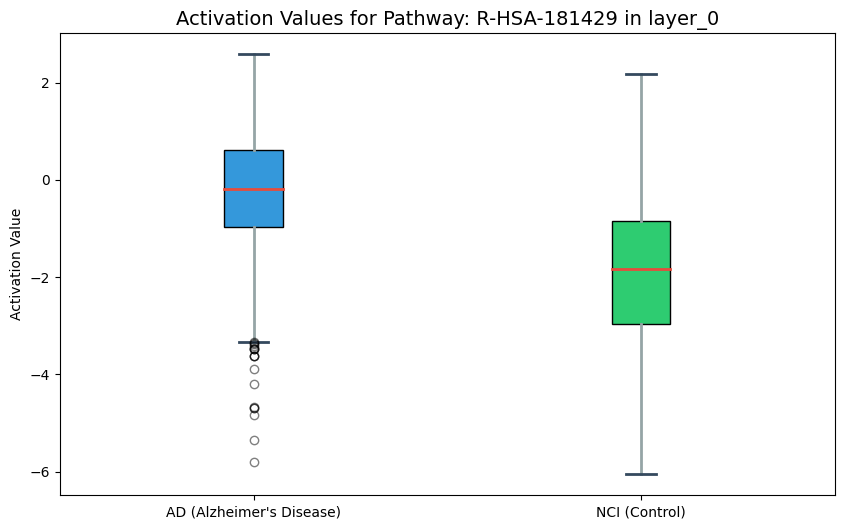

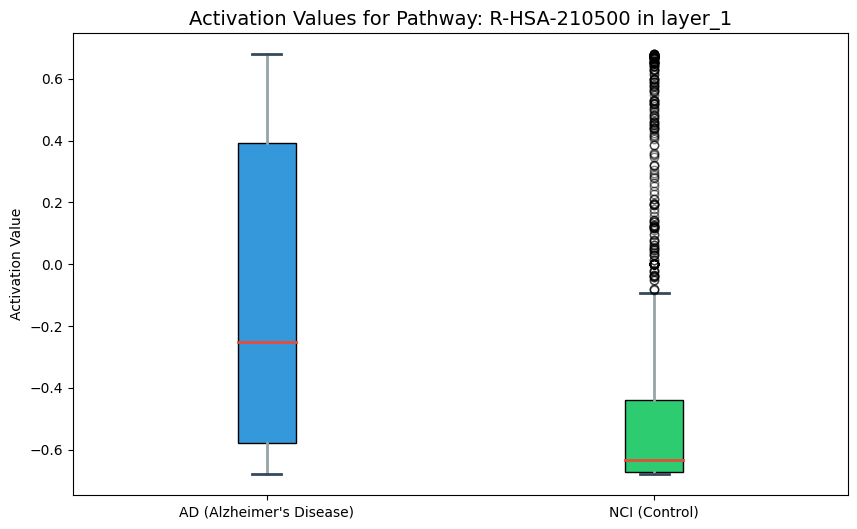

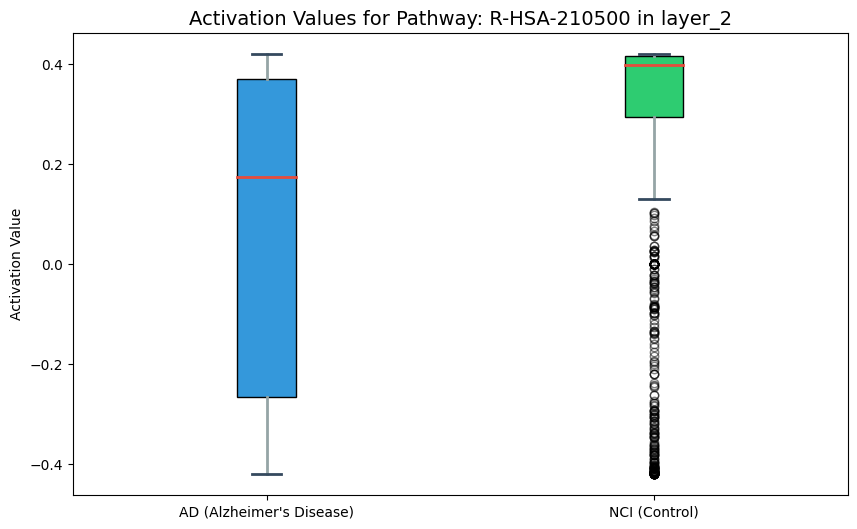

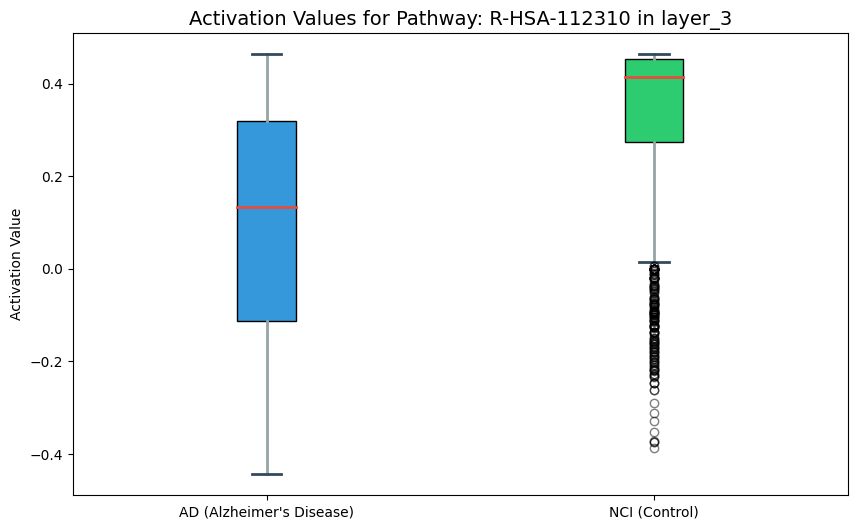

In [30]:
import matplotlib.pyplot as plt

# Function to clean column names for any DataFrame (removes '_copy1', '_copy2', etc.)
def clean_column_names(df):
    df.columns = df.columns.str.replace(r'_copy\d+', '', regex=True)
    return df

# Function to create colored boxplots for a given layer and pathway
def create_colored_boxplot(layer_df, top_pathway, layer_name):
    # Extract activations for AD and NCI
    ad_activations = layer_df[layer_df.ground_truth == 1][top_pathway]
    nci_activations = layer_df[layer_df.ground_truth == 0][top_pathway]
    
    # Prepare data for boxplot
    boxplot_data = [ad_activations.values, nci_activations.values]

    # Create a boxplot with colors
    plt.figure(figsize=(10, 6))

    # Define colors for the boxplot elements
    box_colors = ['#3498db', '#2ecc71']  # Blue for AD, Green for NCI

    # Create the boxplot
    box = plt.boxplot(boxplot_data, patch_artist=True, labels=['AD (Alzheimer\'s Disease)', 'NCI (Control)'])

    # Add colors to the boxes
    for patch, color in zip(box['boxes'], box_colors):
        patch.set_facecolor(color)

    # Change the colors of other elements
    for whisker in box['whiskers']:
        whisker.set(color='#95a5a6', linewidth=2)  # Grey whiskers
    for cap in box['caps']:
        cap.set(color='#34495e', linewidth=2)  # Dark grey caps
    for median in box['medians']:
        median.set(color='#e74c3c', linewidth=2)  # Red medians
    for flier in box['fliers']:
        flier.set(marker='o', color='#e74c3c', alpha=0.5)  # Red outliers

    # Add plot labels and title
    plt.title(f'Activation Values for Pathway: {top_pathway} in {layer_name}', fontsize=14)
    plt.ylabel('Activation Value')
    plt.show()

# Iterate over all layers in your model, excluding layer_4
for layer_name in list(activations_list_dict['model_5_hidden_layers'][0].keys())[:-1]:  # Exclude layer_4
    # Get the activations DataFrame for the current layer
    layer_df = pd.DataFrame(layer_dict[layer_name], index=test_x.columns, columns=layer_node_name_dict[layer_name])
    
    # Clean column names
    layer_df = clean_column_names(layer_df)

    # Add predicted and ground truth labels
    layer_df['predicted'] = predicted_list_dict['model_5_hidden_layers']
    layer_df['ground_truth'] = ground_truth_list_dict['model_5_hidden_layers']

    # Filter correct predictions
    correct_predicted_layer_df = layer_df[layer_df.predicted == layer_df.ground_truth]
    correct_predicted_layer_df_AD = correct_predicted_layer_df[correct_predicted_layer_df.predicted == 1]
    correct_predicted_layer_df_Control = correct_predicted_layer_df[correct_predicted_layer_df.predicted == 0]

    # Combine the filtered DataFrames
    combined_layer_df = pd.concat([correct_predicted_layer_df_AD, correct_predicted_layer_df_Control])
    combined_layer_df = combined_layer_df.drop(columns=['predicted'])

    # List of pathways (neurons) in the current layer
    list_layer = combined_layer_df.iloc[:, 0:-1].columns.tolist()

    # Calculate mean differences between AD and NCI activations
    mean_diff = []
    for i in list_layer:
        p = combined_layer_df[combined_layer_df.ground_truth == 1][i].values
        q = combined_layer_df[combined_layer_df.ground_truth == 0][i].values
        mean_diff.append(np.abs(np.mean(p) - np.mean(q)))

    # Store the results in a DataFrame
    data = pd.DataFrame([list_layer, mean_diff]).T
    data.columns = ['Pathway', 'Mean Difference']
    
    # Sort the results by mean difference
    mean_diff_dict[layer_name] = data.sort_values(by='Mean Difference', ascending=False)
    
    # Pick the top pathway for boxplot visualization
    top_pathway = mean_diff_dict[layer_name]['Pathway'].values[0]  # Get the top pathway
    
    # Create colored boxplot for the top pathway
    create_colored_boxplot(combined_layer_df, top_pathway, layer_name)




Top pathways in layer_0: ['R-HSA-6799198' 'R-HSA-419037' 'R-HSA-380259' 'R-HSA-389957']
Top pathways in layer_1: ['R-HSA-6799198' 'R-HSA-193634' 'R-HSA-427601' 'R-HSA-8949613']
Top pathways in layer_2: ['R-HSA-611105' 'R-HSA-193634' 'R-HSA-162592' 'R-HSA-5619085']
Top pathways in layer_3: ['R-HSA-425393' 'R-HSA-163200' 'R-HSA-6802957' 'R-HSA-1592230']


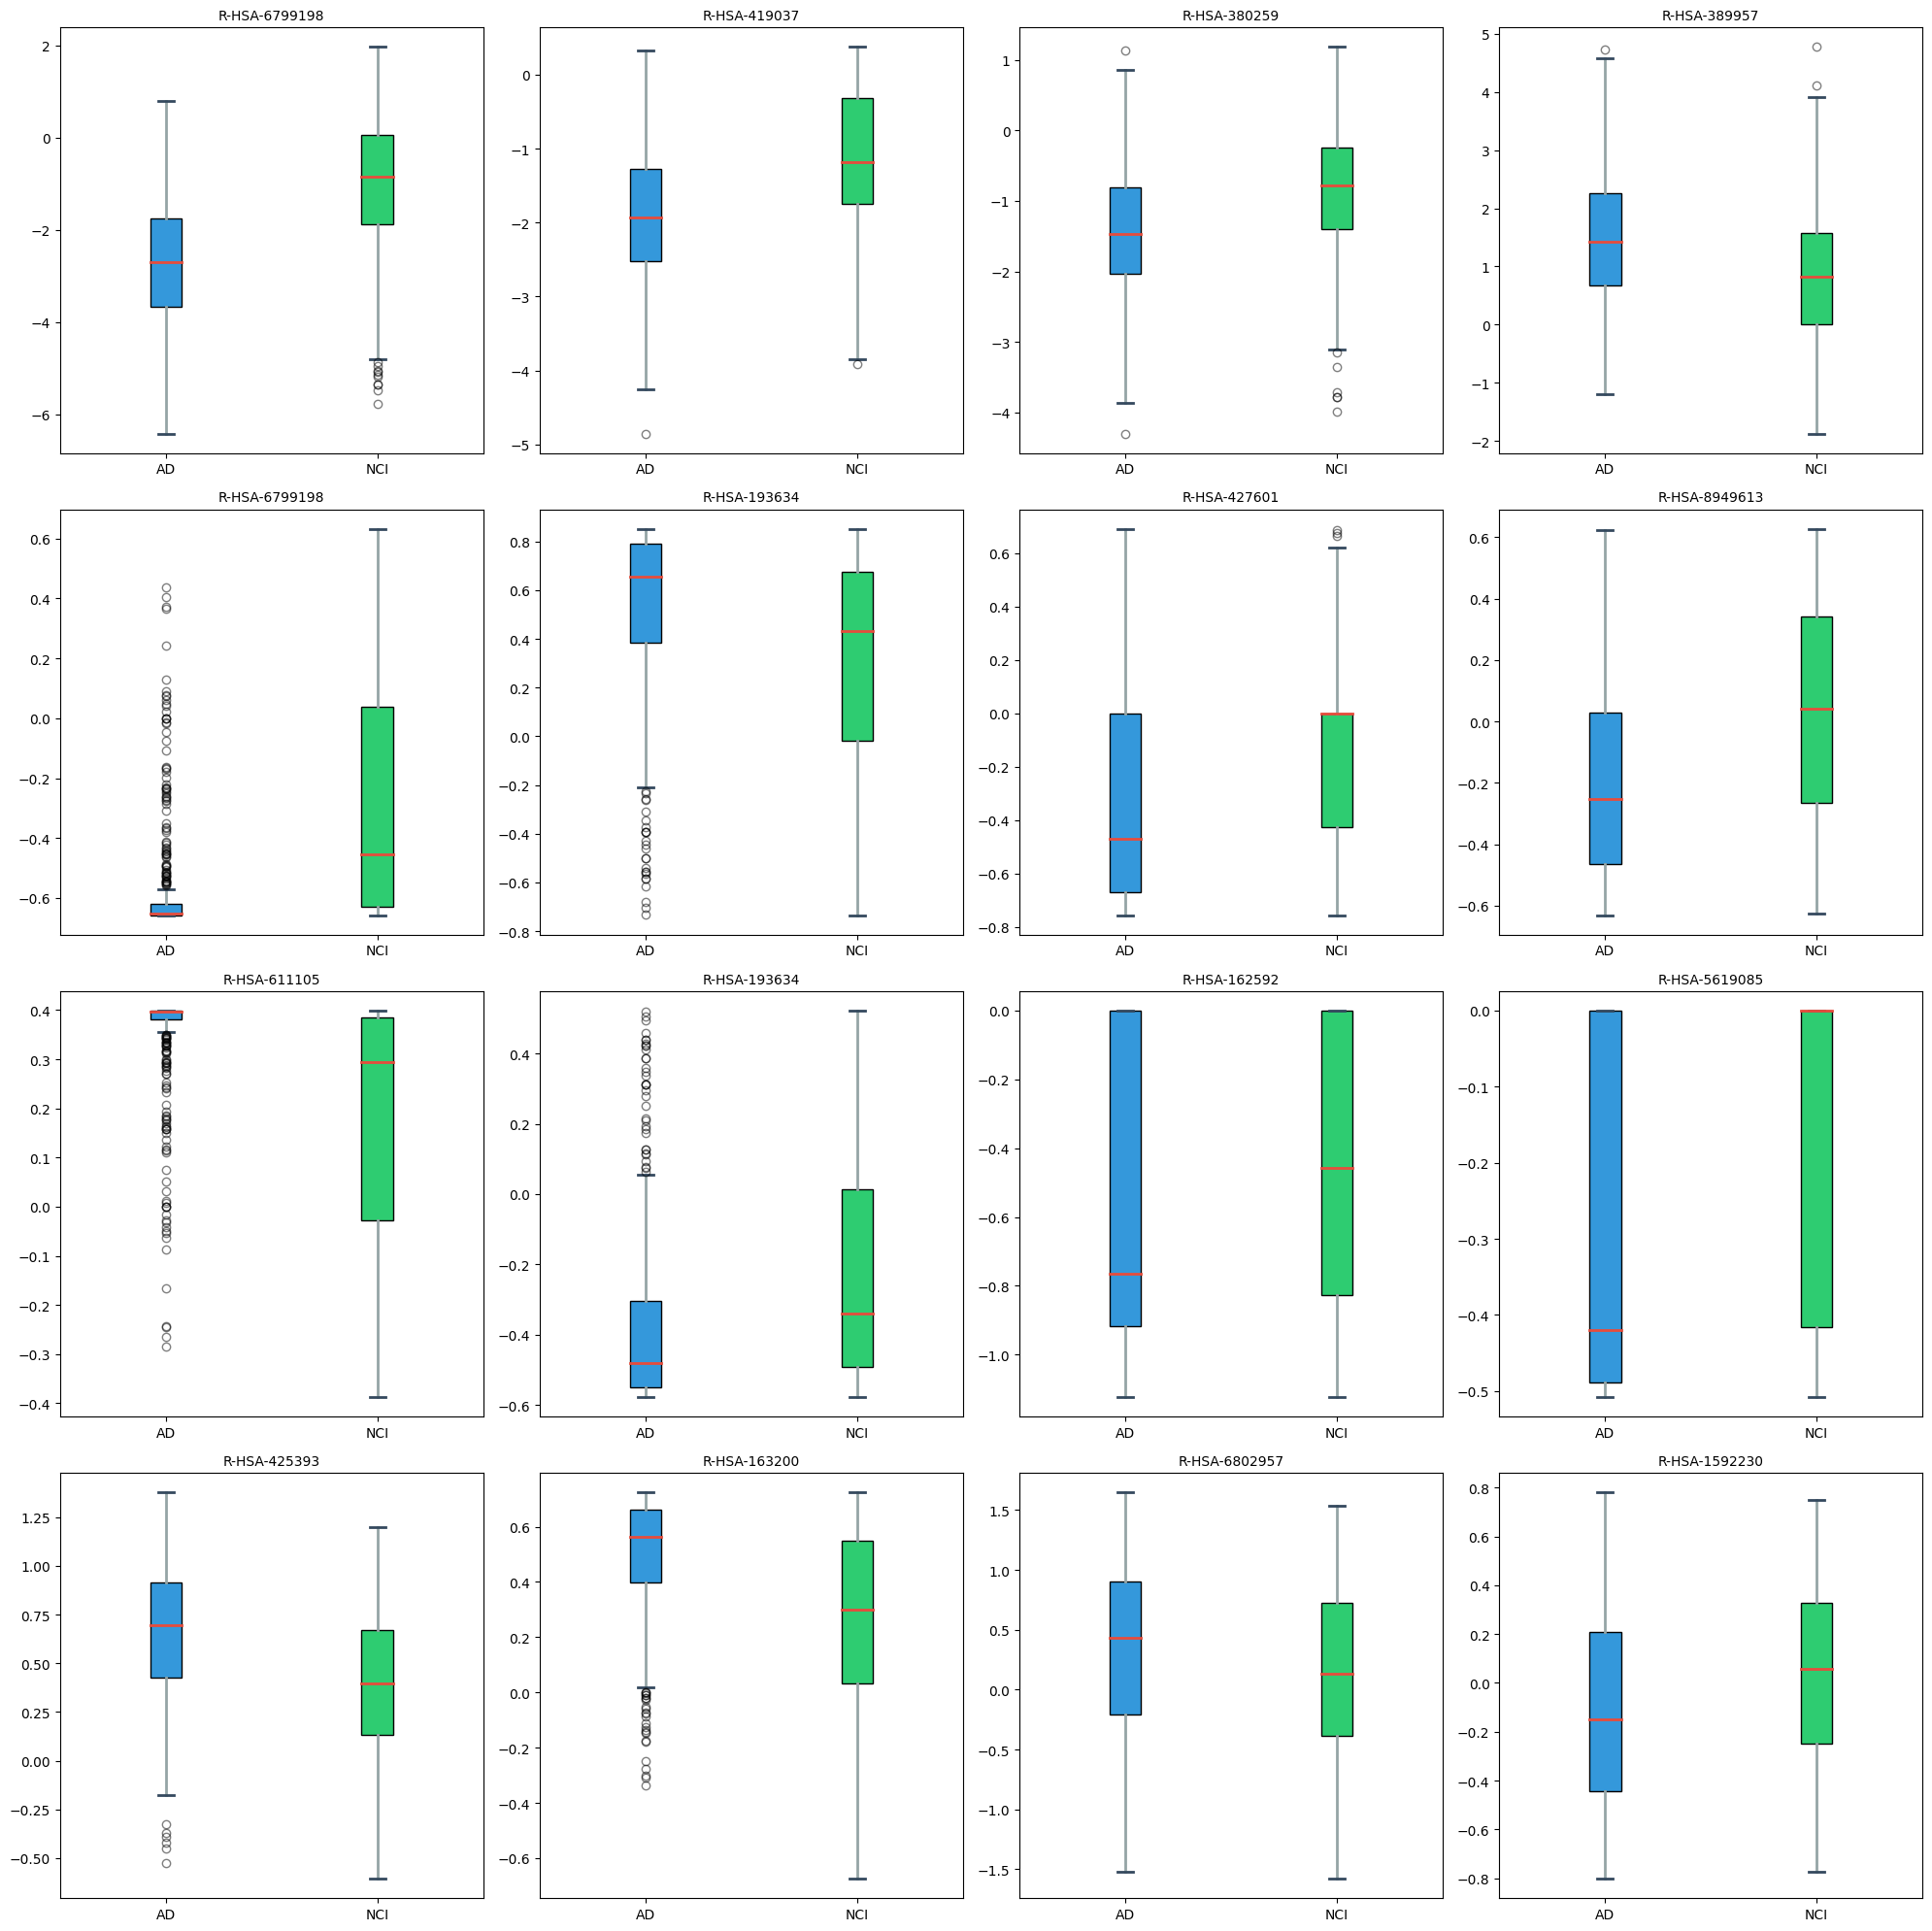

In [16]:
import matplotlib.pyplot as plt
import math

# Function to clean column names for any DataFrame (removes '_copy1', '_copy2', etc.)
def clean_column_names(df):
    df.columns = df.columns.str.replace(r'_copy\d+', '', regex=True)
    return df

# Function to create colored boxplots for a given layer and pathway
def create_colored_boxplot(ax, layer_df, top_pathway, title):
    # Extract activations for AD and NCI
    ad_activations = layer_df[layer_df.ground_truth == 1][top_pathway]
    nci_activations = layer_df[layer_df.ground_truth == 0][top_pathway]
    
    # Prepare data for boxplot
    boxplot_data = [ad_activations.values, nci_activations.values]

    # Define colors for the boxplot elements
    box_colors = ['#3498db', '#2ecc71']  # Blue for AD, Green for NCI

    # Create the boxplot
    box = ax.boxplot(boxplot_data, patch_artist=True, labels=['AD', 'NCI'])

    # Add colors to the boxes
    for patch, color in zip(box['boxes'], box_colors):
        patch.set_facecolor(color)

    # Change the colors of other elements
    for whisker in box['whiskers']:
        whisker.set(color='#95a5a6', linewidth=2)  # Grey whiskers
    for cap in box['caps']:
        cap.set(color='#34495e', linewidth=2)  # Dark grey caps
    for median in box['medians']:
        median.set(color='#e74c3c', linewidth=2)  # Red medians
    for flier in box['fliers']:
        flier.set(marker='o', color='#e74c3c', alpha=0.5)  # Red outliers

    # Set the title to the pathway code
    ax.set_title(title, fontsize=10)

# Define how many top pathways to plot per layer
top_n = 4

# Calculate the total number of plots
total_layers = len(list(activations_list_dict['model_5_hidden_layers'][0].keys())) - 1  # Exclude layer_4
total_plots = total_layers * top_n  # Total number of plots across layers

# Calculate the number of rows required for the grid (4 columns)
n_rows = math.ceil(total_plots / 4)
n_cols = 4  # Fixed number of columns

# Set up a grid for plotting
fig, axes = plt.subplots(n_rows, n_cols, figsize=(n_cols * 5, n_rows * 5))  # Adjust size for rows and columns

# Flatten the axes array for easier iteration
axes = axes.flatten()

plot_index = 0

# Iterate over all layers in your model, excluding layer_4
for layer_idx, layer_name in enumerate(list(activations_list_dict['model_5_hidden_layers'][0].keys())[:-1]):  # Exclude layer_4
    # Get the activations DataFrame for the current layer
    layer_df = pd.DataFrame(layer_dict[layer_name], index=test_x.columns, columns=layer_node_name_dict[layer_name])
    
    # Clean column names
    layer_df = clean_column_names(layer_df)

    # Add predicted and ground truth labels
    layer_df['predicted'] = predicted_list_dict['model_5_hidden_layers']
    layer_df['ground_truth'] = ground_truth_list_dict['model_5_hidden_layers']

    # Filter correct predictions
    correct_predicted_layer_df = layer_df[layer_df.predicted == layer_df.ground_truth]
    correct_predicted_layer_df_AD = correct_predicted_layer_df[correct_predicted_layer_df.predicted == 1]
    correct_predicted_layer_df_Control = correct_predicted_layer_df[correct_predicted_layer_df.predicted == 0]

    # Combine the filtered DataFrames
    combined_layer_df = pd.concat([correct_predicted_layer_df_AD, correct_predicted_layer_df_Control])
    combined_layer_df = combined_layer_df.drop(columns=['predicted'])

    # List of pathways (neurons) in the current layer
    list_layer = combined_layer_df.iloc[:, 0:-1].columns.tolist()

    # Calculate mean differences between AD and NCI activations
    mean_diff = []
    for i in list_layer:
        p = combined_layer_df[combined_layer_df.ground_truth == 1][i].values
        q = combined_layer_df[combined_layer_df.ground_truth == 0][i].values
        mean_diff.append(np.abs(np.mean(p) - np.mean(q)))

    # Store the results in a DataFrame
    data = pd.DataFrame([list_layer, mean_diff]).T
    data.columns = ['Pathway', 'Mean Difference']
    
    # Sort the results by mean difference
    mean_diff_dict[layer_name] = data.sort_values(by='Mean Difference', ascending=False)
    
    # Pick the top pathways for boxplot visualization
    top_pathways = mean_diff_dict[layer_name]['Pathway'].values[:top_n]  # Get the top pathways

    print(f"Top pathways in {layer_name}: {top_pathways}")  # Print the selected pathways for debugging
    
    # Create boxplots for the top pathways and plot them in the grid
    for top_pathway in top_pathways:
        if plot_index >= len(axes):
            break  # In case there are more plots than available axes
        create_colored_boxplot(axes[plot_index], combined_layer_df, top_pathway, top_pathway)
        plot_index += 1

# Hide any unused subplots
for i in range(plot_index, len(axes)):
    axes[i].axis('off')

# Adjust layout to avoid overlapping of titles and labels
plt.tight_layout()
plt.show()


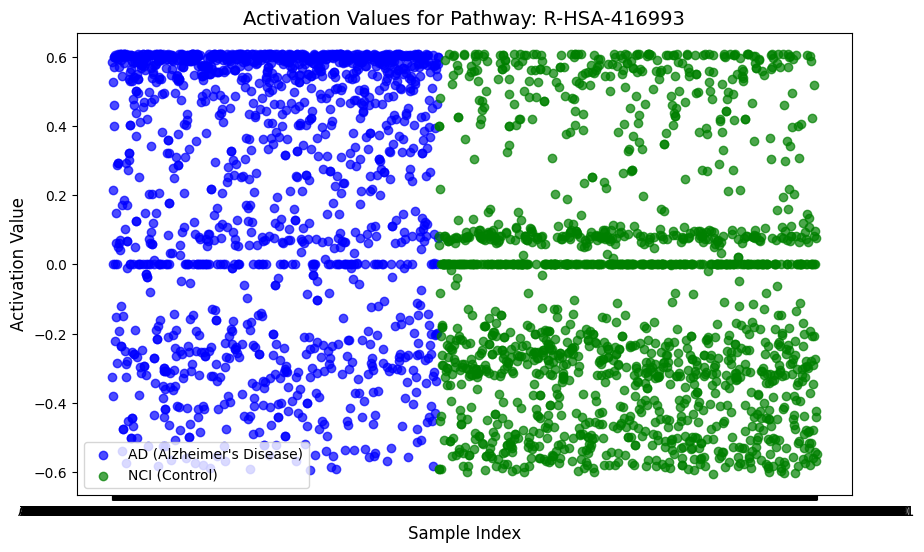

In [37]:
import matplotlib.pyplot as plt

# Choose a top pathway from the top 10 for layer 0 (manually selected or based on sorting)
top_pathway_code = 'R-HSA-416993'  # Example: Replace this with one of the actual top pathway codes

# Extract the activation values for this pathway for both AD and NCI
ad_activations = combined_layer_0[combined_layer_0.ground_truth == 1][top_pathway_code]
nci_activations = combined_layer_0[combined_layer_0.ground_truth == 0][top_pathway_code]

# Create a scatter plot
plt.figure(figsize=(10, 6))
plt.scatter(ad_activations.index, ad_activations.values, color='blue', label='AD (Alzheimer\'s Disease)', alpha=0.7)
plt.scatter(nci_activations.index, nci_activations.values, color='green', label='NCI (Control)', alpha=0.7)

# Add plot labels and title
plt.title(f'Activation Values for Pathway: {top_pathway_code}', fontsize=14)
plt.xlabel('Sample Index', fontsize=12)
plt.ylabel('Activation Value', fontsize=12)
plt.legend()

# Show plot
plt.show()




TypeError: can only concatenate str (not "int") to str

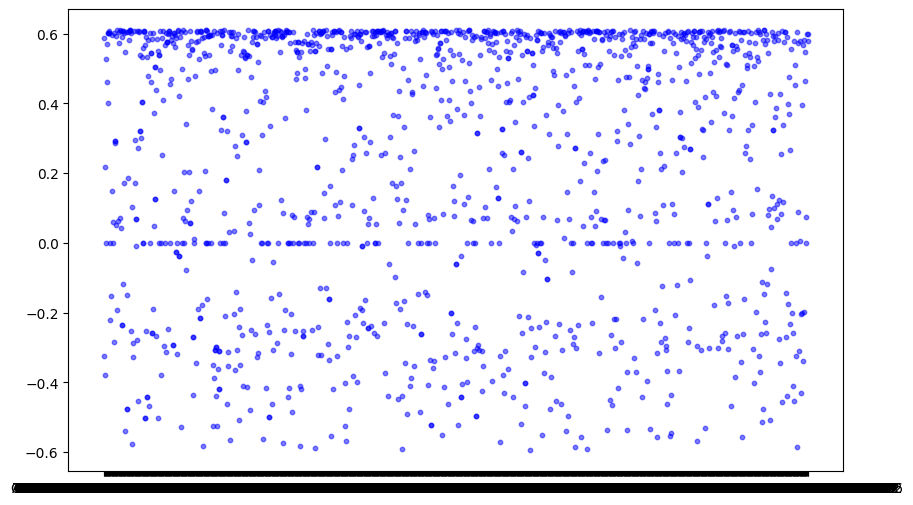

In [25]:
import matplotlib.pyplot as plt

# Choose a top pathway from the top 10 for layer 0 (manually selected or based on sorting)
top_pathway_code = 'R-HSA-1221632'  # Example: Replace this with one of the actual top pathway codes

# Extract the activation values for this pathway for both AD and NCI
ad_activations = combined_layer_0[combined_layer_0.ground_truth == 1][top_pathway_code]
nci_activations = combined_layer_0[combined_layer_0.ground_truth == 0][top_pathway_code]

# Create a scatter plot with adjustments
plt.figure(figsize=(10, 6))

# Plot AD activations
plt.scatter(ad_activations.index, ad_activations.values, color='blue', label='AD (Alzheimer\'s Disease)', alpha=0.5, s=10)

# Plot NCI activations, shifted along the x-axis to separate
plt.scatter(nci_activations.index + len(ad_activations), nci_activations.values, color='green', label='NCI (Control)', alpha=0.5, s=10)

# Add plot labels and title
plt.title(f'Activation Values for Pathway: {top_pathway_code}', fontsize=14)
plt.xlabel('Sample Index (AD vs NCI)', fontsize=12)
plt.ylabel('Activation Value', fontsize=12)
plt.legend()

# Show plot
plt.show()


In [27]:
pip install seaborn


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 294.9/294.9 kB 6.1 MB/s eta 0:00:00a 0:00:01
Note: you may need to restart the kernel to use updated packages.


In [22]:
matching_columns = [col for col in combined_layer_0.columns if 'R-HSA-451308' in col]
print(matching_columns)


['R-HSA-451308_copy1']


AttributeError: 'DataFrame' object has no attribute 'predicted'

In [25]:
# Function to clean column names for any DataFrame (removes '_copy1', '_copy2', etc.)
def clean_column_names(df):
    df.columns = df.columns.str.replace(r'_copy\d+', '', regex=True)
    return df

# Clean column names for each layer's activations (assuming 'combined_layer_0', 'combined_layer_1', etc. are DataFrames)
combined_layer_0 = clean_column_names(combined_layer_0)
combined_layer_1 = clean_column_names(combined_layer_1)
combined_layer_2 = clean_column_names(combined_layer_2)
# Add more layers as needed


NameError: name 'combined_layer_1' is not defined

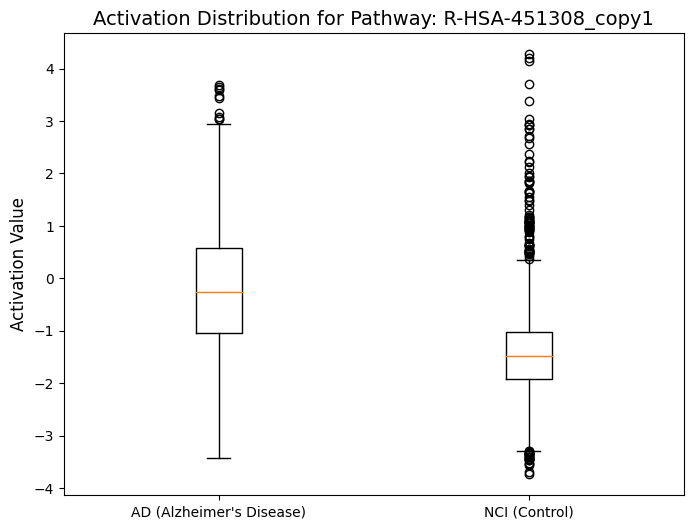

In [24]:
import seaborn as sns
import matplotlib.pyplot as plt

top_pathway_code = 'R-HSA-451308_copy1'  # Example: Replace this with one of the actual top pathway codes

# Extract the activation values for this pathway for both AD and NCI
ad_activations = combined_layer_0[combined_layer_0.ground_truth == 1][top_pathway_code]
nci_activations = combined_layer_0[combined_layer_0.ground_truth == 0][top_pathway_code]
# Prepare data for boxplot
boxplot_data = [
    ad_activations.values,
    nci_activations.values
]

# Create a boxplot
plt.figure(figsize=(8, 6))
plt.boxplot(boxplot_data, labels=['AD (Alzheimer\'s Disease)', 'NCI (Control)'])

# Add labels and title
plt.title(f'Activation Distribution for Pathway: {top_pathway_code}', fontsize=14)
plt.ylabel('Activation Value', fontsize=12)

# Show plot
plt.show()


In [22]:
print(combined_layer_0.columns)


Index(['R-HSA-9013700_copy1', 'R-HSA-70221_copy1', 'R-HSA-196299_copy1',
       'R-HSA-8849469', 'R-HSA-419037_copy1', 'R-HSA-113418_copy1',
       'R-HSA-9673324_copy1', 'R-HSA-168330_copy1', 'R-HSA-167246',
       'R-HSA-171007',
       ...
       'R-HSA-174178', 'R-HSA-174490', 'R-HSA-2179392_copy1',
       'R-HSA-6802953_copy1', 'R-HSA-171319', 'R-HSA-9694493_copy1',
       'R-HSA-936440_copy1', 'R-HSA-5173214_copy1', 'R-HSA-181430_copy1',
       'ground_truth'],
      dtype='object', length=592)


In [46]:
# Assuming 'mean_diff_dict' contains your results for each layer and 'reactome' contains the Reactome pathways data
# Mapping function to retrieve pathway names from the Reactome DataFrame using pathway code
def get_pathway_name(pathway_code):
    pathway_name = reactome[reactome[0] == pathway_code][1].values
    return pathway_name[0] if len(pathway_name) > 0 else 'Unknown Pathway'

# Iterate over all layers in your model, excluding layer_4
for layer_name, data in mean_diff_dict.items():
    # Add pathway names to the DataFrame based on the pathway code
    data['Pathway Name'] = data['Pathway'].apply(lambda x: get_pathway_name(layer_node_name_dict[layer_name][int(x.split()[1])]))
    
    print(f"Top pathways in {layer_name} by activation difference:")
    print(data[['Pathway Name', 'Mean Difference']].head(10))  # Display top 10 pathways with names
    print("\n")


IndexError: list index out of range

In [14]:
reactome = pd.read_csv('/12tb_dsk2/danish/Pytorch_Biologically_Informed_Neural_Network/reactome/ReactomePathways.txt', sep = '\t', header = None)
reactome

,0,1,2
0,R-BTA-73843,5-Phosphoribose 1-diphosphate biosynthesis,Bos taurus
1,R-BTA-1971475,A tetrasaccharide linker sequence is required ...,Bos taurus
2,R-BTA-1369062,ABC transporters in lipid homeostasis,Bos taurus
3,R-BTA-382556,ABC-family proteins mediated transport,Bos taurus
4,R-BTA-9033807,ABO blood group biosynthesis,Bos taurus
...,...,...,...
21418,R-XTR-193639,p75NTR signals via NF-kB,Xenopus tropicalis
21419,R-XTR-111995,phospho-PLA2 pathway,Xenopus tropicalis
21420,R-XTR-191859,snRNP Assembly,Xenopus tropicalis
21421,R-XTR-379724,tRNA Aminoacylation,Xenopus tropicalis


In [39]:
import pandas as pd

# Load the Reactome pathways file
reactome = pd.read_csv('/12tb_dsk2/danish/Pytorch_Biologically_Informed_Neural_Network/reactome/ReactomePathways.txt', sep='\t', header=None)

# Define a function to return the pathway name based on the pathway ID
def return_name(i):
    try:
        pathway_name = reactome[reactome[0] == i][1].values[0]
        return pathway_name
    except IndexError:
        return 'Unknown Pathway'

# Debug function to print intermediate data
def debug_layer_mapping(layer_name, data):
    print(f"\nLayer: {layer_name}")
    print("First 5 rows of Pathway Index column:")
    print(data['Pathway Index'].head())
    print("First 5 rows of Pathway Name column:")
    print(data['Pathway Name'].head())

def extract_index(x):
    # Split the pathway string to extract the index
    parts = x.split()
    if len(parts) > 1:
        return int(parts[1])
    return None

# Dictionary to store the top 10 pathways for each layer
top_pathways_dict = {}

# Iterate over all layers in your model, excluding layer_4
for layer_name, data in mean_diff_dict.items():
    
    # Extract the index from the pathway string
    data['Pathway Index'] = data['Pathway'].apply(lambda x: extract_index(x))
    
    # Check if pathway index exists and is within bounds of the layer_node_name_dict
    data['Pathway Name'] = data['Pathway Index'].apply(
        lambda idx: return_name(layer_node_name_dict[layer_name][idx]) 
        if idx is not None and idx < len(layer_node_name_dict[layer_name]) else 'Unknown Pathway'
    )
    
    # Debugging: print out pathway mappings for this layer
    debug_layer_mapping(layer_name, data)
    
    # Sort the data by mean difference and select the top 10 pathways
    top_10_data = data[['Pathway Name', 'Mean Difference']].sort_values(by='Mean Difference', ascending=False).head(10)
    
    # Store the result in the dictionary
    top_pathways_dict[layer_name] = top_10_data

# Now, print the top pathways for each layer
for layer_name, top_pathways in top_pathways_dict.items():
    print(f"Top 10 pathways in {layer_name} by activation difference:")
    print(top_pathways)
    print("\n")




Layer: layer_0
First 5 rows of Pathway Index column:
60     None
38     None
135    None
450    None
288    None
Name: Pathway Index, dtype: object
First 5 rows of Pathway Name column:
60     Unknown Pathway
38     Unknown Pathway
135    Unknown Pathway
450    Unknown Pathway
288    Unknown Pathway
Name: Pathway Name, dtype: object

Layer: layer_1
First 5 rows of Pathway Index column:
260    None
343    None
528    None
81     None
368    None
Name: Pathway Index, dtype: object
First 5 rows of Pathway Name column:
260    Unknown Pathway
343    Unknown Pathway
528    Unknown Pathway
81     Unknown Pathway
368    Unknown Pathway
Name: Pathway Name, dtype: object

Layer: layer_2
First 5 rows of Pathway Index column:
462    None
237    None
439    None
405    None
348    None
Name: Pathway Index, dtype: object
First 5 rows of Pathway Name column:
462    Unknown Pathway
237    Unknown Pathway
439    Unknown Pathway
405    Unknown Pathway
348    Unknown Pathway
Name: Pathway Name, dtype: ob

In [17]:
import torch
import numpy as np

# Step 1: Separate the Samples by Class
def separate_samples_by_class(dataloader, predictions, labels):
    ad_features = []
    nci_features = []
    
    for idx, (features, _) in enumerate(dataloader):
        if predictions[idx] == 1:  # AD
            ad_features.append(features)
        else:  # NCI
            nci_features.append(features)
    
    ad_features = torch.cat(ad_features)
    nci_features = torch.cat(nci_features)
    
    return ad_features, nci_features

# Step 2: Calculate Mean Activations for Each Class
def calculate_mean_activations_by_class(model, ad_features, nci_features):
    activations = {'AD': {}, 'NCI': {}}
    
    # Define hook to capture activations
    def get_activation(name, class_type):
        def hook(model, input, output):
            if name not in activations[class_type]:
                activations[class_type][name] = []
            activations[class_type][name].append(output.detach().cpu().numpy())
        return hook
    
    # Register hooks for each layer
    for idx, layer in enumerate(model.layers):
        layer_name = f'layer_{idx}'
        layer.register_forward_hook(get_activation(layer_name, 'AD'))
        layer.register_forward_hook(get_activation(layer_name, 'NCI'))
    
    # Pass AD features through the model
    with torch.no_grad():
        _ = model(ad_features)
    
    # Pass NCI features through the model
    with torch.no_grad():
        _ = model(nci_features)
    
    # Calculate mean activations for each class
    mean_activations_ad = {name: np.mean(np.concatenate(acts), axis=0) for name, acts in activations['AD'].items()}
    mean_activations_nci = {name: np.mean(np.concatenate(acts), axis=0) for name, acts in activations['NCI'].items()}
    
    return mean_activations_ad, mean_activations_nci

# Step 3: Compute the Difference
def calculate_activation_differences(mean_activations_ad, mean_activations_nci):
    activation_diffs = {}
    
    for name in mean_activations_ad.keys():
        activation_diffs[name] = mean_activations_ad[name] - mean_activations_nci[name]
    
    return activation_diffs

# Assuming `predicted_list` and `labels_list` were obtained earlier and contain predictions and true labels respectively.
ad_features, nci_features = separate_samples_by_class(test_dataloader, predicted_list, labels_list)
mean_activations_ad, mean_activations_nci = calculate_mean_activations_by_class(model, ad_features, nci_features)
activation_diffs = calculate_activation_differences(mean_activations_ad, mean_activations_nci)

# Analyzing the results
for name, diff in activation_diffs.items():
    sorted_indices = np.argsort(np.abs(diff))[::-1]
    print(f"Top pathways in {name} by activation difference:")
    for idx in sorted_indices[:10]:  # Top 10 pathways by difference
        print(f"Pathway {idx}, Activation Difference: {diff[idx]}")


Top pathways in layer_0 by activation difference:
Pathway 612, Activation Difference: 0.0
Pathway 200, Activation Difference: 0.0
Pathway 207, Activation Difference: 0.0
Pathway 206, Activation Difference: 0.0
Pathway 205, Activation Difference: 0.0
Pathway 204, Activation Difference: 0.0
Pathway 203, Activation Difference: 0.0
Pathway 202, Activation Difference: 0.0
Pathway 201, Activation Difference: 0.0
Pathway 199, Activation Difference: 0.0
Top pathways in layer_1 by activation difference:
Pathway 590, Activation Difference: 0.0
Pathway 184, Activation Difference: 0.0
Pathway 200, Activation Difference: 0.0
Pathway 199, Activation Difference: 0.0
Pathway 198, Activation Difference: 0.0
Pathway 197, Activation Difference: 0.0
Pathway 196, Activation Difference: 0.0
Pathway 195, Activation Difference: 0.0
Pathway 194, Activation Difference: 0.0
Pathway 193, Activation Difference: 0.0
Top pathways in layer_2 by activation difference:
Pathway 494, Activation Difference: 0.0
Pathway 15

In [18]:
# Check the count of AD and NCI samples
ad_count = sum([1 for pred in predicted_list if pred == 1])
nci_count = sum([1 for pred in predicted_list if pred == 0])
print(f"AD samples: {ad_count}, NCI samples: {nci_count}")


AD samples: 1842, NCI samples: 2254


In [20]:
# Assuming mean_activations and sorted_indices are already computed as in the previous code

# Identify the layer of interest
layer_of_interest = 'layer_0'  # Change as needed

# Get the pathway names from the existing layer_node_name_dict
pathway_names = layer_node_name_dict[layer_of_interest]

# Display top pathways by name and mean activation
print(f"Top pathways in {layer_of_interest} by mean activation:")
for idx in sorted_indices[:10]:  # Top 10 pathways
    pathway_name = pathway_names[idx]
    mean_activation_value = mean_activations[layer_of_interest][idx]
    print(f"Pathway: {pathway_name}, Mean Activation: {mean_activation_value}")

Top pathways in layer_0 by mean activation:
Pathway: R-HSA-212676_copy2, Mean Activation: 1.525528907775879
Pathway: R-HSA-264642_copy2, Mean Activation: 1.52336847782135
Pathway: R-HSA-181430_copy2, Mean Activation: 1.4972338676452637
Pathway: R-HSA-163210_copy2, Mean Activation: 1.4563183784484863
Pathway: R-HSA-1221632_copy2, Mean Activation: 1.4117038249969482
Pathway: R-HSA-210500_copy2, Mean Activation: 1.0298596620559692
Pathway: R-HSA-419037_copy2, Mean Activation: 0.9823751449584961
Pathway: R-HSA-9664565_copy2, Mean Activation: 0.9814764261245728
Pathway: R-HSA-451308_copy1, Mean Activation: 0.9386289119720459
Pathway: R-HSA-9649948_copy1, Mean Activation: 0.9291532635688782


In [21]:
layer_of_interest = 'layer_1'  # Change as needed

# Get the pathway names from the existing layer_node_name_dict
pathway_names = layer_node_name_dict[layer_of_interest]

# Display top pathways by name and mean activation
print(f"Top pathways in {layer_of_interest} by mean activation:")
for idx in sorted_indices[:10]:  # Top 10 pathways
    pathway_name = pathway_names[idx]
    mean_activation_value = mean_activations[layer_of_interest][idx]
    print(f"Pathway: {pathway_name}, Mean Activation: {mean_activation_value}")

Top pathways in layer_1 by mean activation:
Pathway: R-HSA-418359_copy1, Mean Activation: -0.132895365357399
Pathway: R-HSA-1855204_copy1, Mean Activation: -0.25245749950408936
Pathway: R-HSA-2514859, Mean Activation: 0.10262797772884369
Pathway: R-HSA-442982_copy1, Mean Activation: -0.24742555618286133
Pathway: R-HSA-5696397, Mean Activation: -0.03309998661279678
Pathway: R-HSA-5362768_copy1, Mean Activation: -0.04447747766971588
Pathway: R-HSA-2470946_copy1, Mean Activation: 0.2316017597913742
Pathway: R-HSA-166208_copy1, Mean Activation: -0.19092214107513428
Pathway: R-HSA-209560_copy1, Mean Activation: -0.021184707060456276
Pathway: R-HSA-1971475_copy1, Mean Activation: -0.02257414348423481


In [23]:
layer_of_interest = 'layer_2'  # Change as needed

# Get the pathway names from the existing layer_node_name_dict
pathway_names = layer_node_name_dict[layer_of_interest]

# Filter valid indices
valid_indices = [idx for idx in sorted_indices if idx < len(pathway_names)]

# Display top pathways by name and mean activation
print(f"Top pathways in {layer_of_interest} by mean activation:")
for idx in valid_indices[:10]:  # Top 10 valid pathways
    pathway_name = pathway_names[idx]
    mean_activation_value = mean_activations[layer_of_interest][idx]
    print(f"Pathway: {pathway_name}, Mean Activation: {mean_activation_value}")


Top pathways in layer_2 by mean activation:
Pathway: R-HSA-5619092, Mean Activation: -5.604283433058299e-05
Pathway: R-HSA-110313, Mean Activation: -0.004790235310792923
Pathway: R-HSA-6782315, Mean Activation: -0.0009031100198626518
Pathway: R-HSA-418886, Mean Activation: -0.021780166774988174
Pathway: R-HSA-3000480, Mean Activation: -0.060272760689258575
Pathway: R-HSA-1250347, Mean Activation: 0.004237116314470768
Pathway: R-HSA-5655253, Mean Activation: 0.006960423197597265
Pathway: R-HSA-392451, Mean Activation: -0.018583331257104874
Pathway: R-HSA-9656223, Mean Activation: 0.06612513214349747
Pathway: R-HSA-162585, Mean Activation: -6.823619332863018e-05


In [24]:
layer_of_interest = 'layer_3'  # Referring to the third hidden layer

# Get the pathway names from the existing layer_node_name_dict
pathway_names = layer_node_name_dict.get(layer_of_interest, [])

# Check the size of mean activations and pathway names
print(f"Number of pathways in {layer_of_interest}: {len(pathway_names)}")
print(f"Shape of mean activations for {layer_of_interest}: {mean_activations[layer_of_interest].shape}")

# Ensure valid indices
valid_indices = [idx for idx in sorted_indices if idx < len(pathway_names)]

# Display top pathways by name and mean activation
print(f"Top pathways in {layer_of_interest} by mean activation:")
for idx in valid_indices[:10]:  # Top 10 valid pathways
    if len(mean_activations[layer_of_interest]) > idx:
        pathway_name = pathway_names[idx]
        mean_activation_value = mean_activations[layer_of_interest][idx]
        print(f"Pathway: {pathway_name}, Mean Activation: {mean_activation_value}")
    else:
        print(f"Index {idx} is out of bounds for mean activations in {layer_of_interest}.")


Number of pathways in layer_3: 243
Shape of mean activations for layer_3: (243,)
Top pathways in layer_3 by mean activation:
Pathway: R-HSA-8979227, Mean Activation: 0.013512448407709599
Pathway: R-HSA-1638074, Mean Activation: 1.092477219799548e-09
Pathway: R-HSA-927802, Mean Activation: 0.0014379273634403944
Pathway: R-HSA-4791275, Mean Activation: -0.029084883630275726
Pathway: R-HSA-1227990, Mean Activation: 0.031493738293647766
Pathway: R-HSA-9675135, Mean Activation: -0.017274444922804832
Pathway: R-HSA-9678108, Mean Activation: -0.0018147036898881197
Pathway: R-HSA-157858, Mean Activation: -0.0021777048241347075
Pathway: R-HSA-1234174, Mean Activation: -0.025325685739517212
Pathway: R-HSA-6791312, Mean Activation: 0.007690717000514269


In [25]:
layer_of_interest = 'layer_4'  # Referring to the third hidden layer

# Get the pathway names from the existing layer_node_name_dict
pathway_names = layer_node_name_dict.get(layer_of_interest, [])

# Check the size of mean activations and pathway names
print(f"Number of pathways in {layer_of_interest}: {len(pathway_names)}")
print(f"Shape of mean activations for {layer_of_interest}: {mean_activations[layer_of_interest].shape}")

# Ensure valid indices
valid_indices = [idx for idx in sorted_indices if idx < len(pathway_names)]

# Display top pathways by name and mean activation
print(f"Top pathways in {layer_of_interest} by mean activation:")
for idx in valid_indices[:10]:  # Top 10 valid pathways
    if len(mean_activations[layer_of_interest]) > idx:
        pathway_name = pathway_names[idx]
        mean_activation_value = mean_activations[layer_of_interest][idx]
        print(f"Pathway: {pathway_name}, Mean Activation: {mean_activation_value}")
    else:
        print(f"Index {idx} is out of bounds for mean activations in {layer_of_interest}.")

Number of pathways in layer_4: 0
Shape of mean activations for layer_4: (1,)
Top pathways in layer_4 by mean activation:


In [54]:
def get_activation(name):
    def hook(model, input, output):
        activations[name] = output.detach().cpu().numpy()
    return hook

# Register hooks for each layer
for idx, layer in enumerate(model.layers):
    layer_name = f'layer_{idx}'
    layer.register_forward_hook(get_activation(layer_name))


In [55]:
# Assuming all_activations[layer_name] is a list of numpy arrays
all_activations_layer3 = np.concatenate(all_activations['layer_3'], axis=0)
mean_activations['layer_3'] = np.mean(all_activations_layer3, axis=0)

print(f"Recomputed mean activations for layer_3: {mean_activations['layer_3'].shape}")


Recomputed mean activations for layer_3: (1,)


In [56]:
# After a forward pass
print(f"Activations captured for layer_3: {activations['layer_3'].shape}")


Activations captured for layer_3: (1, 1)


In [3]:
layer_3_df

NameError: name 'layer_3_df' is not defined

In [29]:
import numpy as np

def aggregate_mean_activations(mean_activations, layer_node_name_dict):
    """
    Aggregate the mean activations across all layers except the output layer and keep track of pathway names and layers.

    mean_activations: dict
        A dictionary where keys are layer names and values are numpy arrays of mean activations
        for each pathway, shape (num_neurons,).

    layer_node_name_dict: dict
        A dictionary mapping each layer to its corresponding pathway names.

    Returns:
    aggregated_scores: dict
        A dictionary mapping (layer_name, pathway_name) to their aggregated mean activation scores.
    """
    aggregated_scores = {}

    for layer, activations in mean_activations.items():
        if layer == 'layer_4':  # Skip the output layer
            continue
        pathway_names = layer_node_name_dict[layer]
        for idx, activation in enumerate(activations):
            pathway_name = pathway_names[idx]
            key = (layer, pathway_name)
            if key in aggregated_scores:
                aggregated_scores[key] += activation  # You can also use max, average, etc.
            else:
                aggregated_scores[key] = activation

    return aggregated_scores

def find_top_n_pathways(aggregated_scores, n=20):
    """
    Find the top N pathways based on their aggregated mean activation scores.

    aggregated_scores: dict
        A dictionary mapping (layer_name, pathway_name) to their aggregated mean activation scores.

    n: int
        The number of top pathways to return.

    Returns:
    top_n_pathways: list
        A list of tuples containing the top N pathways and their scores, sorted in descending order.
    """
    # Sort pathways by their aggregated scores in descending order
    sorted_pathways = sorted(aggregated_scores.items(), key=lambda x: x[1], reverse=True)
    # Return the top N pathways
    return sorted_pathways[:n]

# Example usage:
# Assuming `mean_activations` is a dictionary where each key is a layer (e.g., 'layer_0', 'layer_1')
# and each value is a numpy array containing the mean activations for each pathway in that layer.
# Also assuming `layer_node_name_dict` maps each layer to the pathway names.

# Step 1: Aggregate mean activations across all layers except the output layer
aggregated_scores = aggregate_mean_activations(mean_activations, layer_node_name_dict)

# Step 2: Find the top 20 pathways
top_20_pathways = find_top_n_pathways(aggregated_scores, n=20)

# Print the top 20 pathways, their layers, and their aggregated mean activation scores
print("Top 20 pathways across all layers based on mean activation:")
for (layer_name, pathway_name), score in top_20_pathways:
    print(f"Layer: {layer_name}, Pathway: {pathway_name}, Aggregated Mean Activation Score = {score}")


Top 20 pathways across all layers based on mean activation:
Layer: layer_0, Pathway: R-HSA-212676_copy2, Aggregated Mean Activation Score = 1.525528907775879
Layer: layer_0, Pathway: R-HSA-264642_copy2, Aggregated Mean Activation Score = 1.52336847782135
Layer: layer_0, Pathway: R-HSA-181430_copy2, Aggregated Mean Activation Score = 1.4972338676452637
Layer: layer_0, Pathway: R-HSA-163210_copy2, Aggregated Mean Activation Score = 1.4563183784484863
Layer: layer_0, Pathway: R-HSA-1221632_copy2, Aggregated Mean Activation Score = 1.4117038249969482
Layer: layer_0, Pathway: R-HSA-210500_copy2, Aggregated Mean Activation Score = 1.0298596620559692
Layer: layer_0, Pathway: R-HSA-419037_copy2, Aggregated Mean Activation Score = 0.9823751449584961
Layer: layer_0, Pathway: R-HSA-9664565_copy2, Aggregated Mean Activation Score = 0.9814764261245728
Layer: layer_0, Pathway: R-HSA-451308_copy1, Aggregated Mean Activation Score = 0.9386289119720459
Layer: layer_0, Pathway: R-HSA-9649948_copy1, Aggr

In [2]:
layer_3_df

NameError: name 'layer_3_df' is not defined